# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
!unzip processed_celeba_small.zip

In [1]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import face_project.problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [2]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader


In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    data_dir = "face_project/"+data_dir
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])

    dataset = datasets.ImageFolder(data_dir, transform)

    # create and return DataLoaders
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,drop_last=True)


    return loader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [4]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

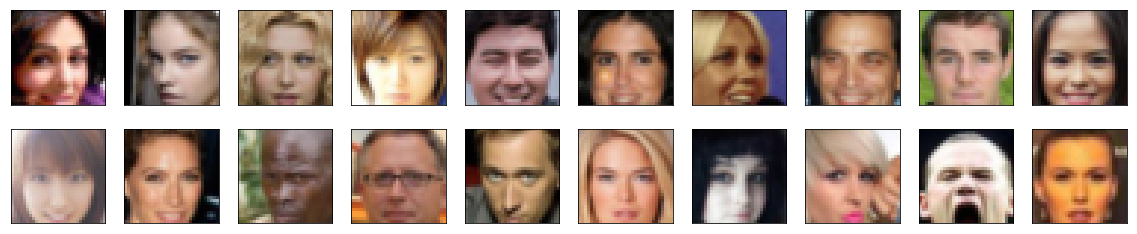

In [5]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
plt.show()

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1.
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)

    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        self.conv_dim = conv_dim
        super(Discriminator, self).__init__()

        # complete init function

        self.conv1 = conv(3, conv_dim, 4, 1,batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim * 2, 4)
        self.conv3 = conv(conv_dim * 2, conv_dim * 4, 4)
        self.conv4 = conv(conv_dim * 4, conv_dim * 8, 4)

        self.fc = nn.Linear(conv_dim * 8*3*3, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # complete forward function

        x = self.dropout(F.leaky_relu(self.conv1(x), 0.2))
        x = self.dropout(F.leaky_relu(self.conv2(x), 0.2))
        x = self.dropout(F.leaky_relu(self.conv3(x), 0.2))
        x = self.dropout(F.leaky_relu(self.conv4(x), 0.2))
        x = x.view(-1, self.conv_dim * 8*3*3)
        x = self.fc(x)

        return x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [10]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    ## TODO: Complete this function
    ## create a sequence of transpose + optional batch norm layers
    layer = []
    conv_transpose = nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False)
    layer.append(conv_transpose)
    if batch_size:
        layer.append(nn.BatchNorm2d(out_channels))

    return nn.Sequential(*layer)

class Generator(nn.Module):

    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function

        self.conv_dim = conv_dim

        self.fc = nn.Linear(z_size, conv_dim * 8*3*3)

        self.t_conv1 = deconv(conv_dim * 8, conv_dim * 4, 4,1)
        self.t_conv2 = deconv(conv_dim * 4, conv_dim*2, 4)
        self.t_conv3 = deconv(conv_dim * 2, conv_dim, 4)
        self.t_conv4 = deconv(conv_dim, 3, 4, batch_norm=False)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # complete forward function
        x = self.fc(x)
        x = x.view(-1, self.conv_dim * 8, 3, 3)
        x = self.dropout(F.relu(self.t_conv1(x)))
        x = self.dropout(F.relu(self.t_conv2(x)))
        x = self.dropout(F.relu(self.t_conv3(x)))
        x = F.tanh(self.t_conv4(x))

        return x

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


/home/helmogey/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [11]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__

    # TODO: Apply initial weights to convolutional and linear layers

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data,mean=0,std=0.02)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [29]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2304, out_features=1, bias=True)
  (dropout): Dropout(p=0.2)
)

Generator(
  (fc): Linear(in_features=100, out_features=2304, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1),

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [30]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [31]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    labels = torch.ones(batch_size)*0.9
    if train_on_gpu:
        labels = labels.cuda()

    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''

    batch_size = D_out.size(0)
    labels = torch.ones(batch_size)*0.3

    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [32]:
import torch.optim as optim


lr =0.0001
beta1=0.4
beta2=0.8

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [33]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''

    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size = 16
    fixed_z = np.random.normal(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================

            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            if train_on_gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 2. Train with fake images

            # Generate fake images
            z = np.random.normal(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()

            # 1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.normal(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake)  # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()

            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch + 1, n_epochs, d_loss.item(), g_loss.item()))

        ## AFTER EACH EPOCH##
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval()  # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train()  # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [34]:
# set number of epochs 
n_epochs = 100


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 1.4968 | g_loss: 0.8486


Epoch [    1/  100] | d_loss: 1.0102 | g_loss: 1.1073


Epoch [    1/  100] | d_loss: 0.9790 | g_loss: 1.2427


Epoch [    1/  100] | d_loss: 0.9674 | g_loss: 1.1998


Epoch [    1/  100] | d_loss: 0.9595 | g_loss: 1.2263


Epoch [    1/  100] | d_loss: 0.9655 | g_loss: 1.2486


Epoch [    1/  100] | d_loss: 0.9543 | g_loss: 1.1536


Epoch [    1/  100] | d_loss: 0.9641 | g_loss: 1.1209


Epoch [    1/  100] | d_loss: 0.9562 | g_loss: 0.9783


Epoch [    1/  100] | d_loss: 0.9558 | g_loss: 1.0497


Epoch [    1/  100] | d_loss: 0.9501 | g_loss: 0.9850


Epoch [    1/  100] | d_loss: 0.9479 | g_loss: 1.2982


Epoch [    1/  100] | d_loss: 0.9760 | g_loss: 1.2957


Epoch [    1/  100] | d_loss: 0.9554 | g_loss: 1.1448


Epoch [    1/  100] | d_loss: 0.9669 | g_loss: 1.2451


Epoch [    1/  100] | d_loss: 0.9620 | g_loss: 1.2202


Epoch [    1/  100] | d_loss: 0.9527 | g_loss: 1.1861


Epoch [    1/  100] | d_loss: 0.9574 | g_loss: 1.0465


Epoch [    1/  100] | d_loss: 0.9557 | g_loss: 1.0679


Epoch [    1/  100] | d_loss: 0.9621 | g_loss: 1.0971


Epoch [    1/  100] | d_loss: 0.9580 | g_loss: 1.3375


Epoch [    1/  100] | d_loss: 0.9511 | g_loss: 1.1113


Epoch [    1/  100] | d_loss: 0.9509 | g_loss: 1.5088


Epoch [    1/  100] | d_loss: 0.9587 | g_loss: 1.0695


Epoch [    1/  100] | d_loss: 0.9691 | g_loss: 0.9374


Epoch [    1/  100] | d_loss: 0.9503 | g_loss: 1.1660


Epoch [    1/  100] | d_loss: 0.9578 | g_loss: 1.2352


Epoch [    1/  100] | d_loss: 0.9516 | g_loss: 1.3196


Epoch [    1/  100] | d_loss: 0.9499 | g_loss: 1.2073


Epoch [    1/  100] | d_loss: 0.9852 | g_loss: 0.9876


Epoch [    1/  100] | d_loss: 0.9554 | g_loss: 1.1991


Epoch [    1/  100] | d_loss: 0.9667 | g_loss: 1.3009


Epoch [    1/  100] | d_loss: 0.9606 | g_loss: 1.3506


Epoch [    1/  100] | d_loss: 0.9731 | g_loss: 1.1927


Epoch [    1/  100] | d_loss: 0.9645 | g_loss: 1.1969


Epoch [    1/  100] | d_loss: 0.9830 | g_loss: 1.2064


Epoch [    1/  100] | d_loss: 0.9921 | g_loss: 1.0714


Epoch [    1/  100] | d_loss: 0.9704 | g_loss: 1.1741


Epoch [    1/  100] | d_loss: 0.9933 | g_loss: 1.0784


Epoch [    1/  100] | d_loss: 0.9741 | g_loss: 1.0935


Epoch [    1/  100] | d_loss: 1.0574 | g_loss: 0.8276


Epoch [    1/  100] | d_loss: 0.9801 | g_loss: 0.9123


Epoch [    1/  100] | d_loss: 0.9708 | g_loss: 1.0812


Epoch [    1/  100] | d_loss: 1.0081 | g_loss: 1.2676


Epoch [    1/  100] | d_loss: 0.9700 | g_loss: 1.0272


Epoch [    1/  100] | d_loss: 1.1215 | g_loss: 0.7092


Epoch [    1/  100] | d_loss: 0.9735 | g_loss: 1.5143


Epoch [    1/  100] | d_loss: 0.9853 | g_loss: 1.1662


Epoch [    1/  100] | d_loss: 1.0437 | g_loss: 1.4398


Epoch [    1/  100] | d_loss: 1.0582 | g_loss: 1.3047


Epoch [    1/  100] | d_loss: 1.0954 | g_loss: 0.8371


Epoch [    1/  100] | d_loss: 1.2745 | g_loss: 0.7984


Epoch [    1/  100] | d_loss: 1.0934 | g_loss: 1.0601


Epoch [    1/  100] | d_loss: 1.0605 | g_loss: 0.7202


Epoch [    1/  100] | d_loss: 1.1791 | g_loss: 0.8710


Epoch [    1/  100] | d_loss: 0.9846 | g_loss: 1.2611


Epoch [    1/  100] | d_loss: 1.0111 | g_loss: 1.1755


Epoch [    2/  100] | d_loss: 1.0024 | g_loss: 0.9340


Epoch [    2/  100] | d_loss: 1.0066 | g_loss: 1.2352


Epoch [    2/  100] | d_loss: 1.0876 | g_loss: 0.9220


Epoch [    2/  100] | d_loss: 1.0881 | g_loss: 0.7287


Epoch [    2/  100] | d_loss: 1.1774 | g_loss: 0.9650


Epoch [    2/  100] | d_loss: 1.1701 | g_loss: 0.9919


Epoch [    2/  100] | d_loss: 1.0631 | g_loss: 0.9242


Epoch [    2/  100] | d_loss: 1.0358 | g_loss: 1.3784


Epoch [    2/  100] | d_loss: 1.0311 | g_loss: 1.2425


Epoch [    2/  100] | d_loss: 1.2194 | g_loss: 1.2950


Epoch [    2/  100] | d_loss: 1.0208 | g_loss: 1.2380


Epoch [    2/  100] | d_loss: 1.0719 | g_loss: 1.1099


Epoch [    2/  100] | d_loss: 1.1329 | g_loss: 1.2279


Epoch [    2/  100] | d_loss: 1.1625 | g_loss: 1.0164


Epoch [    2/  100] | d_loss: 1.1927 | g_loss: 1.0468


Epoch [    2/  100] | d_loss: 1.0024 | g_loss: 0.9514


Epoch [    2/  100] | d_loss: 1.1122 | g_loss: 1.0146


Epoch [    2/  100] | d_loss: 0.9921 | g_loss: 0.9869


Epoch [    2/  100] | d_loss: 1.1887 | g_loss: 0.7357


Epoch [    2/  100] | d_loss: 1.0459 | g_loss: 1.2420


Epoch [    2/  100] | d_loss: 0.9817 | g_loss: 1.4866


Epoch [    2/  100] | d_loss: 1.0518 | g_loss: 1.3928


Epoch [    2/  100] | d_loss: 1.0867 | g_loss: 1.0684


Epoch [    2/  100] | d_loss: 1.0378 | g_loss: 1.2911


Epoch [    2/  100] | d_loss: 1.0856 | g_loss: 1.1401


Epoch [    2/  100] | d_loss: 1.0133 | g_loss: 1.4470


Epoch [    2/  100] | d_loss: 1.0666 | g_loss: 1.2134


Epoch [    2/  100] | d_loss: 1.0439 | g_loss: 1.2312


Epoch [    2/  100] | d_loss: 1.0269 | g_loss: 0.8442


Epoch [    2/  100] | d_loss: 1.0836 | g_loss: 1.3868


Epoch [    2/  100] | d_loss: 1.0499 | g_loss: 1.4213


Epoch [    2/  100] | d_loss: 1.2968 | g_loss: 0.8843


Epoch [    2/  100] | d_loss: 1.1982 | g_loss: 0.9783


Epoch [    2/  100] | d_loss: 1.1234 | g_loss: 0.9380


Epoch [    2/  100] | d_loss: 1.0807 | g_loss: 1.7418


Epoch [    2/  100] | d_loss: 1.0417 | g_loss: 1.0973


Epoch [    2/  100] | d_loss: 1.0084 | g_loss: 1.3024


Epoch [    2/  100] | d_loss: 1.0371 | g_loss: 1.1791


Epoch [    2/  100] | d_loss: 1.0471 | g_loss: 0.9605


Epoch [    2/  100] | d_loss: 1.0737 | g_loss: 0.9623


Epoch [    2/  100] | d_loss: 0.9874 | g_loss: 1.1545


Epoch [    2/  100] | d_loss: 1.0776 | g_loss: 1.1362


Epoch [    2/  100] | d_loss: 0.9681 | g_loss: 1.2498


Epoch [    2/  100] | d_loss: 1.1403 | g_loss: 1.4458


Epoch [    2/  100] | d_loss: 1.0636 | g_loss: 1.1629


Epoch [    2/  100] | d_loss: 1.0742 | g_loss: 1.0707


Epoch [    2/  100] | d_loss: 1.0842 | g_loss: 0.9920


Epoch [    2/  100] | d_loss: 1.0388 | g_loss: 1.7654


Epoch [    2/  100] | d_loss: 1.0008 | g_loss: 1.0587


Epoch [    2/  100] | d_loss: 1.0610 | g_loss: 1.3040


Epoch [    2/  100] | d_loss: 1.0219 | g_loss: 0.9686


Epoch [    2/  100] | d_loss: 1.1106 | g_loss: 1.1312


Epoch [    2/  100] | d_loss: 1.0048 | g_loss: 1.1613


Epoch [    2/  100] | d_loss: 1.1066 | g_loss: 1.1680


Epoch [    2/  100] | d_loss: 1.1342 | g_loss: 1.1789


Epoch [    2/  100] | d_loss: 1.1315 | g_loss: 1.2818


Epoch [    2/  100] | d_loss: 1.0668 | g_loss: 1.2826


Epoch [    3/  100] | d_loss: 1.2060 | g_loss: 1.0111


Epoch [    3/  100] | d_loss: 1.0428 | g_loss: 1.3027


Epoch [    3/  100] | d_loss: 1.1195 | g_loss: 0.9085


Epoch [    3/  100] | d_loss: 1.0333 | g_loss: 1.0328


Epoch [    3/  100] | d_loss: 0.9871 | g_loss: 1.5527


Epoch [    3/  100] | d_loss: 1.0585 | g_loss: 1.7670


Epoch [    3/  100] | d_loss: 0.9983 | g_loss: 0.9034


Epoch [    3/  100] | d_loss: 1.0656 | g_loss: 0.8262


Epoch [    3/  100] | d_loss: 1.0405 | g_loss: 1.0575


Epoch [    3/  100] | d_loss: 1.0080 | g_loss: 1.0656


Epoch [    3/  100] | d_loss: 0.9975 | g_loss: 1.3967


Epoch [    3/  100] | d_loss: 1.0554 | g_loss: 1.0129


Epoch [    3/  100] | d_loss: 0.9878 | g_loss: 0.8284


Epoch [    3/  100] | d_loss: 1.1171 | g_loss: 0.7731


Epoch [    3/  100] | d_loss: 1.0468 | g_loss: 0.9358


Epoch [    3/  100] | d_loss: 1.0235 | g_loss: 1.5849


Epoch [    3/  100] | d_loss: 1.0113 | g_loss: 1.4125


Epoch [    3/  100] | d_loss: 1.0200 | g_loss: 1.0754


Epoch [    3/  100] | d_loss: 0.9958 | g_loss: 1.0839


Epoch [    3/  100] | d_loss: 0.9970 | g_loss: 1.3735


Epoch [    3/  100] | d_loss: 0.9945 | g_loss: 1.1628


Epoch [    3/  100] | d_loss: 1.0514 | g_loss: 1.1199


Epoch [    3/  100] | d_loss: 1.0261 | g_loss: 1.3027


Epoch [    3/  100] | d_loss: 1.0176 | g_loss: 1.1343


Epoch [    3/  100] | d_loss: 1.0340 | g_loss: 1.0966


Epoch [    3/  100] | d_loss: 1.0202 | g_loss: 1.2163


Epoch [    3/  100] | d_loss: 1.0421 | g_loss: 1.4112


Epoch [    3/  100] | d_loss: 0.9972 | g_loss: 1.6296


Epoch [    3/  100] | d_loss: 1.0018 | g_loss: 1.2084


Epoch [    3/  100] | d_loss: 1.1092 | g_loss: 1.6887


Epoch [    3/  100] | d_loss: 1.0171 | g_loss: 1.2958


Epoch [    3/  100] | d_loss: 0.9957 | g_loss: 0.9866


Epoch [    3/  100] | d_loss: 1.0281 | g_loss: 1.5305


Epoch [    3/  100] | d_loss: 0.9924 | g_loss: 1.3015


Epoch [    3/  100] | d_loss: 1.0336 | g_loss: 1.2768


Epoch [    3/  100] | d_loss: 1.1035 | g_loss: 1.4210


Epoch [    3/  100] | d_loss: 1.0120 | g_loss: 1.1280


Epoch [    3/  100] | d_loss: 1.1275 | g_loss: 1.1087


Epoch [    3/  100] | d_loss: 1.0648 | g_loss: 1.0151


Epoch [    3/  100] | d_loss: 0.9959 | g_loss: 1.0128


Epoch [    3/  100] | d_loss: 1.0048 | g_loss: 1.8920


Epoch [    3/  100] | d_loss: 1.0593 | g_loss: 1.3353


Epoch [    3/  100] | d_loss: 1.0045 | g_loss: 1.5327


Epoch [    3/  100] | d_loss: 1.0604 | g_loss: 1.4206


Epoch [    3/  100] | d_loss: 1.1003 | g_loss: 0.7049


Epoch [    3/  100] | d_loss: 1.0226 | g_loss: 1.3858


Epoch [    3/  100] | d_loss: 0.9993 | g_loss: 0.8887


Epoch [    3/  100] | d_loss: 0.9979 | g_loss: 1.0452


Epoch [    3/  100] | d_loss: 1.0867 | g_loss: 1.1411


Epoch [    3/  100] | d_loss: 0.9929 | g_loss: 1.0071


Epoch [    3/  100] | d_loss: 0.9987 | g_loss: 1.3468


Epoch [    3/  100] | d_loss: 1.0031 | g_loss: 1.4731


Epoch [    3/  100] | d_loss: 1.0353 | g_loss: 1.1645


Epoch [    3/  100] | d_loss: 1.1523 | g_loss: 1.3212


Epoch [    3/  100] | d_loss: 1.0246 | g_loss: 1.1140


Epoch [    3/  100] | d_loss: 1.0306 | g_loss: 1.3255


Epoch [    3/  100] | d_loss: 1.0353 | g_loss: 1.3967


Epoch [    4/  100] | d_loss: 1.0180 | g_loss: 0.8223


Epoch [    4/  100] | d_loss: 1.0468 | g_loss: 1.6132


Epoch [    4/  100] | d_loss: 1.1126 | g_loss: 1.0844


Epoch [    4/  100] | d_loss: 1.0199 | g_loss: 1.3486


Epoch [    4/  100] | d_loss: 1.0468 | g_loss: 0.7836


Epoch [    4/  100] | d_loss: 1.0279 | g_loss: 1.1236


Epoch [    4/  100] | d_loss: 1.1684 | g_loss: 1.3515


Epoch [    4/  100] | d_loss: 1.0222 | g_loss: 1.1602


Epoch [    4/  100] | d_loss: 1.0058 | g_loss: 0.9221


Epoch [    4/  100] | d_loss: 1.0403 | g_loss: 0.8433


Epoch [    4/  100] | d_loss: 1.0121 | g_loss: 1.5835


Epoch [    4/  100] | d_loss: 1.0965 | g_loss: 1.1867


Epoch [    4/  100] | d_loss: 1.0295 | g_loss: 1.6308


Epoch [    4/  100] | d_loss: 0.9777 | g_loss: 1.0927


Epoch [    4/  100] | d_loss: 0.9996 | g_loss: 1.0349


Epoch [    4/  100] | d_loss: 0.9869 | g_loss: 1.2381


Epoch [    4/  100] | d_loss: 1.0753 | g_loss: 1.0905


Epoch [    4/  100] | d_loss: 1.0944 | g_loss: 0.8120


Epoch [    4/  100] | d_loss: 1.0598 | g_loss: 0.9431


Epoch [    4/  100] | d_loss: 1.0718 | g_loss: 1.2954


Epoch [    4/  100] | d_loss: 0.9873 | g_loss: 1.0174


Epoch [    4/  100] | d_loss: 1.0451 | g_loss: 1.3005


Epoch [    4/  100] | d_loss: 1.0297 | g_loss: 0.8381


Epoch [    4/  100] | d_loss: 0.9924 | g_loss: 1.1459


Epoch [    4/  100] | d_loss: 1.0530 | g_loss: 1.5017


Epoch [    4/  100] | d_loss: 1.0817 | g_loss: 0.8932


Epoch [    4/  100] | d_loss: 1.2183 | g_loss: 0.6358


Epoch [    4/  100] | d_loss: 1.0392 | g_loss: 1.2807


Epoch [    4/  100] | d_loss: 1.1566 | g_loss: 0.8370


Epoch [    4/  100] | d_loss: 1.0219 | g_loss: 1.1490


Epoch [    4/  100] | d_loss: 1.0413 | g_loss: 0.9015


Epoch [    4/  100] | d_loss: 1.0582 | g_loss: 0.8301


Epoch [    4/  100] | d_loss: 1.0233 | g_loss: 1.1292


Epoch [    4/  100] | d_loss: 1.0671 | g_loss: 0.9651


Epoch [    4/  100] | d_loss: 1.0216 | g_loss: 1.3605


Epoch [    4/  100] | d_loss: 1.0607 | g_loss: 1.0486


Epoch [    4/  100] | d_loss: 1.0402 | g_loss: 0.7002


Epoch [    4/  100] | d_loss: 1.0994 | g_loss: 0.9295


Epoch [    4/  100] | d_loss: 1.0112 | g_loss: 1.1731


Epoch [    4/  100] | d_loss: 1.0192 | g_loss: 1.3019


Epoch [    4/  100] | d_loss: 1.0301 | g_loss: 1.1608


Epoch [    4/  100] | d_loss: 1.0601 | g_loss: 1.2499


Epoch [    4/  100] | d_loss: 1.0476 | g_loss: 1.2161


Epoch [    4/  100] | d_loss: 1.0006 | g_loss: 1.3299


Epoch [    4/  100] | d_loss: 1.0096 | g_loss: 1.4188


Epoch [    4/  100] | d_loss: 0.9740 | g_loss: 1.2101


Epoch [    4/  100] | d_loss: 1.0238 | g_loss: 1.5749


Epoch [    4/  100] | d_loss: 1.0168 | g_loss: 0.9297


Epoch [    4/  100] | d_loss: 1.0357 | g_loss: 1.2862


Epoch [    4/  100] | d_loss: 1.0311 | g_loss: 1.2206


Epoch [    4/  100] | d_loss: 0.9784 | g_loss: 1.3719


Epoch [    4/  100] | d_loss: 1.0839 | g_loss: 0.8781


Epoch [    4/  100] | d_loss: 0.9991 | g_loss: 1.2465


Epoch [    4/  100] | d_loss: 1.0529 | g_loss: 1.4048


Epoch [    4/  100] | d_loss: 1.0173 | g_loss: 1.3775


Epoch [    4/  100] | d_loss: 1.0303 | g_loss: 0.9591


Epoch [    4/  100] | d_loss: 0.9944 | g_loss: 1.0585


Epoch [    5/  100] | d_loss: 0.9865 | g_loss: 0.8590


Epoch [    5/  100] | d_loss: 1.1577 | g_loss: 0.9704


Epoch [    5/  100] | d_loss: 1.0224 | g_loss: 1.0466


Epoch [    5/  100] | d_loss: 1.0257 | g_loss: 1.3999


Epoch [    5/  100] | d_loss: 1.3148 | g_loss: 1.4192


Epoch [    5/  100] | d_loss: 1.0258 | g_loss: 1.5216


Epoch [    5/  100] | d_loss: 1.0372 | g_loss: 1.0679


Epoch [    5/  100] | d_loss: 1.0855 | g_loss: 1.3102


Epoch [    5/  100] | d_loss: 1.0612 | g_loss: 0.8249


Epoch [    5/  100] | d_loss: 1.0111 | g_loss: 1.4319


Epoch [    5/  100] | d_loss: 1.0473 | g_loss: 1.1110


Epoch [    5/  100] | d_loss: 1.0805 | g_loss: 1.4147


Epoch [    5/  100] | d_loss: 1.0392 | g_loss: 1.1284


Epoch [    5/  100] | d_loss: 0.9783 | g_loss: 1.2461


Epoch [    5/  100] | d_loss: 0.9860 | g_loss: 1.5078


Epoch [    5/  100] | d_loss: 1.0162 | g_loss: 1.3627


Epoch [    5/  100] | d_loss: 0.9934 | g_loss: 1.1346


Epoch [    5/  100] | d_loss: 1.0063 | g_loss: 0.7232


Epoch [    5/  100] | d_loss: 1.0947 | g_loss: 1.2940


Epoch [    5/  100] | d_loss: 1.0687 | g_loss: 1.4100


Epoch [    5/  100] | d_loss: 1.0029 | g_loss: 0.8881


Epoch [    5/  100] | d_loss: 1.0652 | g_loss: 0.6667


Epoch [    5/  100] | d_loss: 1.0038 | g_loss: 1.6459


Epoch [    5/  100] | d_loss: 1.0009 | g_loss: 0.9755


Epoch [    5/  100] | d_loss: 1.0414 | g_loss: 0.8428


Epoch [    5/  100] | d_loss: 1.0747 | g_loss: 1.3128


Epoch [    5/  100] | d_loss: 0.9939 | g_loss: 1.5264


Epoch [    5/  100] | d_loss: 1.0680 | g_loss: 1.3367


Epoch [    5/  100] | d_loss: 1.0113 | g_loss: 1.1102


Epoch [    5/  100] | d_loss: 1.0680 | g_loss: 0.8299


Epoch [    5/  100] | d_loss: 0.9938 | g_loss: 0.9722


Epoch [    5/  100] | d_loss: 1.0373 | g_loss: 0.9811


Epoch [    5/  100] | d_loss: 0.9858 | g_loss: 1.0509


Epoch [    5/  100] | d_loss: 0.9895 | g_loss: 1.4647


Epoch [    5/  100] | d_loss: 1.0080 | g_loss: 0.9770


Epoch [    5/  100] | d_loss: 1.0462 | g_loss: 1.0300


Epoch [    5/  100] | d_loss: 1.0956 | g_loss: 1.1576


Epoch [    5/  100] | d_loss: 0.9958 | g_loss: 1.1130


Epoch [    5/  100] | d_loss: 1.0111 | g_loss: 1.3466


Epoch [    5/  100] | d_loss: 0.9945 | g_loss: 0.7695


Epoch [    5/  100] | d_loss: 1.0295 | g_loss: 1.2406


Epoch [    5/  100] | d_loss: 1.0330 | g_loss: 0.9077


Epoch [    5/  100] | d_loss: 0.9781 | g_loss: 1.0969


Epoch [    5/  100] | d_loss: 1.0313 | g_loss: 1.1276


Epoch [    5/  100] | d_loss: 0.9945 | g_loss: 1.1521


Epoch [    5/  100] | d_loss: 1.0002 | g_loss: 1.2191


Epoch [    5/  100] | d_loss: 1.0150 | g_loss: 0.8241


Epoch [    5/  100] | d_loss: 0.9753 | g_loss: 1.2705


Epoch [    5/  100] | d_loss: 1.0284 | g_loss: 1.0651


Epoch [    5/  100] | d_loss: 1.0562 | g_loss: 0.5844


Epoch [    5/  100] | d_loss: 1.0003 | g_loss: 1.3480


Epoch [    5/  100] | d_loss: 1.0331 | g_loss: 1.5256


Epoch [    5/  100] | d_loss: 1.0958 | g_loss: 1.1826


Epoch [    5/  100] | d_loss: 1.0053 | g_loss: 0.9011


Epoch [    5/  100] | d_loss: 1.0449 | g_loss: 0.8621


Epoch [    5/  100] | d_loss: 0.9874 | g_loss: 1.1885


Epoch [    5/  100] | d_loss: 0.9908 | g_loss: 1.1849


Epoch [    6/  100] | d_loss: 1.0293 | g_loss: 1.0047


Epoch [    6/  100] | d_loss: 1.0272 | g_loss: 1.2769


Epoch [    6/  100] | d_loss: 0.9778 | g_loss: 0.9357


Epoch [    6/  100] | d_loss: 1.0005 | g_loss: 0.6515


Epoch [    6/  100] | d_loss: 1.0000 | g_loss: 0.9757


Epoch [    6/  100] | d_loss: 1.0210 | g_loss: 1.5595


Epoch [    6/  100] | d_loss: 1.0640 | g_loss: 0.6500


Epoch [    6/  100] | d_loss: 1.0616 | g_loss: 1.4728


Epoch [    6/  100] | d_loss: 1.0568 | g_loss: 1.1275


Epoch [    6/  100] | d_loss: 1.0057 | g_loss: 0.8700


Epoch [    6/  100] | d_loss: 1.1190 | g_loss: 1.1468


Epoch [    6/  100] | d_loss: 0.9940 | g_loss: 1.0615


Epoch [    6/  100] | d_loss: 1.1072 | g_loss: 0.9794


Epoch [    6/  100] | d_loss: 0.9937 | g_loss: 1.0611


Epoch [    6/  100] | d_loss: 1.1499 | g_loss: 1.3341


Epoch [    6/  100] | d_loss: 1.1423 | g_loss: 0.9678


Epoch [    6/  100] | d_loss: 1.0675 | g_loss: 1.0974


Epoch [    6/  100] | d_loss: 1.0403 | g_loss: 1.0755


Epoch [    6/  100] | d_loss: 1.1322 | g_loss: 1.2381


Epoch [    6/  100] | d_loss: 1.0070 | g_loss: 1.6318


Epoch [    6/  100] | d_loss: 1.0073 | g_loss: 1.3383


Epoch [    6/  100] | d_loss: 0.9892 | g_loss: 0.9647


Epoch [    6/  100] | d_loss: 1.0172 | g_loss: 1.4964


Epoch [    6/  100] | d_loss: 1.1205 | g_loss: 1.2953


Epoch [    6/  100] | d_loss: 1.0260 | g_loss: 0.8958


Epoch [    6/  100] | d_loss: 1.0291 | g_loss: 1.1088


Epoch [    6/  100] | d_loss: 1.0266 | g_loss: 1.2247


Epoch [    6/  100] | d_loss: 0.9887 | g_loss: 1.1025


Epoch [    6/  100] | d_loss: 1.1069 | g_loss: 1.2136


Epoch [    6/  100] | d_loss: 0.9832 | g_loss: 1.4314


Epoch [    6/  100] | d_loss: 0.9929 | g_loss: 1.0898


Epoch [    6/  100] | d_loss: 1.0357 | g_loss: 1.1083


Epoch [    6/  100] | d_loss: 1.0781 | g_loss: 1.1168


Epoch [    6/  100] | d_loss: 0.9897 | g_loss: 1.0378


Epoch [    6/  100] | d_loss: 1.0011 | g_loss: 1.2114


Epoch [    6/  100] | d_loss: 0.9826 | g_loss: 1.4583


Epoch [    6/  100] | d_loss: 1.0041 | g_loss: 1.1769


Epoch [    6/  100] | d_loss: 1.2123 | g_loss: 0.6646


Epoch [    6/  100] | d_loss: 1.0632 | g_loss: 1.1489


Epoch [    6/  100] | d_loss: 0.9943 | g_loss: 1.1132


Epoch [    6/  100] | d_loss: 1.2127 | g_loss: 1.2534


Epoch [    6/  100] | d_loss: 1.0004 | g_loss: 1.0135


Epoch [    6/  100] | d_loss: 0.9934 | g_loss: 1.2785


Epoch [    6/  100] | d_loss: 0.9828 | g_loss: 1.1399


Epoch [    6/  100] | d_loss: 1.0015 | g_loss: 1.0618


Epoch [    6/  100] | d_loss: 1.1424 | g_loss: 1.1562


Epoch [    6/  100] | d_loss: 1.0007 | g_loss: 1.5917


Epoch [    6/  100] | d_loss: 1.2059 | g_loss: 1.2722


Epoch [    6/  100] | d_loss: 1.0328 | g_loss: 1.2543


Epoch [    6/  100] | d_loss: 1.0291 | g_loss: 1.1091


Epoch [    6/  100] | d_loss: 1.0449 | g_loss: 1.3755


Epoch [    6/  100] | d_loss: 1.0033 | g_loss: 1.0183


Epoch [    6/  100] | d_loss: 0.9850 | g_loss: 1.2095


Epoch [    6/  100] | d_loss: 0.9909 | g_loss: 1.1277


Epoch [    6/  100] | d_loss: 0.9819 | g_loss: 1.4012


Epoch [    6/  100] | d_loss: 1.0510 | g_loss: 1.2229


Epoch [    6/  100] | d_loss: 0.9995 | g_loss: 0.9621


Epoch [    7/  100] | d_loss: 1.0195 | g_loss: 1.1392


Epoch [    7/  100] | d_loss: 1.0173 | g_loss: 1.3461


Epoch [    7/  100] | d_loss: 1.0085 | g_loss: 1.0141


Epoch [    7/  100] | d_loss: 0.9806 | g_loss: 1.0628


Epoch [    7/  100] | d_loss: 1.1131 | g_loss: 0.9312


Epoch [    7/  100] | d_loss: 1.0111 | g_loss: 0.9066


Epoch [    7/  100] | d_loss: 0.9725 | g_loss: 0.8954


Epoch [    7/  100] | d_loss: 0.9936 | g_loss: 1.0953


Epoch [    7/  100] | d_loss: 1.0088 | g_loss: 1.5685


Epoch [    7/  100] | d_loss: 1.0388 | g_loss: 1.6869


Epoch [    7/  100] | d_loss: 1.0010 | g_loss: 1.2000


Epoch [    7/  100] | d_loss: 1.0089 | g_loss: 1.0676


Epoch [    7/  100] | d_loss: 0.9969 | g_loss: 1.2414


Epoch [    7/  100] | d_loss: 1.0502 | g_loss: 1.3744


Epoch [    7/  100] | d_loss: 1.0149 | g_loss: 0.7900


Epoch [    7/  100] | d_loss: 0.9638 | g_loss: 1.4058


Epoch [    7/  100] | d_loss: 1.0109 | g_loss: 1.1229


Epoch [    7/  100] | d_loss: 0.9883 | g_loss: 1.3883


Epoch [    7/  100] | d_loss: 1.0145 | g_loss: 0.9639


Epoch [    7/  100] | d_loss: 0.9845 | g_loss: 1.5371


Epoch [    7/  100] | d_loss: 1.0459 | g_loss: 0.7935


Epoch [    7/  100] | d_loss: 0.9995 | g_loss: 0.9034


Epoch [    7/  100] | d_loss: 1.0018 | g_loss: 1.5674


Epoch [    7/  100] | d_loss: 0.9813 | g_loss: 1.1845


Epoch [    7/  100] | d_loss: 1.0016 | g_loss: 0.9462


Epoch [    7/  100] | d_loss: 1.1267 | g_loss: 0.6102


Epoch [    7/  100] | d_loss: 1.0446 | g_loss: 1.3561


Epoch [    7/  100] | d_loss: 1.0070 | g_loss: 1.0884


Epoch [    7/  100] | d_loss: 1.0195 | g_loss: 1.3196


Epoch [    7/  100] | d_loss: 0.9722 | g_loss: 1.3696


Epoch [    7/  100] | d_loss: 1.0145 | g_loss: 1.2181


Epoch [    7/  100] | d_loss: 0.9795 | g_loss: 1.1401


Epoch [    7/  100] | d_loss: 1.0427 | g_loss: 1.3682


Epoch [    7/  100] | d_loss: 1.0042 | g_loss: 1.3012


Epoch [    7/  100] | d_loss: 1.0093 | g_loss: 1.3417


Epoch [    7/  100] | d_loss: 1.0088 | g_loss: 0.9198


Epoch [    7/  100] | d_loss: 1.0640 | g_loss: 1.3654


Epoch [    7/  100] | d_loss: 1.1049 | g_loss: 1.6677


Epoch [    7/  100] | d_loss: 1.0155 | g_loss: 1.0532


Epoch [    7/  100] | d_loss: 1.0557 | g_loss: 1.3059


Epoch [    7/  100] | d_loss: 1.0190 | g_loss: 1.2039


Epoch [    7/  100] | d_loss: 0.9941 | g_loss: 1.2950


Epoch [    7/  100] | d_loss: 0.9806 | g_loss: 1.3089


Epoch [    7/  100] | d_loss: 0.9782 | g_loss: 0.8926


Epoch [    7/  100] | d_loss: 1.0798 | g_loss: 0.8822


Epoch [    7/  100] | d_loss: 1.0402 | g_loss: 1.1911


Epoch [    7/  100] | d_loss: 0.9654 | g_loss: 1.3571


Epoch [    7/  100] | d_loss: 0.9861 | g_loss: 0.9719


Epoch [    7/  100] | d_loss: 1.0106 | g_loss: 1.2277


Epoch [    7/  100] | d_loss: 0.9910 | g_loss: 1.1745


Epoch [    7/  100] | d_loss: 1.0443 | g_loss: 1.0395


Epoch [    7/  100] | d_loss: 1.0968 | g_loss: 1.0980


Epoch [    7/  100] | d_loss: 0.9853 | g_loss: 0.9054


Epoch [    7/  100] | d_loss: 0.9879 | g_loss: 1.5867


Epoch [    7/  100] | d_loss: 0.9970 | g_loss: 1.1297


Epoch [    7/  100] | d_loss: 1.1755 | g_loss: 1.4187


Epoch [    7/  100] | d_loss: 0.9897 | g_loss: 1.1543


Epoch [    8/  100] | d_loss: 1.1482 | g_loss: 0.7088


Epoch [    8/  100] | d_loss: 1.0302 | g_loss: 1.0953


Epoch [    8/  100] | d_loss: 0.9980 | g_loss: 1.2615


Epoch [    8/  100] | d_loss: 1.0012 | g_loss: 1.2871


Epoch [    8/  100] | d_loss: 0.9733 | g_loss: 1.2131


Epoch [    8/  100] | d_loss: 0.9754 | g_loss: 1.1377


Epoch [    8/  100] | d_loss: 1.0541 | g_loss: 1.2749


Epoch [    8/  100] | d_loss: 0.9885 | g_loss: 0.8194


Epoch [    8/  100] | d_loss: 1.0435 | g_loss: 1.3118


Epoch [    8/  100] | d_loss: 1.0083 | g_loss: 0.7903


Epoch [    8/  100] | d_loss: 0.9924 | g_loss: 0.8943


Epoch [    8/  100] | d_loss: 1.0106 | g_loss: 0.9181


Epoch [    8/  100] | d_loss: 0.9966 | g_loss: 0.9915


Epoch [    8/  100] | d_loss: 1.0584 | g_loss: 1.2328


Epoch [    8/  100] | d_loss: 0.9927 | g_loss: 0.9296


Epoch [    8/  100] | d_loss: 1.0214 | g_loss: 1.1261


Epoch [    8/  100] | d_loss: 0.9812 | g_loss: 1.0828


Epoch [    8/  100] | d_loss: 1.1116 | g_loss: 0.8338


Epoch [    8/  100] | d_loss: 0.9847 | g_loss: 1.3917


Epoch [    8/  100] | d_loss: 1.0042 | g_loss: 1.0770


Epoch [    8/  100] | d_loss: 0.9964 | g_loss: 1.1966


Epoch [    8/  100] | d_loss: 1.0148 | g_loss: 0.5896


Epoch [    8/  100] | d_loss: 1.0631 | g_loss: 0.9515


Epoch [    8/  100] | d_loss: 0.9998 | g_loss: 1.0686


Epoch [    8/  100] | d_loss: 1.0944 | g_loss: 1.2846


Epoch [    8/  100] | d_loss: 1.0804 | g_loss: 1.2223


Epoch [    8/  100] | d_loss: 1.0294 | g_loss: 0.8277


Epoch [    8/  100] | d_loss: 1.0420 | g_loss: 1.0581


Epoch [    8/  100] | d_loss: 1.0263 | g_loss: 1.1568


Epoch [    8/  100] | d_loss: 0.9808 | g_loss: 1.0258


Epoch [    8/  100] | d_loss: 1.0329 | g_loss: 0.8200


Epoch [    8/  100] | d_loss: 0.9998 | g_loss: 0.9088


Epoch [    8/  100] | d_loss: 0.9887 | g_loss: 0.8164


Epoch [    8/  100] | d_loss: 0.9918 | g_loss: 0.9477


Epoch [    8/  100] | d_loss: 1.0237 | g_loss: 1.3676


Epoch [    8/  100] | d_loss: 1.0031 | g_loss: 0.9860


Epoch [    8/  100] | d_loss: 0.9955 | g_loss: 0.9323


Epoch [    8/  100] | d_loss: 1.0283 | g_loss: 1.2437


Epoch [    8/  100] | d_loss: 1.0639 | g_loss: 1.5043


Epoch [    8/  100] | d_loss: 1.0146 | g_loss: 1.2824


Epoch [    8/  100] | d_loss: 1.0307 | g_loss: 1.1542


Epoch [    8/  100] | d_loss: 1.0002 | g_loss: 1.0224


Epoch [    8/  100] | d_loss: 1.0332 | g_loss: 1.2608


Epoch [    8/  100] | d_loss: 1.0631 | g_loss: 0.9697


Epoch [    8/  100] | d_loss: 1.0022 | g_loss: 0.8845


Epoch [    8/  100] | d_loss: 1.0066 | g_loss: 0.9497


Epoch [    8/  100] | d_loss: 1.0310 | g_loss: 1.2038


Epoch [    8/  100] | d_loss: 1.0126 | g_loss: 1.0221


Epoch [    8/  100] | d_loss: 0.9685 | g_loss: 0.9664


Epoch [    8/  100] | d_loss: 1.0279 | g_loss: 1.1224


Epoch [    8/  100] | d_loss: 0.9929 | g_loss: 1.1653


Epoch [    8/  100] | d_loss: 1.0268 | g_loss: 1.2335


Epoch [    8/  100] | d_loss: 0.9856 | g_loss: 1.1289


Epoch [    8/  100] | d_loss: 0.9761 | g_loss: 1.1577


Epoch [    8/  100] | d_loss: 1.0578 | g_loss: 0.7586


Epoch [    8/  100] | d_loss: 0.9985 | g_loss: 1.0091


Epoch [    8/  100] | d_loss: 1.0078 | g_loss: 1.1119


Epoch [    9/  100] | d_loss: 1.0119 | g_loss: 1.0952


Epoch [    9/  100] | d_loss: 1.0551 | g_loss: 0.8676


Epoch [    9/  100] | d_loss: 1.0382 | g_loss: 1.2035


Epoch [    9/  100] | d_loss: 1.1742 | g_loss: 1.3680


Epoch [    9/  100] | d_loss: 0.9838 | g_loss: 0.9481


Epoch [    9/  100] | d_loss: 0.9983 | g_loss: 1.4797


Epoch [    9/  100] | d_loss: 1.0663 | g_loss: 0.9008


Epoch [    9/  100] | d_loss: 0.9959 | g_loss: 1.2746


Epoch [    9/  100] | d_loss: 1.0831 | g_loss: 1.0201


Epoch [    9/  100] | d_loss: 1.0567 | g_loss: 1.0560


Epoch [    9/  100] | d_loss: 0.9682 | g_loss: 0.8607


Epoch [    9/  100] | d_loss: 1.0288 | g_loss: 1.0520


Epoch [    9/  100] | d_loss: 0.9751 | g_loss: 0.8733


Epoch [    9/  100] | d_loss: 0.9696 | g_loss: 0.7126


Epoch [    9/  100] | d_loss: 0.9994 | g_loss: 0.8065


Epoch [    9/  100] | d_loss: 1.0907 | g_loss: 0.7139


Epoch [    9/  100] | d_loss: 1.0059 | g_loss: 1.2156


Epoch [    9/  100] | d_loss: 1.0105 | g_loss: 1.3709


Epoch [    9/  100] | d_loss: 1.0909 | g_loss: 0.6348


Epoch [    9/  100] | d_loss: 0.9992 | g_loss: 0.9883


Epoch [    9/  100] | d_loss: 0.9897 | g_loss: 1.2572


Epoch [    9/  100] | d_loss: 1.0080 | g_loss: 0.7493


Epoch [    9/  100] | d_loss: 1.0095 | g_loss: 1.1546


Epoch [    9/  100] | d_loss: 0.9943 | g_loss: 0.6832


Epoch [    9/  100] | d_loss: 0.9914 | g_loss: 1.0070


Epoch [    9/  100] | d_loss: 0.9805 | g_loss: 0.7237


Epoch [    9/  100] | d_loss: 0.9758 | g_loss: 1.2969


Epoch [    9/  100] | d_loss: 1.0169 | g_loss: 1.1082


Epoch [    9/  100] | d_loss: 0.9848 | g_loss: 1.1347


Epoch [    9/  100] | d_loss: 0.9933 | g_loss: 1.3422


Epoch [    9/  100] | d_loss: 1.0084 | g_loss: 0.8990


Epoch [    9/  100] | d_loss: 1.0677 | g_loss: 1.5613


Epoch [    9/  100] | d_loss: 1.1463 | g_loss: 1.3831


Epoch [    9/  100] | d_loss: 0.9991 | g_loss: 0.7579


Epoch [    9/  100] | d_loss: 0.9835 | g_loss: 1.3127


Epoch [    9/  100] | d_loss: 0.9996 | g_loss: 1.2275


Epoch [    9/  100] | d_loss: 0.9783 | g_loss: 1.1625


Epoch [    9/  100] | d_loss: 1.0129 | g_loss: 1.1489


Epoch [    9/  100] | d_loss: 0.9983 | g_loss: 1.0420


Epoch [    9/  100] | d_loss: 0.9936 | g_loss: 1.4814


Epoch [    9/  100] | d_loss: 1.0531 | g_loss: 0.9944


Epoch [    9/  100] | d_loss: 1.0073 | g_loss: 0.9729


Epoch [    9/  100] | d_loss: 1.0096 | g_loss: 1.1631


Epoch [    9/  100] | d_loss: 1.0623 | g_loss: 0.9054


Epoch [    9/  100] | d_loss: 1.0270 | g_loss: 0.8452


Epoch [    9/  100] | d_loss: 1.0813 | g_loss: 1.1718


Epoch [    9/  100] | d_loss: 1.0641 | g_loss: 1.0198


Epoch [    9/  100] | d_loss: 0.9937 | g_loss: 1.3053


Epoch [    9/  100] | d_loss: 1.0346 | g_loss: 1.1980


Epoch [    9/  100] | d_loss: 0.9843 | g_loss: 1.1766


Epoch [    9/  100] | d_loss: 1.0605 | g_loss: 0.9480


Epoch [    9/  100] | d_loss: 1.0797 | g_loss: 1.0071


Epoch [    9/  100] | d_loss: 1.0032 | g_loss: 1.1604


Epoch [    9/  100] | d_loss: 0.9979 | g_loss: 1.0874


Epoch [    9/  100] | d_loss: 0.9767 | g_loss: 1.1644


Epoch [    9/  100] | d_loss: 0.9813 | g_loss: 1.1739


Epoch [    9/  100] | d_loss: 0.9893 | g_loss: 1.2102


Epoch [   10/  100] | d_loss: 1.0214 | g_loss: 1.1601


Epoch [   10/  100] | d_loss: 1.0343 | g_loss: 1.0281


Epoch [   10/  100] | d_loss: 0.9857 | g_loss: 0.7839


Epoch [   10/  100] | d_loss: 1.0487 | g_loss: 1.2804


Epoch [   10/  100] | d_loss: 0.9777 | g_loss: 1.0836


Epoch [   10/  100] | d_loss: 1.0181 | g_loss: 1.0669


Epoch [   10/  100] | d_loss: 1.0527 | g_loss: 1.2865


Epoch [   10/  100] | d_loss: 0.9979 | g_loss: 0.9936


Epoch [   10/  100] | d_loss: 0.9909 | g_loss: 1.1241


Epoch [   10/  100] | d_loss: 0.9769 | g_loss: 0.7674


Epoch [   10/  100] | d_loss: 0.9938 | g_loss: 0.9365


Epoch [   10/  100] | d_loss: 1.0024 | g_loss: 1.0305


Epoch [   10/  100] | d_loss: 1.0178 | g_loss: 1.0244


Epoch [   10/  100] | d_loss: 1.0053 | g_loss: 0.7261


Epoch [   10/  100] | d_loss: 1.1628 | g_loss: 1.2236


Epoch [   10/  100] | d_loss: 0.9727 | g_loss: 0.8765


Epoch [   10/  100] | d_loss: 0.9895 | g_loss: 1.2177


Epoch [   10/  100] | d_loss: 0.9680 | g_loss: 1.2338


Epoch [   10/  100] | d_loss: 0.9819 | g_loss: 1.0881


Epoch [   10/  100] | d_loss: 0.9933 | g_loss: 1.3832


Epoch [   10/  100] | d_loss: 1.0301 | g_loss: 1.1272


Epoch [   10/  100] | d_loss: 0.9980 | g_loss: 1.1100


Epoch [   10/  100] | d_loss: 0.9811 | g_loss: 0.8905


Epoch [   10/  100] | d_loss: 1.0080 | g_loss: 0.7773


Epoch [   10/  100] | d_loss: 0.9828 | g_loss: 1.4839


Epoch [   10/  100] | d_loss: 1.0047 | g_loss: 1.1774


Epoch [   10/  100] | d_loss: 1.0313 | g_loss: 1.0190


Epoch [   10/  100] | d_loss: 0.9815 | g_loss: 1.5227


Epoch [   10/  100] | d_loss: 0.9779 | g_loss: 1.2684


Epoch [   10/  100] | d_loss: 1.1184 | g_loss: 1.0271


Epoch [   10/  100] | d_loss: 1.0041 | g_loss: 0.8349


Epoch [   10/  100] | d_loss: 1.0426 | g_loss: 0.9992


Epoch [   10/  100] | d_loss: 1.1168 | g_loss: 1.0917


Epoch [   10/  100] | d_loss: 0.9861 | g_loss: 1.2350


Epoch [   10/  100] | d_loss: 0.9813 | g_loss: 1.4358


Epoch [   10/  100] | d_loss: 1.0248 | g_loss: 0.9914


Epoch [   10/  100] | d_loss: 1.0309 | g_loss: 1.0369


Epoch [   10/  100] | d_loss: 1.1064 | g_loss: 1.0483


Epoch [   10/  100] | d_loss: 0.9642 | g_loss: 1.4001


Epoch [   10/  100] | d_loss: 1.0258 | g_loss: 0.8380


Epoch [   10/  100] | d_loss: 0.9819 | g_loss: 0.9330


Epoch [   10/  100] | d_loss: 0.9889 | g_loss: 1.0579


Epoch [   10/  100] | d_loss: 1.0022 | g_loss: 0.8753


Epoch [   10/  100] | d_loss: 0.9779 | g_loss: 0.8823


Epoch [   10/  100] | d_loss: 0.9738 | g_loss: 1.5495


Epoch [   10/  100] | d_loss: 1.0154 | g_loss: 1.2284


Epoch [   10/  100] | d_loss: 0.9939 | g_loss: 1.1843


Epoch [   10/  100] | d_loss: 1.0882 | g_loss: 1.2742


Epoch [   10/  100] | d_loss: 1.0196 | g_loss: 0.7052


Epoch [   10/  100] | d_loss: 0.9972 | g_loss: 1.2497


Epoch [   10/  100] | d_loss: 0.9993 | g_loss: 0.9920


Epoch [   10/  100] | d_loss: 0.9792 | g_loss: 0.9900


Epoch [   10/  100] | d_loss: 0.9801 | g_loss: 1.2088


Epoch [   10/  100] | d_loss: 0.9901 | g_loss: 1.0732


Epoch [   10/  100] | d_loss: 1.0046 | g_loss: 1.0072


Epoch [   10/  100] | d_loss: 0.9887 | g_loss: 1.0777


Epoch [   10/  100] | d_loss: 1.0081 | g_loss: 1.6367


Epoch [   11/  100] | d_loss: 0.9679 | g_loss: 1.2819


Epoch [   11/  100] | d_loss: 1.0241 | g_loss: 1.1217


Epoch [   11/  100] | d_loss: 0.9881 | g_loss: 1.0798


Epoch [   11/  100] | d_loss: 0.9846 | g_loss: 1.0136


Epoch [   11/  100] | d_loss: 1.0227 | g_loss: 1.1489


Epoch [   11/  100] | d_loss: 1.0056 | g_loss: 1.2213


Epoch [   11/  100] | d_loss: 0.9749 | g_loss: 1.4885


Epoch [   11/  100] | d_loss: 1.0415 | g_loss: 1.1129


Epoch [   11/  100] | d_loss: 0.9844 | g_loss: 1.0882


Epoch [   11/  100] | d_loss: 1.1261 | g_loss: 0.9483


Epoch [   11/  100] | d_loss: 1.0126 | g_loss: 0.8946


Epoch [   11/  100] | d_loss: 1.0743 | g_loss: 0.8588


Epoch [   11/  100] | d_loss: 0.9833 | g_loss: 1.3317


Epoch [   11/  100] | d_loss: 1.0292 | g_loss: 0.8080


Epoch [   11/  100] | d_loss: 0.9781 | g_loss: 1.1815


Epoch [   11/  100] | d_loss: 1.0252 | g_loss: 0.6689


Epoch [   11/  100] | d_loss: 1.0120 | g_loss: 1.4571


Epoch [   11/  100] | d_loss: 1.1033 | g_loss: 1.2282


Epoch [   11/  100] | d_loss: 1.0067 | g_loss: 1.0917


Epoch [   11/  100] | d_loss: 1.0055 | g_loss: 0.8645


Epoch [   11/  100] | d_loss: 1.0149 | g_loss: 1.0921


Epoch [   11/  100] | d_loss: 1.0646 | g_loss: 1.3816


Epoch [   11/  100] | d_loss: 1.0084 | g_loss: 1.1133


Epoch [   11/  100] | d_loss: 0.9864 | g_loss: 0.7919


Epoch [   11/  100] | d_loss: 1.0136 | g_loss: 1.5772


Epoch [   11/  100] | d_loss: 1.0637 | g_loss: 1.1653


Epoch [   11/  100] | d_loss: 0.9978 | g_loss: 1.0242


Epoch [   11/  100] | d_loss: 0.9682 | g_loss: 0.9808


Epoch [   11/  100] | d_loss: 0.9943 | g_loss: 1.0672


Epoch [   11/  100] | d_loss: 0.9814 | g_loss: 1.3743


Epoch [   11/  100] | d_loss: 0.9937 | g_loss: 1.0834


Epoch [   11/  100] | d_loss: 1.0378 | g_loss: 0.9792


Epoch [   11/  100] | d_loss: 0.9720 | g_loss: 0.9063


Epoch [   11/  100] | d_loss: 1.0096 | g_loss: 1.3420


Epoch [   11/  100] | d_loss: 1.0050 | g_loss: 0.9460


Epoch [   11/  100] | d_loss: 1.0054 | g_loss: 1.1242


Epoch [   11/  100] | d_loss: 1.0075 | g_loss: 0.7634


Epoch [   11/  100] | d_loss: 1.0053 | g_loss: 1.1293


Epoch [   11/  100] | d_loss: 0.9774 | g_loss: 1.1765


Epoch [   11/  100] | d_loss: 0.9931 | g_loss: 1.2694


Epoch [   11/  100] | d_loss: 0.9873 | g_loss: 1.2939


Epoch [   11/  100] | d_loss: 0.9875 | g_loss: 0.9726


Epoch [   11/  100] | d_loss: 0.9757 | g_loss: 1.1001


Epoch [   11/  100] | d_loss: 1.1749 | g_loss: 1.0467


Epoch [   11/  100] | d_loss: 0.9724 | g_loss: 0.6588


Epoch [   11/  100] | d_loss: 1.0296 | g_loss: 1.1367


Epoch [   11/  100] | d_loss: 0.9755 | g_loss: 0.9740


Epoch [   11/  100] | d_loss: 1.0836 | g_loss: 1.2561


Epoch [   11/  100] | d_loss: 0.9969 | g_loss: 1.1121


Epoch [   11/  100] | d_loss: 1.0459 | g_loss: 1.3234


Epoch [   11/  100] | d_loss: 0.9812 | g_loss: 1.4973


Epoch [   11/  100] | d_loss: 1.1442 | g_loss: 1.2246


Epoch [   11/  100] | d_loss: 0.9987 | g_loss: 1.5754


Epoch [   11/  100] | d_loss: 0.9987 | g_loss: 1.2433


Epoch [   11/  100] | d_loss: 0.9969 | g_loss: 1.1608


Epoch [   11/  100] | d_loss: 0.9652 | g_loss: 1.1895


Epoch [   11/  100] | d_loss: 0.9617 | g_loss: 1.0620


Epoch [   12/  100] | d_loss: 0.9969 | g_loss: 1.1822


Epoch [   12/  100] | d_loss: 1.1386 | g_loss: 0.9736


Epoch [   12/  100] | d_loss: 1.0388 | g_loss: 0.9350


Epoch [   12/  100] | d_loss: 1.0141 | g_loss: 1.0816


Epoch [   12/  100] | d_loss: 1.0388 | g_loss: 1.3011


Epoch [   12/  100] | d_loss: 1.0566 | g_loss: 1.1109


Epoch [   12/  100] | d_loss: 0.9962 | g_loss: 0.7966


Epoch [   12/  100] | d_loss: 0.9733 | g_loss: 0.8642


Epoch [   12/  100] | d_loss: 0.9722 | g_loss: 0.9514


Epoch [   12/  100] | d_loss: 1.0012 | g_loss: 0.7757


Epoch [   12/  100] | d_loss: 1.0275 | g_loss: 0.8347


Epoch [   12/  100] | d_loss: 0.9959 | g_loss: 1.1956


Epoch [   12/  100] | d_loss: 1.0799 | g_loss: 1.0404


Epoch [   12/  100] | d_loss: 0.9955 | g_loss: 1.1427


Epoch [   12/  100] | d_loss: 1.0128 | g_loss: 0.9651


Epoch [   12/  100] | d_loss: 0.9719 | g_loss: 0.8749


Epoch [   12/  100] | d_loss: 0.9772 | g_loss: 1.0158


Epoch [   12/  100] | d_loss: 0.9737 | g_loss: 0.8414


Epoch [   12/  100] | d_loss: 1.0092 | g_loss: 1.2910


Epoch [   12/  100] | d_loss: 1.0243 | g_loss: 1.3829


Epoch [   12/  100] | d_loss: 1.0493 | g_loss: 1.2533


Epoch [   12/  100] | d_loss: 0.9878 | g_loss: 1.3401


Epoch [   12/  100] | d_loss: 0.9948 | g_loss: 0.7939


Epoch [   12/  100] | d_loss: 0.9745 | g_loss: 1.3213


Epoch [   12/  100] | d_loss: 0.9741 | g_loss: 1.2790


Epoch [   12/  100] | d_loss: 1.0070 | g_loss: 1.2951


Epoch [   12/  100] | d_loss: 0.9888 | g_loss: 0.7480


Epoch [   12/  100] | d_loss: 0.9662 | g_loss: 1.6801


Epoch [   12/  100] | d_loss: 1.0184 | g_loss: 1.0751


Epoch [   12/  100] | d_loss: 1.0668 | g_loss: 0.9030


Epoch [   12/  100] | d_loss: 1.0250 | g_loss: 1.0730


Epoch [   12/  100] | d_loss: 1.0323 | g_loss: 1.0121


Epoch [   12/  100] | d_loss: 0.9866 | g_loss: 0.9457


Epoch [   12/  100] | d_loss: 0.9777 | g_loss: 1.1941


Epoch [   12/  100] | d_loss: 0.9836 | g_loss: 1.7582


Epoch [   12/  100] | d_loss: 1.0030 | g_loss: 1.1785


Epoch [   12/  100] | d_loss: 0.9906 | g_loss: 1.1852


Epoch [   12/  100] | d_loss: 0.9739 | g_loss: 1.3266


Epoch [   12/  100] | d_loss: 0.9735 | g_loss: 1.2536


Epoch [   12/  100] | d_loss: 0.9657 | g_loss: 0.8071


Epoch [   12/  100] | d_loss: 1.0212 | g_loss: 1.0788


Epoch [   12/  100] | d_loss: 0.9856 | g_loss: 1.1035


Epoch [   12/  100] | d_loss: 1.0105 | g_loss: 1.3434


Epoch [   12/  100] | d_loss: 0.9663 | g_loss: 1.3289


Epoch [   12/  100] | d_loss: 0.9658 | g_loss: 1.1190


Epoch [   12/  100] | d_loss: 0.9632 | g_loss: 1.0027


Epoch [   12/  100] | d_loss: 0.9933 | g_loss: 1.0228


Epoch [   12/  100] | d_loss: 1.0222 | g_loss: 0.8441


Epoch [   12/  100] | d_loss: 1.0143 | g_loss: 1.0781


Epoch [   12/  100] | d_loss: 0.9790 | g_loss: 1.1578


Epoch [   12/  100] | d_loss: 1.0272 | g_loss: 1.2376


Epoch [   12/  100] | d_loss: 0.9895 | g_loss: 1.0065


Epoch [   12/  100] | d_loss: 1.0252 | g_loss: 1.3508


Epoch [   12/  100] | d_loss: 0.9794 | g_loss: 0.9049


Epoch [   12/  100] | d_loss: 0.9892 | g_loss: 1.2761


Epoch [   12/  100] | d_loss: 1.0349 | g_loss: 1.5671


Epoch [   12/  100] | d_loss: 0.9895 | g_loss: 1.3302


Epoch [   13/  100] | d_loss: 1.0018 | g_loss: 1.0686


Epoch [   13/  100] | d_loss: 1.0043 | g_loss: 0.9508


Epoch [   13/  100] | d_loss: 0.9901 | g_loss: 1.2103


Epoch [   13/  100] | d_loss: 0.9631 | g_loss: 1.1510


Epoch [   13/  100] | d_loss: 1.0406 | g_loss: 0.8726


Epoch [   13/  100] | d_loss: 0.9574 | g_loss: 0.8792


Epoch [   13/  100] | d_loss: 0.9922 | g_loss: 1.1691


Epoch [   13/  100] | d_loss: 0.9722 | g_loss: 1.0130


Epoch [   13/  100] | d_loss: 0.9812 | g_loss: 0.9929


Epoch [   13/  100] | d_loss: 1.0053 | g_loss: 0.9009


Epoch [   13/  100] | d_loss: 1.0260 | g_loss: 0.9466


Epoch [   13/  100] | d_loss: 1.0420 | g_loss: 1.1927


Epoch [   13/  100] | d_loss: 0.9883 | g_loss: 0.9805


Epoch [   13/  100] | d_loss: 1.0084 | g_loss: 0.9688


Epoch [   13/  100] | d_loss: 0.9987 | g_loss: 1.2413


Epoch [   13/  100] | d_loss: 0.9837 | g_loss: 0.5328


Epoch [   13/  100] | d_loss: 1.0045 | g_loss: 0.8972


Epoch [   13/  100] | d_loss: 1.0403 | g_loss: 1.2726


Epoch [   13/  100] | d_loss: 0.9822 | g_loss: 1.0590


Epoch [   13/  100] | d_loss: 0.9770 | g_loss: 1.0269


Epoch [   13/  100] | d_loss: 0.9627 | g_loss: 1.1345


Epoch [   13/  100] | d_loss: 0.9724 | g_loss: 0.9716


Epoch [   13/  100] | d_loss: 0.9675 | g_loss: 1.1698


Epoch [   13/  100] | d_loss: 1.0327 | g_loss: 1.4145


Epoch [   13/  100] | d_loss: 1.0097 | g_loss: 1.1253


Epoch [   13/  100] | d_loss: 0.9932 | g_loss: 1.1734


Epoch [   13/  100] | d_loss: 0.9958 | g_loss: 0.9167


Epoch [   13/  100] | d_loss: 0.9848 | g_loss: 1.1021


Epoch [   13/  100] | d_loss: 0.9736 | g_loss: 1.2551


Epoch [   13/  100] | d_loss: 1.0049 | g_loss: 1.2340


Epoch [   13/  100] | d_loss: 1.0323 | g_loss: 0.8777


Epoch [   13/  100] | d_loss: 1.0411 | g_loss: 1.0641


Epoch [   13/  100] | d_loss: 1.0077 | g_loss: 1.3380


Epoch [   13/  100] | d_loss: 0.9584 | g_loss: 1.3171


Epoch [   13/  100] | d_loss: 0.9845 | g_loss: 1.0801


Epoch [   13/  100] | d_loss: 0.9696 | g_loss: 1.1600


Epoch [   13/  100] | d_loss: 0.9720 | g_loss: 1.0721


Epoch [   13/  100] | d_loss: 0.9795 | g_loss: 1.2110


Epoch [   13/  100] | d_loss: 0.9798 | g_loss: 0.9343


Epoch [   13/  100] | d_loss: 1.0242 | g_loss: 0.9297


Epoch [   13/  100] | d_loss: 0.9860 | g_loss: 1.0595


Epoch [   13/  100] | d_loss: 0.9897 | g_loss: 1.1994


Epoch [   13/  100] | d_loss: 0.9720 | g_loss: 1.3608


Epoch [   13/  100] | d_loss: 0.9647 | g_loss: 1.0912


Epoch [   13/  100] | d_loss: 1.0109 | g_loss: 1.2273


Epoch [   13/  100] | d_loss: 0.9937 | g_loss: 1.1420


Epoch [   13/  100] | d_loss: 0.9781 | g_loss: 1.2682


Epoch [   13/  100] | d_loss: 1.0190 | g_loss: 1.4486


Epoch [   13/  100] | d_loss: 0.9827 | g_loss: 0.9373


Epoch [   13/  100] | d_loss: 0.9580 | g_loss: 1.6237


Epoch [   13/  100] | d_loss: 0.9591 | g_loss: 0.9175


Epoch [   13/  100] | d_loss: 1.1398 | g_loss: 1.0240


Epoch [   13/  100] | d_loss: 0.9735 | g_loss: 1.7116


Epoch [   13/  100] | d_loss: 0.9838 | g_loss: 0.9063


Epoch [   13/  100] | d_loss: 0.9635 | g_loss: 0.8412


Epoch [   13/  100] | d_loss: 0.9736 | g_loss: 1.3778


Epoch [   13/  100] | d_loss: 1.0281 | g_loss: 1.0243


Epoch [   14/  100] | d_loss: 0.9918 | g_loss: 0.8416


Epoch [   14/  100] | d_loss: 1.0094 | g_loss: 1.5908


Epoch [   14/  100] | d_loss: 0.9920 | g_loss: 1.0127


Epoch [   14/  100] | d_loss: 0.9702 | g_loss: 0.9831


Epoch [   14/  100] | d_loss: 0.9777 | g_loss: 0.9620


Epoch [   14/  100] | d_loss: 0.9941 | g_loss: 0.9114


Epoch [   14/  100] | d_loss: 1.0057 | g_loss: 0.9889


Epoch [   14/  100] | d_loss: 0.9755 | g_loss: 1.3668


Epoch [   14/  100] | d_loss: 1.0268 | g_loss: 1.0257


Epoch [   14/  100] | d_loss: 0.9775 | g_loss: 0.8930


Epoch [   14/  100] | d_loss: 0.9785 | g_loss: 1.0871


Epoch [   14/  100] | d_loss: 0.9969 | g_loss: 1.2482


Epoch [   14/  100] | d_loss: 0.9924 | g_loss: 1.3337


Epoch [   14/  100] | d_loss: 0.9649 | g_loss: 0.9754


Epoch [   14/  100] | d_loss: 1.0213 | g_loss: 0.9951


Epoch [   14/  100] | d_loss: 0.9757 | g_loss: 0.7954


Epoch [   14/  100] | d_loss: 0.9937 | g_loss: 1.3646


Epoch [   14/  100] | d_loss: 0.9982 | g_loss: 1.1912


Epoch [   14/  100] | d_loss: 1.0172 | g_loss: 1.0487


Epoch [   14/  100] | d_loss: 0.9848 | g_loss: 1.0371


Epoch [   14/  100] | d_loss: 1.1535 | g_loss: 0.9976


Epoch [   14/  100] | d_loss: 0.9704 | g_loss: 0.9031


Epoch [   14/  100] | d_loss: 1.0257 | g_loss: 1.4592


Epoch [   14/  100] | d_loss: 0.9970 | g_loss: 0.8831


Epoch [   14/  100] | d_loss: 1.0382 | g_loss: 1.0770


Epoch [   14/  100] | d_loss: 0.9783 | g_loss: 0.9782


Epoch [   14/  100] | d_loss: 0.9913 | g_loss: 1.3847


Epoch [   14/  100] | d_loss: 1.0375 | g_loss: 1.4762


Epoch [   14/  100] | d_loss: 0.9767 | g_loss: 0.9827


Epoch [   14/  100] | d_loss: 0.9758 | g_loss: 1.1801


Epoch [   14/  100] | d_loss: 0.9714 | g_loss: 1.1392


Epoch [   14/  100] | d_loss: 0.9977 | g_loss: 1.2309


Epoch [   14/  100] | d_loss: 0.9852 | g_loss: 1.5040


Epoch [   14/  100] | d_loss: 0.9613 | g_loss: 0.8721


Epoch [   14/  100] | d_loss: 1.1373 | g_loss: 1.2817


Epoch [   14/  100] | d_loss: 1.0146 | g_loss: 1.0496


Epoch [   14/  100] | d_loss: 1.0107 | g_loss: 1.2369


Epoch [   14/  100] | d_loss: 1.0014 | g_loss: 0.9853


Epoch [   14/  100] | d_loss: 1.0040 | g_loss: 0.9133


Epoch [   14/  100] | d_loss: 1.0223 | g_loss: 1.4502


Epoch [   14/  100] | d_loss: 0.9731 | g_loss: 1.2286


Epoch [   14/  100] | d_loss: 0.9973 | g_loss: 1.4039


Epoch [   14/  100] | d_loss: 0.9704 | g_loss: 1.3845


Epoch [   14/  100] | d_loss: 0.9803 | g_loss: 0.9845


Epoch [   14/  100] | d_loss: 1.0343 | g_loss: 1.2375


Epoch [   14/  100] | d_loss: 0.9810 | g_loss: 1.2122


Epoch [   14/  100] | d_loss: 1.0064 | g_loss: 1.3555


Epoch [   14/  100] | d_loss: 1.0020 | g_loss: 1.5052


Epoch [   14/  100] | d_loss: 0.9615 | g_loss: 0.9953


Epoch [   14/  100] | d_loss: 0.9931 | g_loss: 0.8290


Epoch [   14/  100] | d_loss: 1.0077 | g_loss: 1.1224


Epoch [   14/  100] | d_loss: 0.9875 | g_loss: 1.1000


Epoch [   14/  100] | d_loss: 0.9900 | g_loss: 1.0045


Epoch [   14/  100] | d_loss: 0.9670 | g_loss: 1.1433


Epoch [   14/  100] | d_loss: 0.9977 | g_loss: 1.0025


Epoch [   14/  100] | d_loss: 1.0101 | g_loss: 0.9241


Epoch [   14/  100] | d_loss: 0.9876 | g_loss: 1.0008


Epoch [   15/  100] | d_loss: 0.9655 | g_loss: 0.8341


Epoch [   15/  100] | d_loss: 1.0242 | g_loss: 1.2568


Epoch [   15/  100] | d_loss: 0.9592 | g_loss: 0.8667


Epoch [   15/  100] | d_loss: 0.9888 | g_loss: 0.9334


Epoch [   15/  100] | d_loss: 0.9720 | g_loss: 1.0363


Epoch [   15/  100] | d_loss: 1.0491 | g_loss: 0.8253


Epoch [   15/  100] | d_loss: 0.9679 | g_loss: 1.1162


Epoch [   15/  100] | d_loss: 0.9917 | g_loss: 1.2880


Epoch [   15/  100] | d_loss: 0.9809 | g_loss: 1.0853


Epoch [   15/  100] | d_loss: 0.9774 | g_loss: 1.4094


Epoch [   15/  100] | d_loss: 0.9868 | g_loss: 1.1916


Epoch [   15/  100] | d_loss: 1.0105 | g_loss: 0.8001


Epoch [   15/  100] | d_loss: 0.9718 | g_loss: 0.9230


Epoch [   15/  100] | d_loss: 1.0663 | g_loss: 1.3205


Epoch [   15/  100] | d_loss: 0.9708 | g_loss: 0.8044


Epoch [   15/  100] | d_loss: 0.9940 | g_loss: 1.3137


Epoch [   15/  100] | d_loss: 0.9657 | g_loss: 1.1709


Epoch [   15/  100] | d_loss: 1.0275 | g_loss: 1.0498


Epoch [   15/  100] | d_loss: 0.9957 | g_loss: 1.0644


Epoch [   15/  100] | d_loss: 0.9650 | g_loss: 1.1461


Epoch [   15/  100] | d_loss: 0.9639 | g_loss: 0.7766


Epoch [   15/  100] | d_loss: 0.9887 | g_loss: 0.9569


Epoch [   15/  100] | d_loss: 0.9641 | g_loss: 1.3054


Epoch [   15/  100] | d_loss: 0.9747 | g_loss: 0.9915


Epoch [   15/  100] | d_loss: 0.9847 | g_loss: 1.2657


Epoch [   15/  100] | d_loss: 0.9798 | g_loss: 0.8846


Epoch [   15/  100] | d_loss: 0.9864 | g_loss: 1.1819


Epoch [   15/  100] | d_loss: 1.0071 | g_loss: 0.8215


Epoch [   15/  100] | d_loss: 0.9802 | g_loss: 0.9503


Epoch [   15/  100] | d_loss: 0.9771 | g_loss: 0.9168


Epoch [   15/  100] | d_loss: 0.9855 | g_loss: 1.1826


Epoch [   15/  100] | d_loss: 0.9951 | g_loss: 1.1679


Epoch [   15/  100] | d_loss: 1.0184 | g_loss: 1.2435


Epoch [   15/  100] | d_loss: 0.9887 | g_loss: 0.8979


Epoch [   15/  100] | d_loss: 0.9617 | g_loss: 1.2697


Epoch [   15/  100] | d_loss: 0.9722 | g_loss: 1.1962


Epoch [   15/  100] | d_loss: 0.9983 | g_loss: 1.0071


Epoch [   15/  100] | d_loss: 1.0429 | g_loss: 0.9839


Epoch [   15/  100] | d_loss: 0.9766 | g_loss: 1.1452


Epoch [   15/  100] | d_loss: 1.0369 | g_loss: 1.3279


Epoch [   15/  100] | d_loss: 0.9680 | g_loss: 0.9142


Epoch [   15/  100] | d_loss: 0.9633 | g_loss: 1.2568


Epoch [   15/  100] | d_loss: 1.0107 | g_loss: 0.8972


Epoch [   15/  100] | d_loss: 0.9914 | g_loss: 0.7220


Epoch [   15/  100] | d_loss: 1.0417 | g_loss: 0.9001


Epoch [   15/  100] | d_loss: 0.9645 | g_loss: 1.2039


Epoch [   15/  100] | d_loss: 0.9713 | g_loss: 1.0799


Epoch [   15/  100] | d_loss: 1.0037 | g_loss: 1.2926


Epoch [   15/  100] | d_loss: 1.0703 | g_loss: 1.0897


Epoch [   15/  100] | d_loss: 0.9945 | g_loss: 0.9041


Epoch [   15/  100] | d_loss: 0.9946 | g_loss: 0.9165


Epoch [   15/  100] | d_loss: 1.0082 | g_loss: 1.3326


Epoch [   15/  100] | d_loss: 0.9723 | g_loss: 1.2108


Epoch [   15/  100] | d_loss: 1.0148 | g_loss: 0.9740


Epoch [   15/  100] | d_loss: 0.9651 | g_loss: 1.0375


Epoch [   15/  100] | d_loss: 0.9705 | g_loss: 1.0613


Epoch [   15/  100] | d_loss: 0.9849 | g_loss: 0.8646


Epoch [   16/  100] | d_loss: 0.9842 | g_loss: 0.9226


Epoch [   16/  100] | d_loss: 0.9897 | g_loss: 0.9438


Epoch [   16/  100] | d_loss: 0.9937 | g_loss: 1.1648


Epoch [   16/  100] | d_loss: 0.9761 | g_loss: 0.8789


Epoch [   16/  100] | d_loss: 1.0344 | g_loss: 1.1578


Epoch [   16/  100] | d_loss: 1.0108 | g_loss: 0.6907


Epoch [   16/  100] | d_loss: 0.9700 | g_loss: 1.1874


Epoch [   16/  100] | d_loss: 0.9707 | g_loss: 0.8699


Epoch [   16/  100] | d_loss: 0.9626 | g_loss: 1.0951


Epoch [   16/  100] | d_loss: 0.9752 | g_loss: 1.2176


Epoch [   16/  100] | d_loss: 0.9836 | g_loss: 1.0949


Epoch [   16/  100] | d_loss: 0.9639 | g_loss: 0.7315


Epoch [   16/  100] | d_loss: 1.0552 | g_loss: 1.3609


Epoch [   16/  100] | d_loss: 0.9622 | g_loss: 1.0620


Epoch [   16/  100] | d_loss: 1.0041 | g_loss: 1.0487


Epoch [   16/  100] | d_loss: 0.9709 | g_loss: 1.4307


Epoch [   16/  100] | d_loss: 1.0290 | g_loss: 0.8249


Epoch [   16/  100] | d_loss: 1.0042 | g_loss: 1.1535


Epoch [   16/  100] | d_loss: 1.0218 | g_loss: 0.8254


Epoch [   16/  100] | d_loss: 0.9864 | g_loss: 0.9481


Epoch [   16/  100] | d_loss: 0.9885 | g_loss: 0.8498


Epoch [   16/  100] | d_loss: 1.0118 | g_loss: 1.0407


Epoch [   16/  100] | d_loss: 0.9691 | g_loss: 1.4433


Epoch [   16/  100] | d_loss: 0.9805 | g_loss: 0.8489


Epoch [   16/  100] | d_loss: 1.0099 | g_loss: 1.1552


Epoch [   16/  100] | d_loss: 0.9720 | g_loss: 0.9407


Epoch [   16/  100] | d_loss: 0.9956 | g_loss: 1.1334


Epoch [   16/  100] | d_loss: 1.0429 | g_loss: 1.0497


Epoch [   16/  100] | d_loss: 1.0984 | g_loss: 1.0070


Epoch [   16/  100] | d_loss: 1.0380 | g_loss: 1.5043


Epoch [   16/  100] | d_loss: 0.9631 | g_loss: 1.3856


Epoch [   16/  100] | d_loss: 0.9654 | g_loss: 1.0679


Epoch [   16/  100] | d_loss: 1.0430 | g_loss: 0.8390


Epoch [   16/  100] | d_loss: 0.9852 | g_loss: 1.4341


Epoch [   16/  100] | d_loss: 0.9869 | g_loss: 1.3225


Epoch [   16/  100] | d_loss: 0.9676 | g_loss: 1.3084


Epoch [   16/  100] | d_loss: 0.9977 | g_loss: 1.3998


Epoch [   16/  100] | d_loss: 0.9776 | g_loss: 1.2557


Epoch [   16/  100] | d_loss: 1.0639 | g_loss: 0.9064


Epoch [   16/  100] | d_loss: 0.9790 | g_loss: 1.0400


Epoch [   16/  100] | d_loss: 1.0750 | g_loss: 0.6938


Epoch [   16/  100] | d_loss: 0.9702 | g_loss: 1.1468


Epoch [   16/  100] | d_loss: 0.9810 | g_loss: 0.8695


Epoch [   16/  100] | d_loss: 0.9993 | g_loss: 1.1320


Epoch [   16/  100] | d_loss: 1.0355 | g_loss: 0.8479


Epoch [   16/  100] | d_loss: 0.9818 | g_loss: 1.5198


Epoch [   16/  100] | d_loss: 0.9712 | g_loss: 1.4929


Epoch [   16/  100] | d_loss: 0.9830 | g_loss: 1.3289


Epoch [   16/  100] | d_loss: 0.9619 | g_loss: 1.0880


Epoch [   16/  100] | d_loss: 0.9659 | g_loss: 1.1215


Epoch [   16/  100] | d_loss: 1.0084 | g_loss: 0.9548


Epoch [   16/  100] | d_loss: 0.9886 | g_loss: 1.0558


Epoch [   16/  100] | d_loss: 0.9753 | g_loss: 1.0762


Epoch [   16/  100] | d_loss: 1.0455 | g_loss: 1.1097


Epoch [   16/  100] | d_loss: 0.9874 | g_loss: 1.0864


Epoch [   16/  100] | d_loss: 1.0959 | g_loss: 1.0102


Epoch [   16/  100] | d_loss: 0.9791 | g_loss: 1.5046


Epoch [   17/  100] | d_loss: 0.9847 | g_loss: 0.8225


Epoch [   17/  100] | d_loss: 0.9892 | g_loss: 0.9269


Epoch [   17/  100] | d_loss: 0.9798 | g_loss: 1.2308


Epoch [   17/  100] | d_loss: 0.9622 | g_loss: 1.0001


Epoch [   17/  100] | d_loss: 0.9904 | g_loss: 1.2815


Epoch [   17/  100] | d_loss: 0.9890 | g_loss: 1.2439


Epoch [   17/  100] | d_loss: 0.9843 | g_loss: 0.8664


Epoch [   17/  100] | d_loss: 1.0093 | g_loss: 1.2390


Epoch [   17/  100] | d_loss: 0.9723 | g_loss: 0.6871


Epoch [   17/  100] | d_loss: 0.9879 | g_loss: 1.1076


Epoch [   17/  100] | d_loss: 1.1315 | g_loss: 1.0065


Epoch [   17/  100] | d_loss: 1.0795 | g_loss: 1.0725


Epoch [   17/  100] | d_loss: 0.9967 | g_loss: 0.9655


Epoch [   17/  100] | d_loss: 1.0100 | g_loss: 1.0353


Epoch [   17/  100] | d_loss: 0.9643 | g_loss: 0.8480


Epoch [   17/  100] | d_loss: 0.9946 | g_loss: 1.3633


Epoch [   17/  100] | d_loss: 1.0162 | g_loss: 1.3167


Epoch [   17/  100] | d_loss: 0.9869 | g_loss: 0.8178


Epoch [   17/  100] | d_loss: 0.9668 | g_loss: 0.9140


Epoch [   17/  100] | d_loss: 0.9782 | g_loss: 1.1329


Epoch [   17/  100] | d_loss: 0.9876 | g_loss: 1.0518


Epoch [   17/  100] | d_loss: 0.9736 | g_loss: 1.1557


Epoch [   17/  100] | d_loss: 0.9590 | g_loss: 1.1764


Epoch [   17/  100] | d_loss: 1.0327 | g_loss: 1.1122


Epoch [   17/  100] | d_loss: 0.9716 | g_loss: 1.2034


Epoch [   17/  100] | d_loss: 0.9936 | g_loss: 1.3029


Epoch [   17/  100] | d_loss: 0.9606 | g_loss: 1.1746


Epoch [   17/  100] | d_loss: 1.0230 | g_loss: 1.1933


Epoch [   17/  100] | d_loss: 1.0520 | g_loss: 1.1182


Epoch [   17/  100] | d_loss: 0.9822 | g_loss: 1.1615


Epoch [   17/  100] | d_loss: 1.0184 | g_loss: 1.3965


Epoch [   17/  100] | d_loss: 0.9666 | g_loss: 1.4119


Epoch [   17/  100] | d_loss: 0.9971 | g_loss: 1.0696


Epoch [   17/  100] | d_loss: 0.9788 | g_loss: 0.8617


Epoch [   17/  100] | d_loss: 0.9777 | g_loss: 1.4874


Epoch [   17/  100] | d_loss: 0.9618 | g_loss: 1.3595


Epoch [   17/  100] | d_loss: 0.9758 | g_loss: 0.9347


Epoch [   17/  100] | d_loss: 1.0352 | g_loss: 1.0090


Epoch [   17/  100] | d_loss: 0.9737 | g_loss: 1.5183


Epoch [   17/  100] | d_loss: 0.9947 | g_loss: 1.1090


Epoch [   17/  100] | d_loss: 0.9925 | g_loss: 0.9380


Epoch [   17/  100] | d_loss: 0.9869 | g_loss: 1.5437


Epoch [   17/  100] | d_loss: 0.9871 | g_loss: 1.0608


Epoch [   17/  100] | d_loss: 0.9819 | g_loss: 1.1338


Epoch [   17/  100] | d_loss: 0.9789 | g_loss: 0.7962


Epoch [   17/  100] | d_loss: 1.0380 | g_loss: 1.1628


Epoch [   17/  100] | d_loss: 1.0034 | g_loss: 1.5075


Epoch [   17/  100] | d_loss: 1.1147 | g_loss: 0.8626


Epoch [   17/  100] | d_loss: 0.9843 | g_loss: 1.4107


Epoch [   17/  100] | d_loss: 0.9857 | g_loss: 0.9445


Epoch [   17/  100] | d_loss: 0.9648 | g_loss: 1.2972


Epoch [   17/  100] | d_loss: 1.0394 | g_loss: 0.9771


Epoch [   17/  100] | d_loss: 1.0176 | g_loss: 1.0314


Epoch [   17/  100] | d_loss: 0.9685 | g_loss: 1.2045


Epoch [   17/  100] | d_loss: 1.0231 | g_loss: 1.1170


Epoch [   17/  100] | d_loss: 0.9992 | g_loss: 1.0096


Epoch [   17/  100] | d_loss: 1.0096 | g_loss: 1.0131


Epoch [   18/  100] | d_loss: 1.0317 | g_loss: 1.2338


Epoch [   18/  100] | d_loss: 0.9627 | g_loss: 0.8322


Epoch [   18/  100] | d_loss: 0.9789 | g_loss: 1.2035


Epoch [   18/  100] | d_loss: 1.0052 | g_loss: 1.0536


Epoch [   18/  100] | d_loss: 1.0530 | g_loss: 1.1891


Epoch [   18/  100] | d_loss: 0.9682 | g_loss: 0.9342


Epoch [   18/  100] | d_loss: 0.9841 | g_loss: 1.1992


Epoch [   18/  100] | d_loss: 1.0497 | g_loss: 0.9690


Epoch [   18/  100] | d_loss: 0.9680 | g_loss: 1.0716


Epoch [   18/  100] | d_loss: 1.0102 | g_loss: 1.1219


Epoch [   18/  100] | d_loss: 0.9671 | g_loss: 0.9512


Epoch [   18/  100] | d_loss: 1.0260 | g_loss: 1.1475


Epoch [   18/  100] | d_loss: 0.9591 | g_loss: 1.2202


Epoch [   18/  100] | d_loss: 0.9999 | g_loss: 1.0556


Epoch [   18/  100] | d_loss: 1.0238 | g_loss: 0.9914


Epoch [   18/  100] | d_loss: 1.0070 | g_loss: 1.1074


Epoch [   18/  100] | d_loss: 0.9845 | g_loss: 1.4134


Epoch [   18/  100] | d_loss: 1.0145 | g_loss: 1.0921


Epoch [   18/  100] | d_loss: 0.9592 | g_loss: 1.1096


Epoch [   18/  100] | d_loss: 1.0489 | g_loss: 1.2509


Epoch [   18/  100] | d_loss: 0.9681 | g_loss: 1.0756


Epoch [   18/  100] | d_loss: 1.0252 | g_loss: 0.9218


Epoch [   18/  100] | d_loss: 0.9791 | g_loss: 1.2128


Epoch [   18/  100] | d_loss: 0.9832 | g_loss: 0.9967


Epoch [   18/  100] | d_loss: 0.9667 | g_loss: 0.9860


Epoch [   18/  100] | d_loss: 0.9630 | g_loss: 1.2748


Epoch [   18/  100] | d_loss: 0.9663 | g_loss: 1.1906


Epoch [   18/  100] | d_loss: 1.0040 | g_loss: 0.7505


Epoch [   18/  100] | d_loss: 1.0066 | g_loss: 1.5296


Epoch [   18/  100] | d_loss: 0.9809 | g_loss: 1.1379


Epoch [   18/  100] | d_loss: 0.9993 | g_loss: 1.2460


Epoch [   18/  100] | d_loss: 0.9765 | g_loss: 0.9214


Epoch [   18/  100] | d_loss: 0.9787 | g_loss: 1.4498


Epoch [   18/  100] | d_loss: 0.9588 | g_loss: 1.0924


Epoch [   18/  100] | d_loss: 0.9536 | g_loss: 1.1324


Epoch [   18/  100] | d_loss: 0.9853 | g_loss: 0.8878


Epoch [   18/  100] | d_loss: 0.9751 | g_loss: 1.0044


Epoch [   18/  100] | d_loss: 1.0183 | g_loss: 1.5371


Epoch [   18/  100] | d_loss: 0.9783 | g_loss: 0.9873


Epoch [   18/  100] | d_loss: 1.0079 | g_loss: 1.0280


Epoch [   18/  100] | d_loss: 0.9917 | g_loss: 1.2750


Epoch [   18/  100] | d_loss: 0.9960 | g_loss: 1.0786


Epoch [   18/  100] | d_loss: 0.9809 | g_loss: 0.9692


Epoch [   18/  100] | d_loss: 0.9854 | g_loss: 1.2867


Epoch [   18/  100] | d_loss: 1.0036 | g_loss: 0.7002


Epoch [   18/  100] | d_loss: 1.0410 | g_loss: 1.1310


Epoch [   18/  100] | d_loss: 0.9842 | g_loss: 1.1482


Epoch [   18/  100] | d_loss: 1.0406 | g_loss: 1.1342


Epoch [   18/  100] | d_loss: 0.9744 | g_loss: 1.0055


Epoch [   18/  100] | d_loss: 0.9901 | g_loss: 1.0241


Epoch [   18/  100] | d_loss: 1.0711 | g_loss: 1.2203


Epoch [   18/  100] | d_loss: 0.9805 | g_loss: 0.9785


Epoch [   18/  100] | d_loss: 0.9894 | g_loss: 0.9535


Epoch [   18/  100] | d_loss: 0.9756 | g_loss: 1.3322


Epoch [   18/  100] | d_loss: 0.9726 | g_loss: 0.7546


Epoch [   18/  100] | d_loss: 1.0154 | g_loss: 1.2941


Epoch [   18/  100] | d_loss: 0.9724 | g_loss: 0.9196


Epoch [   19/  100] | d_loss: 0.9856 | g_loss: 1.1329


Epoch [   19/  100] | d_loss: 1.0526 | g_loss: 0.9820


Epoch [   19/  100] | d_loss: 0.9831 | g_loss: 0.8456


Epoch [   19/  100] | d_loss: 0.9737 | g_loss: 1.3996


Epoch [   19/  100] | d_loss: 0.9886 | g_loss: 1.2816


Epoch [   19/  100] | d_loss: 0.9805 | g_loss: 0.9286


Epoch [   19/  100] | d_loss: 0.9781 | g_loss: 1.4362


Epoch [   19/  100] | d_loss: 0.9734 | g_loss: 1.0129


Epoch [   19/  100] | d_loss: 0.9920 | g_loss: 1.1291


Epoch [   19/  100] | d_loss: 0.9521 | g_loss: 1.4159


Epoch [   19/  100] | d_loss: 0.9653 | g_loss: 0.9743


Epoch [   19/  100] | d_loss: 1.0600 | g_loss: 1.0552


Epoch [   19/  100] | d_loss: 0.9675 | g_loss: 1.1226


Epoch [   19/  100] | d_loss: 0.9642 | g_loss: 1.0233


Epoch [   19/  100] | d_loss: 0.9681 | g_loss: 1.1389


Epoch [   19/  100] | d_loss: 0.9648 | g_loss: 1.1777


Epoch [   19/  100] | d_loss: 1.0189 | g_loss: 0.8975


Epoch [   19/  100] | d_loss: 0.9740 | g_loss: 1.2373


Epoch [   19/  100] | d_loss: 0.9712 | g_loss: 1.2596


Epoch [   19/  100] | d_loss: 0.9560 | g_loss: 1.0735


Epoch [   19/  100] | d_loss: 0.9700 | g_loss: 0.8998


Epoch [   19/  100] | d_loss: 0.9710 | g_loss: 1.4655


Epoch [   19/  100] | d_loss: 0.9678 | g_loss: 1.1763


Epoch [   19/  100] | d_loss: 0.9868 | g_loss: 1.2120


Epoch [   19/  100] | d_loss: 0.9634 | g_loss: 1.0159


Epoch [   19/  100] | d_loss: 0.9751 | g_loss: 0.8514


Epoch [   19/  100] | d_loss: 1.0087 | g_loss: 1.2618


Epoch [   19/  100] | d_loss: 0.9972 | g_loss: 1.2657


Epoch [   19/  100] | d_loss: 1.0140 | g_loss: 0.9093


Epoch [   19/  100] | d_loss: 0.9625 | g_loss: 1.1932


Epoch [   19/  100] | d_loss: 0.9616 | g_loss: 0.9667


Epoch [   19/  100] | d_loss: 0.9905 | g_loss: 1.2035


Epoch [   19/  100] | d_loss: 1.0043 | g_loss: 1.0610


Epoch [   19/  100] | d_loss: 1.0261 | g_loss: 1.1101


Epoch [   19/  100] | d_loss: 1.1083 | g_loss: 1.2661


Epoch [   19/  100] | d_loss: 0.9867 | g_loss: 1.5486


Epoch [   19/  100] | d_loss: 0.9748 | g_loss: 1.1080


Epoch [   19/  100] | d_loss: 0.9617 | g_loss: 0.7989


Epoch [   19/  100] | d_loss: 0.9667 | g_loss: 1.0389


Epoch [   19/  100] | d_loss: 0.9731 | g_loss: 1.0247


Epoch [   19/  100] | d_loss: 0.9771 | g_loss: 1.0058


Epoch [   19/  100] | d_loss: 0.9779 | g_loss: 0.8926


Epoch [   19/  100] | d_loss: 0.9621 | g_loss: 0.7466


Epoch [   19/  100] | d_loss: 1.0383 | g_loss: 1.0028


Epoch [   19/  100] | d_loss: 0.9489 | g_loss: 0.8841


Epoch [   19/  100] | d_loss: 0.9810 | g_loss: 1.1226


Epoch [   19/  100] | d_loss: 0.9918 | g_loss: 1.2354


Epoch [   19/  100] | d_loss: 1.0066 | g_loss: 1.1292


Epoch [   19/  100] | d_loss: 1.0168 | g_loss: 1.0566


Epoch [   19/  100] | d_loss: 0.9699 | g_loss: 1.0801


Epoch [   19/  100] | d_loss: 0.9681 | g_loss: 0.9485


Epoch [   19/  100] | d_loss: 0.9725 | g_loss: 1.3008


Epoch [   19/  100] | d_loss: 1.0223 | g_loss: 1.0536


Epoch [   19/  100] | d_loss: 0.9655 | g_loss: 1.1789


Epoch [   19/  100] | d_loss: 0.9640 | g_loss: 1.1097


Epoch [   19/  100] | d_loss: 0.9872 | g_loss: 1.0730


Epoch [   19/  100] | d_loss: 0.9541 | g_loss: 1.1361


Epoch [   20/  100] | d_loss: 0.9622 | g_loss: 0.8343


Epoch [   20/  100] | d_loss: 0.9702 | g_loss: 1.2515


Epoch [   20/  100] | d_loss: 1.0411 | g_loss: 1.0696


Epoch [   20/  100] | d_loss: 0.9727 | g_loss: 1.3310


Epoch [   20/  100] | d_loss: 0.9863 | g_loss: 0.7026


Epoch [   20/  100] | d_loss: 0.9588 | g_loss: 1.2337


Epoch [   20/  100] | d_loss: 0.9785 | g_loss: 0.9034


Epoch [   20/  100] | d_loss: 0.9593 | g_loss: 1.2397


Epoch [   20/  100] | d_loss: 1.0018 | g_loss: 1.2134


Epoch [   20/  100] | d_loss: 0.9757 | g_loss: 1.1295


Epoch [   20/  100] | d_loss: 1.0187 | g_loss: 1.5720


Epoch [   20/  100] | d_loss: 0.9623 | g_loss: 1.1485


Epoch [   20/  100] | d_loss: 1.0845 | g_loss: 1.0731


Epoch [   20/  100] | d_loss: 0.9846 | g_loss: 0.9776


Epoch [   20/  100] | d_loss: 0.9770 | g_loss: 1.4713


Epoch [   20/  100] | d_loss: 0.9802 | g_loss: 0.8986


Epoch [   20/  100] | d_loss: 1.0342 | g_loss: 1.2548


Epoch [   20/  100] | d_loss: 0.9732 | g_loss: 1.3702


Epoch [   20/  100] | d_loss: 0.9542 | g_loss: 0.8002


Epoch [   20/  100] | d_loss: 0.9633 | g_loss: 1.1421


Epoch [   20/  100] | d_loss: 1.0023 | g_loss: 1.1252


Epoch [   20/  100] | d_loss: 1.0052 | g_loss: 1.1328


Epoch [   20/  100] | d_loss: 1.0794 | g_loss: 1.1572


Epoch [   20/  100] | d_loss: 0.9819 | g_loss: 0.9655


Epoch [   20/  100] | d_loss: 0.9762 | g_loss: 1.3789


Epoch [   20/  100] | d_loss: 0.9686 | g_loss: 1.2114


Epoch [   20/  100] | d_loss: 1.0259 | g_loss: 1.2340


Epoch [   20/  100] | d_loss: 0.9645 | g_loss: 0.7237


Epoch [   20/  100] | d_loss: 0.9877 | g_loss: 0.8878


Epoch [   20/  100] | d_loss: 1.0347 | g_loss: 1.3270


Epoch [   20/  100] | d_loss: 0.9584 | g_loss: 0.9882


Epoch [   20/  100] | d_loss: 0.9921 | g_loss: 1.1509


Epoch [   20/  100] | d_loss: 1.0630 | g_loss: 1.0403


Epoch [   20/  100] | d_loss: 0.9593 | g_loss: 1.0175


Epoch [   20/  100] | d_loss: 0.9664 | g_loss: 1.0811


Epoch [   20/  100] | d_loss: 0.9824 | g_loss: 1.0058


Epoch [   20/  100] | d_loss: 0.9671 | g_loss: 1.0399


Epoch [   20/  100] | d_loss: 1.1012 | g_loss: 0.6442


Epoch [   20/  100] | d_loss: 0.9814 | g_loss: 1.4444


Epoch [   20/  100] | d_loss: 1.0019 | g_loss: 1.1067


Epoch [   20/  100] | d_loss: 0.9783 | g_loss: 0.6479


Epoch [   20/  100] | d_loss: 0.9993 | g_loss: 1.1255


Epoch [   20/  100] | d_loss: 1.0006 | g_loss: 0.8522


Epoch [   20/  100] | d_loss: 1.0066 | g_loss: 0.8275


Epoch [   20/  100] | d_loss: 0.9695 | g_loss: 1.2937


Epoch [   20/  100] | d_loss: 1.0145 | g_loss: 1.1473


Epoch [   20/  100] | d_loss: 1.0447 | g_loss: 1.1876


Epoch [   20/  100] | d_loss: 0.9786 | g_loss: 1.1394


Epoch [   20/  100] | d_loss: 0.9706 | g_loss: 0.9155


Epoch [   20/  100] | d_loss: 1.0312 | g_loss: 1.0703


Epoch [   20/  100] | d_loss: 0.9563 | g_loss: 1.1591


Epoch [   20/  100] | d_loss: 0.9588 | g_loss: 1.0470


Epoch [   20/  100] | d_loss: 0.9733 | g_loss: 1.0301


Epoch [   20/  100] | d_loss: 0.9624 | g_loss: 1.2978


Epoch [   20/  100] | d_loss: 0.9598 | g_loss: 1.1337


Epoch [   20/  100] | d_loss: 0.9693 | g_loss: 0.9542


Epoch [   20/  100] | d_loss: 0.9975 | g_loss: 1.2491


Epoch [   21/  100] | d_loss: 0.9613 | g_loss: 0.8982


Epoch [   21/  100] | d_loss: 0.9964 | g_loss: 1.5967


Epoch [   21/  100] | d_loss: 0.9745 | g_loss: 1.1694


Epoch [   21/  100] | d_loss: 0.9891 | g_loss: 1.0653


Epoch [   21/  100] | d_loss: 1.0166 | g_loss: 1.2756


Epoch [   21/  100] | d_loss: 0.9719 | g_loss: 1.1725


Epoch [   21/  100] | d_loss: 0.9660 | g_loss: 1.0716


Epoch [   21/  100] | d_loss: 0.9786 | g_loss: 1.4186


Epoch [   21/  100] | d_loss: 0.9616 | g_loss: 1.0276


Epoch [   21/  100] | d_loss: 0.9738 | g_loss: 1.0497


Epoch [   21/  100] | d_loss: 0.9594 | g_loss: 1.0715


Epoch [   21/  100] | d_loss: 0.9910 | g_loss: 1.3640


Epoch [   21/  100] | d_loss: 0.9668 | g_loss: 1.0803


Epoch [   21/  100] | d_loss: 0.9770 | g_loss: 0.7898


Epoch [   21/  100] | d_loss: 0.9739 | g_loss: 1.2148


Epoch [   21/  100] | d_loss: 0.9711 | g_loss: 1.0971


Epoch [   21/  100] | d_loss: 0.9618 | g_loss: 1.0856


Epoch [   21/  100] | d_loss: 0.9923 | g_loss: 1.2101


Epoch [   21/  100] | d_loss: 0.9597 | g_loss: 1.0684


Epoch [   21/  100] | d_loss: 0.9603 | g_loss: 0.8901


Epoch [   21/  100] | d_loss: 0.9690 | g_loss: 0.8659


Epoch [   21/  100] | d_loss: 0.9680 | g_loss: 0.9754


Epoch [   21/  100] | d_loss: 0.9630 | g_loss: 0.9393


Epoch [   21/  100] | d_loss: 0.9917 | g_loss: 1.0462


Epoch [   21/  100] | d_loss: 0.9938 | g_loss: 0.9003


Epoch [   21/  100] | d_loss: 0.9634 | g_loss: 1.0740


Epoch [   21/  100] | d_loss: 0.9712 | g_loss: 1.3633


Epoch [   21/  100] | d_loss: 0.9589 | g_loss: 1.1071


Epoch [   21/  100] | d_loss: 0.9629 | g_loss: 1.2084


Epoch [   21/  100] | d_loss: 1.0048 | g_loss: 1.1540


Epoch [   21/  100] | d_loss: 0.9867 | g_loss: 1.3598


Epoch [   21/  100] | d_loss: 1.0212 | g_loss: 0.9454


Epoch [   21/  100] | d_loss: 0.9633 | g_loss: 1.1410


Epoch [   21/  100] | d_loss: 0.9584 | g_loss: 1.0249


Epoch [   21/  100] | d_loss: 0.9606 | g_loss: 1.1751


Epoch [   21/  100] | d_loss: 0.9759 | g_loss: 1.1988


Epoch [   21/  100] | d_loss: 0.9752 | g_loss: 1.2341


Epoch [   21/  100] | d_loss: 0.9725 | g_loss: 1.3542


Epoch [   21/  100] | d_loss: 1.0428 | g_loss: 1.1144


Epoch [   21/  100] | d_loss: 1.0067 | g_loss: 1.4794


Epoch [   21/  100] | d_loss: 1.0184 | g_loss: 1.3679


Epoch [   21/  100] | d_loss: 0.9591 | g_loss: 1.1707


Epoch [   21/  100] | d_loss: 0.9692 | g_loss: 1.1727


Epoch [   21/  100] | d_loss: 0.9675 | g_loss: 0.8365


Epoch [   21/  100] | d_loss: 0.9699 | g_loss: 1.2131


Epoch [   21/  100] | d_loss: 0.9780 | g_loss: 1.1316


Epoch [   21/  100] | d_loss: 0.9656 | g_loss: 1.1594


Epoch [   21/  100] | d_loss: 0.9600 | g_loss: 1.1610


Epoch [   21/  100] | d_loss: 0.9658 | g_loss: 0.9117


Epoch [   21/  100] | d_loss: 0.9686 | g_loss: 1.1041


Epoch [   21/  100] | d_loss: 0.9548 | g_loss: 0.9615


Epoch [   21/  100] | d_loss: 1.0042 | g_loss: 1.2453


Epoch [   21/  100] | d_loss: 0.9925 | g_loss: 1.3073


Epoch [   21/  100] | d_loss: 0.9613 | g_loss: 0.8796


Epoch [   21/  100] | d_loss: 0.9680 | g_loss: 1.2325


Epoch [   21/  100] | d_loss: 0.9612 | g_loss: 1.0279


Epoch [   21/  100] | d_loss: 0.9901 | g_loss: 0.9362


Epoch [   22/  100] | d_loss: 1.0185 | g_loss: 1.2015


Epoch [   22/  100] | d_loss: 0.9875 | g_loss: 1.0434


Epoch [   22/  100] | d_loss: 1.0343 | g_loss: 1.0692


Epoch [   22/  100] | d_loss: 0.9673 | g_loss: 1.1073


Epoch [   22/  100] | d_loss: 0.9727 | g_loss: 1.3677


Epoch [   22/  100] | d_loss: 0.9580 | g_loss: 1.1989


Epoch [   22/  100] | d_loss: 0.9676 | g_loss: 0.9156


Epoch [   22/  100] | d_loss: 0.9834 | g_loss: 1.1764


Epoch [   22/  100] | d_loss: 1.0049 | g_loss: 1.0553


Epoch [   22/  100] | d_loss: 0.9722 | g_loss: 1.7309


Epoch [   22/  100] | d_loss: 0.9629 | g_loss: 1.1616


Epoch [   22/  100] | d_loss: 0.9597 | g_loss: 1.2952


Epoch [   22/  100] | d_loss: 0.9888 | g_loss: 0.8140


Epoch [   22/  100] | d_loss: 0.9870 | g_loss: 0.9639


Epoch [   22/  100] | d_loss: 0.9777 | g_loss: 1.2835


Epoch [   22/  100] | d_loss: 0.9684 | g_loss: 0.9544


Epoch [   22/  100] | d_loss: 1.0421 | g_loss: 1.3531


Epoch [   22/  100] | d_loss: 0.9688 | g_loss: 1.1974


Epoch [   22/  100] | d_loss: 0.9868 | g_loss: 1.1877


Epoch [   22/  100] | d_loss: 0.9638 | g_loss: 1.1740


Epoch [   22/  100] | d_loss: 1.0458 | g_loss: 0.8562


Epoch [   22/  100] | d_loss: 0.9783 | g_loss: 0.9303


Epoch [   22/  100] | d_loss: 0.9775 | g_loss: 1.2835


Epoch [   22/  100] | d_loss: 0.9743 | g_loss: 1.0750


Epoch [   22/  100] | d_loss: 0.9995 | g_loss: 0.9298


Epoch [   22/  100] | d_loss: 0.9680 | g_loss: 1.0733


Epoch [   22/  100] | d_loss: 0.9530 | g_loss: 1.0071


Epoch [   22/  100] | d_loss: 0.9508 | g_loss: 1.0587


Epoch [   22/  100] | d_loss: 0.9893 | g_loss: 0.8341


Epoch [   22/  100] | d_loss: 1.0364 | g_loss: 1.3639


Epoch [   22/  100] | d_loss: 1.0052 | g_loss: 1.2880


Epoch [   22/  100] | d_loss: 0.9589 | g_loss: 1.4086


Epoch [   22/  100] | d_loss: 0.9655 | g_loss: 1.2349


Epoch [   22/  100] | d_loss: 0.9954 | g_loss: 1.1413


Epoch [   22/  100] | d_loss: 0.9745 | g_loss: 1.0686


Epoch [   22/  100] | d_loss: 0.9832 | g_loss: 1.1729


Epoch [   22/  100] | d_loss: 0.9612 | g_loss: 0.8767


Epoch [   22/  100] | d_loss: 0.9994 | g_loss: 0.8265


Epoch [   22/  100] | d_loss: 0.9739 | g_loss: 0.8703


Epoch [   22/  100] | d_loss: 0.9566 | g_loss: 1.1082


Epoch [   22/  100] | d_loss: 0.9780 | g_loss: 1.2140


Epoch [   22/  100] | d_loss: 0.9653 | g_loss: 1.3036


Epoch [   22/  100] | d_loss: 1.0253 | g_loss: 1.1677


Epoch [   22/  100] | d_loss: 0.9698 | g_loss: 1.6490


Epoch [   22/  100] | d_loss: 0.9995 | g_loss: 1.0998


Epoch [   22/  100] | d_loss: 0.9616 | g_loss: 1.3545


Epoch [   22/  100] | d_loss: 0.9813 | g_loss: 0.9852


Epoch [   22/  100] | d_loss: 0.9869 | g_loss: 1.3078


Epoch [   22/  100] | d_loss: 0.9607 | g_loss: 0.9676


Epoch [   22/  100] | d_loss: 0.9710 | g_loss: 1.0518


Epoch [   22/  100] | d_loss: 1.0803 | g_loss: 1.2340


Epoch [   22/  100] | d_loss: 0.9643 | g_loss: 0.9249


Epoch [   22/  100] | d_loss: 0.9792 | g_loss: 0.9633


Epoch [   22/  100] | d_loss: 0.9821 | g_loss: 0.7083


Epoch [   22/  100] | d_loss: 0.9633 | g_loss: 1.1475


Epoch [   22/  100] | d_loss: 0.9742 | g_loss: 1.1269


Epoch [   22/  100] | d_loss: 0.9628 | g_loss: 1.2567


Epoch [   23/  100] | d_loss: 0.9730 | g_loss: 1.1288


Epoch [   23/  100] | d_loss: 0.9605 | g_loss: 1.1625


Epoch [   23/  100] | d_loss: 0.9558 | g_loss: 1.0621


Epoch [   23/  100] | d_loss: 0.9594 | g_loss: 1.2899


Epoch [   23/  100] | d_loss: 0.9644 | g_loss: 1.0354


Epoch [   23/  100] | d_loss: 0.9754 | g_loss: 0.9527


Epoch [   23/  100] | d_loss: 0.9532 | g_loss: 1.6838


Epoch [   23/  100] | d_loss: 0.9676 | g_loss: 1.1654


Epoch [   23/  100] | d_loss: 0.9677 | g_loss: 1.1932


Epoch [   23/  100] | d_loss: 0.9546 | g_loss: 0.8276


Epoch [   23/  100] | d_loss: 0.9977 | g_loss: 1.1545


Epoch [   23/  100] | d_loss: 0.9801 | g_loss: 1.6611


Epoch [   23/  100] | d_loss: 0.9614 | g_loss: 1.2608


Epoch [   23/  100] | d_loss: 0.9788 | g_loss: 0.9650


Epoch [   23/  100] | d_loss: 0.9557 | g_loss: 1.3973


Epoch [   23/  100] | d_loss: 0.9701 | g_loss: 0.8400


Epoch [   23/  100] | d_loss: 0.9618 | g_loss: 1.1187


Epoch [   23/  100] | d_loss: 1.0272 | g_loss: 1.1337


Epoch [   23/  100] | d_loss: 0.9576 | g_loss: 1.4457


Epoch [   23/  100] | d_loss: 0.9731 | g_loss: 0.9812


Epoch [   23/  100] | d_loss: 0.9645 | g_loss: 1.5410


Epoch [   23/  100] | d_loss: 0.9753 | g_loss: 1.1680


Epoch [   23/  100] | d_loss: 0.9936 | g_loss: 1.0638


Epoch [   23/  100] | d_loss: 0.9689 | g_loss: 1.1033


Epoch [   23/  100] | d_loss: 0.9715 | g_loss: 1.4111


Epoch [   23/  100] | d_loss: 0.9618 | g_loss: 1.2650


Epoch [   23/  100] | d_loss: 1.0089 | g_loss: 1.1955


Epoch [   23/  100] | d_loss: 0.9586 | g_loss: 1.2406


Epoch [   23/  100] | d_loss: 0.9615 | g_loss: 1.1656


Epoch [   23/  100] | d_loss: 0.9683 | g_loss: 1.0744


Epoch [   23/  100] | d_loss: 0.9893 | g_loss: 1.1164


Epoch [   23/  100] | d_loss: 0.9783 | g_loss: 1.3954


Epoch [   23/  100] | d_loss: 1.0221 | g_loss: 0.7610


Epoch [   23/  100] | d_loss: 0.9860 | g_loss: 1.0706


Epoch [   23/  100] | d_loss: 0.9602 | g_loss: 1.1631


Epoch [   23/  100] | d_loss: 1.0108 | g_loss: 1.2266


Epoch [   23/  100] | d_loss: 0.9548 | g_loss: 1.3061


Epoch [   23/  100] | d_loss: 0.9762 | g_loss: 0.9504


Epoch [   23/  100] | d_loss: 1.0439 | g_loss: 1.1394


Epoch [   23/  100] | d_loss: 0.9843 | g_loss: 0.9442


Epoch [   23/  100] | d_loss: 0.9657 | g_loss: 0.9984


Epoch [   23/  100] | d_loss: 0.9937 | g_loss: 1.1904


Epoch [   23/  100] | d_loss: 0.9628 | g_loss: 0.8326


Epoch [   23/  100] | d_loss: 0.9937 | g_loss: 1.0099


Epoch [   23/  100] | d_loss: 0.9527 | g_loss: 1.1703


Epoch [   23/  100] | d_loss: 0.9696 | g_loss: 1.0679


Epoch [   23/  100] | d_loss: 0.9795 | g_loss: 1.1220


Epoch [   23/  100] | d_loss: 1.0528 | g_loss: 1.2302


Epoch [   23/  100] | d_loss: 0.9894 | g_loss: 1.2722


Epoch [   23/  100] | d_loss: 0.9809 | g_loss: 0.7648


Epoch [   23/  100] | d_loss: 0.9719 | g_loss: 1.0235


Epoch [   23/  100] | d_loss: 1.0070 | g_loss: 0.7857


Epoch [   23/  100] | d_loss: 0.9696 | g_loss: 0.9735


Epoch [   23/  100] | d_loss: 0.9593 | g_loss: 0.9808


Epoch [   23/  100] | d_loss: 0.9706 | g_loss: 1.1212


Epoch [   23/  100] | d_loss: 0.9584 | g_loss: 1.2969


Epoch [   23/  100] | d_loss: 1.0395 | g_loss: 1.2188


Epoch [   24/  100] | d_loss: 1.0407 | g_loss: 1.2238


Epoch [   24/  100] | d_loss: 0.9576 | g_loss: 1.2437


Epoch [   24/  100] | d_loss: 0.9797 | g_loss: 0.9771


Epoch [   24/  100] | d_loss: 0.9856 | g_loss: 1.2285


Epoch [   24/  100] | d_loss: 0.9593 | g_loss: 1.3193


Epoch [   24/  100] | d_loss: 0.9735 | g_loss: 1.1808


Epoch [   24/  100] | d_loss: 0.9581 | g_loss: 1.2966


Epoch [   24/  100] | d_loss: 1.0115 | g_loss: 1.1046


Epoch [   24/  100] | d_loss: 0.9602 | g_loss: 1.0115


Epoch [   24/  100] | d_loss: 0.9948 | g_loss: 1.0121


Epoch [   24/  100] | d_loss: 1.1562 | g_loss: 1.2827


Epoch [   24/  100] | d_loss: 0.9618 | g_loss: 0.9664


Epoch [   24/  100] | d_loss: 1.0106 | g_loss: 1.2334


Epoch [   24/  100] | d_loss: 0.9644 | g_loss: 0.8884


Epoch [   24/  100] | d_loss: 0.9725 | g_loss: 0.7983


Epoch [   24/  100] | d_loss: 0.9701 | g_loss: 0.7949


Epoch [   24/  100] | d_loss: 0.9558 | g_loss: 1.2155


Epoch [   24/  100] | d_loss: 0.9656 | g_loss: 1.2314


Epoch [   24/  100] | d_loss: 0.9625 | g_loss: 1.2923


Epoch [   24/  100] | d_loss: 0.9578 | g_loss: 1.2225


Epoch [   24/  100] | d_loss: 0.9857 | g_loss: 1.1273


Epoch [   24/  100] | d_loss: 1.0225 | g_loss: 1.0683


Epoch [   24/  100] | d_loss: 0.9845 | g_loss: 1.0982


Epoch [   24/  100] | d_loss: 0.9653 | g_loss: 1.1508


Epoch [   24/  100] | d_loss: 0.9606 | g_loss: 1.5808


Epoch [   24/  100] | d_loss: 0.9751 | g_loss: 1.0620


Epoch [   24/  100] | d_loss: 0.9791 | g_loss: 0.8733


Epoch [   24/  100] | d_loss: 1.0375 | g_loss: 0.9145


Epoch [   24/  100] | d_loss: 0.9581 | g_loss: 0.9358


Epoch [   24/  100] | d_loss: 0.9910 | g_loss: 1.0748


Epoch [   24/  100] | d_loss: 0.9715 | g_loss: 0.9627


Epoch [   24/  100] | d_loss: 1.0073 | g_loss: 1.0822


Epoch [   24/  100] | d_loss: 0.9772 | g_loss: 1.3553


Epoch [   24/  100] | d_loss: 0.9873 | g_loss: 1.2137


Epoch [   24/  100] | d_loss: 0.9623 | g_loss: 1.2913


Epoch [   24/  100] | d_loss: 0.9620 | g_loss: 1.0751


Epoch [   24/  100] | d_loss: 0.9919 | g_loss: 0.7789


Epoch [   24/  100] | d_loss: 0.9653 | g_loss: 1.1778


Epoch [   24/  100] | d_loss: 0.9547 | g_loss: 1.3819


Epoch [   24/  100] | d_loss: 0.9822 | g_loss: 0.9824


Epoch [   24/  100] | d_loss: 1.0103 | g_loss: 1.1294


Epoch [   24/  100] | d_loss: 0.9531 | g_loss: 1.3279


Epoch [   24/  100] | d_loss: 1.0048 | g_loss: 0.8888


Epoch [   24/  100] | d_loss: 1.0148 | g_loss: 1.3485


Epoch [   24/  100] | d_loss: 0.9694 | g_loss: 1.0427


Epoch [   24/  100] | d_loss: 0.9558 | g_loss: 1.0882


Epoch [   24/  100] | d_loss: 0.9627 | g_loss: 1.2655


Epoch [   24/  100] | d_loss: 0.9569 | g_loss: 0.9276


Epoch [   24/  100] | d_loss: 1.0033 | g_loss: 1.0840


Epoch [   24/  100] | d_loss: 0.9683 | g_loss: 1.6122


Epoch [   24/  100] | d_loss: 0.9731 | g_loss: 0.9517


Epoch [   24/  100] | d_loss: 0.9713 | g_loss: 0.9957


Epoch [   24/  100] | d_loss: 0.9578 | g_loss: 1.2302


Epoch [   24/  100] | d_loss: 0.9836 | g_loss: 1.1259


Epoch [   24/  100] | d_loss: 0.9773 | g_loss: 1.3576


Epoch [   24/  100] | d_loss: 0.9759 | g_loss: 1.2908


Epoch [   24/  100] | d_loss: 0.9585 | g_loss: 1.1125


Epoch [   25/  100] | d_loss: 0.9517 | g_loss: 1.1159


Epoch [   25/  100] | d_loss: 0.9638 | g_loss: 1.4826


Epoch [   25/  100] | d_loss: 0.9623 | g_loss: 1.3831


Epoch [   25/  100] | d_loss: 0.9960 | g_loss: 1.1358


Epoch [   25/  100] | d_loss: 0.9820 | g_loss: 0.8959


Epoch [   25/  100] | d_loss: 0.9689 | g_loss: 1.2398


Epoch [   25/  100] | d_loss: 0.9785 | g_loss: 1.1916


Epoch [   25/  100] | d_loss: 0.9778 | g_loss: 1.0262


Epoch [   25/  100] | d_loss: 0.9731 | g_loss: 1.2098


Epoch [   25/  100] | d_loss: 0.9605 | g_loss: 1.2755


Epoch [   25/  100] | d_loss: 0.9595 | g_loss: 0.8977


Epoch [   25/  100] | d_loss: 0.9891 | g_loss: 1.2176


Epoch [   25/  100] | d_loss: 0.9681 | g_loss: 0.9433


Epoch [   25/  100] | d_loss: 0.9711 | g_loss: 1.1785


Epoch [   25/  100] | d_loss: 1.0196 | g_loss: 1.1260


Epoch [   25/  100] | d_loss: 0.9612 | g_loss: 1.0027


Epoch [   25/  100] | d_loss: 0.9788 | g_loss: 1.2319


Epoch [   25/  100] | d_loss: 1.0058 | g_loss: 0.7413


Epoch [   25/  100] | d_loss: 0.9931 | g_loss: 1.0571


Epoch [   25/  100] | d_loss: 1.0267 | g_loss: 1.0368


Epoch [   25/  100] | d_loss: 0.9613 | g_loss: 1.3271


Epoch [   25/  100] | d_loss: 1.0062 | g_loss: 1.0951


Epoch [   25/  100] | d_loss: 1.0101 | g_loss: 0.8848


Epoch [   25/  100] | d_loss: 0.9581 | g_loss: 1.0774


Epoch [   25/  100] | d_loss: 0.9638 | g_loss: 0.9749


Epoch [   25/  100] | d_loss: 0.9948 | g_loss: 1.2348


Epoch [   25/  100] | d_loss: 0.9617 | g_loss: 0.9504


Epoch [   25/  100] | d_loss: 0.9600 | g_loss: 1.2365


Epoch [   25/  100] | d_loss: 0.9959 | g_loss: 1.2453


Epoch [   25/  100] | d_loss: 1.0139 | g_loss: 0.9756


Epoch [   25/  100] | d_loss: 0.9626 | g_loss: 1.1125


Epoch [   25/  100] | d_loss: 0.9737 | g_loss: 1.0811


Epoch [   25/  100] | d_loss: 0.9570 | g_loss: 1.0473


Epoch [   25/  100] | d_loss: 1.0098 | g_loss: 1.0796


Epoch [   25/  100] | d_loss: 0.9582 | g_loss: 1.2484


Epoch [   25/  100] | d_loss: 0.9746 | g_loss: 1.1414


Epoch [   25/  100] | d_loss: 0.9673 | g_loss: 1.2362


Epoch [   25/  100] | d_loss: 0.9622 | g_loss: 1.1998


Epoch [   25/  100] | d_loss: 0.9606 | g_loss: 0.9310


Epoch [   25/  100] | d_loss: 1.0241 | g_loss: 1.2985


Epoch [   25/  100] | d_loss: 0.9813 | g_loss: 1.4493


Epoch [   25/  100] | d_loss: 1.0416 | g_loss: 1.1366


Epoch [   25/  100] | d_loss: 0.9767 | g_loss: 0.9359


Epoch [   25/  100] | d_loss: 1.0216 | g_loss: 1.1982


Epoch [   25/  100] | d_loss: 1.0215 | g_loss: 0.7792


Epoch [   25/  100] | d_loss: 0.9621 | g_loss: 1.4491


Epoch [   25/  100] | d_loss: 0.9644 | g_loss: 1.1274


Epoch [   25/  100] | d_loss: 1.0140 | g_loss: 0.9211


Epoch [   25/  100] | d_loss: 0.9918 | g_loss: 1.3010


Epoch [   25/  100] | d_loss: 0.9595 | g_loss: 0.8316


Epoch [   25/  100] | d_loss: 0.9731 | g_loss: 0.8293


Epoch [   25/  100] | d_loss: 0.9750 | g_loss: 1.0645


Epoch [   25/  100] | d_loss: 0.9715 | g_loss: 0.9869


Epoch [   25/  100] | d_loss: 0.9891 | g_loss: 1.0077


Epoch [   25/  100] | d_loss: 0.9618 | g_loss: 1.2938


Epoch [   25/  100] | d_loss: 1.0263 | g_loss: 1.0295


Epoch [   25/  100] | d_loss: 0.9553 | g_loss: 1.1534


Epoch [   26/  100] | d_loss: 0.9892 | g_loss: 1.2832


Epoch [   26/  100] | d_loss: 0.9614 | g_loss: 1.3293


Epoch [   26/  100] | d_loss: 0.9598 | g_loss: 1.1227


Epoch [   26/  100] | d_loss: 0.9680 | g_loss: 0.8492


Epoch [   26/  100] | d_loss: 0.9486 | g_loss: 0.9073


Epoch [   26/  100] | d_loss: 0.9616 | g_loss: 1.2442


Epoch [   26/  100] | d_loss: 0.9727 | g_loss: 1.2384


Epoch [   26/  100] | d_loss: 0.9629 | g_loss: 1.4214


Epoch [   26/  100] | d_loss: 0.9734 | g_loss: 1.0086


Epoch [   26/  100] | d_loss: 0.9626 | g_loss: 1.1347


Epoch [   26/  100] | d_loss: 0.9659 | g_loss: 1.1449


Epoch [   26/  100] | d_loss: 0.9735 | g_loss: 1.0423


Epoch [   26/  100] | d_loss: 1.0185 | g_loss: 1.0024


Epoch [   26/  100] | d_loss: 0.9691 | g_loss: 1.2946


Epoch [   26/  100] | d_loss: 0.9786 | g_loss: 1.1028


Epoch [   26/  100] | d_loss: 0.9587 | g_loss: 1.2181


Epoch [   26/  100] | d_loss: 0.9709 | g_loss: 1.2873


Epoch [   26/  100] | d_loss: 0.9747 | g_loss: 1.1274


Epoch [   26/  100] | d_loss: 0.9957 | g_loss: 0.9571


Epoch [   26/  100] | d_loss: 0.9737 | g_loss: 1.2299


Epoch [   26/  100] | d_loss: 0.9788 | g_loss: 1.2717


Epoch [   26/  100] | d_loss: 0.9628 | g_loss: 0.8151


Epoch [   26/  100] | d_loss: 0.9607 | g_loss: 1.0713


Epoch [   26/  100] | d_loss: 0.9647 | g_loss: 0.9286


Epoch [   26/  100] | d_loss: 0.9655 | g_loss: 1.1642


Epoch [   26/  100] | d_loss: 0.9809 | g_loss: 1.1387


Epoch [   26/  100] | d_loss: 0.9665 | g_loss: 1.1467


Epoch [   26/  100] | d_loss: 1.0366 | g_loss: 1.0198


Epoch [   26/  100] | d_loss: 0.9618 | g_loss: 1.0391


Epoch [   26/  100] | d_loss: 0.9594 | g_loss: 1.1427


Epoch [   26/  100] | d_loss: 0.9655 | g_loss: 1.1519


Epoch [   26/  100] | d_loss: 0.9613 | g_loss: 1.0405


Epoch [   26/  100] | d_loss: 0.9496 | g_loss: 1.1486


Epoch [   26/  100] | d_loss: 0.9546 | g_loss: 1.0918


Epoch [   26/  100] | d_loss: 0.9660 | g_loss: 0.9292


Epoch [   26/  100] | d_loss: 0.9658 | g_loss: 1.1017


Epoch [   26/  100] | d_loss: 0.9733 | g_loss: 1.1080


Epoch [   26/  100] | d_loss: 0.9710 | g_loss: 1.0312


Epoch [   26/  100] | d_loss: 1.0053 | g_loss: 1.2446


Epoch [   26/  100] | d_loss: 0.9573 | g_loss: 0.7675


Epoch [   26/  100] | d_loss: 0.9654 | g_loss: 1.0337


Epoch [   26/  100] | d_loss: 0.9617 | g_loss: 1.2419


Epoch [   26/  100] | d_loss: 0.9772 | g_loss: 0.9007


Epoch [   26/  100] | d_loss: 0.9694 | g_loss: 0.9744


Epoch [   26/  100] | d_loss: 0.9588 | g_loss: 1.0216


Epoch [   26/  100] | d_loss: 0.9710 | g_loss: 1.1253


Epoch [   26/  100] | d_loss: 0.9767 | g_loss: 1.3257


Epoch [   26/  100] | d_loss: 0.9787 | g_loss: 0.6228


Epoch [   26/  100] | d_loss: 0.9841 | g_loss: 0.8849


Epoch [   26/  100] | d_loss: 0.9816 | g_loss: 1.0796


Epoch [   26/  100] | d_loss: 0.9505 | g_loss: 0.9818


Epoch [   26/  100] | d_loss: 0.9805 | g_loss: 1.1441


Epoch [   26/  100] | d_loss: 0.9905 | g_loss: 1.2205


Epoch [   26/  100] | d_loss: 0.9619 | g_loss: 0.9888


Epoch [   26/  100] | d_loss: 0.9639 | g_loss: 0.8551


Epoch [   26/  100] | d_loss: 0.9829 | g_loss: 0.8421


Epoch [   26/  100] | d_loss: 0.9791 | g_loss: 1.3995


Epoch [   27/  100] | d_loss: 0.9636 | g_loss: 1.1170


Epoch [   27/  100] | d_loss: 0.9564 | g_loss: 1.0270


Epoch [   27/  100] | d_loss: 0.9578 | g_loss: 1.0665


Epoch [   27/  100] | d_loss: 1.0047 | g_loss: 1.0676


Epoch [   27/  100] | d_loss: 0.9997 | g_loss: 1.1014


Epoch [   27/  100] | d_loss: 0.9565 | g_loss: 1.1558


Epoch [   27/  100] | d_loss: 0.9745 | g_loss: 1.1851


Epoch [   27/  100] | d_loss: 0.9686 | g_loss: 1.3301


Epoch [   27/  100] | d_loss: 0.9585 | g_loss: 0.8814


Epoch [   27/  100] | d_loss: 0.9582 | g_loss: 0.9797


Epoch [   27/  100] | d_loss: 0.9783 | g_loss: 1.2048


Epoch [   27/  100] | d_loss: 0.9714 | g_loss: 1.1161


Epoch [   27/  100] | d_loss: 0.9535 | g_loss: 1.0357


Epoch [   27/  100] | d_loss: 0.9645 | g_loss: 1.2519


Epoch [   27/  100] | d_loss: 0.9856 | g_loss: 1.2974


Epoch [   27/  100] | d_loss: 0.9613 | g_loss: 1.3674


Epoch [   27/  100] | d_loss: 0.9678 | g_loss: 0.9018


Epoch [   27/  100] | d_loss: 0.9673 | g_loss: 1.0636


Epoch [   27/  100] | d_loss: 0.9840 | g_loss: 0.9661


Epoch [   27/  100] | d_loss: 1.0061 | g_loss: 1.1122


Epoch [   27/  100] | d_loss: 0.9745 | g_loss: 0.8748


Epoch [   27/  100] | d_loss: 0.9504 | g_loss: 1.0383


Epoch [   27/  100] | d_loss: 0.9620 | g_loss: 0.8583


Epoch [   27/  100] | d_loss: 0.9592 | g_loss: 1.1215


Epoch [   27/  100] | d_loss: 1.0018 | g_loss: 0.9682


Epoch [   27/  100] | d_loss: 0.9607 | g_loss: 1.2611


Epoch [   27/  100] | d_loss: 0.9665 | g_loss: 1.2405


Epoch [   27/  100] | d_loss: 0.9655 | g_loss: 1.0718


Epoch [   27/  100] | d_loss: 0.9611 | g_loss: 0.8841


Epoch [   27/  100] | d_loss: 0.9610 | g_loss: 0.9647


Epoch [   27/  100] | d_loss: 1.0186 | g_loss: 0.9853


Epoch [   27/  100] | d_loss: 0.9526 | g_loss: 1.4302


Epoch [   27/  100] | d_loss: 0.9943 | g_loss: 0.9273


Epoch [   27/  100] | d_loss: 0.9610 | g_loss: 1.2841


Epoch [   27/  100] | d_loss: 0.9746 | g_loss: 1.1730


Epoch [   27/  100] | d_loss: 0.9632 | g_loss: 1.5145


Epoch [   27/  100] | d_loss: 0.9508 | g_loss: 1.2272


Epoch [   27/  100] | d_loss: 0.9583 | g_loss: 1.2605


Epoch [   27/  100] | d_loss: 1.0269 | g_loss: 1.2138


Epoch [   27/  100] | d_loss: 0.9752 | g_loss: 0.9608


Epoch [   27/  100] | d_loss: 0.9739 | g_loss: 1.0158


Epoch [   27/  100] | d_loss: 0.9586 | g_loss: 1.2328


Epoch [   27/  100] | d_loss: 0.9730 | g_loss: 1.2140


Epoch [   27/  100] | d_loss: 0.9625 | g_loss: 1.0986


Epoch [   27/  100] | d_loss: 0.9718 | g_loss: 0.9963


Epoch [   27/  100] | d_loss: 0.9609 | g_loss: 1.4070


Epoch [   27/  100] | d_loss: 0.9681 | g_loss: 1.1057


Epoch [   27/  100] | d_loss: 0.9725 | g_loss: 1.1009


Epoch [   27/  100] | d_loss: 1.0383 | g_loss: 0.8732


Epoch [   27/  100] | d_loss: 0.9933 | g_loss: 1.0448


Epoch [   27/  100] | d_loss: 0.9594 | g_loss: 1.3413


Epoch [   27/  100] | d_loss: 0.9561 | g_loss: 1.2815


Epoch [   27/  100] | d_loss: 0.9696 | g_loss: 0.8941


Epoch [   27/  100] | d_loss: 0.9577 | g_loss: 0.9170


Epoch [   27/  100] | d_loss: 1.0421 | g_loss: 1.1049


Epoch [   27/  100] | d_loss: 0.9900 | g_loss: 1.1390


Epoch [   27/  100] | d_loss: 1.0232 | g_loss: 0.9286


Epoch [   28/  100] | d_loss: 0.9549 | g_loss: 0.6611


Epoch [   28/  100] | d_loss: 0.9640 | g_loss: 1.1127


Epoch [   28/  100] | d_loss: 1.1072 | g_loss: 0.9794


Epoch [   28/  100] | d_loss: 0.9913 | g_loss: 1.1257


Epoch [   28/  100] | d_loss: 0.9613 | g_loss: 1.1851


Epoch [   28/  100] | d_loss: 0.9568 | g_loss: 1.1831


Epoch [   28/  100] | d_loss: 1.0313 | g_loss: 1.0784


Epoch [   28/  100] | d_loss: 0.9687 | g_loss: 1.3744


Epoch [   28/  100] | d_loss: 0.9722 | g_loss: 1.1068


Epoch [   28/  100] | d_loss: 0.9683 | g_loss: 0.8535


Epoch [   28/  100] | d_loss: 0.9590 | g_loss: 1.2758


Epoch [   28/  100] | d_loss: 0.9546 | g_loss: 1.0292


Epoch [   28/  100] | d_loss: 0.9535 | g_loss: 0.9763


Epoch [   28/  100] | d_loss: 0.9505 | g_loss: 0.8647


Epoch [   28/  100] | d_loss: 0.9655 | g_loss: 1.3304


Epoch [   28/  100] | d_loss: 0.9635 | g_loss: 1.1692


Epoch [   28/  100] | d_loss: 0.9793 | g_loss: 1.2001


Epoch [   28/  100] | d_loss: 0.9708 | g_loss: 0.9552


Epoch [   28/  100] | d_loss: 0.9566 | g_loss: 1.0864


Epoch [   28/  100] | d_loss: 0.9573 | g_loss: 1.2515


Epoch [   28/  100] | d_loss: 0.9500 | g_loss: 1.1385


Epoch [   28/  100] | d_loss: 0.9645 | g_loss: 1.1995


Epoch [   28/  100] | d_loss: 0.9585 | g_loss: 0.9499


Epoch [   28/  100] | d_loss: 0.9616 | g_loss: 1.1183


Epoch [   28/  100] | d_loss: 0.9690 | g_loss: 0.7203


Epoch [   28/  100] | d_loss: 1.0005 | g_loss: 1.5720


Epoch [   28/  100] | d_loss: 0.9731 | g_loss: 1.3010


Epoch [   28/  100] | d_loss: 0.9912 | g_loss: 1.0470


Epoch [   28/  100] | d_loss: 1.0124 | g_loss: 1.2263


Epoch [   28/  100] | d_loss: 1.0336 | g_loss: 0.7455


Epoch [   28/  100] | d_loss: 0.9870 | g_loss: 1.4610


Epoch [   28/  100] | d_loss: 0.9514 | g_loss: 1.0960


Epoch [   28/  100] | d_loss: 0.9883 | g_loss: 1.2984


Epoch [   28/  100] | d_loss: 0.9583 | g_loss: 0.9545


Epoch [   28/  100] | d_loss: 0.9578 | g_loss: 0.8343


Epoch [   28/  100] | d_loss: 0.9530 | g_loss: 1.0618


Epoch [   28/  100] | d_loss: 0.9669 | g_loss: 1.1921


Epoch [   28/  100] | d_loss: 0.9653 | g_loss: 1.1480


Epoch [   28/  100] | d_loss: 0.9918 | g_loss: 1.4486


Epoch [   28/  100] | d_loss: 0.9772 | g_loss: 0.7636


Epoch [   28/  100] | d_loss: 0.9514 | g_loss: 1.0675


Epoch [   28/  100] | d_loss: 1.0130 | g_loss: 1.1296


Epoch [   28/  100] | d_loss: 0.9698 | g_loss: 1.0716


Epoch [   28/  100] | d_loss: 1.0034 | g_loss: 1.2189


Epoch [   28/  100] | d_loss: 0.9684 | g_loss: 1.2045


Epoch [   28/  100] | d_loss: 0.9796 | g_loss: 1.2510


Epoch [   28/  100] | d_loss: 0.9878 | g_loss: 0.9924


Epoch [   28/  100] | d_loss: 0.9916 | g_loss: 1.3780


Epoch [   28/  100] | d_loss: 0.9781 | g_loss: 1.2500


Epoch [   28/  100] | d_loss: 0.9624 | g_loss: 0.7613


Epoch [   28/  100] | d_loss: 0.9608 | g_loss: 1.4433


Epoch [   28/  100] | d_loss: 0.9831 | g_loss: 0.9513


Epoch [   28/  100] | d_loss: 0.9647 | g_loss: 1.1472


Epoch [   28/  100] | d_loss: 0.9558 | g_loss: 1.4231


Epoch [   28/  100] | d_loss: 0.9715 | g_loss: 1.2678


Epoch [   28/  100] | d_loss: 0.9770 | g_loss: 1.1300


Epoch [   28/  100] | d_loss: 0.9682 | g_loss: 1.3917


Epoch [   29/  100] | d_loss: 1.0328 | g_loss: 1.0385


Epoch [   29/  100] | d_loss: 0.9559 | g_loss: 1.0865


Epoch [   29/  100] | d_loss: 0.9658 | g_loss: 1.2141


Epoch [   29/  100] | d_loss: 0.9569 | g_loss: 0.8103


Epoch [   29/  100] | d_loss: 0.9715 | g_loss: 1.0824


Epoch [   29/  100] | d_loss: 0.9745 | g_loss: 1.2787


Epoch [   29/  100] | d_loss: 0.9625 | g_loss: 1.0918


Epoch [   29/  100] | d_loss: 0.9590 | g_loss: 1.2001


Epoch [   29/  100] | d_loss: 0.9739 | g_loss: 0.9575


Epoch [   29/  100] | d_loss: 0.9550 | g_loss: 0.8967


Epoch [   29/  100] | d_loss: 0.9597 | g_loss: 0.9600


Epoch [   29/  100] | d_loss: 0.9773 | g_loss: 1.0167


Epoch [   29/  100] | d_loss: 0.9818 | g_loss: 1.2590


Epoch [   29/  100] | d_loss: 0.9541 | g_loss: 1.1448


Epoch [   29/  100] | d_loss: 0.9502 | g_loss: 1.0296


Epoch [   29/  100] | d_loss: 0.9638 | g_loss: 1.1368


Epoch [   29/  100] | d_loss: 0.9599 | g_loss: 0.9927


Epoch [   29/  100] | d_loss: 0.9872 | g_loss: 1.2240


Epoch [   29/  100] | d_loss: 0.9598 | g_loss: 1.3134


Epoch [   29/  100] | d_loss: 0.9558 | g_loss: 1.2692


Epoch [   29/  100] | d_loss: 0.9543 | g_loss: 1.3180


Epoch [   29/  100] | d_loss: 0.9543 | g_loss: 0.9094


Epoch [   29/  100] | d_loss: 0.9754 | g_loss: 0.8249


Epoch [   29/  100] | d_loss: 0.9494 | g_loss: 1.2678


Epoch [   29/  100] | d_loss: 0.9620 | g_loss: 1.0895


Epoch [   29/  100] | d_loss: 0.9613 | g_loss: 0.8482


Epoch [   29/  100] | d_loss: 0.9535 | g_loss: 1.3422


Epoch [   29/  100] | d_loss: 0.9971 | g_loss: 1.3164


Epoch [   29/  100] | d_loss: 0.9494 | g_loss: 1.1376


Epoch [   29/  100] | d_loss: 0.9591 | g_loss: 1.2372


Epoch [   29/  100] | d_loss: 0.9917 | g_loss: 1.1846


Epoch [   29/  100] | d_loss: 0.9534 | g_loss: 1.1967


Epoch [   29/  100] | d_loss: 0.9970 | g_loss: 1.0694


Epoch [   29/  100] | d_loss: 0.9764 | g_loss: 1.2096


Epoch [   29/  100] | d_loss: 0.9478 | g_loss: 1.3824


Epoch [   29/  100] | d_loss: 0.9585 | g_loss: 1.1640


Epoch [   29/  100] | d_loss: 0.9593 | g_loss: 1.4704


Epoch [   29/  100] | d_loss: 0.9804 | g_loss: 1.2319


Epoch [   29/  100] | d_loss: 0.9802 | g_loss: 1.2308


Epoch [   29/  100] | d_loss: 0.9718 | g_loss: 1.0562


Epoch [   29/  100] | d_loss: 0.9597 | g_loss: 1.2450


Epoch [   29/  100] | d_loss: 0.9594 | g_loss: 1.2012


Epoch [   29/  100] | d_loss: 0.9679 | g_loss: 1.2856


Epoch [   29/  100] | d_loss: 1.0222 | g_loss: 1.1559


Epoch [   29/  100] | d_loss: 0.9619 | g_loss: 1.0726


Epoch [   29/  100] | d_loss: 0.9616 | g_loss: 1.3497


Epoch [   29/  100] | d_loss: 0.9850 | g_loss: 0.9480


Epoch [   29/  100] | d_loss: 0.9623 | g_loss: 0.9463


Epoch [   29/  100] | d_loss: 0.9564 | g_loss: 1.3221


Epoch [   29/  100] | d_loss: 0.9684 | g_loss: 1.0994


Epoch [   29/  100] | d_loss: 0.9800 | g_loss: 0.7211


Epoch [   29/  100] | d_loss: 0.9521 | g_loss: 1.3389


Epoch [   29/  100] | d_loss: 0.9950 | g_loss: 1.0643


Epoch [   29/  100] | d_loss: 0.9551 | g_loss: 0.9616


Epoch [   29/  100] | d_loss: 0.9827 | g_loss: 1.0421


Epoch [   29/  100] | d_loss: 0.9603 | g_loss: 1.2530


Epoch [   29/  100] | d_loss: 0.9974 | g_loss: 1.2309


Epoch [   30/  100] | d_loss: 0.9639 | g_loss: 1.3155


Epoch [   30/  100] | d_loss: 1.0064 | g_loss: 0.9717


Epoch [   30/  100] | d_loss: 0.9527 | g_loss: 1.2686


Epoch [   30/  100] | d_loss: 1.0043 | g_loss: 1.3948


Epoch [   30/  100] | d_loss: 0.9594 | g_loss: 0.9582


Epoch [   30/  100] | d_loss: 0.9654 | g_loss: 1.1066


Epoch [   30/  100] | d_loss: 0.9827 | g_loss: 1.2167


Epoch [   30/  100] | d_loss: 0.9557 | g_loss: 1.1602


Epoch [   30/  100] | d_loss: 0.9754 | g_loss: 1.1681


Epoch [   30/  100] | d_loss: 0.9509 | g_loss: 0.8744


Epoch [   30/  100] | d_loss: 0.9612 | g_loss: 1.2416


Epoch [   30/  100] | d_loss: 0.9643 | g_loss: 1.3318


Epoch [   30/  100] | d_loss: 0.9584 | g_loss: 1.1269


Epoch [   30/  100] | d_loss: 0.9785 | g_loss: 1.1470


Epoch [   30/  100] | d_loss: 0.9747 | g_loss: 1.6783


Epoch [   30/  100] | d_loss: 0.9776 | g_loss: 1.3441


Epoch [   30/  100] | d_loss: 1.0257 | g_loss: 0.9705


Epoch [   30/  100] | d_loss: 0.9566 | g_loss: 1.1586


Epoch [   30/  100] | d_loss: 1.0061 | g_loss: 0.9446


Epoch [   30/  100] | d_loss: 0.9702 | g_loss: 1.2933


Epoch [   30/  100] | d_loss: 0.9522 | g_loss: 1.2376


Epoch [   30/  100] | d_loss: 0.9781 | g_loss: 1.0208


Epoch [   30/  100] | d_loss: 0.9704 | g_loss: 1.0149


Epoch [   30/  100] | d_loss: 0.9566 | g_loss: 1.1795


Epoch [   30/  100] | d_loss: 0.9555 | g_loss: 1.2751


Epoch [   30/  100] | d_loss: 0.9682 | g_loss: 1.1258


Epoch [   30/  100] | d_loss: 0.9807 | g_loss: 0.8688


Epoch [   30/  100] | d_loss: 0.9613 | g_loss: 1.0022


Epoch [   30/  100] | d_loss: 0.9601 | g_loss: 1.1944


Epoch [   30/  100] | d_loss: 0.9577 | g_loss: 1.2344


Epoch [   30/  100] | d_loss: 1.0259 | g_loss: 0.9840


Epoch [   30/  100] | d_loss: 1.0085 | g_loss: 1.4545


Epoch [   30/  100] | d_loss: 0.9633 | g_loss: 0.8937


Epoch [   30/  100] | d_loss: 0.9559 | g_loss: 0.9472


Epoch [   30/  100] | d_loss: 0.9581 | g_loss: 1.2090


Epoch [   30/  100] | d_loss: 1.0074 | g_loss: 0.9000


Epoch [   30/  100] | d_loss: 0.9684 | g_loss: 1.1779


Epoch [   30/  100] | d_loss: 0.9818 | g_loss: 1.2871


Epoch [   30/  100] | d_loss: 0.9620 | g_loss: 0.8272


Epoch [   30/  100] | d_loss: 0.9603 | g_loss: 0.9326


Epoch [   30/  100] | d_loss: 0.9645 | g_loss: 1.2401


Epoch [   30/  100] | d_loss: 0.9571 | g_loss: 1.0205


Epoch [   30/  100] | d_loss: 0.9814 | g_loss: 0.8970


Epoch [   30/  100] | d_loss: 0.9590 | g_loss: 1.0194


Epoch [   30/  100] | d_loss: 0.9585 | g_loss: 1.1839


Epoch [   30/  100] | d_loss: 0.9633 | g_loss: 1.1419


Epoch [   30/  100] | d_loss: 0.9649 | g_loss: 1.1659


Epoch [   30/  100] | d_loss: 0.9510 | g_loss: 0.8248


Epoch [   30/  100] | d_loss: 0.9655 | g_loss: 1.2750


Epoch [   30/  100] | d_loss: 0.9555 | g_loss: 1.0145


Epoch [   30/  100] | d_loss: 0.9652 | g_loss: 1.2122


Epoch [   30/  100] | d_loss: 0.9767 | g_loss: 1.0008


Epoch [   30/  100] | d_loss: 0.9590 | g_loss: 1.0864


Epoch [   30/  100] | d_loss: 0.9764 | g_loss: 1.1693


Epoch [   30/  100] | d_loss: 0.9539 | g_loss: 0.9004


Epoch [   30/  100] | d_loss: 0.9677 | g_loss: 1.5356


Epoch [   30/  100] | d_loss: 0.9627 | g_loss: 0.9724


Epoch [   31/  100] | d_loss: 0.9823 | g_loss: 1.0661


Epoch [   31/  100] | d_loss: 0.9682 | g_loss: 1.0211


Epoch [   31/  100] | d_loss: 1.0155 | g_loss: 1.0757


Epoch [   31/  100] | d_loss: 0.9661 | g_loss: 1.2906


Epoch [   31/  100] | d_loss: 0.9732 | g_loss: 0.9155


Epoch [   31/  100] | d_loss: 0.9627 | g_loss: 0.8747


Epoch [   31/  100] | d_loss: 0.9541 | g_loss: 0.9355


Epoch [   31/  100] | d_loss: 0.9795 | g_loss: 1.4592


Epoch [   31/  100] | d_loss: 0.9851 | g_loss: 0.9808


Epoch [   31/  100] | d_loss: 0.9565 | g_loss: 0.9865


Epoch [   31/  100] | d_loss: 1.0114 | g_loss: 1.1887


Epoch [   31/  100] | d_loss: 0.9574 | g_loss: 1.0980


Epoch [   31/  100] | d_loss: 0.9546 | g_loss: 1.0700


Epoch [   31/  100] | d_loss: 0.9598 | g_loss: 1.0472


Epoch [   31/  100] | d_loss: 0.9669 | g_loss: 1.1346


Epoch [   31/  100] | d_loss: 0.9506 | g_loss: 0.9690


Epoch [   31/  100] | d_loss: 0.9620 | g_loss: 0.9478


Epoch [   31/  100] | d_loss: 0.9520 | g_loss: 1.0531


Epoch [   31/  100] | d_loss: 1.0087 | g_loss: 1.4833


Epoch [   31/  100] | d_loss: 1.0246 | g_loss: 1.0335


Epoch [   31/  100] | d_loss: 0.9537 | g_loss: 0.7180


Epoch [   31/  100] | d_loss: 0.9884 | g_loss: 1.1158


Epoch [   31/  100] | d_loss: 0.9669 | g_loss: 1.1101


Epoch [   31/  100] | d_loss: 0.9715 | g_loss: 1.0391


Epoch [   31/  100] | d_loss: 0.9503 | g_loss: 1.1688


Epoch [   31/  100] | d_loss: 0.9590 | g_loss: 1.1143


Epoch [   31/  100] | d_loss: 0.9499 | g_loss: 0.8371


Epoch [   31/  100] | d_loss: 0.9525 | g_loss: 0.8285


Epoch [   31/  100] | d_loss: 0.9916 | g_loss: 1.1705


Epoch [   31/  100] | d_loss: 0.9642 | g_loss: 1.2218


Epoch [   31/  100] | d_loss: 0.9702 | g_loss: 1.2943


Epoch [   31/  100] | d_loss: 0.9669 | g_loss: 1.0884


Epoch [   31/  100] | d_loss: 0.9790 | g_loss: 1.2981


Epoch [   31/  100] | d_loss: 0.9624 | g_loss: 0.7051


Epoch [   31/  100] | d_loss: 0.9661 | g_loss: 1.1289


Epoch [   31/  100] | d_loss: 0.9513 | g_loss: 0.8603


Epoch [   31/  100] | d_loss: 0.9576 | g_loss: 1.0466


Epoch [   31/  100] | d_loss: 1.0321 | g_loss: 0.8262


Epoch [   31/  100] | d_loss: 0.9717 | g_loss: 0.9235


Epoch [   31/  100] | d_loss: 0.9537 | g_loss: 1.2347


Epoch [   31/  100] | d_loss: 0.9595 | g_loss: 1.1793


Epoch [   31/  100] | d_loss: 0.9702 | g_loss: 1.2305


Epoch [   31/  100] | d_loss: 0.9631 | g_loss: 1.0597


Epoch [   31/  100] | d_loss: 0.9858 | g_loss: 1.2736


Epoch [   31/  100] | d_loss: 0.9585 | g_loss: 1.1467


Epoch [   31/  100] | d_loss: 0.9882 | g_loss: 0.9803


Epoch [   31/  100] | d_loss: 0.9744 | g_loss: 1.0273


Epoch [   31/  100] | d_loss: 0.9519 | g_loss: 1.3580


Epoch [   31/  100] | d_loss: 0.9882 | g_loss: 1.1932


Epoch [   31/  100] | d_loss: 0.9537 | g_loss: 0.9700


Epoch [   31/  100] | d_loss: 0.9603 | g_loss: 1.3962


Epoch [   31/  100] | d_loss: 0.9666 | g_loss: 1.2017


Epoch [   31/  100] | d_loss: 0.9583 | g_loss: 1.1539


Epoch [   31/  100] | d_loss: 0.9572 | g_loss: 1.0596


Epoch [   31/  100] | d_loss: 0.9570 | g_loss: 1.0884


Epoch [   31/  100] | d_loss: 0.9662 | g_loss: 1.0553


Epoch [   31/  100] | d_loss: 0.9608 | g_loss: 1.2204


Epoch [   32/  100] | d_loss: 0.9863 | g_loss: 1.1200


Epoch [   32/  100] | d_loss: 0.9596 | g_loss: 0.9067


Epoch [   32/  100] | d_loss: 0.9644 | g_loss: 1.3539


Epoch [   32/  100] | d_loss: 0.9826 | g_loss: 1.1945


Epoch [   32/  100] | d_loss: 0.9697 | g_loss: 0.9817


Epoch [   32/  100] | d_loss: 0.9905 | g_loss: 0.7549


Epoch [   32/  100] | d_loss: 0.9654 | g_loss: 1.2078


Epoch [   32/  100] | d_loss: 0.9916 | g_loss: 1.2705


Epoch [   32/  100] | d_loss: 0.9600 | g_loss: 1.0227


Epoch [   32/  100] | d_loss: 0.9850 | g_loss: 1.0538


Epoch [   32/  100] | d_loss: 1.0012 | g_loss: 1.0938


Epoch [   32/  100] | d_loss: 0.9530 | g_loss: 0.9815


Epoch [   32/  100] | d_loss: 0.9498 | g_loss: 1.2652


Epoch [   32/  100] | d_loss: 0.9568 | g_loss: 1.1284


Epoch [   32/  100] | d_loss: 0.9851 | g_loss: 0.7450


Epoch [   32/  100] | d_loss: 0.9613 | g_loss: 1.0017


Epoch [   32/  100] | d_loss: 0.9540 | g_loss: 0.9419


Epoch [   32/  100] | d_loss: 0.9497 | g_loss: 0.9709


Epoch [   32/  100] | d_loss: 0.9839 | g_loss: 1.1653


Epoch [   32/  100] | d_loss: 0.9506 | g_loss: 1.1921


Epoch [   32/  100] | d_loss: 0.9866 | g_loss: 0.9657


Epoch [   32/  100] | d_loss: 0.9600 | g_loss: 0.7664


Epoch [   32/  100] | d_loss: 0.9515 | g_loss: 1.5089


Epoch [   32/  100] | d_loss: 0.9630 | g_loss: 1.1794


Epoch [   32/  100] | d_loss: 1.0717 | g_loss: 1.1550


Epoch [   32/  100] | d_loss: 0.9650 | g_loss: 1.4287


Epoch [   32/  100] | d_loss: 0.9646 | g_loss: 1.0490


Epoch [   32/  100] | d_loss: 1.0192 | g_loss: 1.1627


Epoch [   32/  100] | d_loss: 0.9729 | g_loss: 1.4964


Epoch [   32/  100] | d_loss: 0.9521 | g_loss: 0.9952


Epoch [   32/  100] | d_loss: 1.0204 | g_loss: 1.5077


Epoch [   32/  100] | d_loss: 0.9542 | g_loss: 1.4768


Epoch [   32/  100] | d_loss: 0.9998 | g_loss: 1.1251


Epoch [   32/  100] | d_loss: 0.9582 | g_loss: 0.8250


Epoch [   32/  100] | d_loss: 0.9805 | g_loss: 0.9499


Epoch [   32/  100] | d_loss: 0.9603 | g_loss: 1.1614


Epoch [   32/  100] | d_loss: 0.9663 | g_loss: 0.9365


Epoch [   32/  100] | d_loss: 0.9558 | g_loss: 0.9091


Epoch [   32/  100] | d_loss: 1.0203 | g_loss: 1.2664


Epoch [   32/  100] | d_loss: 0.9770 | g_loss: 0.8911


Epoch [   32/  100] | d_loss: 0.9663 | g_loss: 0.9154


Epoch [   32/  100] | d_loss: 1.0122 | g_loss: 1.2289


Epoch [   32/  100] | d_loss: 0.9475 | g_loss: 1.2065


Epoch [   32/  100] | d_loss: 0.9518 | g_loss: 1.2646


Epoch [   32/  100] | d_loss: 0.9533 | g_loss: 1.5111


Epoch [   32/  100] | d_loss: 1.0154 | g_loss: 1.3092


Epoch [   32/  100] | d_loss: 0.9525 | g_loss: 1.1298


Epoch [   32/  100] | d_loss: 0.9639 | g_loss: 1.3413


Epoch [   32/  100] | d_loss: 0.9513 | g_loss: 0.9974


Epoch [   32/  100] | d_loss: 0.9589 | g_loss: 1.1051


Epoch [   32/  100] | d_loss: 0.9544 | g_loss: 1.0355


Epoch [   32/  100] | d_loss: 0.9526 | g_loss: 1.2312


Epoch [   32/  100] | d_loss: 0.9558 | g_loss: 0.7668


Epoch [   32/  100] | d_loss: 0.9585 | g_loss: 1.0015


Epoch [   32/  100] | d_loss: 0.9625 | g_loss: 1.2129


Epoch [   32/  100] | d_loss: 0.9565 | g_loss: 1.1481


Epoch [   32/  100] | d_loss: 0.9514 | g_loss: 0.8782


Epoch [   33/  100] | d_loss: 0.9521 | g_loss: 0.9570


Epoch [   33/  100] | d_loss: 0.9689 | g_loss: 1.1126


Epoch [   33/  100] | d_loss: 0.9770 | g_loss: 1.3621


Epoch [   33/  100] | d_loss: 0.9530 | g_loss: 1.4061


Epoch [   33/  100] | d_loss: 0.9464 | g_loss: 1.0415


Epoch [   33/  100] | d_loss: 0.9545 | g_loss: 0.9515


Epoch [   33/  100] | d_loss: 0.9530 | g_loss: 1.1746


Epoch [   33/  100] | d_loss: 0.9677 | g_loss: 1.3895


Epoch [   33/  100] | d_loss: 0.9500 | g_loss: 1.7349


Epoch [   33/  100] | d_loss: 0.9467 | g_loss: 1.2480


Epoch [   33/  100] | d_loss: 0.9519 | g_loss: 1.0343


Epoch [   33/  100] | d_loss: 0.9495 | g_loss: 0.8443


Epoch [   33/  100] | d_loss: 1.0235 | g_loss: 1.1873


Epoch [   33/  100] | d_loss: 0.9554 | g_loss: 1.1813


Epoch [   33/  100] | d_loss: 0.9702 | g_loss: 0.9782


Epoch [   33/  100] | d_loss: 0.9477 | g_loss: 0.9887


Epoch [   33/  100] | d_loss: 0.9666 | g_loss: 1.3751


Epoch [   33/  100] | d_loss: 0.9687 | g_loss: 1.1287


Epoch [   33/  100] | d_loss: 0.9557 | g_loss: 0.8346


Epoch [   33/  100] | d_loss: 0.9584 | g_loss: 1.2235


Epoch [   33/  100] | d_loss: 0.9609 | g_loss: 1.2536


Epoch [   33/  100] | d_loss: 0.9586 | g_loss: 0.9136


Epoch [   33/  100] | d_loss: 0.9551 | g_loss: 0.8543


Epoch [   33/  100] | d_loss: 0.9530 | g_loss: 1.2640


Epoch [   33/  100] | d_loss: 0.9605 | g_loss: 1.2204


Epoch [   33/  100] | d_loss: 0.9881 | g_loss: 1.0919


Epoch [   33/  100] | d_loss: 0.9490 | g_loss: 1.2835


Epoch [   33/  100] | d_loss: 0.9648 | g_loss: 1.0099


Epoch [   33/  100] | d_loss: 0.9644 | g_loss: 0.9848


Epoch [   33/  100] | d_loss: 0.9599 | g_loss: 1.1774


Epoch [   33/  100] | d_loss: 1.0490 | g_loss: 0.8642


Epoch [   33/  100] | d_loss: 1.0103 | g_loss: 1.1898


Epoch [   33/  100] | d_loss: 0.9570 | g_loss: 1.0595


Epoch [   33/  100] | d_loss: 1.0019 | g_loss: 1.1994


Epoch [   33/  100] | d_loss: 0.9942 | g_loss: 1.0452


Epoch [   33/  100] | d_loss: 0.9574 | g_loss: 1.0466


Epoch [   33/  100] | d_loss: 0.9492 | g_loss: 0.8850


Epoch [   33/  100] | d_loss: 0.9576 | g_loss: 1.1490


Epoch [   33/  100] | d_loss: 0.9512 | g_loss: 1.3928


Epoch [   33/  100] | d_loss: 0.9563 | g_loss: 1.0381


Epoch [   33/  100] | d_loss: 0.9608 | g_loss: 1.2876


Epoch [   33/  100] | d_loss: 0.9867 | g_loss: 1.1573


Epoch [   33/  100] | d_loss: 0.9567 | g_loss: 1.1119


Epoch [   33/  100] | d_loss: 0.9538 | g_loss: 0.9225


Epoch [   33/  100] | d_loss: 0.9503 | g_loss: 1.1179


Epoch [   33/  100] | d_loss: 0.9666 | g_loss: 1.2362


Epoch [   33/  100] | d_loss: 0.9553 | g_loss: 1.1275


Epoch [   33/  100] | d_loss: 1.0265 | g_loss: 1.0689


Epoch [   33/  100] | d_loss: 0.9658 | g_loss: 0.9912


Epoch [   33/  100] | d_loss: 0.9651 | g_loss: 1.2238


Epoch [   33/  100] | d_loss: 0.9617 | g_loss: 1.5382


Epoch [   33/  100] | d_loss: 0.9524 | g_loss: 1.0240


Epoch [   33/  100] | d_loss: 0.9823 | g_loss: 1.2475


Epoch [   33/  100] | d_loss: 0.9933 | g_loss: 1.1026


Epoch [   33/  100] | d_loss: 0.9520 | g_loss: 0.9239


Epoch [   33/  100] | d_loss: 0.9521 | g_loss: 1.4245


Epoch [   33/  100] | d_loss: 1.0195 | g_loss: 1.2032


Epoch [   34/  100] | d_loss: 0.9771 | g_loss: 1.0680


Epoch [   34/  100] | d_loss: 0.9560 | g_loss: 1.1026


Epoch [   34/  100] | d_loss: 0.9510 | g_loss: 1.2603


Epoch [   34/  100] | d_loss: 0.9634 | g_loss: 1.0408


Epoch [   34/  100] | d_loss: 0.9558 | g_loss: 1.4890


Epoch [   34/  100] | d_loss: 0.9504 | g_loss: 1.2298


Epoch [   34/  100] | d_loss: 0.9531 | g_loss: 1.5706


Epoch [   34/  100] | d_loss: 0.9803 | g_loss: 1.2095


Epoch [   34/  100] | d_loss: 0.9570 | g_loss: 1.2595


Epoch [   34/  100] | d_loss: 0.9500 | g_loss: 1.0088


Epoch [   34/  100] | d_loss: 0.9753 | g_loss: 1.0856


Epoch [   34/  100] | d_loss: 0.9609 | g_loss: 0.8948


Epoch [   34/  100] | d_loss: 0.9500 | g_loss: 1.2568


Epoch [   34/  100] | d_loss: 0.9595 | g_loss: 0.8926


Epoch [   34/  100] | d_loss: 0.9639 | g_loss: 1.2724


Epoch [   34/  100] | d_loss: 0.9488 | g_loss: 1.1478


Epoch [   34/  100] | d_loss: 0.9510 | g_loss: 1.3030


Epoch [   34/  100] | d_loss: 0.9536 | g_loss: 1.1055


Epoch [   34/  100] | d_loss: 0.9694 | g_loss: 0.9394


Epoch [   34/  100] | d_loss: 1.0084 | g_loss: 0.9196


Epoch [   34/  100] | d_loss: 0.9520 | g_loss: 0.9585


Epoch [   34/  100] | d_loss: 0.9582 | g_loss: 1.0349


Epoch [   34/  100] | d_loss: 0.9513 | g_loss: 1.0655


Epoch [   34/  100] | d_loss: 0.9624 | g_loss: 0.9528


Epoch [   34/  100] | d_loss: 0.9735 | g_loss: 0.9823


Epoch [   34/  100] | d_loss: 0.9725 | g_loss: 0.9235


Epoch [   34/  100] | d_loss: 0.9580 | g_loss: 0.8792


Epoch [   34/  100] | d_loss: 0.9789 | g_loss: 0.9990


Epoch [   34/  100] | d_loss: 0.9490 | g_loss: 0.9033


Epoch [   34/  100] | d_loss: 0.9684 | g_loss: 0.7833


Epoch [   34/  100] | d_loss: 0.9797 | g_loss: 1.1066


Epoch [   34/  100] | d_loss: 0.9544 | g_loss: 1.3970


Epoch [   34/  100] | d_loss: 0.9726 | g_loss: 1.1047


Epoch [   34/  100] | d_loss: 0.9577 | g_loss: 0.9459


Epoch [   34/  100] | d_loss: 0.9878 | g_loss: 1.0034


Epoch [   34/  100] | d_loss: 0.9864 | g_loss: 1.2075


Epoch [   34/  100] | d_loss: 0.9643 | g_loss: 1.2395


Epoch [   34/  100] | d_loss: 0.9617 | g_loss: 1.5585


Epoch [   34/  100] | d_loss: 0.9477 | g_loss: 1.1138


Epoch [   34/  100] | d_loss: 0.9628 | g_loss: 1.2739


Epoch [   34/  100] | d_loss: 0.9535 | g_loss: 1.2809


Epoch [   34/  100] | d_loss: 0.9506 | g_loss: 1.1337


Epoch [   34/  100] | d_loss: 0.9478 | g_loss: 0.9496


Epoch [   34/  100] | d_loss: 1.0394 | g_loss: 0.8022


Epoch [   34/  100] | d_loss: 0.9479 | g_loss: 1.2169


Epoch [   34/  100] | d_loss: 1.0310 | g_loss: 1.0359


Epoch [   34/  100] | d_loss: 0.9598 | g_loss: 1.0326


Epoch [   34/  100] | d_loss: 0.9852 | g_loss: 1.0423


Epoch [   34/  100] | d_loss: 0.9579 | g_loss: 0.9483


Epoch [   34/  100] | d_loss: 0.9798 | g_loss: 0.9933


Epoch [   34/  100] | d_loss: 0.9668 | g_loss: 0.9250


Epoch [   34/  100] | d_loss: 0.9734 | g_loss: 0.9463


Epoch [   34/  100] | d_loss: 0.9513 | g_loss: 1.1199


Epoch [   34/  100] | d_loss: 0.9619 | g_loss: 0.9753


Epoch [   34/  100] | d_loss: 0.9707 | g_loss: 1.2524


Epoch [   34/  100] | d_loss: 0.9560 | g_loss: 0.8048


Epoch [   34/  100] | d_loss: 0.9575 | g_loss: 0.8226


Epoch [   35/  100] | d_loss: 1.0257 | g_loss: 0.9850


Epoch [   35/  100] | d_loss: 0.9594 | g_loss: 0.9573


Epoch [   35/  100] | d_loss: 0.9532 | g_loss: 0.9742


Epoch [   35/  100] | d_loss: 0.9755 | g_loss: 0.7095


Epoch [   35/  100] | d_loss: 1.0248 | g_loss: 1.4029


Epoch [   35/  100] | d_loss: 0.9652 | g_loss: 1.0958


Epoch [   35/  100] | d_loss: 0.9590 | g_loss: 0.9220


Epoch [   35/  100] | d_loss: 0.9696 | g_loss: 0.9384


Epoch [   35/  100] | d_loss: 0.9632 | g_loss: 1.0766


Epoch [   35/  100] | d_loss: 0.9524 | g_loss: 0.9990


Epoch [   35/  100] | d_loss: 0.9530 | g_loss: 1.2947


Epoch [   35/  100] | d_loss: 0.9539 | g_loss: 1.4786


Epoch [   35/  100] | d_loss: 0.9643 | g_loss: 1.0971


Epoch [   35/  100] | d_loss: 0.9457 | g_loss: 1.0474


Epoch [   35/  100] | d_loss: 0.9658 | g_loss: 1.1600


Epoch [   35/  100] | d_loss: 0.9584 | g_loss: 1.3765


Epoch [   35/  100] | d_loss: 0.9675 | g_loss: 1.0110


Epoch [   35/  100] | d_loss: 0.9521 | g_loss: 0.9997


Epoch [   35/  100] | d_loss: 0.9500 | g_loss: 1.1015


Epoch [   35/  100] | d_loss: 0.9579 | g_loss: 0.9589


Epoch [   35/  100] | d_loss: 0.9679 | g_loss: 1.2200


Epoch [   35/  100] | d_loss: 0.9691 | g_loss: 1.0683


Epoch [   35/  100] | d_loss: 0.9605 | g_loss: 1.0636


Epoch [   35/  100] | d_loss: 0.9523 | g_loss: 1.2636


Epoch [   35/  100] | d_loss: 0.9674 | g_loss: 1.1715


Epoch [   35/  100] | d_loss: 0.9541 | g_loss: 1.0483


Epoch [   35/  100] | d_loss: 0.9746 | g_loss: 0.8944


Epoch [   35/  100] | d_loss: 0.9589 | g_loss: 1.2093


Epoch [   35/  100] | d_loss: 0.9595 | g_loss: 1.2937


Epoch [   35/  100] | d_loss: 0.9542 | g_loss: 0.9220


Epoch [   35/  100] | d_loss: 0.9777 | g_loss: 1.1830


Epoch [   35/  100] | d_loss: 0.9575 | g_loss: 1.2204


Epoch [   35/  100] | d_loss: 0.9508 | g_loss: 1.2804


Epoch [   35/  100] | d_loss: 0.9590 | g_loss: 1.2027


Epoch [   35/  100] | d_loss: 0.9525 | g_loss: 1.1476


Epoch [   35/  100] | d_loss: 0.9791 | g_loss: 1.4025


Epoch [   35/  100] | d_loss: 0.9562 | g_loss: 0.8452


Epoch [   35/  100] | d_loss: 0.9502 | g_loss: 1.1837


Epoch [   35/  100] | d_loss: 0.9617 | g_loss: 0.9748


Epoch [   35/  100] | d_loss: 0.9632 | g_loss: 1.0618


Epoch [   35/  100] | d_loss: 0.9819 | g_loss: 0.8227


Epoch [   35/  100] | d_loss: 1.0131 | g_loss: 0.8933


Epoch [   35/  100] | d_loss: 0.9550 | g_loss: 1.1573


Epoch [   35/  100] | d_loss: 0.9619 | g_loss: 1.2721


Epoch [   35/  100] | d_loss: 0.9628 | g_loss: 1.0874


Epoch [   35/  100] | d_loss: 0.9753 | g_loss: 1.2159


Epoch [   35/  100] | d_loss: 0.9569 | g_loss: 0.8313


Epoch [   35/  100] | d_loss: 0.9662 | g_loss: 1.0798


Epoch [   35/  100] | d_loss: 0.9631 | g_loss: 1.1385


Epoch [   35/  100] | d_loss: 0.9940 | g_loss: 1.1135


Epoch [   35/  100] | d_loss: 0.9549 | g_loss: 1.2950


Epoch [   35/  100] | d_loss: 0.9544 | g_loss: 1.1533


Epoch [   35/  100] | d_loss: 0.9527 | g_loss: 0.9908


Epoch [   35/  100] | d_loss: 0.9551 | g_loss: 1.1708


Epoch [   35/  100] | d_loss: 0.9548 | g_loss: 0.8774


Epoch [   35/  100] | d_loss: 0.9565 | g_loss: 1.1077


Epoch [   35/  100] | d_loss: 0.9566 | g_loss: 1.1004


Epoch [   36/  100] | d_loss: 0.9638 | g_loss: 0.9013


Epoch [   36/  100] | d_loss: 0.9472 | g_loss: 1.2870


Epoch [   36/  100] | d_loss: 0.9517 | g_loss: 0.9822


Epoch [   36/  100] | d_loss: 0.9563 | g_loss: 1.2092


Epoch [   36/  100] | d_loss: 0.9545 | g_loss: 0.9995


Epoch [   36/  100] | d_loss: 0.9564 | g_loss: 1.2352


Epoch [   36/  100] | d_loss: 0.9557 | g_loss: 1.4108


Epoch [   36/  100] | d_loss: 0.9563 | g_loss: 0.9813


Epoch [   36/  100] | d_loss: 0.9597 | g_loss: 1.3629


Epoch [   36/  100] | d_loss: 0.9536 | g_loss: 1.5326


Epoch [   36/  100] | d_loss: 0.9830 | g_loss: 0.9798


Epoch [   36/  100] | d_loss: 0.9663 | g_loss: 1.0404


Epoch [   36/  100] | d_loss: 0.9649 | g_loss: 1.3176


Epoch [   36/  100] | d_loss: 0.9705 | g_loss: 1.3023


Epoch [   36/  100] | d_loss: 0.9470 | g_loss: 0.7231


Epoch [   36/  100] | d_loss: 0.9774 | g_loss: 1.3896


Epoch [   36/  100] | d_loss: 0.9753 | g_loss: 0.8515


Epoch [   36/  100] | d_loss: 1.0104 | g_loss: 1.3249


Epoch [   36/  100] | d_loss: 0.9559 | g_loss: 1.0727


Epoch [   36/  100] | d_loss: 0.9509 | g_loss: 0.9625


Epoch [   36/  100] | d_loss: 0.9928 | g_loss: 1.1142


Epoch [   36/  100] | d_loss: 0.9500 | g_loss: 1.3412


Epoch [   36/  100] | d_loss: 0.9553 | g_loss: 1.2002


Epoch [   36/  100] | d_loss: 0.9623 | g_loss: 1.4079


Epoch [   36/  100] | d_loss: 0.9645 | g_loss: 0.9268


Epoch [   36/  100] | d_loss: 0.9533 | g_loss: 1.5128


Epoch [   36/  100] | d_loss: 0.9528 | g_loss: 1.1082


Epoch [   36/  100] | d_loss: 0.9963 | g_loss: 1.4331


Epoch [   36/  100] | d_loss: 0.9795 | g_loss: 1.2734


Epoch [   36/  100] | d_loss: 0.9612 | g_loss: 1.1099


Epoch [   36/  100] | d_loss: 0.9529 | g_loss: 0.9939


Epoch [   36/  100] | d_loss: 0.9592 | g_loss: 0.9157


Epoch [   36/  100] | d_loss: 0.9628 | g_loss: 0.9052


Epoch [   36/  100] | d_loss: 0.9804 | g_loss: 0.9988


Epoch [   36/  100] | d_loss: 0.9611 | g_loss: 1.1689


Epoch [   36/  100] | d_loss: 0.9681 | g_loss: 0.9359


Epoch [   36/  100] | d_loss: 0.9593 | g_loss: 1.1664


Epoch [   36/  100] | d_loss: 0.9541 | g_loss: 1.4039


Epoch [   36/  100] | d_loss: 0.9507 | g_loss: 0.8385


Epoch [   36/  100] | d_loss: 0.9719 | g_loss: 1.2065


Epoch [   36/  100] | d_loss: 0.9500 | g_loss: 1.2170


Epoch [   36/  100] | d_loss: 0.9793 | g_loss: 0.9572


Epoch [   36/  100] | d_loss: 0.9750 | g_loss: 0.9170


Epoch [   36/  100] | d_loss: 0.9555 | g_loss: 1.1004


Epoch [   36/  100] | d_loss: 0.9672 | g_loss: 1.4019


Epoch [   36/  100] | d_loss: 0.9633 | g_loss: 1.1858


Epoch [   36/  100] | d_loss: 0.9550 | g_loss: 1.1709


Epoch [   36/  100] | d_loss: 0.9604 | g_loss: 1.1442


Epoch [   36/  100] | d_loss: 0.9616 | g_loss: 1.1132


Epoch [   36/  100] | d_loss: 0.9749 | g_loss: 1.0341


Epoch [   36/  100] | d_loss: 0.9751 | g_loss: 1.1936


Epoch [   36/  100] | d_loss: 0.9669 | g_loss: 1.0223


Epoch [   36/  100] | d_loss: 0.9549 | g_loss: 0.9108


Epoch [   36/  100] | d_loss: 0.9496 | g_loss: 0.8580


Epoch [   36/  100] | d_loss: 0.9671 | g_loss: 1.1561


Epoch [   36/  100] | d_loss: 0.9686 | g_loss: 1.1834


Epoch [   36/  100] | d_loss: 0.9518 | g_loss: 1.3718


Epoch [   37/  100] | d_loss: 0.9909 | g_loss: 1.0830


Epoch [   37/  100] | d_loss: 0.9562 | g_loss: 1.1329


Epoch [   37/  100] | d_loss: 0.9817 | g_loss: 1.3112


Epoch [   37/  100] | d_loss: 0.9496 | g_loss: 1.0840


Epoch [   37/  100] | d_loss: 0.9515 | g_loss: 0.6791


Epoch [   37/  100] | d_loss: 0.9584 | g_loss: 1.1055


Epoch [   37/  100] | d_loss: 0.9479 | g_loss: 1.0413


Epoch [   37/  100] | d_loss: 0.9704 | g_loss: 1.2593


Epoch [   37/  100] | d_loss: 0.9556 | g_loss: 1.0284


Epoch [   37/  100] | d_loss: 0.9622 | g_loss: 1.1227


Epoch [   37/  100] | d_loss: 0.9625 | g_loss: 1.2711


Epoch [   37/  100] | d_loss: 0.9564 | g_loss: 1.1063


Epoch [   37/  100] | d_loss: 0.9548 | g_loss: 1.3588


Epoch [   37/  100] | d_loss: 0.9553 | g_loss: 1.1347


Epoch [   37/  100] | d_loss: 0.9581 | g_loss: 0.9714


Epoch [   37/  100] | d_loss: 0.9692 | g_loss: 1.0674


Epoch [   37/  100] | d_loss: 0.9653 | g_loss: 1.1370


Epoch [   37/  100] | d_loss: 0.9748 | g_loss: 0.8210


Epoch [   37/  100] | d_loss: 0.9547 | g_loss: 1.2254


Epoch [   37/  100] | d_loss: 0.9466 | g_loss: 0.9802


Epoch [   37/  100] | d_loss: 0.9785 | g_loss: 1.2974


Epoch [   37/  100] | d_loss: 0.9620 | g_loss: 0.9900


Epoch [   37/  100] | d_loss: 0.9945 | g_loss: 0.9013


Epoch [   37/  100] | d_loss: 0.9690 | g_loss: 1.1111


Epoch [   37/  100] | d_loss: 0.9502 | g_loss: 1.2615


Epoch [   37/  100] | d_loss: 0.9590 | g_loss: 1.2077


Epoch [   37/  100] | d_loss: 0.9587 | g_loss: 1.1096


Epoch [   37/  100] | d_loss: 0.9588 | g_loss: 0.8623


Epoch [   37/  100] | d_loss: 0.9514 | g_loss: 1.1220


Epoch [   37/  100] | d_loss: 0.9521 | g_loss: 1.0607


Epoch [   37/  100] | d_loss: 0.9579 | g_loss: 1.0726


Epoch [   37/  100] | d_loss: 0.9632 | g_loss: 1.3411


Epoch [   37/  100] | d_loss: 0.9627 | g_loss: 1.3975


Epoch [   37/  100] | d_loss: 0.9917 | g_loss: 1.5357


Epoch [   37/  100] | d_loss: 0.9506 | g_loss: 0.8959


Epoch [   37/  100] | d_loss: 0.9864 | g_loss: 1.1883


Epoch [   37/  100] | d_loss: 0.9529 | g_loss: 1.1912


Epoch [   37/  100] | d_loss: 0.9816 | g_loss: 0.9757


Epoch [   37/  100] | d_loss: 0.9674 | g_loss: 0.9333


Epoch [   37/  100] | d_loss: 0.9557 | g_loss: 1.2150


Epoch [   37/  100] | d_loss: 0.9693 | g_loss: 1.3100


Epoch [   37/  100] | d_loss: 0.9772 | g_loss: 0.9866


Epoch [   37/  100] | d_loss: 0.9531 | g_loss: 1.1223


Epoch [   37/  100] | d_loss: 0.9630 | g_loss: 1.0567


Epoch [   37/  100] | d_loss: 0.9535 | g_loss: 1.1073


Epoch [   37/  100] | d_loss: 0.9601 | g_loss: 1.2524


Epoch [   37/  100] | d_loss: 0.9627 | g_loss: 1.2437


Epoch [   37/  100] | d_loss: 0.9676 | g_loss: 1.2211


Epoch [   37/  100] | d_loss: 0.9556 | g_loss: 1.1937


Epoch [   37/  100] | d_loss: 0.9606 | g_loss: 1.0017


Epoch [   37/  100] | d_loss: 0.9565 | g_loss: 0.9861


Epoch [   37/  100] | d_loss: 0.9582 | g_loss: 1.1722


Epoch [   37/  100] | d_loss: 0.9521 | g_loss: 0.8750


Epoch [   37/  100] | d_loss: 0.9713 | g_loss: 1.2129


Epoch [   37/  100] | d_loss: 0.9485 | g_loss: 1.2906


Epoch [   37/  100] | d_loss: 0.9619 | g_loss: 1.3353


Epoch [   37/  100] | d_loss: 0.9523 | g_loss: 1.1089


Epoch [   38/  100] | d_loss: 0.9558 | g_loss: 0.7182


Epoch [   38/  100] | d_loss: 0.9824 | g_loss: 1.3107


Epoch [   38/  100] | d_loss: 0.9683 | g_loss: 0.9629


Epoch [   38/  100] | d_loss: 0.9533 | g_loss: 1.2826


Epoch [   38/  100] | d_loss: 0.9465 | g_loss: 0.8673


Epoch [   38/  100] | d_loss: 1.0042 | g_loss: 1.0864


Epoch [   38/  100] | d_loss: 0.9502 | g_loss: 1.0326


Epoch [   38/  100] | d_loss: 0.9967 | g_loss: 1.3691


Epoch [   38/  100] | d_loss: 0.9629 | g_loss: 1.2973


Epoch [   38/  100] | d_loss: 0.9582 | g_loss: 1.1017


Epoch [   38/  100] | d_loss: 0.9496 | g_loss: 1.2909


Epoch [   38/  100] | d_loss: 0.9485 | g_loss: 1.1988


Epoch [   38/  100] | d_loss: 0.9517 | g_loss: 1.0564


Epoch [   38/  100] | d_loss: 0.9688 | g_loss: 0.8115


Epoch [   38/  100] | d_loss: 0.9563 | g_loss: 1.1860


Epoch [   38/  100] | d_loss: 0.9703 | g_loss: 1.0265


Epoch [   38/  100] | d_loss: 0.9520 | g_loss: 0.7816


Epoch [   38/  100] | d_loss: 0.9745 | g_loss: 1.0768


Epoch [   38/  100] | d_loss: 0.9539 | g_loss: 0.9401


Epoch [   38/  100] | d_loss: 0.9517 | g_loss: 0.9892


Epoch [   38/  100] | d_loss: 0.9524 | g_loss: 1.0225


Epoch [   38/  100] | d_loss: 0.9650 | g_loss: 1.1242


Epoch [   38/  100] | d_loss: 0.9595 | g_loss: 1.0933


Epoch [   38/  100] | d_loss: 0.9668 | g_loss: 0.9222


Epoch [   38/  100] | d_loss: 0.9547 | g_loss: 1.1788


Epoch [   38/  100] | d_loss: 0.9857 | g_loss: 1.2927


Epoch [   38/  100] | d_loss: 0.9626 | g_loss: 1.0199


Epoch [   38/  100] | d_loss: 1.0124 | g_loss: 0.9583


Epoch [   38/  100] | d_loss: 0.9834 | g_loss: 0.9557


Epoch [   38/  100] | d_loss: 0.9522 | g_loss: 0.8043


Epoch [   38/  100] | d_loss: 0.9782 | g_loss: 1.0241


Epoch [   38/  100] | d_loss: 1.0077 | g_loss: 1.2984


Epoch [   38/  100] | d_loss: 0.9443 | g_loss: 1.0014


Epoch [   38/  100] | d_loss: 0.9729 | g_loss: 1.3217


Epoch [   38/  100] | d_loss: 0.9552 | g_loss: 1.1084


Epoch [   38/  100] | d_loss: 0.9509 | g_loss: 0.9698


Epoch [   38/  100] | d_loss: 0.9635 | g_loss: 1.1212


Epoch [   38/  100] | d_loss: 0.9620 | g_loss: 1.2529


Epoch [   38/  100] | d_loss: 0.9730 | g_loss: 1.2770


Epoch [   38/  100] | d_loss: 0.9646 | g_loss: 1.1740


Epoch [   38/  100] | d_loss: 0.9534 | g_loss: 0.9115


Epoch [   38/  100] | d_loss: 0.9833 | g_loss: 1.0319


Epoch [   38/  100] | d_loss: 0.9518 | g_loss: 1.1398


Epoch [   38/  100] | d_loss: 0.9547 | g_loss: 0.9594


Epoch [   38/  100] | d_loss: 1.0205 | g_loss: 1.2800


Epoch [   38/  100] | d_loss: 0.9641 | g_loss: 1.1269


Epoch [   38/  100] | d_loss: 0.9573 | g_loss: 1.1076


Epoch [   38/  100] | d_loss: 0.9850 | g_loss: 1.0370


Epoch [   38/  100] | d_loss: 0.9511 | g_loss: 1.1304


Epoch [   38/  100] | d_loss: 0.9573 | g_loss: 1.0927


Epoch [   38/  100] | d_loss: 0.9546 | g_loss: 1.2448


Epoch [   38/  100] | d_loss: 0.9623 | g_loss: 1.4388


Epoch [   38/  100] | d_loss: 0.9546 | g_loss: 1.1023


Epoch [   38/  100] | d_loss: 0.9493 | g_loss: 0.9016


Epoch [   38/  100] | d_loss: 0.9471 | g_loss: 0.9147


Epoch [   38/  100] | d_loss: 0.9764 | g_loss: 1.1261


Epoch [   38/  100] | d_loss: 0.9560 | g_loss: 1.0896


Epoch [   39/  100] | d_loss: 0.9577 | g_loss: 1.3441


Epoch [   39/  100] | d_loss: 0.9930 | g_loss: 0.9646


Epoch [   39/  100] | d_loss: 1.0024 | g_loss: 1.0157


Epoch [   39/  100] | d_loss: 0.9456 | g_loss: 1.1878


Epoch [   39/  100] | d_loss: 0.9509 | g_loss: 0.7711


Epoch [   39/  100] | d_loss: 0.9572 | g_loss: 0.9831


Epoch [   39/  100] | d_loss: 0.9881 | g_loss: 0.9775


Epoch [   39/  100] | d_loss: 0.9845 | g_loss: 1.4271


Epoch [   39/  100] | d_loss: 0.9483 | g_loss: 1.0351


Epoch [   39/  100] | d_loss: 0.9508 | g_loss: 1.2029


Epoch [   39/  100] | d_loss: 0.9521 | g_loss: 0.8440


Epoch [   39/  100] | d_loss: 0.9623 | g_loss: 1.1691


Epoch [   39/  100] | d_loss: 0.9536 | g_loss: 1.0218


Epoch [   39/  100] | d_loss: 0.9537 | g_loss: 1.2809


Epoch [   39/  100] | d_loss: 0.9457 | g_loss: 1.0054


Epoch [   39/  100] | d_loss: 0.9712 | g_loss: 0.8876


Epoch [   39/  100] | d_loss: 0.9445 | g_loss: 0.9819


Epoch [   39/  100] | d_loss: 0.9529 | g_loss: 1.0033


Epoch [   39/  100] | d_loss: 0.9590 | g_loss: 1.1134


Epoch [   39/  100] | d_loss: 0.9748 | g_loss: 1.0812


Epoch [   39/  100] | d_loss: 0.9883 | g_loss: 1.1523


Epoch [   39/  100] | d_loss: 0.9508 | g_loss: 1.0373


Epoch [   39/  100] | d_loss: 0.9626 | g_loss: 1.2807


Epoch [   39/  100] | d_loss: 0.9545 | g_loss: 1.1554


Epoch [   39/  100] | d_loss: 0.9708 | g_loss: 0.9553


Epoch [   39/  100] | d_loss: 0.9549 | g_loss: 1.2104


Epoch [   39/  100] | d_loss: 0.9507 | g_loss: 1.6875


Epoch [   39/  100] | d_loss: 1.0067 | g_loss: 1.3062


Epoch [   39/  100] | d_loss: 0.9591 | g_loss: 1.1892


Epoch [   39/  100] | d_loss: 0.9806 | g_loss: 1.0332


Epoch [   39/  100] | d_loss: 0.9513 | g_loss: 1.3035


Epoch [   39/  100] | d_loss: 0.9491 | g_loss: 1.0966


Epoch [   39/  100] | d_loss: 0.9496 | g_loss: 1.2430


Epoch [   39/  100] | d_loss: 0.9663 | g_loss: 1.0909


Epoch [   39/  100] | d_loss: 0.9543 | g_loss: 1.0875


Epoch [   39/  100] | d_loss: 0.9492 | g_loss: 1.0051


Epoch [   39/  100] | d_loss: 0.9510 | g_loss: 0.6262


Epoch [   39/  100] | d_loss: 0.9524 | g_loss: 1.0608


Epoch [   39/  100] | d_loss: 0.9475 | g_loss: 0.8617


Epoch [   39/  100] | d_loss: 0.9508 | g_loss: 1.2531


Epoch [   39/  100] | d_loss: 0.9593 | g_loss: 1.1358


Epoch [   39/  100] | d_loss: 0.9757 | g_loss: 1.0857


Epoch [   39/  100] | d_loss: 1.0389 | g_loss: 1.3644


Epoch [   39/  100] | d_loss: 0.9696 | g_loss: 0.8851


Epoch [   39/  100] | d_loss: 0.9548 | g_loss: 1.0041


Epoch [   39/  100] | d_loss: 0.9477 | g_loss: 1.3032


Epoch [   39/  100] | d_loss: 0.9787 | g_loss: 1.0498


Epoch [   39/  100] | d_loss: 0.9478 | g_loss: 1.1438


Epoch [   39/  100] | d_loss: 0.9705 | g_loss: 0.9096


Epoch [   39/  100] | d_loss: 0.9688 | g_loss: 1.1624


Epoch [   39/  100] | d_loss: 0.9553 | g_loss: 1.0759


Epoch [   39/  100] | d_loss: 0.9675 | g_loss: 1.1161


Epoch [   39/  100] | d_loss: 0.9531 | g_loss: 0.8257


Epoch [   39/  100] | d_loss: 0.9675 | g_loss: 0.9215


Epoch [   39/  100] | d_loss: 0.9586 | g_loss: 1.1757


Epoch [   39/  100] | d_loss: 1.0520 | g_loss: 0.7969


Epoch [   39/  100] | d_loss: 0.9534 | g_loss: 0.8988


Epoch [   40/  100] | d_loss: 0.9834 | g_loss: 1.5003


Epoch [   40/  100] | d_loss: 1.0342 | g_loss: 1.0900


Epoch [   40/  100] | d_loss: 1.0072 | g_loss: 0.9957


Epoch [   40/  100] | d_loss: 0.9514 | g_loss: 1.3584


Epoch [   40/  100] | d_loss: 0.9634 | g_loss: 1.3253


Epoch [   40/  100] | d_loss: 0.9523 | g_loss: 0.9836


Epoch [   40/  100] | d_loss: 0.9534 | g_loss: 1.2624


Epoch [   40/  100] | d_loss: 0.9547 | g_loss: 0.9848


Epoch [   40/  100] | d_loss: 0.9725 | g_loss: 1.1013


Epoch [   40/  100] | d_loss: 0.9575 | g_loss: 1.0620


Epoch [   40/  100] | d_loss: 0.9953 | g_loss: 1.2851


Epoch [   40/  100] | d_loss: 0.9605 | g_loss: 1.0434


Epoch [   40/  100] | d_loss: 0.9687 | g_loss: 1.2696


Epoch [   40/  100] | d_loss: 0.9649 | g_loss: 1.0529


Epoch [   40/  100] | d_loss: 0.9541 | g_loss: 1.2684


Epoch [   40/  100] | d_loss: 0.9577 | g_loss: 1.0574


Epoch [   40/  100] | d_loss: 0.9581 | g_loss: 1.2796


Epoch [   40/  100] | d_loss: 0.9464 | g_loss: 0.9110


Epoch [   40/  100] | d_loss: 0.9503 | g_loss: 1.2141


Epoch [   40/  100] | d_loss: 0.9474 | g_loss: 1.3972


Epoch [   40/  100] | d_loss: 0.9497 | g_loss: 1.0917


Epoch [   40/  100] | d_loss: 0.9590 | g_loss: 0.8691


Epoch [   40/  100] | d_loss: 0.9515 | g_loss: 0.8931


Epoch [   40/  100] | d_loss: 0.9486 | g_loss: 1.0633


Epoch [   40/  100] | d_loss: 0.9709 | g_loss: 1.1169


Epoch [   40/  100] | d_loss: 0.9495 | g_loss: 1.3475


Epoch [   40/  100] | d_loss: 0.9580 | g_loss: 1.1406


Epoch [   40/  100] | d_loss: 0.9524 | g_loss: 1.0934


Epoch [   40/  100] | d_loss: 0.9499 | g_loss: 0.9902


Epoch [   40/  100] | d_loss: 0.9680 | g_loss: 1.2463


Epoch [   40/  100] | d_loss: 0.9482 | g_loss: 1.0025


Epoch [   40/  100] | d_loss: 0.9777 | g_loss: 1.3299


Epoch [   40/  100] | d_loss: 0.9488 | g_loss: 1.2090


Epoch [   40/  100] | d_loss: 0.9646 | g_loss: 0.9786


Epoch [   40/  100] | d_loss: 0.9584 | g_loss: 0.9461


Epoch [   40/  100] | d_loss: 0.9627 | g_loss: 1.1886


Epoch [   40/  100] | d_loss: 0.9488 | g_loss: 1.0539


Epoch [   40/  100] | d_loss: 0.9566 | g_loss: 1.2411


Epoch [   40/  100] | d_loss: 0.9741 | g_loss: 1.0643


Epoch [   40/  100] | d_loss: 0.9544 | g_loss: 1.1123


Epoch [   40/  100] | d_loss: 0.9583 | g_loss: 1.2251


Epoch [   40/  100] | d_loss: 0.9491 | g_loss: 1.3452


Epoch [   40/  100] | d_loss: 0.9559 | g_loss: 0.9031


Epoch [   40/  100] | d_loss: 0.9625 | g_loss: 0.8248


Epoch [   40/  100] | d_loss: 0.9504 | g_loss: 1.2039


Epoch [   40/  100] | d_loss: 0.9474 | g_loss: 1.2682


Epoch [   40/  100] | d_loss: 0.9521 | g_loss: 0.9620


Epoch [   40/  100] | d_loss: 0.9535 | g_loss: 1.4158


Epoch [   40/  100] | d_loss: 0.9609 | g_loss: 1.4521


Epoch [   40/  100] | d_loss: 0.9469 | g_loss: 1.2961


Epoch [   40/  100] | d_loss: 0.9583 | g_loss: 1.2460


Epoch [   40/  100] | d_loss: 0.9502 | g_loss: 1.0141


Epoch [   40/  100] | d_loss: 0.9713 | g_loss: 1.0564


Epoch [   40/  100] | d_loss: 0.9506 | g_loss: 0.8520


Epoch [   40/  100] | d_loss: 0.9521 | g_loss: 1.1319


Epoch [   40/  100] | d_loss: 0.9954 | g_loss: 1.0571


Epoch [   40/  100] | d_loss: 0.9481 | g_loss: 1.3304


Epoch [   41/  100] | d_loss: 0.9477 | g_loss: 0.9074


Epoch [   41/  100] | d_loss: 0.9485 | g_loss: 1.2305


Epoch [   41/  100] | d_loss: 0.9575 | g_loss: 1.0449


Epoch [   41/  100] | d_loss: 1.0210 | g_loss: 1.3165


Epoch [   41/  100] | d_loss: 0.9602 | g_loss: 1.1395


Epoch [   41/  100] | d_loss: 0.9519 | g_loss: 1.2732


Epoch [   41/  100] | d_loss: 0.9866 | g_loss: 1.3159


Epoch [   41/  100] | d_loss: 0.9720 | g_loss: 1.0096


Epoch [   41/  100] | d_loss: 0.9648 | g_loss: 1.3609


Epoch [   41/  100] | d_loss: 0.9671 | g_loss: 1.2076


Epoch [   41/  100] | d_loss: 0.9581 | g_loss: 1.2350


Epoch [   41/  100] | d_loss: 0.9548 | g_loss: 1.0826


Epoch [   41/  100] | d_loss: 0.9724 | g_loss: 0.9366


Epoch [   41/  100] | d_loss: 0.9705 | g_loss: 1.0546


Epoch [   41/  100] | d_loss: 0.9519 | g_loss: 0.9556


Epoch [   41/  100] | d_loss: 0.9508 | g_loss: 0.9380


Epoch [   41/  100] | d_loss: 0.9665 | g_loss: 1.0391


Epoch [   41/  100] | d_loss: 0.9592 | g_loss: 1.0336


Epoch [   41/  100] | d_loss: 0.9515 | g_loss: 0.8348


Epoch [   41/  100] | d_loss: 0.9471 | g_loss: 1.0403


Epoch [   41/  100] | d_loss: 0.9545 | g_loss: 1.0625


Epoch [   41/  100] | d_loss: 0.9560 | g_loss: 1.2128


Epoch [   41/  100] | d_loss: 0.9479 | g_loss: 0.8784


Epoch [   41/  100] | d_loss: 0.9566 | g_loss: 0.9502


Epoch [   41/  100] | d_loss: 0.9565 | g_loss: 0.7750


Epoch [   41/  100] | d_loss: 0.9547 | g_loss: 0.9962


Epoch [   41/  100] | d_loss: 0.9755 | g_loss: 0.8619


Epoch [   41/  100] | d_loss: 0.9910 | g_loss: 1.1452


Epoch [   41/  100] | d_loss: 0.9613 | g_loss: 1.1426


Epoch [   41/  100] | d_loss: 0.9547 | g_loss: 1.0951


Epoch [   41/  100] | d_loss: 0.9678 | g_loss: 1.1612


Epoch [   41/  100] | d_loss: 0.9634 | g_loss: 0.9267


Epoch [   41/  100] | d_loss: 0.9462 | g_loss: 1.2005


Epoch [   41/  100] | d_loss: 0.9665 | g_loss: 1.1710


Epoch [   41/  100] | d_loss: 0.9566 | g_loss: 1.0585


Epoch [   41/  100] | d_loss: 0.9571 | g_loss: 1.1652


Epoch [   41/  100] | d_loss: 0.9523 | g_loss: 1.2901


Epoch [   41/  100] | d_loss: 0.9586 | g_loss: 1.0067


Epoch [   41/  100] | d_loss: 0.9478 | g_loss: 1.2499


Epoch [   41/  100] | d_loss: 0.9542 | g_loss: 1.2836


Epoch [   41/  100] | d_loss: 0.9526 | g_loss: 0.9486


Epoch [   41/  100] | d_loss: 0.9515 | g_loss: 1.1663


Epoch [   41/  100] | d_loss: 0.9910 | g_loss: 1.1131


Epoch [   41/  100] | d_loss: 0.9639 | g_loss: 1.0144


Epoch [   41/  100] | d_loss: 0.9658 | g_loss: 1.2392


Epoch [   41/  100] | d_loss: 0.9745 | g_loss: 0.9302


Epoch [   41/  100] | d_loss: 0.9544 | g_loss: 1.0264


Epoch [   41/  100] | d_loss: 0.9761 | g_loss: 0.7527


Epoch [   41/  100] | d_loss: 0.9531 | g_loss: 1.0997


Epoch [   41/  100] | d_loss: 0.9717 | g_loss: 0.8457


Epoch [   41/  100] | d_loss: 0.9703 | g_loss: 1.4462


Epoch [   41/  100] | d_loss: 0.9567 | g_loss: 0.9537


Epoch [   41/  100] | d_loss: 0.9825 | g_loss: 1.0882


Epoch [   41/  100] | d_loss: 0.9562 | g_loss: 1.0348


Epoch [   41/  100] | d_loss: 0.9942 | g_loss: 1.2591


Epoch [   41/  100] | d_loss: 0.9754 | g_loss: 1.1457


Epoch [   41/  100] | d_loss: 0.9891 | g_loss: 1.0402


Epoch [   42/  100] | d_loss: 0.9860 | g_loss: 0.9071


Epoch [   42/  100] | d_loss: 0.9562 | g_loss: 1.0744


Epoch [   42/  100] | d_loss: 0.9566 | g_loss: 1.1096


Epoch [   42/  100] | d_loss: 0.9490 | g_loss: 1.1916


Epoch [   42/  100] | d_loss: 0.9513 | g_loss: 1.0378


Epoch [   42/  100] | d_loss: 0.9499 | g_loss: 1.2136


Epoch [   42/  100] | d_loss: 0.9581 | g_loss: 1.2298


Epoch [   42/  100] | d_loss: 0.9520 | g_loss: 0.9462


Epoch [   42/  100] | d_loss: 0.9498 | g_loss: 0.9214


Epoch [   42/  100] | d_loss: 0.9553 | g_loss: 1.2709


Epoch [   42/  100] | d_loss: 0.9505 | g_loss: 1.0095


Epoch [   42/  100] | d_loss: 0.9523 | g_loss: 1.0167


Epoch [   42/  100] | d_loss: 0.9482 | g_loss: 1.2029


Epoch [   42/  100] | d_loss: 0.9755 | g_loss: 1.0159


Epoch [   42/  100] | d_loss: 0.9795 | g_loss: 1.1588


Epoch [   42/  100] | d_loss: 0.9659 | g_loss: 0.9848


Epoch [   42/  100] | d_loss: 0.9589 | g_loss: 1.0875


Epoch [   42/  100] | d_loss: 0.9503 | g_loss: 0.9778


Epoch [   42/  100] | d_loss: 0.9550 | g_loss: 1.2657


Epoch [   42/  100] | d_loss: 0.9671 | g_loss: 1.0752


Epoch [   42/  100] | d_loss: 0.9685 | g_loss: 1.1333


Epoch [   42/  100] | d_loss: 0.9544 | g_loss: 1.0855


Epoch [   42/  100] | d_loss: 0.9726 | g_loss: 0.9122


Epoch [   42/  100] | d_loss: 0.9603 | g_loss: 1.2329


Epoch [   42/  100] | d_loss: 0.9540 | g_loss: 0.7622


Epoch [   42/  100] | d_loss: 1.0603 | g_loss: 1.1071


Epoch [   42/  100] | d_loss: 0.9549 | g_loss: 1.1463


Epoch [   42/  100] | d_loss: 0.9538 | g_loss: 0.9482


Epoch [   42/  100] | d_loss: 0.9992 | g_loss: 1.4371


Epoch [   42/  100] | d_loss: 0.9512 | g_loss: 1.1088


Epoch [   42/  100] | d_loss: 0.9453 | g_loss: 0.9736


Epoch [   42/  100] | d_loss: 0.9446 | g_loss: 1.0280


Epoch [   42/  100] | d_loss: 0.9948 | g_loss: 1.1967


Epoch [   42/  100] | d_loss: 0.9622 | g_loss: 0.9400


Epoch [   42/  100] | d_loss: 0.9693 | g_loss: 0.9340


Epoch [   42/  100] | d_loss: 0.9635 | g_loss: 1.3030


Epoch [   42/  100] | d_loss: 0.9552 | g_loss: 0.8567


Epoch [   42/  100] | d_loss: 0.9996 | g_loss: 1.0360


Epoch [   42/  100] | d_loss: 0.9519 | g_loss: 1.2632


Epoch [   42/  100] | d_loss: 0.9655 | g_loss: 1.1131


Epoch [   42/  100] | d_loss: 0.9767 | g_loss: 0.9897


Epoch [   42/  100] | d_loss: 0.9437 | g_loss: 1.3354


Epoch [   42/  100] | d_loss: 0.9617 | g_loss: 1.0529


Epoch [   42/  100] | d_loss: 0.9493 | g_loss: 0.9582


Epoch [   42/  100] | d_loss: 0.9799 | g_loss: 1.0530


Epoch [   42/  100] | d_loss: 0.9977 | g_loss: 1.1335


Epoch [   42/  100] | d_loss: 0.9492 | g_loss: 1.1933


Epoch [   42/  100] | d_loss: 0.9570 | g_loss: 1.6255


Epoch [   42/  100] | d_loss: 0.9489 | g_loss: 0.9958


Epoch [   42/  100] | d_loss: 0.9560 | g_loss: 0.9605


Epoch [   42/  100] | d_loss: 0.9613 | g_loss: 1.1824


Epoch [   42/  100] | d_loss: 0.9467 | g_loss: 1.1571


Epoch [   42/  100] | d_loss: 1.0044 | g_loss: 0.9964


Epoch [   42/  100] | d_loss: 0.9562 | g_loss: 1.1598


Epoch [   42/  100] | d_loss: 0.9538 | g_loss: 1.0401


Epoch [   42/  100] | d_loss: 0.9598 | g_loss: 1.0286


Epoch [   42/  100] | d_loss: 1.0083 | g_loss: 1.2117


Epoch [   43/  100] | d_loss: 0.9537 | g_loss: 1.2538


Epoch [   43/  100] | d_loss: 0.9660 | g_loss: 0.7608


Epoch [   43/  100] | d_loss: 1.0078 | g_loss: 1.1172


Epoch [   43/  100] | d_loss: 0.9624 | g_loss: 1.1397


Epoch [   43/  100] | d_loss: 1.0002 | g_loss: 1.1608


Epoch [   43/  100] | d_loss: 0.9720 | g_loss: 1.4146


Epoch [   43/  100] | d_loss: 0.9636 | g_loss: 1.1135


Epoch [   43/  100] | d_loss: 0.9647 | g_loss: 0.9938


Epoch [   43/  100] | d_loss: 0.9709 | g_loss: 0.9775


Epoch [   43/  100] | d_loss: 0.9746 | g_loss: 1.0143


Epoch [   43/  100] | d_loss: 0.9629 | g_loss: 1.1469


Epoch [   43/  100] | d_loss: 1.0057 | g_loss: 1.0047


Epoch [   43/  100] | d_loss: 0.9560 | g_loss: 1.1481


Epoch [   43/  100] | d_loss: 0.9522 | g_loss: 1.2219


Epoch [   43/  100] | d_loss: 0.9513 | g_loss: 1.1688


Epoch [   43/  100] | d_loss: 0.9717 | g_loss: 1.0737


Epoch [   43/  100] | d_loss: 1.0107 | g_loss: 0.9498


Epoch [   43/  100] | d_loss: 0.9643 | g_loss: 0.8986


Epoch [   43/  100] | d_loss: 0.9647 | g_loss: 1.1716


Epoch [   43/  100] | d_loss: 0.9553 | g_loss: 0.9220


Epoch [   43/  100] | d_loss: 0.9775 | g_loss: 0.9349


Epoch [   43/  100] | d_loss: 0.9564 | g_loss: 1.0235


Epoch [   43/  100] | d_loss: 0.9527 | g_loss: 1.2890


Epoch [   43/  100] | d_loss: 0.9699 | g_loss: 1.0736


Epoch [   43/  100] | d_loss: 0.9531 | g_loss: 1.3195


Epoch [   43/  100] | d_loss: 0.9565 | g_loss: 1.1040


Epoch [   43/  100] | d_loss: 0.9665 | g_loss: 1.1800


Epoch [   43/  100] | d_loss: 0.9444 | g_loss: 1.1480


Epoch [   43/  100] | d_loss: 0.9470 | g_loss: 1.1757


Epoch [   43/  100] | d_loss: 0.9741 | g_loss: 0.9133


Epoch [   43/  100] | d_loss: 0.9494 | g_loss: 0.9866


Epoch [   43/  100] | d_loss: 0.9495 | g_loss: 1.0226


Epoch [   43/  100] | d_loss: 0.9500 | g_loss: 1.1977


Epoch [   43/  100] | d_loss: 0.9685 | g_loss: 1.0924


Epoch [   43/  100] | d_loss: 0.9564 | g_loss: 1.0645


Epoch [   43/  100] | d_loss: 1.0200 | g_loss: 1.3020


Epoch [   43/  100] | d_loss: 0.9999 | g_loss: 1.0353


Epoch [   43/  100] | d_loss: 0.9706 | g_loss: 1.0555


Epoch [   43/  100] | d_loss: 0.9549 | g_loss: 1.1971


Epoch [   43/  100] | d_loss: 0.9485 | g_loss: 1.2392


Epoch [   43/  100] | d_loss: 0.9832 | g_loss: 1.1014


Epoch [   43/  100] | d_loss: 0.9467 | g_loss: 0.9252


Epoch [   43/  100] | d_loss: 0.9485 | g_loss: 1.1924


Epoch [   43/  100] | d_loss: 0.9970 | g_loss: 1.0351


Epoch [   43/  100] | d_loss: 0.9818 | g_loss: 1.0029


Epoch [   43/  100] | d_loss: 0.9522 | g_loss: 1.2600


Epoch [   43/  100] | d_loss: 1.0243 | g_loss: 1.0881


Epoch [   43/  100] | d_loss: 0.9596 | g_loss: 1.3031


Epoch [   43/  100] | d_loss: 0.9734 | g_loss: 1.0573


Epoch [   43/  100] | d_loss: 0.9607 | g_loss: 1.1704


Epoch [   43/  100] | d_loss: 0.9544 | g_loss: 1.2173


Epoch [   43/  100] | d_loss: 0.9725 | g_loss: 1.0194


Epoch [   43/  100] | d_loss: 0.9541 | g_loss: 1.2011


Epoch [   43/  100] | d_loss: 0.9765 | g_loss: 1.0424


Epoch [   43/  100] | d_loss: 0.9567 | g_loss: 1.0695


Epoch [   43/  100] | d_loss: 0.9854 | g_loss: 1.0312


Epoch [   43/  100] | d_loss: 0.9449 | g_loss: 1.1293


Epoch [   44/  100] | d_loss: 0.9600 | g_loss: 1.0844


Epoch [   44/  100] | d_loss: 0.9461 | g_loss: 1.1633


Epoch [   44/  100] | d_loss: 0.9544 | g_loss: 1.2654


Epoch [   44/  100] | d_loss: 0.9902 | g_loss: 1.1284


Epoch [   44/  100] | d_loss: 0.9499 | g_loss: 0.8656


Epoch [   44/  100] | d_loss: 0.9717 | g_loss: 1.2128


Epoch [   44/  100] | d_loss: 0.9676 | g_loss: 1.1671


Epoch [   44/  100] | d_loss: 0.9568 | g_loss: 0.9544


Epoch [   44/  100] | d_loss: 0.9635 | g_loss: 1.1817


Epoch [   44/  100] | d_loss: 0.9637 | g_loss: 0.9880


Epoch [   44/  100] | d_loss: 0.9608 | g_loss: 1.1437


Epoch [   44/  100] | d_loss: 0.9500 | g_loss: 0.9708


Epoch [   44/  100] | d_loss: 0.9482 | g_loss: 0.9552


Epoch [   44/  100] | d_loss: 0.9494 | g_loss: 1.1496


Epoch [   44/  100] | d_loss: 0.9670 | g_loss: 1.1664


Epoch [   44/  100] | d_loss: 0.9630 | g_loss: 1.3322


Epoch [   44/  100] | d_loss: 0.9768 | g_loss: 1.3237


Epoch [   44/  100] | d_loss: 0.9642 | g_loss: 0.9219


Epoch [   44/  100] | d_loss: 0.9570 | g_loss: 1.2191


Epoch [   44/  100] | d_loss: 0.9477 | g_loss: 0.9772


Epoch [   44/  100] | d_loss: 0.9664 | g_loss: 1.2513


Epoch [   44/  100] | d_loss: 0.9629 | g_loss: 1.6629


Epoch [   44/  100] | d_loss: 0.9478 | g_loss: 1.3840


Epoch [   44/  100] | d_loss: 0.9681 | g_loss: 1.2632


Epoch [   44/  100] | d_loss: 0.9648 | g_loss: 1.0012


Epoch [   44/  100] | d_loss: 0.9610 | g_loss: 1.2583


Epoch [   44/  100] | d_loss: 0.9518 | g_loss: 1.2204


Epoch [   44/  100] | d_loss: 0.9677 | g_loss: 0.8918


Epoch [   44/  100] | d_loss: 0.9457 | g_loss: 0.8436


Epoch [   44/  100] | d_loss: 0.9712 | g_loss: 0.8179


Epoch [   44/  100] | d_loss: 1.0004 | g_loss: 1.0404


Epoch [   44/  100] | d_loss: 0.9546 | g_loss: 1.4249


Epoch [   44/  100] | d_loss: 1.0186 | g_loss: 1.1448


Epoch [   44/  100] | d_loss: 0.9453 | g_loss: 0.9842


Epoch [   44/  100] | d_loss: 0.9483 | g_loss: 1.0562


Epoch [   44/  100] | d_loss: 0.9473 | g_loss: 1.0918


Epoch [   44/  100] | d_loss: 0.9759 | g_loss: 1.1469


Epoch [   44/  100] | d_loss: 0.9619 | g_loss: 1.1246


Epoch [   44/  100] | d_loss: 0.9469 | g_loss: 1.1255


Epoch [   44/  100] | d_loss: 0.9541 | g_loss: 1.0659


Epoch [   44/  100] | d_loss: 0.9442 | g_loss: 1.1778


Epoch [   44/  100] | d_loss: 0.9521 | g_loss: 0.9021


Epoch [   44/  100] | d_loss: 1.0013 | g_loss: 1.2393


Epoch [   44/  100] | d_loss: 0.9503 | g_loss: 0.8675


Epoch [   44/  100] | d_loss: 0.9720 | g_loss: 1.3346


Epoch [   44/  100] | d_loss: 0.9954 | g_loss: 1.1488


Epoch [   44/  100] | d_loss: 0.9483 | g_loss: 1.1343


Epoch [   44/  100] | d_loss: 0.9598 | g_loss: 1.0509


Epoch [   44/  100] | d_loss: 0.9533 | g_loss: 1.0528


Epoch [   44/  100] | d_loss: 0.9520 | g_loss: 1.0884


Epoch [   44/  100] | d_loss: 0.9524 | g_loss: 0.8002


Epoch [   44/  100] | d_loss: 0.9607 | g_loss: 1.0976


Epoch [   44/  100] | d_loss: 0.9491 | g_loss: 0.9107


Epoch [   44/  100] | d_loss: 0.9519 | g_loss: 0.9634


Epoch [   44/  100] | d_loss: 0.9455 | g_loss: 1.0202


Epoch [   44/  100] | d_loss: 0.9497 | g_loss: 0.8845


Epoch [   44/  100] | d_loss: 0.9473 | g_loss: 1.2190


Epoch [   45/  100] | d_loss: 0.9737 | g_loss: 1.0744


Epoch [   45/  100] | d_loss: 0.9635 | g_loss: 1.0478


Epoch [   45/  100] | d_loss: 0.9582 | g_loss: 1.1800


Epoch [   45/  100] | d_loss: 0.9656 | g_loss: 0.9503


Epoch [   45/  100] | d_loss: 0.9551 | g_loss: 1.3385


Epoch [   45/  100] | d_loss: 0.9457 | g_loss: 1.0706


Epoch [   45/  100] | d_loss: 0.9835 | g_loss: 1.0365


Epoch [   45/  100] | d_loss: 0.9571 | g_loss: 1.3209


Epoch [   45/  100] | d_loss: 0.9492 | g_loss: 1.2712


Epoch [   45/  100] | d_loss: 0.9713 | g_loss: 0.9713


Epoch [   45/  100] | d_loss: 0.9620 | g_loss: 1.0478


Epoch [   45/  100] | d_loss: 0.9646 | g_loss: 1.4246


Epoch [   45/  100] | d_loss: 0.9666 | g_loss: 1.2491


Epoch [   45/  100] | d_loss: 0.9751 | g_loss: 1.2950


Epoch [   45/  100] | d_loss: 0.9831 | g_loss: 0.9869


Epoch [   45/  100] | d_loss: 0.9608 | g_loss: 1.1552


Epoch [   45/  100] | d_loss: 0.9455 | g_loss: 0.8338


Epoch [   45/  100] | d_loss: 0.9686 | g_loss: 0.9223


Epoch [   45/  100] | d_loss: 0.9522 | g_loss: 1.1393


Epoch [   45/  100] | d_loss: 0.9623 | g_loss: 0.9599


Epoch [   45/  100] | d_loss: 0.9500 | g_loss: 1.0690


Epoch [   45/  100] | d_loss: 0.9501 | g_loss: 1.1612


Epoch [   45/  100] | d_loss: 0.9551 | g_loss: 0.7616


Epoch [   45/  100] | d_loss: 1.0361 | g_loss: 1.1905


Epoch [   45/  100] | d_loss: 0.9441 | g_loss: 0.9992


Epoch [   45/  100] | d_loss: 0.9574 | g_loss: 1.1555


Epoch [   45/  100] | d_loss: 0.9592 | g_loss: 1.3617


Epoch [   45/  100] | d_loss: 0.9575 | g_loss: 1.0177


Epoch [   45/  100] | d_loss: 0.9540 | g_loss: 0.9872


Epoch [   45/  100] | d_loss: 0.9465 | g_loss: 1.0469


Epoch [   45/  100] | d_loss: 0.9487 | g_loss: 0.9342


Epoch [   45/  100] | d_loss: 0.9718 | g_loss: 1.3129


Epoch [   45/  100] | d_loss: 0.9798 | g_loss: 1.0052


Epoch [   45/  100] | d_loss: 0.9575 | g_loss: 1.0910


Epoch [   45/  100] | d_loss: 0.9674 | g_loss: 1.0884


Epoch [   45/  100] | d_loss: 0.9477 | g_loss: 1.0633


Epoch [   45/  100] | d_loss: 0.9689 | g_loss: 0.6911


Epoch [   45/  100] | d_loss: 0.9450 | g_loss: 1.1273


Epoch [   45/  100] | d_loss: 0.9689 | g_loss: 0.8397


Epoch [   45/  100] | d_loss: 0.9551 | g_loss: 1.2683


Epoch [   45/  100] | d_loss: 0.9618 | g_loss: 1.0223


Epoch [   45/  100] | d_loss: 0.9582 | g_loss: 1.2096


Epoch [   45/  100] | d_loss: 0.9538 | g_loss: 1.2940


Epoch [   45/  100] | d_loss: 0.9511 | g_loss: 1.3227


Epoch [   45/  100] | d_loss: 0.9676 | g_loss: 1.1302


Epoch [   45/  100] | d_loss: 0.9700 | g_loss: 1.1035


Epoch [   45/  100] | d_loss: 0.9673 | g_loss: 1.0039


Epoch [   45/  100] | d_loss: 0.9512 | g_loss: 0.8926


Epoch [   45/  100] | d_loss: 0.9757 | g_loss: 0.9239


Epoch [   45/  100] | d_loss: 0.9557 | g_loss: 1.1793


Epoch [   45/  100] | d_loss: 0.9467 | g_loss: 1.0188


Epoch [   45/  100] | d_loss: 0.9493 | g_loss: 1.0922


Epoch [   45/  100] | d_loss: 0.9792 | g_loss: 1.1184


Epoch [   45/  100] | d_loss: 0.9704 | g_loss: 1.1940


Epoch [   45/  100] | d_loss: 0.9551 | g_loss: 0.8693


Epoch [   45/  100] | d_loss: 0.9551 | g_loss: 1.2457


Epoch [   45/  100] | d_loss: 0.9422 | g_loss: 1.3266


Epoch [   46/  100] | d_loss: 0.9506 | g_loss: 1.3621


Epoch [   46/  100] | d_loss: 0.9603 | g_loss: 0.9437


Epoch [   46/  100] | d_loss: 0.9550 | g_loss: 1.0438


Epoch [   46/  100] | d_loss: 0.9643 | g_loss: 1.4003


Epoch [   46/  100] | d_loss: 0.9627 | g_loss: 1.1970


Epoch [   46/  100] | d_loss: 0.9672 | g_loss: 0.9668


Epoch [   46/  100] | d_loss: 0.9542 | g_loss: 1.1848


Epoch [   46/  100] | d_loss: 0.9478 | g_loss: 1.2370


Epoch [   46/  100] | d_loss: 0.9581 | g_loss: 1.0269


Epoch [   46/  100] | d_loss: 0.9523 | g_loss: 1.0051


Epoch [   46/  100] | d_loss: 0.9584 | g_loss: 1.4097


Epoch [   46/  100] | d_loss: 1.0029 | g_loss: 1.3929


Epoch [   46/  100] | d_loss: 0.9813 | g_loss: 1.2242


Epoch [   46/  100] | d_loss: 0.9511 | g_loss: 1.2056


Epoch [   46/  100] | d_loss: 0.9642 | g_loss: 1.0137


Epoch [   46/  100] | d_loss: 0.9547 | g_loss: 0.9657


Epoch [   46/  100] | d_loss: 0.9542 | g_loss: 0.9571


Epoch [   46/  100] | d_loss: 0.9475 | g_loss: 0.9662


Epoch [   46/  100] | d_loss: 0.9493 | g_loss: 1.0651


Epoch [   46/  100] | d_loss: 0.9506 | g_loss: 1.0846


Epoch [   46/  100] | d_loss: 0.9483 | g_loss: 1.3180


Epoch [   46/  100] | d_loss: 0.9493 | g_loss: 0.7058


Epoch [   46/  100] | d_loss: 0.9665 | g_loss: 1.1665


Epoch [   46/  100] | d_loss: 0.9521 | g_loss: 0.9788


Epoch [   46/  100] | d_loss: 0.9482 | g_loss: 1.3641


Epoch [   46/  100] | d_loss: 1.0003 | g_loss: 1.1585


Epoch [   46/  100] | d_loss: 0.9651 | g_loss: 0.9454


Epoch [   46/  100] | d_loss: 0.9586 | g_loss: 0.8374


Epoch [   46/  100] | d_loss: 0.9475 | g_loss: 1.1473


Epoch [   46/  100] | d_loss: 0.9682 | g_loss: 1.1447


Epoch [   46/  100] | d_loss: 0.9501 | g_loss: 0.7677


Epoch [   46/  100] | d_loss: 0.9494 | g_loss: 0.9184


Epoch [   46/  100] | d_loss: 1.0209 | g_loss: 1.1794


Epoch [   46/  100] | d_loss: 0.9486 | g_loss: 1.2481


Epoch [   46/  100] | d_loss: 0.9535 | g_loss: 1.1880


Epoch [   46/  100] | d_loss: 0.9559 | g_loss: 1.0206


Epoch [   46/  100] | d_loss: 0.9532 | g_loss: 0.8846


Epoch [   46/  100] | d_loss: 0.9651 | g_loss: 0.9728


Epoch [   46/  100] | d_loss: 0.9678 | g_loss: 1.1227


Epoch [   46/  100] | d_loss: 0.9495 | g_loss: 1.0063


Epoch [   46/  100] | d_loss: 0.9560 | g_loss: 1.1595


Epoch [   46/  100] | d_loss: 0.9653 | g_loss: 1.0294


Epoch [   46/  100] | d_loss: 0.9472 | g_loss: 1.2998


Epoch [   46/  100] | d_loss: 0.9459 | g_loss: 1.0064


Epoch [   46/  100] | d_loss: 1.0004 | g_loss: 1.2239


Epoch [   46/  100] | d_loss: 0.9540 | g_loss: 1.0581


Epoch [   46/  100] | d_loss: 0.9467 | g_loss: 1.2276


Epoch [   46/  100] | d_loss: 0.9463 | g_loss: 1.0896


Epoch [   46/  100] | d_loss: 0.9621 | g_loss: 1.1494


Epoch [   46/  100] | d_loss: 0.9498 | g_loss: 1.0067


Epoch [   46/  100] | d_loss: 0.9562 | g_loss: 1.1353


Epoch [   46/  100] | d_loss: 0.9606 | g_loss: 0.8626


Epoch [   46/  100] | d_loss: 0.9682 | g_loss: 0.9833


Epoch [   46/  100] | d_loss: 0.9601 | g_loss: 1.0976


Epoch [   46/  100] | d_loss: 0.9476 | g_loss: 0.9762


Epoch [   46/  100] | d_loss: 0.9493 | g_loss: 1.1816


Epoch [   46/  100] | d_loss: 0.9747 | g_loss: 1.1052


Epoch [   47/  100] | d_loss: 0.9678 | g_loss: 1.0315


Epoch [   47/  100] | d_loss: 0.9702 | g_loss: 0.8850


Epoch [   47/  100] | d_loss: 0.9538 | g_loss: 1.2072


Epoch [   47/  100] | d_loss: 0.9562 | g_loss: 1.0846


Epoch [   47/  100] | d_loss: 0.9623 | g_loss: 1.1513


Epoch [   47/  100] | d_loss: 0.9489 | g_loss: 1.4289


Epoch [   47/  100] | d_loss: 0.9508 | g_loss: 1.2040


Epoch [   47/  100] | d_loss: 0.9486 | g_loss: 0.7960


Epoch [   47/  100] | d_loss: 0.9471 | g_loss: 1.1742


Epoch [   47/  100] | d_loss: 0.9472 | g_loss: 1.1611


Epoch [   47/  100] | d_loss: 0.9441 | g_loss: 0.9200


Epoch [   47/  100] | d_loss: 0.9532 | g_loss: 1.1574


Epoch [   47/  100] | d_loss: 0.9476 | g_loss: 1.0503


Epoch [   47/  100] | d_loss: 0.9852 | g_loss: 1.0628


Epoch [   47/  100] | d_loss: 0.9442 | g_loss: 1.1751


Epoch [   47/  100] | d_loss: 0.9557 | g_loss: 1.5845


Epoch [   47/  100] | d_loss: 0.9591 | g_loss: 1.4054


Epoch [   47/  100] | d_loss: 0.9465 | g_loss: 1.2742


Epoch [   47/  100] | d_loss: 0.9578 | g_loss: 1.1582


Epoch [   47/  100] | d_loss: 0.9456 | g_loss: 0.7856


Epoch [   47/  100] | d_loss: 0.9609 | g_loss: 1.0237


Epoch [   47/  100] | d_loss: 0.9435 | g_loss: 1.2080


Epoch [   47/  100] | d_loss: 0.9531 | g_loss: 1.2854


Epoch [   47/  100] | d_loss: 0.9436 | g_loss: 1.1879


Epoch [   47/  100] | d_loss: 0.9675 | g_loss: 0.9348


Epoch [   47/  100] | d_loss: 0.9727 | g_loss: 1.0796


Epoch [   47/  100] | d_loss: 0.9525 | g_loss: 1.1696


Epoch [   47/  100] | d_loss: 0.9525 | g_loss: 0.8064


Epoch [   47/  100] | d_loss: 0.9488 | g_loss: 1.0807


Epoch [   47/  100] | d_loss: 0.9702 | g_loss: 1.0953


Epoch [   47/  100] | d_loss: 0.9458 | g_loss: 1.4525


Epoch [   47/  100] | d_loss: 0.9542 | g_loss: 1.0333


Epoch [   47/  100] | d_loss: 0.9616 | g_loss: 1.2853


Epoch [   47/  100] | d_loss: 0.9472 | g_loss: 1.0951


Epoch [   47/  100] | d_loss: 0.9577 | g_loss: 1.4078


Epoch [   47/  100] | d_loss: 0.9799 | g_loss: 1.2649


Epoch [   47/  100] | d_loss: 0.9559 | g_loss: 0.8605


Epoch [   47/  100] | d_loss: 0.9662 | g_loss: 0.9415


Epoch [   47/  100] | d_loss: 0.9457 | g_loss: 0.9009


Epoch [   47/  100] | d_loss: 0.9522 | g_loss: 1.1870


Epoch [   47/  100] | d_loss: 0.9519 | g_loss: 1.1912


Epoch [   47/  100] | d_loss: 0.9616 | g_loss: 1.5359


Epoch [   47/  100] | d_loss: 0.9467 | g_loss: 1.3363


Epoch [   47/  100] | d_loss: 0.9512 | g_loss: 1.3059


Epoch [   47/  100] | d_loss: 0.9842 | g_loss: 1.2317


Epoch [   47/  100] | d_loss: 0.9590 | g_loss: 1.4138


Epoch [   47/  100] | d_loss: 0.9577 | g_loss: 1.1937


Epoch [   47/  100] | d_loss: 0.9617 | g_loss: 1.2413


Epoch [   47/  100] | d_loss: 0.9540 | g_loss: 1.0309


Epoch [   47/  100] | d_loss: 0.9486 | g_loss: 1.0507


Epoch [   47/  100] | d_loss: 0.9473 | g_loss: 1.3349


Epoch [   47/  100] | d_loss: 0.9456 | g_loss: 0.8879


Epoch [   47/  100] | d_loss: 0.9513 | g_loss: 0.9334


Epoch [   47/  100] | d_loss: 0.9503 | g_loss: 1.1782


Epoch [   47/  100] | d_loss: 0.9624 | g_loss: 1.0593


Epoch [   47/  100] | d_loss: 0.9698 | g_loss: 0.9079


Epoch [   47/  100] | d_loss: 0.9518 | g_loss: 1.0468


Epoch [   48/  100] | d_loss: 0.9500 | g_loss: 1.1329


Epoch [   48/  100] | d_loss: 0.9456 | g_loss: 1.0506


Epoch [   48/  100] | d_loss: 0.9476 | g_loss: 0.9821


Epoch [   48/  100] | d_loss: 0.9473 | g_loss: 1.3635


Epoch [   48/  100] | d_loss: 0.9581 | g_loss: 1.0517


Epoch [   48/  100] | d_loss: 0.9495 | g_loss: 1.0338


Epoch [   48/  100] | d_loss: 0.9531 | g_loss: 1.2738


Epoch [   48/  100] | d_loss: 0.9923 | g_loss: 1.0754


Epoch [   48/  100] | d_loss: 0.9550 | g_loss: 1.3235


Epoch [   48/  100] | d_loss: 1.0039 | g_loss: 1.0734


Epoch [   48/  100] | d_loss: 0.9660 | g_loss: 1.1959


Epoch [   48/  100] | d_loss: 0.9544 | g_loss: 1.1688


Epoch [   48/  100] | d_loss: 0.9478 | g_loss: 1.1767


Epoch [   48/  100] | d_loss: 0.9780 | g_loss: 1.2422


Epoch [   48/  100] | d_loss: 0.9501 | g_loss: 0.9581


Epoch [   48/  100] | d_loss: 0.9663 | g_loss: 1.0556


Epoch [   48/  100] | d_loss: 0.9480 | g_loss: 1.0518


Epoch [   48/  100] | d_loss: 0.9711 | g_loss: 0.9273


Epoch [   48/  100] | d_loss: 0.9495 | g_loss: 0.8976


Epoch [   48/  100] | d_loss: 0.9512 | g_loss: 1.1267


Epoch [   48/  100] | d_loss: 0.9547 | g_loss: 0.9272


Epoch [   48/  100] | d_loss: 0.9577 | g_loss: 1.0682


Epoch [   48/  100] | d_loss: 0.9439 | g_loss: 1.0452


Epoch [   48/  100] | d_loss: 0.9570 | g_loss: 1.2182


Epoch [   48/  100] | d_loss: 0.9732 | g_loss: 1.1304


Epoch [   48/  100] | d_loss: 0.9526 | g_loss: 1.0941


Epoch [   48/  100] | d_loss: 0.9785 | g_loss: 1.2238


Epoch [   48/  100] | d_loss: 0.9515 | g_loss: 1.0957


Epoch [   48/  100] | d_loss: 0.9535 | g_loss: 1.0448


Epoch [   48/  100] | d_loss: 0.9539 | g_loss: 1.0304


Epoch [   48/  100] | d_loss: 0.9476 | g_loss: 1.1584


Epoch [   48/  100] | d_loss: 0.9562 | g_loss: 0.9109


Epoch [   48/  100] | d_loss: 0.9513 | g_loss: 1.1854


Epoch [   48/  100] | d_loss: 0.9886 | g_loss: 1.0477


Epoch [   48/  100] | d_loss: 0.9485 | g_loss: 1.1251


Epoch [   48/  100] | d_loss: 0.9565 | g_loss: 0.8178


Epoch [   48/  100] | d_loss: 0.9528 | g_loss: 1.0936


Epoch [   48/  100] | d_loss: 0.9591 | g_loss: 1.1614


Epoch [   48/  100] | d_loss: 0.9492 | g_loss: 1.1055


Epoch [   48/  100] | d_loss: 1.0183 | g_loss: 1.0194


Epoch [   48/  100] | d_loss: 0.9634 | g_loss: 1.0449


Epoch [   48/  100] | d_loss: 0.9466 | g_loss: 1.2465


Epoch [   48/  100] | d_loss: 0.9440 | g_loss: 1.3773


Epoch [   48/  100] | d_loss: 0.9504 | g_loss: 1.0065


Epoch [   48/  100] | d_loss: 0.9492 | g_loss: 1.1275


Epoch [   48/  100] | d_loss: 0.9747 | g_loss: 1.0789


Epoch [   48/  100] | d_loss: 0.9497 | g_loss: 1.0927


Epoch [   48/  100] | d_loss: 0.9587 | g_loss: 0.9630


Epoch [   48/  100] | d_loss: 0.9493 | g_loss: 0.8968


Epoch [   48/  100] | d_loss: 0.9504 | g_loss: 1.0992


Epoch [   48/  100] | d_loss: 1.0020 | g_loss: 1.0374


Epoch [   48/  100] | d_loss: 0.9455 | g_loss: 1.0095


Epoch [   48/  100] | d_loss: 0.9627 | g_loss: 1.4917


Epoch [   48/  100] | d_loss: 0.9502 | g_loss: 0.9861


Epoch [   48/  100] | d_loss: 0.9878 | g_loss: 1.5142


Epoch [   48/  100] | d_loss: 0.9453 | g_loss: 0.7669


Epoch [   48/  100] | d_loss: 0.9497 | g_loss: 1.0078


Epoch [   49/  100] | d_loss: 0.9480 | g_loss: 1.0557


Epoch [   49/  100] | d_loss: 0.9451 | g_loss: 1.1411


Epoch [   49/  100] | d_loss: 0.9535 | g_loss: 1.0338


Epoch [   49/  100] | d_loss: 0.9586 | g_loss: 1.2605


Epoch [   49/  100] | d_loss: 0.9934 | g_loss: 1.0711


Epoch [   49/  100] | d_loss: 0.9817 | g_loss: 1.0203


Epoch [   49/  100] | d_loss: 0.9423 | g_loss: 1.1484


Epoch [   49/  100] | d_loss: 0.9510 | g_loss: 1.0199


Epoch [   49/  100] | d_loss: 0.9505 | g_loss: 0.9625


Epoch [   49/  100] | d_loss: 0.9831 | g_loss: 1.1587


Epoch [   49/  100] | d_loss: 0.9471 | g_loss: 1.1453


Epoch [   49/  100] | d_loss: 0.9568 | g_loss: 1.3058


Epoch [   49/  100] | d_loss: 0.9567 | g_loss: 1.3555


Epoch [   49/  100] | d_loss: 0.9871 | g_loss: 1.3235


Epoch [   49/  100] | d_loss: 0.9544 | g_loss: 1.0368


Epoch [   49/  100] | d_loss: 0.9486 | g_loss: 1.1008


Epoch [   49/  100] | d_loss: 0.9495 | g_loss: 1.4461


Epoch [   49/  100] | d_loss: 0.9699 | g_loss: 1.3446


Epoch [   49/  100] | d_loss: 0.9704 | g_loss: 0.9612


Epoch [   49/  100] | d_loss: 0.9491 | g_loss: 1.0332


Epoch [   49/  100] | d_loss: 0.9483 | g_loss: 1.1464


Epoch [   49/  100] | d_loss: 0.9526 | g_loss: 1.0679


Epoch [   49/  100] | d_loss: 0.9554 | g_loss: 1.4271


Epoch [   49/  100] | d_loss: 0.9526 | g_loss: 0.9696


Epoch [   49/  100] | d_loss: 0.9502 | g_loss: 1.0214


Epoch [   49/  100] | d_loss: 0.9768 | g_loss: 1.2278


Epoch [   49/  100] | d_loss: 0.9714 | g_loss: 1.2865


Epoch [   49/  100] | d_loss: 0.9449 | g_loss: 0.9630


Epoch [   49/  100] | d_loss: 0.9463 | g_loss: 1.0990


Epoch [   49/  100] | d_loss: 0.9685 | g_loss: 1.2552


Epoch [   49/  100] | d_loss: 0.9451 | g_loss: 0.8758


Epoch [   49/  100] | d_loss: 0.9473 | g_loss: 1.0187


Epoch [   49/  100] | d_loss: 0.9509 | g_loss: 1.2931


Epoch [   49/  100] | d_loss: 0.9536 | g_loss: 1.3578


Epoch [   49/  100] | d_loss: 0.9736 | g_loss: 1.2763


Epoch [   49/  100] | d_loss: 0.9733 | g_loss: 1.0033


Epoch [   49/  100] | d_loss: 0.9518 | g_loss: 1.1426


Epoch [   49/  100] | d_loss: 0.9502 | g_loss: 1.3507


Epoch [   49/  100] | d_loss: 0.9456 | g_loss: 0.8718


Epoch [   49/  100] | d_loss: 0.9621 | g_loss: 0.8776


Epoch [   49/  100] | d_loss: 0.9472 | g_loss: 1.0814


Epoch [   49/  100] | d_loss: 0.9790 | g_loss: 1.2760


Epoch [   49/  100] | d_loss: 0.9501 | g_loss: 0.9673


Epoch [   49/  100] | d_loss: 0.9534 | g_loss: 1.1017


Epoch [   49/  100] | d_loss: 0.9533 | g_loss: 1.0888


Epoch [   49/  100] | d_loss: 0.9586 | g_loss: 1.1274


Epoch [   49/  100] | d_loss: 0.9499 | g_loss: 1.0906


Epoch [   49/  100] | d_loss: 0.9853 | g_loss: 1.1656


Epoch [   49/  100] | d_loss: 0.9466 | g_loss: 1.0054


Epoch [   49/  100] | d_loss: 0.9672 | g_loss: 1.0932


Epoch [   49/  100] | d_loss: 0.9655 | g_loss: 1.1150


Epoch [   49/  100] | d_loss: 0.9513 | g_loss: 1.2725


Epoch [   49/  100] | d_loss: 0.9473 | g_loss: 1.2042


Epoch [   49/  100] | d_loss: 0.9611 | g_loss: 1.2325


Epoch [   49/  100] | d_loss: 0.9713 | g_loss: 0.8682


Epoch [   49/  100] | d_loss: 0.9501 | g_loss: 1.1609


Epoch [   49/  100] | d_loss: 0.9530 | g_loss: 0.8910


Epoch [   50/  100] | d_loss: 0.9522 | g_loss: 1.1755


Epoch [   50/  100] | d_loss: 0.9602 | g_loss: 1.1567


Epoch [   50/  100] | d_loss: 0.9879 | g_loss: 0.7224


Epoch [   50/  100] | d_loss: 0.9769 | g_loss: 1.2399


Epoch [   50/  100] | d_loss: 0.9494 | g_loss: 1.1033


Epoch [   50/  100] | d_loss: 0.9475 | g_loss: 1.0769


Epoch [   50/  100] | d_loss: 0.9751 | g_loss: 1.0254


Epoch [   50/  100] | d_loss: 0.9559 | g_loss: 1.1136


Epoch [   50/  100] | d_loss: 0.9603 | g_loss: 1.3539


Epoch [   50/  100] | d_loss: 0.9560 | g_loss: 0.9421


Epoch [   50/  100] | d_loss: 0.9437 | g_loss: 0.9171


Epoch [   50/  100] | d_loss: 0.9822 | g_loss: 1.2048


Epoch [   50/  100] | d_loss: 0.9760 | g_loss: 1.2813


Epoch [   50/  100] | d_loss: 0.9549 | g_loss: 1.3711


Epoch [   50/  100] | d_loss: 0.9504 | g_loss: 1.3484


Epoch [   50/  100] | d_loss: 0.9703 | g_loss: 1.0406


Epoch [   50/  100] | d_loss: 0.9451 | g_loss: 1.1401


Epoch [   50/  100] | d_loss: 0.9852 | g_loss: 0.9967


Epoch [   50/  100] | d_loss: 0.9538 | g_loss: 1.2353


Epoch [   50/  100] | d_loss: 0.9683 | g_loss: 1.3198


Epoch [   50/  100] | d_loss: 1.0007 | g_loss: 1.1819


Epoch [   50/  100] | d_loss: 0.9503 | g_loss: 1.1061


Epoch [   50/  100] | d_loss: 0.9797 | g_loss: 1.1840


Epoch [   50/  100] | d_loss: 0.9607 | g_loss: 1.0191


Epoch [   50/  100] | d_loss: 0.9809 | g_loss: 1.1453


Epoch [   50/  100] | d_loss: 0.9497 | g_loss: 1.0146


Epoch [   50/  100] | d_loss: 0.9539 | g_loss: 0.9529


Epoch [   50/  100] | d_loss: 0.9474 | g_loss: 1.1490


Epoch [   50/  100] | d_loss: 0.9585 | g_loss: 1.2145


Epoch [   50/  100] | d_loss: 0.9448 | g_loss: 1.3870


Epoch [   50/  100] | d_loss: 0.9804 | g_loss: 0.9366


Epoch [   50/  100] | d_loss: 0.9459 | g_loss: 1.0761


Epoch [   50/  100] | d_loss: 0.9704 | g_loss: 0.7873


Epoch [   50/  100] | d_loss: 0.9683 | g_loss: 1.0641


Epoch [   50/  100] | d_loss: 0.9757 | g_loss: 1.1526


Epoch [   50/  100] | d_loss: 0.9448 | g_loss: 1.0062


Epoch [   50/  100] | d_loss: 0.9537 | g_loss: 1.1143


Epoch [   50/  100] | d_loss: 0.9589 | g_loss: 1.0021


Epoch [   50/  100] | d_loss: 0.9506 | g_loss: 1.1567


Epoch [   50/  100] | d_loss: 0.9459 | g_loss: 1.0283


Epoch [   50/  100] | d_loss: 0.9805 | g_loss: 0.9266


Epoch [   50/  100] | d_loss: 0.9722 | g_loss: 1.2724


Epoch [   50/  100] | d_loss: 0.9498 | g_loss: 1.1928


Epoch [   50/  100] | d_loss: 0.9849 | g_loss: 1.0929


Epoch [   50/  100] | d_loss: 0.9465 | g_loss: 1.1507


Epoch [   50/  100] | d_loss: 0.9494 | g_loss: 0.9086


Epoch [   50/  100] | d_loss: 0.9591 | g_loss: 1.3029


Epoch [   50/  100] | d_loss: 0.9584 | g_loss: 0.9527


Epoch [   50/  100] | d_loss: 0.9465 | g_loss: 0.9081


Epoch [   50/  100] | d_loss: 0.9608 | g_loss: 1.0181


Epoch [   50/  100] | d_loss: 0.9469 | g_loss: 1.0002


Epoch [   50/  100] | d_loss: 0.9450 | g_loss: 1.3938


Epoch [   50/  100] | d_loss: 0.9510 | g_loss: 1.0990


Epoch [   50/  100] | d_loss: 0.9842 | g_loss: 1.0167


Epoch [   50/  100] | d_loss: 0.9491 | g_loss: 1.0850


Epoch [   50/  100] | d_loss: 0.9466 | g_loss: 0.9530


Epoch [   50/  100] | d_loss: 0.9438 | g_loss: 1.1759


Epoch [   51/  100] | d_loss: 0.9507 | g_loss: 1.0880


Epoch [   51/  100] | d_loss: 0.9504 | g_loss: 1.0344


Epoch [   51/  100] | d_loss: 0.9510 | g_loss: 1.1114


Epoch [   51/  100] | d_loss: 0.9604 | g_loss: 1.0403


Epoch [   51/  100] | d_loss: 0.9732 | g_loss: 1.2922


Epoch [   51/  100] | d_loss: 0.9482 | g_loss: 1.2347


Epoch [   51/  100] | d_loss: 0.9806 | g_loss: 1.0025


Epoch [   51/  100] | d_loss: 0.9449 | g_loss: 1.2164


Epoch [   51/  100] | d_loss: 0.9470 | g_loss: 1.0684


Epoch [   51/  100] | d_loss: 0.9552 | g_loss: 1.3988


Epoch [   51/  100] | d_loss: 0.9768 | g_loss: 1.3939


Epoch [   51/  100] | d_loss: 0.9840 | g_loss: 1.1998


Epoch [   51/  100] | d_loss: 0.9735 | g_loss: 0.8538


Epoch [   51/  100] | d_loss: 0.9472 | g_loss: 1.1347


Epoch [   51/  100] | d_loss: 0.9433 | g_loss: 0.9675


Epoch [   51/  100] | d_loss: 0.9456 | g_loss: 0.9734


Epoch [   51/  100] | d_loss: 0.9842 | g_loss: 1.1854


Epoch [   51/  100] | d_loss: 0.9687 | g_loss: 1.0306


Epoch [   51/  100] | d_loss: 0.9486 | g_loss: 0.8679


Epoch [   51/  100] | d_loss: 0.9638 | g_loss: 1.5307


Epoch [   51/  100] | d_loss: 0.9460 | g_loss: 0.7340


Epoch [   51/  100] | d_loss: 0.9625 | g_loss: 0.9849


Epoch [   51/  100] | d_loss: 0.9799 | g_loss: 1.5540


Epoch [   51/  100] | d_loss: 0.9436 | g_loss: 1.2031


Epoch [   51/  100] | d_loss: 0.9552 | g_loss: 1.1349


Epoch [   51/  100] | d_loss: 0.9470 | g_loss: 1.1003


Epoch [   51/  100] | d_loss: 0.9625 | g_loss: 1.2199


Epoch [   51/  100] | d_loss: 0.9629 | g_loss: 1.2639


Epoch [   51/  100] | d_loss: 0.9790 | g_loss: 1.0667


Epoch [   51/  100] | d_loss: 0.9493 | g_loss: 1.5062


Epoch [   51/  100] | d_loss: 0.9491 | g_loss: 0.8340


Epoch [   51/  100] | d_loss: 0.9471 | g_loss: 0.9556


Epoch [   51/  100] | d_loss: 0.9517 | g_loss: 1.1265


Epoch [   51/  100] | d_loss: 0.9421 | g_loss: 1.1353


Epoch [   51/  100] | d_loss: 0.9580 | g_loss: 1.2366


Epoch [   51/  100] | d_loss: 0.9507 | g_loss: 0.8837


Epoch [   51/  100] | d_loss: 0.9691 | g_loss: 1.1064


Epoch [   51/  100] | d_loss: 0.9454 | g_loss: 1.1849


Epoch [   51/  100] | d_loss: 0.9516 | g_loss: 1.2273


Epoch [   51/  100] | d_loss: 0.9516 | g_loss: 0.9496


Epoch [   51/  100] | d_loss: 0.9448 | g_loss: 1.2646


Epoch [   51/  100] | d_loss: 0.9499 | g_loss: 1.1569


Epoch [   51/  100] | d_loss: 0.9450 | g_loss: 1.2756


Epoch [   51/  100] | d_loss: 0.9570 | g_loss: 1.4470


Epoch [   51/  100] | d_loss: 0.9581 | g_loss: 1.1691


Epoch [   51/  100] | d_loss: 0.9975 | g_loss: 1.1340


Epoch [   51/  100] | d_loss: 0.9509 | g_loss: 1.2085


Epoch [   51/  100] | d_loss: 0.9677 | g_loss: 0.9681


Epoch [   51/  100] | d_loss: 0.9891 | g_loss: 1.2996


Epoch [   51/  100] | d_loss: 0.9507 | g_loss: 0.9669


Epoch [   51/  100] | d_loss: 0.9466 | g_loss: 1.0059


Epoch [   51/  100] | d_loss: 0.9457 | g_loss: 1.5167


Epoch [   51/  100] | d_loss: 0.9455 | g_loss: 1.1987


Epoch [   51/  100] | d_loss: 0.9776 | g_loss: 0.8464


Epoch [   51/  100] | d_loss: 0.9650 | g_loss: 1.1686


Epoch [   51/  100] | d_loss: 0.9461 | g_loss: 0.9903


Epoch [   51/  100] | d_loss: 0.9567 | g_loss: 1.0408


Epoch [   52/  100] | d_loss: 0.9684 | g_loss: 1.0561


Epoch [   52/  100] | d_loss: 0.9547 | g_loss: 1.3449


Epoch [   52/  100] | d_loss: 0.9520 | g_loss: 1.0683


Epoch [   52/  100] | d_loss: 0.9453 | g_loss: 1.1105


Epoch [   52/  100] | d_loss: 0.9450 | g_loss: 0.9713


Epoch [   52/  100] | d_loss: 0.9547 | g_loss: 1.2106


Epoch [   52/  100] | d_loss: 0.9588 | g_loss: 1.1850


Epoch [   52/  100] | d_loss: 1.0027 | g_loss: 1.0679


Epoch [   52/  100] | d_loss: 0.9795 | g_loss: 0.9541


Epoch [   52/  100] | d_loss: 0.9666 | g_loss: 0.8804


Epoch [   52/  100] | d_loss: 0.9652 | g_loss: 1.0913


Epoch [   52/  100] | d_loss: 0.9502 | g_loss: 0.7192


Epoch [   52/  100] | d_loss: 0.9424 | g_loss: 1.2978


Epoch [   52/  100] | d_loss: 0.9587 | g_loss: 1.2334


Epoch [   52/  100] | d_loss: 0.9549 | g_loss: 1.1212


Epoch [   52/  100] | d_loss: 0.9524 | g_loss: 0.8626


Epoch [   52/  100] | d_loss: 0.9694 | g_loss: 1.0931


Epoch [   52/  100] | d_loss: 0.9652 | g_loss: 1.3404


Epoch [   52/  100] | d_loss: 0.9565 | g_loss: 1.1873


Epoch [   52/  100] | d_loss: 0.9629 | g_loss: 1.2774


Epoch [   52/  100] | d_loss: 0.9440 | g_loss: 1.1124


Epoch [   52/  100] | d_loss: 0.9468 | g_loss: 0.9818


Epoch [   52/  100] | d_loss: 0.9447 | g_loss: 1.3804


Epoch [   52/  100] | d_loss: 0.9490 | g_loss: 1.0663


Epoch [   52/  100] | d_loss: 0.9451 | g_loss: 1.2753


Epoch [   52/  100] | d_loss: 0.9561 | g_loss: 1.1073


Epoch [   52/  100] | d_loss: 0.9747 | g_loss: 0.8908


Epoch [   52/  100] | d_loss: 0.9583 | g_loss: 1.0027


Epoch [   52/  100] | d_loss: 0.9441 | g_loss: 1.1018


Epoch [   52/  100] | d_loss: 0.9708 | g_loss: 1.2440


Epoch [   52/  100] | d_loss: 0.9662 | g_loss: 0.9553


Epoch [   52/  100] | d_loss: 0.9529 | g_loss: 0.9693


Epoch [   52/  100] | d_loss: 0.9454 | g_loss: 1.3258


Epoch [   52/  100] | d_loss: 0.9796 | g_loss: 1.0616


Epoch [   52/  100] | d_loss: 0.9679 | g_loss: 1.1758


Epoch [   52/  100] | d_loss: 0.9556 | g_loss: 0.9893


Epoch [   52/  100] | d_loss: 0.9709 | g_loss: 1.1819


Epoch [   52/  100] | d_loss: 0.9712 | g_loss: 1.1182


Epoch [   52/  100] | d_loss: 0.9530 | g_loss: 1.2699


Epoch [   52/  100] | d_loss: 0.9553 | g_loss: 0.9462


Epoch [   52/  100] | d_loss: 0.9883 | g_loss: 1.0031


Epoch [   52/  100] | d_loss: 0.9519 | g_loss: 0.9547


Epoch [   52/  100] | d_loss: 0.9596 | g_loss: 1.0414


Epoch [   52/  100] | d_loss: 0.9458 | g_loss: 1.1886


Epoch [   52/  100] | d_loss: 0.9723 | g_loss: 0.9650


Epoch [   52/  100] | d_loss: 0.9477 | g_loss: 1.3184


Epoch [   52/  100] | d_loss: 0.9475 | g_loss: 1.3121


Epoch [   52/  100] | d_loss: 0.9497 | g_loss: 1.3965


Epoch [   52/  100] | d_loss: 0.9833 | g_loss: 1.0636


Epoch [   52/  100] | d_loss: 0.9582 | g_loss: 1.2707


Epoch [   52/  100] | d_loss: 1.0008 | g_loss: 1.0518


Epoch [   52/  100] | d_loss: 0.9525 | g_loss: 0.9761


Epoch [   52/  100] | d_loss: 0.9803 | g_loss: 1.1812


Epoch [   52/  100] | d_loss: 0.9592 | g_loss: 1.1179


Epoch [   52/  100] | d_loss: 1.0286 | g_loss: 0.9632


Epoch [   52/  100] | d_loss: 0.9443 | g_loss: 1.2665


Epoch [   52/  100] | d_loss: 0.9439 | g_loss: 0.9642


Epoch [   53/  100] | d_loss: 0.9512 | g_loss: 0.8055


Epoch [   53/  100] | d_loss: 0.9590 | g_loss: 1.0873


Epoch [   53/  100] | d_loss: 0.9629 | g_loss: 0.8448


Epoch [   53/  100] | d_loss: 0.9853 | g_loss: 1.0367


Epoch [   53/  100] | d_loss: 0.9475 | g_loss: 1.0828


Epoch [   53/  100] | d_loss: 0.9671 | g_loss: 0.9356


Epoch [   53/  100] | d_loss: 0.9516 | g_loss: 1.0174


Epoch [   53/  100] | d_loss: 0.9766 | g_loss: 0.8707


Epoch [   53/  100] | d_loss: 0.9517 | g_loss: 0.8405


Epoch [   53/  100] | d_loss: 0.9434 | g_loss: 1.2687


Epoch [   53/  100] | d_loss: 0.9453 | g_loss: 1.0906


Epoch [   53/  100] | d_loss: 0.9645 | g_loss: 1.3011


Epoch [   53/  100] | d_loss: 0.9711 | g_loss: 1.0376


Epoch [   53/  100] | d_loss: 0.9541 | g_loss: 1.0550


Epoch [   53/  100] | d_loss: 0.9517 | g_loss: 1.2544


Epoch [   53/  100] | d_loss: 0.9474 | g_loss: 1.3318


Epoch [   53/  100] | d_loss: 0.9860 | g_loss: 0.9294


Epoch [   53/  100] | d_loss: 0.9431 | g_loss: 0.9150


Epoch [   53/  100] | d_loss: 0.9495 | g_loss: 1.0092


Epoch [   53/  100] | d_loss: 0.9559 | g_loss: 0.7136


Epoch [   53/  100] | d_loss: 0.9561 | g_loss: 1.0431


Epoch [   53/  100] | d_loss: 0.9955 | g_loss: 1.0946


Epoch [   53/  100] | d_loss: 0.9480 | g_loss: 0.9870


Epoch [   53/  100] | d_loss: 0.9584 | g_loss: 1.2146


Epoch [   53/  100] | d_loss: 0.9759 | g_loss: 0.8839


Epoch [   53/  100] | d_loss: 0.9484 | g_loss: 0.8376


Epoch [   53/  100] | d_loss: 0.9445 | g_loss: 1.1630


Epoch [   53/  100] | d_loss: 0.9473 | g_loss: 1.1991


Epoch [   53/  100] | d_loss: 0.9589 | g_loss: 1.0900


Epoch [   53/  100] | d_loss: 0.9481 | g_loss: 1.0750


Epoch [   53/  100] | d_loss: 0.9507 | g_loss: 1.0423


Epoch [   53/  100] | d_loss: 0.9620 | g_loss: 1.1731


Epoch [   53/  100] | d_loss: 0.9474 | g_loss: 1.1363


Epoch [   53/  100] | d_loss: 0.9853 | g_loss: 1.2200


Epoch [   53/  100] | d_loss: 0.9879 | g_loss: 1.0970


Epoch [   53/  100] | d_loss: 0.9457 | g_loss: 1.2380


Epoch [   53/  100] | d_loss: 0.9826 | g_loss: 1.0831


Epoch [   53/  100] | d_loss: 0.9451 | g_loss: 0.9711


Epoch [   53/  100] | d_loss: 0.9549 | g_loss: 1.2295


Epoch [   53/  100] | d_loss: 0.9446 | g_loss: 1.3258


Epoch [   53/  100] | d_loss: 0.9520 | g_loss: 0.9551


Epoch [   53/  100] | d_loss: 0.9539 | g_loss: 1.1926


Epoch [   53/  100] | d_loss: 0.9432 | g_loss: 1.1495


Epoch [   53/  100] | d_loss: 0.9498 | g_loss: 1.1046


Epoch [   53/  100] | d_loss: 0.9427 | g_loss: 0.9002


Epoch [   53/  100] | d_loss: 0.9741 | g_loss: 1.2788


Epoch [   53/  100] | d_loss: 0.9533 | g_loss: 1.0185


Epoch [   53/  100] | d_loss: 0.9621 | g_loss: 1.1342


Epoch [   53/  100] | d_loss: 0.9616 | g_loss: 0.9509


Epoch [   53/  100] | d_loss: 0.9522 | g_loss: 1.2760


Epoch [   53/  100] | d_loss: 0.9506 | g_loss: 0.9552


Epoch [   53/  100] | d_loss: 0.9459 | g_loss: 1.1806


Epoch [   53/  100] | d_loss: 0.9474 | g_loss: 1.0697


Epoch [   53/  100] | d_loss: 0.9436 | g_loss: 1.0541


Epoch [   53/  100] | d_loss: 0.9504 | g_loss: 1.2796


Epoch [   53/  100] | d_loss: 0.9745 | g_loss: 1.1524


Epoch [   53/  100] | d_loss: 0.9453 | g_loss: 0.9619


Epoch [   54/  100] | d_loss: 0.9623 | g_loss: 1.1232


Epoch [   54/  100] | d_loss: 0.9842 | g_loss: 1.0806


Epoch [   54/  100] | d_loss: 0.9473 | g_loss: 1.1875


Epoch [   54/  100] | d_loss: 0.9578 | g_loss: 1.2555


Epoch [   54/  100] | d_loss: 0.9752 | g_loss: 0.9601


Epoch [   54/  100] | d_loss: 0.9907 | g_loss: 1.3609


Epoch [   54/  100] | d_loss: 0.9437 | g_loss: 1.0979


Epoch [   54/  100] | d_loss: 0.9516 | g_loss: 0.8718


Epoch [   54/  100] | d_loss: 0.9471 | g_loss: 0.9879


Epoch [   54/  100] | d_loss: 0.9599 | g_loss: 1.1524


Epoch [   54/  100] | d_loss: 0.9560 | g_loss: 1.0643


Epoch [   54/  100] | d_loss: 0.9425 | g_loss: 1.1381


Epoch [   54/  100] | d_loss: 0.9514 | g_loss: 1.0596


Epoch [   54/  100] | d_loss: 0.9491 | g_loss: 1.4194


Epoch [   54/  100] | d_loss: 0.9584 | g_loss: 1.1365


Epoch [   54/  100] | d_loss: 0.9920 | g_loss: 0.9287


Epoch [   54/  100] | d_loss: 0.9467 | g_loss: 1.0921


Epoch [   54/  100] | d_loss: 0.9511 | g_loss: 0.9180


Epoch [   54/  100] | d_loss: 0.9506 | g_loss: 0.9536


Epoch [   54/  100] | d_loss: 0.9482 | g_loss: 0.8667


Epoch [   54/  100] | d_loss: 0.9600 | g_loss: 1.1116


Epoch [   54/  100] | d_loss: 0.9538 | g_loss: 1.0911


Epoch [   54/  100] | d_loss: 0.9478 | g_loss: 1.0456


Epoch [   54/  100] | d_loss: 0.9521 | g_loss: 0.9943


Epoch [   54/  100] | d_loss: 0.9450 | g_loss: 1.0924


Epoch [   54/  100] | d_loss: 0.9488 | g_loss: 1.2467


Epoch [   54/  100] | d_loss: 0.9716 | g_loss: 1.4552


Epoch [   54/  100] | d_loss: 0.9800 | g_loss: 1.0260


Epoch [   54/  100] | d_loss: 0.9515 | g_loss: 1.0492


Epoch [   54/  100] | d_loss: 0.9600 | g_loss: 1.2521


Epoch [   54/  100] | d_loss: 0.9459 | g_loss: 1.2391


Epoch [   54/  100] | d_loss: 0.9665 | g_loss: 1.1791


Epoch [   54/  100] | d_loss: 0.9585 | g_loss: 0.9606


Epoch [   54/  100] | d_loss: 0.9468 | g_loss: 1.1268


Epoch [   54/  100] | d_loss: 0.9484 | g_loss: 0.9955


Epoch [   54/  100] | d_loss: 0.9536 | g_loss: 1.1812


Epoch [   54/  100] | d_loss: 0.9802 | g_loss: 0.9485


Epoch [   54/  100] | d_loss: 0.9471 | g_loss: 1.4762


Epoch [   54/  100] | d_loss: 0.9640 | g_loss: 1.3197


Epoch [   54/  100] | d_loss: 0.9468 | g_loss: 1.2401


Epoch [   54/  100] | d_loss: 0.9537 | g_loss: 1.0567


Epoch [   54/  100] | d_loss: 0.9503 | g_loss: 1.0962


Epoch [   54/  100] | d_loss: 0.9651 | g_loss: 1.2626


Epoch [   54/  100] | d_loss: 0.9425 | g_loss: 1.0285


Epoch [   54/  100] | d_loss: 0.9457 | g_loss: 1.3354


Epoch [   54/  100] | d_loss: 0.9651 | g_loss: 1.0241


Epoch [   54/  100] | d_loss: 0.9672 | g_loss: 1.2862


Epoch [   54/  100] | d_loss: 0.9974 | g_loss: 1.2989


Epoch [   54/  100] | d_loss: 0.9717 | g_loss: 1.0103


Epoch [   54/  100] | d_loss: 0.9605 | g_loss: 1.2485


Epoch [   54/  100] | d_loss: 0.9452 | g_loss: 0.8574


Epoch [   54/  100] | d_loss: 0.9455 | g_loss: 1.0409


Epoch [   54/  100] | d_loss: 0.9449 | g_loss: 1.1891


Epoch [   54/  100] | d_loss: 0.9745 | g_loss: 1.1576


Epoch [   54/  100] | d_loss: 0.9464 | g_loss: 1.2344


Epoch [   54/  100] | d_loss: 0.9520 | g_loss: 1.0611


Epoch [   54/  100] | d_loss: 0.9458 | g_loss: 1.0906


Epoch [   55/  100] | d_loss: 0.9483 | g_loss: 1.3147


Epoch [   55/  100] | d_loss: 0.9454 | g_loss: 1.4133


Epoch [   55/  100] | d_loss: 0.9508 | g_loss: 1.2587


Epoch [   55/  100] | d_loss: 0.9435 | g_loss: 1.1358


Epoch [   55/  100] | d_loss: 0.9476 | g_loss: 0.8827


Epoch [   55/  100] | d_loss: 0.9654 | g_loss: 1.2034


Epoch [   55/  100] | d_loss: 0.9444 | g_loss: 1.2450


Epoch [   55/  100] | d_loss: 0.9611 | g_loss: 1.0618


Epoch [   55/  100] | d_loss: 0.9643 | g_loss: 1.0585


Epoch [   55/  100] | d_loss: 0.9687 | g_loss: 1.2320


Epoch [   55/  100] | d_loss: 0.9569 | g_loss: 1.1221


Epoch [   55/  100] | d_loss: 0.9448 | g_loss: 1.1704


Epoch [   55/  100] | d_loss: 0.9507 | g_loss: 0.8723


Epoch [   55/  100] | d_loss: 0.9918 | g_loss: 1.2273


Epoch [   55/  100] | d_loss: 0.9449 | g_loss: 0.9297


Epoch [   55/  100] | d_loss: 0.9480 | g_loss: 0.9949


Epoch [   55/  100] | d_loss: 0.9631 | g_loss: 1.0573


Epoch [   55/  100] | d_loss: 0.9473 | g_loss: 1.0433


Epoch [   55/  100] | d_loss: 0.9427 | g_loss: 0.9775


Epoch [   55/  100] | d_loss: 0.9537 | g_loss: 1.3524


Epoch [   55/  100] | d_loss: 0.9498 | g_loss: 1.1834


Epoch [   55/  100] | d_loss: 0.9475 | g_loss: 1.1325


Epoch [   55/  100] | d_loss: 0.9467 | g_loss: 1.2663


Epoch [   55/  100] | d_loss: 0.9455 | g_loss: 0.9437


Epoch [   55/  100] | d_loss: 0.9434 | g_loss: 1.0266


Epoch [   55/  100] | d_loss: 0.9642 | g_loss: 1.0538


Epoch [   55/  100] | d_loss: 0.9474 | g_loss: 0.9695


Epoch [   55/  100] | d_loss: 0.9741 | g_loss: 1.1187


Epoch [   55/  100] | d_loss: 0.9464 | g_loss: 0.9615


Epoch [   55/  100] | d_loss: 0.9767 | g_loss: 1.0788


Epoch [   55/  100] | d_loss: 0.9491 | g_loss: 0.8043


Epoch [   55/  100] | d_loss: 0.9505 | g_loss: 1.0702


Epoch [   55/  100] | d_loss: 0.9662 | g_loss: 1.0208


Epoch [   55/  100] | d_loss: 0.9426 | g_loss: 1.2344


Epoch [   55/  100] | d_loss: 0.9476 | g_loss: 1.1426


Epoch [   55/  100] | d_loss: 0.9503 | g_loss: 1.0908


Epoch [   55/  100] | d_loss: 0.9483 | g_loss: 0.9077


Epoch [   55/  100] | d_loss: 0.9566 | g_loss: 0.8774


Epoch [   55/  100] | d_loss: 0.9461 | g_loss: 1.5920


Epoch [   55/  100] | d_loss: 0.9567 | g_loss: 1.0323


Epoch [   55/  100] | d_loss: 0.9796 | g_loss: 1.0173


Epoch [   55/  100] | d_loss: 0.9416 | g_loss: 1.0209


Epoch [   55/  100] | d_loss: 0.9473 | g_loss: 1.2389


Epoch [   55/  100] | d_loss: 0.9512 | g_loss: 1.1079


Epoch [   55/  100] | d_loss: 0.9536 | g_loss: 1.0642


Epoch [   55/  100] | d_loss: 0.9457 | g_loss: 1.0684


Epoch [   55/  100] | d_loss: 0.9535 | g_loss: 1.0865


Epoch [   55/  100] | d_loss: 0.9625 | g_loss: 0.8984


Epoch [   55/  100] | d_loss: 0.9515 | g_loss: 1.1050


Epoch [   55/  100] | d_loss: 0.9484 | g_loss: 1.2151


Epoch [   55/  100] | d_loss: 0.9540 | g_loss: 0.8515


Epoch [   55/  100] | d_loss: 0.9430 | g_loss: 1.1502


Epoch [   55/  100] | d_loss: 0.9463 | g_loss: 1.0174


Epoch [   55/  100] | d_loss: 0.9475 | g_loss: 1.0766


Epoch [   55/  100] | d_loss: 0.9618 | g_loss: 1.0907


Epoch [   55/  100] | d_loss: 0.9452 | g_loss: 0.9046


Epoch [   55/  100] | d_loss: 0.9872 | g_loss: 1.0345


Epoch [   56/  100] | d_loss: 0.9514 | g_loss: 1.1980


Epoch [   56/  100] | d_loss: 0.9477 | g_loss: 1.1359


Epoch [   56/  100] | d_loss: 0.9499 | g_loss: 1.2337


Epoch [   56/  100] | d_loss: 0.9769 | g_loss: 0.8637


Epoch [   56/  100] | d_loss: 0.9490 | g_loss: 1.3143


Epoch [   56/  100] | d_loss: 0.9620 | g_loss: 1.2625


Epoch [   56/  100] | d_loss: 0.9646 | g_loss: 1.2498


Epoch [   56/  100] | d_loss: 0.9543 | g_loss: 0.7962


Epoch [   56/  100] | d_loss: 0.9635 | g_loss: 1.3513


Epoch [   56/  100] | d_loss: 0.9560 | g_loss: 1.3553


Epoch [   56/  100] | d_loss: 0.9768 | g_loss: 0.7608


Epoch [   56/  100] | d_loss: 0.9587 | g_loss: 1.2581


Epoch [   56/  100] | d_loss: 0.9622 | g_loss: 1.0249


Epoch [   56/  100] | d_loss: 0.9505 | g_loss: 1.2037


Epoch [   56/  100] | d_loss: 0.9546 | g_loss: 0.9406


Epoch [   56/  100] | d_loss: 0.9530 | g_loss: 1.3732


Epoch [   56/  100] | d_loss: 0.9658 | g_loss: 1.1158


Epoch [   56/  100] | d_loss: 0.9427 | g_loss: 1.0257


Epoch [   56/  100] | d_loss: 0.9509 | g_loss: 1.1885


Epoch [   56/  100] | d_loss: 0.9570 | g_loss: 1.2674


Epoch [   56/  100] | d_loss: 0.9524 | g_loss: 1.0491


Epoch [   56/  100] | d_loss: 0.9522 | g_loss: 1.1013


Epoch [   56/  100] | d_loss: 0.9502 | g_loss: 1.2823


Epoch [   56/  100] | d_loss: 0.9527 | g_loss: 1.1854


Epoch [   56/  100] | d_loss: 0.9505 | g_loss: 0.9317


Epoch [   56/  100] | d_loss: 0.9479 | g_loss: 1.2030


Epoch [   56/  100] | d_loss: 0.9479 | g_loss: 1.4875


Epoch [   56/  100] | d_loss: 0.9455 | g_loss: 1.1822


Epoch [   56/  100] | d_loss: 0.9496 | g_loss: 0.9127


Epoch [   56/  100] | d_loss: 0.9423 | g_loss: 1.2714


Epoch [   56/  100] | d_loss: 0.9913 | g_loss: 1.2192


Epoch [   56/  100] | d_loss: 0.9478 | g_loss: 0.9729


Epoch [   56/  100] | d_loss: 0.9469 | g_loss: 1.3418


Epoch [   56/  100] | d_loss: 0.9463 | g_loss: 1.3320


Epoch [   56/  100] | d_loss: 0.9567 | g_loss: 0.9796


Epoch [   56/  100] | d_loss: 0.9504 | g_loss: 0.9546


Epoch [   56/  100] | d_loss: 0.9452 | g_loss: 1.1433


Epoch [   56/  100] | d_loss: 0.9735 | g_loss: 1.0151


Epoch [   56/  100] | d_loss: 1.0072 | g_loss: 1.2787


Epoch [   56/  100] | d_loss: 0.9535 | g_loss: 1.2598


Epoch [   56/  100] | d_loss: 0.9521 | g_loss: 1.1190


Epoch [   56/  100] | d_loss: 0.9711 | g_loss: 0.9643


Epoch [   56/  100] | d_loss: 0.9674 | g_loss: 1.2908


Epoch [   56/  100] | d_loss: 0.9604 | g_loss: 0.8564


Epoch [   56/  100] | d_loss: 0.9479 | g_loss: 1.2121


Epoch [   56/  100] | d_loss: 0.9492 | g_loss: 1.0173


Epoch [   56/  100] | d_loss: 0.9423 | g_loss: 1.0336


Epoch [   56/  100] | d_loss: 0.9456 | g_loss: 1.1409


Epoch [   56/  100] | d_loss: 0.9525 | g_loss: 1.2623


Epoch [   56/  100] | d_loss: 0.9421 | g_loss: 1.4039


Epoch [   56/  100] | d_loss: 0.9502 | g_loss: 1.3617


Epoch [   56/  100] | d_loss: 0.9453 | g_loss: 1.1459


Epoch [   56/  100] | d_loss: 0.9466 | g_loss: 1.0481


Epoch [   56/  100] | d_loss: 1.0238 | g_loss: 1.1849


Epoch [   56/  100] | d_loss: 0.9932 | g_loss: 1.2013


Epoch [   56/  100] | d_loss: 0.9510 | g_loss: 0.8647


Epoch [   56/  100] | d_loss: 0.9476 | g_loss: 1.1092


Epoch [   57/  100] | d_loss: 0.9570 | g_loss: 1.1184


Epoch [   57/  100] | d_loss: 0.9651 | g_loss: 1.2227


Epoch [   57/  100] | d_loss: 0.9749 | g_loss: 1.2101


Epoch [   57/  100] | d_loss: 0.9534 | g_loss: 1.1765


Epoch [   57/  100] | d_loss: 0.9475 | g_loss: 1.1845


Epoch [   57/  100] | d_loss: 0.9703 | g_loss: 0.8947


Epoch [   57/  100] | d_loss: 0.9450 | g_loss: 1.1661


Epoch [   57/  100] | d_loss: 0.9691 | g_loss: 1.1444


Epoch [   57/  100] | d_loss: 0.9646 | g_loss: 1.2652


Epoch [   57/  100] | d_loss: 0.9478 | g_loss: 1.1628


Epoch [   57/  100] | d_loss: 0.9591 | g_loss: 1.1755


Epoch [   57/  100] | d_loss: 0.9566 | g_loss: 1.1537


Epoch [   57/  100] | d_loss: 0.9492 | g_loss: 1.0240


Epoch [   57/  100] | d_loss: 0.9537 | g_loss: 1.0101


Epoch [   57/  100] | d_loss: 0.9567 | g_loss: 1.3043


Epoch [   57/  100] | d_loss: 0.9446 | g_loss: 1.1849


Epoch [   57/  100] | d_loss: 0.9455 | g_loss: 1.1004


Epoch [   57/  100] | d_loss: 0.9589 | g_loss: 1.2546


Epoch [   57/  100] | d_loss: 0.9539 | g_loss: 1.0162


Epoch [   57/  100] | d_loss: 0.9597 | g_loss: 1.0488


Epoch [   57/  100] | d_loss: 0.9451 | g_loss: 1.1843


Epoch [   57/  100] | d_loss: 0.9529 | g_loss: 0.7056


Epoch [   57/  100] | d_loss: 0.9452 | g_loss: 1.2282


Epoch [   57/  100] | d_loss: 0.9477 | g_loss: 1.1002


Epoch [   57/  100] | d_loss: 0.9482 | g_loss: 1.0853


Epoch [   57/  100] | d_loss: 0.9507 | g_loss: 1.2019


Epoch [   57/  100] | d_loss: 0.9686 | g_loss: 1.1571


Epoch [   57/  100] | d_loss: 0.9797 | g_loss: 0.9802


Epoch [   57/  100] | d_loss: 0.9433 | g_loss: 1.0048


Epoch [   57/  100] | d_loss: 0.9441 | g_loss: 1.1770


Epoch [   57/  100] | d_loss: 0.9748 | g_loss: 1.0362


Epoch [   57/  100] | d_loss: 0.9449 | g_loss: 0.8817


Epoch [   57/  100] | d_loss: 0.9573 | g_loss: 1.1505


Epoch [   57/  100] | d_loss: 0.9490 | g_loss: 1.0158


Epoch [   57/  100] | d_loss: 0.9876 | g_loss: 1.2255


Epoch [   57/  100] | d_loss: 0.9498 | g_loss: 1.1365


Epoch [   57/  100] | d_loss: 0.9667 | g_loss: 1.2185


Epoch [   57/  100] | d_loss: 0.9501 | g_loss: 1.0116


Epoch [   57/  100] | d_loss: 0.9543 | g_loss: 0.8850


Epoch [   57/  100] | d_loss: 0.9809 | g_loss: 1.2030


Epoch [   57/  100] | d_loss: 0.9516 | g_loss: 1.0725


Epoch [   57/  100] | d_loss: 0.9554 | g_loss: 1.0610


Epoch [   57/  100] | d_loss: 0.9810 | g_loss: 1.5482


Epoch [   57/  100] | d_loss: 0.9627 | g_loss: 1.2125


Epoch [   57/  100] | d_loss: 0.9465 | g_loss: 1.1192


Epoch [   57/  100] | d_loss: 0.9726 | g_loss: 1.2082


Epoch [   57/  100] | d_loss: 0.9669 | g_loss: 1.0706


Epoch [   57/  100] | d_loss: 0.9490 | g_loss: 1.2874


Epoch [   57/  100] | d_loss: 0.9440 | g_loss: 1.1752


Epoch [   57/  100] | d_loss: 0.9496 | g_loss: 0.9927


Epoch [   57/  100] | d_loss: 0.9451 | g_loss: 1.2779


Epoch [   57/  100] | d_loss: 0.9526 | g_loss: 0.9806


Epoch [   57/  100] | d_loss: 0.9432 | g_loss: 1.3699


Epoch [   57/  100] | d_loss: 0.9565 | g_loss: 0.9963


Epoch [   57/  100] | d_loss: 0.9474 | g_loss: 0.9961


Epoch [   57/  100] | d_loss: 0.9593 | g_loss: 1.2350


Epoch [   57/  100] | d_loss: 0.9487 | g_loss: 0.9583


Epoch [   58/  100] | d_loss: 0.9739 | g_loss: 0.8049


Epoch [   58/  100] | d_loss: 0.9454 | g_loss: 1.2129


Epoch [   58/  100] | d_loss: 0.9495 | g_loss: 1.0340


Epoch [   58/  100] | d_loss: 0.9588 | g_loss: 1.1116


Epoch [   58/  100] | d_loss: 0.9437 | g_loss: 1.0735


Epoch [   58/  100] | d_loss: 0.9446 | g_loss: 1.1696


Epoch [   58/  100] | d_loss: 0.9576 | g_loss: 1.1561


Epoch [   58/  100] | d_loss: 0.9588 | g_loss: 0.9352


Epoch [   58/  100] | d_loss: 0.9454 | g_loss: 1.1330


Epoch [   58/  100] | d_loss: 0.9567 | g_loss: 1.2046


Epoch [   58/  100] | d_loss: 0.9505 | g_loss: 1.2704


Epoch [   58/  100] | d_loss: 0.9456 | g_loss: 1.3043


Epoch [   58/  100] | d_loss: 0.9473 | g_loss: 1.1125


Epoch [   58/  100] | d_loss: 0.9587 | g_loss: 1.2146


Epoch [   58/  100] | d_loss: 0.9687 | g_loss: 1.0429


Epoch [   58/  100] | d_loss: 0.9726 | g_loss: 1.0331


Epoch [   58/  100] | d_loss: 0.9472 | g_loss: 1.1261


Epoch [   58/  100] | d_loss: 0.9605 | g_loss: 1.1874


Epoch [   58/  100] | d_loss: 0.9662 | g_loss: 1.0517


Epoch [   58/  100] | d_loss: 0.9471 | g_loss: 1.3321


Epoch [   58/  100] | d_loss: 0.9458 | g_loss: 0.9562


Epoch [   58/  100] | d_loss: 0.9458 | g_loss: 1.6035


Epoch [   58/  100] | d_loss: 0.9586 | g_loss: 0.8441


Epoch [   58/  100] | d_loss: 1.0009 | g_loss: 1.0165


Epoch [   58/  100] | d_loss: 0.9477 | g_loss: 1.2351


Epoch [   58/  100] | d_loss: 0.9465 | g_loss: 1.1857


Epoch [   58/  100] | d_loss: 0.9525 | g_loss: 0.8021


Epoch [   58/  100] | d_loss: 0.9492 | g_loss: 1.4466


Epoch [   58/  100] | d_loss: 0.9891 | g_loss: 1.2921


Epoch [   58/  100] | d_loss: 0.9536 | g_loss: 1.1381


Epoch [   58/  100] | d_loss: 0.9450 | g_loss: 1.0411


Epoch [   58/  100] | d_loss: 0.9476 | g_loss: 1.2150


Epoch [   58/  100] | d_loss: 0.9653 | g_loss: 1.0696


Epoch [   58/  100] | d_loss: 0.9662 | g_loss: 1.1368


Epoch [   58/  100] | d_loss: 0.9475 | g_loss: 0.9057


Epoch [   58/  100] | d_loss: 0.9576 | g_loss: 1.3001


Epoch [   58/  100] | d_loss: 0.9650 | g_loss: 1.0696


Epoch [   58/  100] | d_loss: 0.9483 | g_loss: 1.1134


Epoch [   58/  100] | d_loss: 0.9642 | g_loss: 1.1262


Epoch [   58/  100] | d_loss: 0.9452 | g_loss: 1.1661


Epoch [   58/  100] | d_loss: 0.9494 | g_loss: 1.3806


Epoch [   58/  100] | d_loss: 0.9653 | g_loss: 1.2704


Epoch [   58/  100] | d_loss: 0.9566 | g_loss: 1.3080


Epoch [   58/  100] | d_loss: 0.9565 | g_loss: 1.2935


Epoch [   58/  100] | d_loss: 0.9565 | g_loss: 1.2523


Epoch [   58/  100] | d_loss: 0.9493 | g_loss: 1.2021


Epoch [   58/  100] | d_loss: 0.9461 | g_loss: 1.3670


Epoch [   58/  100] | d_loss: 0.9673 | g_loss: 1.0389


Epoch [   58/  100] | d_loss: 0.9473 | g_loss: 1.1756


Epoch [   58/  100] | d_loss: 0.9499 | g_loss: 1.1159


Epoch [   58/  100] | d_loss: 0.9634 | g_loss: 1.0710


Epoch [   58/  100] | d_loss: 0.9453 | g_loss: 1.2324


Epoch [   58/  100] | d_loss: 0.9687 | g_loss: 0.9821


Epoch [   58/  100] | d_loss: 0.9451 | g_loss: 1.0826


Epoch [   58/  100] | d_loss: 0.9472 | g_loss: 1.0802


Epoch [   58/  100] | d_loss: 0.9580 | g_loss: 0.9548


Epoch [   58/  100] | d_loss: 0.9481 | g_loss: 0.8316


Epoch [   59/  100] | d_loss: 0.9466 | g_loss: 1.1132


Epoch [   59/  100] | d_loss: 0.9459 | g_loss: 1.0082


Epoch [   59/  100] | d_loss: 0.9475 | g_loss: 0.8909


Epoch [   59/  100] | d_loss: 0.9416 | g_loss: 1.0507


Epoch [   59/  100] | d_loss: 0.9489 | g_loss: 1.2189


Epoch [   59/  100] | d_loss: 0.9435 | g_loss: 1.1411


Epoch [   59/  100] | d_loss: 0.9486 | g_loss: 1.0727


Epoch [   59/  100] | d_loss: 0.9684 | g_loss: 1.0028


Epoch [   59/  100] | d_loss: 0.9587 | g_loss: 1.0022


Epoch [   59/  100] | d_loss: 0.9440 | g_loss: 1.1410


Epoch [   59/  100] | d_loss: 0.9478 | g_loss: 1.1596


Epoch [   59/  100] | d_loss: 0.9574 | g_loss: 1.1735


Epoch [   59/  100] | d_loss: 0.9652 | g_loss: 1.0190


Epoch [   59/  100] | d_loss: 0.9527 | g_loss: 1.1903


Epoch [   59/  100] | d_loss: 0.9589 | g_loss: 1.0126


Epoch [   59/  100] | d_loss: 0.9613 | g_loss: 1.1503


Epoch [   59/  100] | d_loss: 0.9548 | g_loss: 1.0490


Epoch [   59/  100] | d_loss: 0.9660 | g_loss: 1.1564


Epoch [   59/  100] | d_loss: 0.9498 | g_loss: 1.1605


Epoch [   59/  100] | d_loss: 0.9461 | g_loss: 1.4301


Epoch [   59/  100] | d_loss: 0.9861 | g_loss: 1.0409


Epoch [   59/  100] | d_loss: 0.9559 | g_loss: 1.1592


Epoch [   59/  100] | d_loss: 0.9453 | g_loss: 1.1011


Epoch [   59/  100] | d_loss: 0.9591 | g_loss: 1.0010


Epoch [   59/  100] | d_loss: 0.9542 | g_loss: 1.0498


Epoch [   59/  100] | d_loss: 0.9698 | g_loss: 1.0980


Epoch [   59/  100] | d_loss: 0.9639 | g_loss: 1.2139


Epoch [   59/  100] | d_loss: 1.0427 | g_loss: 1.0660


Epoch [   59/  100] | d_loss: 0.9493 | g_loss: 0.7505


Epoch [   59/  100] | d_loss: 0.9470 | g_loss: 1.0060


Epoch [   59/  100] | d_loss: 0.9579 | g_loss: 1.0398


Epoch [   59/  100] | d_loss: 0.9490 | g_loss: 0.9621


Epoch [   59/  100] | d_loss: 0.9444 | g_loss: 0.9325


Epoch [   59/  100] | d_loss: 0.9428 | g_loss: 1.0883


Epoch [   59/  100] | d_loss: 0.9562 | g_loss: 1.1915


Epoch [   59/  100] | d_loss: 0.9473 | g_loss: 0.9943


Epoch [   59/  100] | d_loss: 0.9564 | g_loss: 1.1961


Epoch [   59/  100] | d_loss: 0.9501 | g_loss: 1.0302


Epoch [   59/  100] | d_loss: 0.9643 | g_loss: 1.0104


Epoch [   59/  100] | d_loss: 0.9644 | g_loss: 0.9667


Epoch [   59/  100] | d_loss: 0.9480 | g_loss: 1.2953


Epoch [   59/  100] | d_loss: 0.9561 | g_loss: 1.0474


Epoch [   59/  100] | d_loss: 0.9497 | g_loss: 1.2090


Epoch [   59/  100] | d_loss: 0.9499 | g_loss: 1.2282


Epoch [   59/  100] | d_loss: 0.9764 | g_loss: 1.0290


Epoch [   59/  100] | d_loss: 0.9673 | g_loss: 0.9702


Epoch [   59/  100] | d_loss: 0.9500 | g_loss: 0.8135


Epoch [   59/  100] | d_loss: 0.9487 | g_loss: 1.1597


Epoch [   59/  100] | d_loss: 0.9609 | g_loss: 1.0264


Epoch [   59/  100] | d_loss: 0.9671 | g_loss: 1.0496


Epoch [   59/  100] | d_loss: 0.9898 | g_loss: 1.0493


Epoch [   59/  100] | d_loss: 0.9574 | g_loss: 1.5387


Epoch [   59/  100] | d_loss: 0.9461 | g_loss: 1.1525


Epoch [   59/  100] | d_loss: 0.9503 | g_loss: 1.3739


Epoch [   59/  100] | d_loss: 0.9466 | g_loss: 1.2245


Epoch [   59/  100] | d_loss: 0.9655 | g_loss: 1.4372


Epoch [   59/  100] | d_loss: 0.9443 | g_loss: 1.0968


Epoch [   60/  100] | d_loss: 0.9584 | g_loss: 1.4875


Epoch [   60/  100] | d_loss: 0.9537 | g_loss: 1.1112


Epoch [   60/  100] | d_loss: 0.9546 | g_loss: 1.0952


Epoch [   60/  100] | d_loss: 0.9632 | g_loss: 1.2851


Epoch [   60/  100] | d_loss: 0.9468 | g_loss: 1.0059


Epoch [   60/  100] | d_loss: 0.9490 | g_loss: 1.0094


Epoch [   60/  100] | d_loss: 0.9604 | g_loss: 1.0608


Epoch [   60/  100] | d_loss: 0.9465 | g_loss: 0.9275


Epoch [   60/  100] | d_loss: 0.9568 | g_loss: 1.0863


Epoch [   60/  100] | d_loss: 0.9442 | g_loss: 1.1916


Epoch [   60/  100] | d_loss: 0.9516 | g_loss: 1.2465


Epoch [   60/  100] | d_loss: 0.9585 | g_loss: 1.2432


Epoch [   60/  100] | d_loss: 0.9454 | g_loss: 1.1500


Epoch [   60/  100] | d_loss: 0.9774 | g_loss: 1.2196


Epoch [   60/  100] | d_loss: 0.9725 | g_loss: 1.1378


Epoch [   60/  100] | d_loss: 0.9708 | g_loss: 1.1423


Epoch [   60/  100] | d_loss: 0.9467 | g_loss: 1.1812


Epoch [   60/  100] | d_loss: 0.9659 | g_loss: 1.0978


Epoch [   60/  100] | d_loss: 0.9537 | g_loss: 0.9001


Epoch [   60/  100] | d_loss: 0.9531 | g_loss: 1.2889


Epoch [   60/  100] | d_loss: 0.9546 | g_loss: 1.4731


Epoch [   60/  100] | d_loss: 0.9690 | g_loss: 1.1064


Epoch [   60/  100] | d_loss: 0.9439 | g_loss: 1.3256


Epoch [   60/  100] | d_loss: 0.9461 | g_loss: 1.1947


Epoch [   60/  100] | d_loss: 0.9776 | g_loss: 1.4756


Epoch [   60/  100] | d_loss: 0.9672 | g_loss: 1.2625


Epoch [   60/  100] | d_loss: 0.9591 | g_loss: 1.0510


Epoch [   60/  100] | d_loss: 0.9542 | g_loss: 0.9838


Epoch [   60/  100] | d_loss: 0.9498 | g_loss: 1.2598


Epoch [   60/  100] | d_loss: 0.9620 | g_loss: 1.1351


Epoch [   60/  100] | d_loss: 0.9464 | g_loss: 0.9845


Epoch [   60/  100] | d_loss: 0.9474 | g_loss: 1.2169


Epoch [   60/  100] | d_loss: 0.9757 | g_loss: 1.0451


Epoch [   60/  100] | d_loss: 0.9547 | g_loss: 1.2159


Epoch [   60/  100] | d_loss: 0.9567 | g_loss: 1.0701


Epoch [   60/  100] | d_loss: 0.9475 | g_loss: 0.8888


Epoch [   60/  100] | d_loss: 0.9578 | g_loss: 1.0571


Epoch [   60/  100] | d_loss: 0.9988 | g_loss: 1.3568


Epoch [   60/  100] | d_loss: 0.9624 | g_loss: 1.3603


Epoch [   60/  100] | d_loss: 0.9792 | g_loss: 1.1246


Epoch [   60/  100] | d_loss: 0.9451 | g_loss: 1.1568


Epoch [   60/  100] | d_loss: 0.9967 | g_loss: 1.1441


Epoch [   60/  100] | d_loss: 0.9495 | g_loss: 1.2248


Epoch [   60/  100] | d_loss: 0.9541 | g_loss: 1.1131


Epoch [   60/  100] | d_loss: 0.9447 | g_loss: 1.1080


Epoch [   60/  100] | d_loss: 0.9461 | g_loss: 1.2629


Epoch [   60/  100] | d_loss: 0.9430 | g_loss: 1.3511


Epoch [   60/  100] | d_loss: 0.9467 | g_loss: 1.1373


Epoch [   60/  100] | d_loss: 0.9516 | g_loss: 1.2251


Epoch [   60/  100] | d_loss: 0.9443 | g_loss: 1.1236


Epoch [   60/  100] | d_loss: 0.9441 | g_loss: 1.4177


Epoch [   60/  100] | d_loss: 0.9488 | g_loss: 1.0548


Epoch [   60/  100] | d_loss: 0.9474 | g_loss: 1.1124


Epoch [   60/  100] | d_loss: 0.9494 | g_loss: 0.8520


Epoch [   60/  100] | d_loss: 0.9456 | g_loss: 0.9987


Epoch [   60/  100] | d_loss: 0.9453 | g_loss: 0.8496


Epoch [   60/  100] | d_loss: 0.9621 | g_loss: 1.2897


Epoch [   61/  100] | d_loss: 0.9570 | g_loss: 0.8779


Epoch [   61/  100] | d_loss: 0.9657 | g_loss: 1.1374


Epoch [   61/  100] | d_loss: 0.9502 | g_loss: 0.9386


Epoch [   61/  100] | d_loss: 0.9821 | g_loss: 1.0345


Epoch [   61/  100] | d_loss: 0.9452 | g_loss: 1.0961


Epoch [   61/  100] | d_loss: 0.9558 | g_loss: 0.9163


Epoch [   61/  100] | d_loss: 0.9499 | g_loss: 1.0086


Epoch [   61/  100] | d_loss: 0.9553 | g_loss: 1.0435


Epoch [   61/  100] | d_loss: 0.9474 | g_loss: 1.0305


Epoch [   61/  100] | d_loss: 0.9502 | g_loss: 0.9570


Epoch [   61/  100] | d_loss: 0.9458 | g_loss: 0.9410


Epoch [   61/  100] | d_loss: 0.9442 | g_loss: 1.0065


Epoch [   61/  100] | d_loss: 0.9589 | g_loss: 1.1044


Epoch [   61/  100] | d_loss: 0.9541 | g_loss: 1.0509


Epoch [   61/  100] | d_loss: 0.9539 | g_loss: 1.3873


Epoch [   61/  100] | d_loss: 0.9728 | g_loss: 1.6443


Epoch [   61/  100] | d_loss: 0.9486 | g_loss: 0.8342


Epoch [   61/  100] | d_loss: 0.9497 | g_loss: 1.6226


Epoch [   61/  100] | d_loss: 0.9530 | g_loss: 1.3662


Epoch [   61/  100] | d_loss: 0.9625 | g_loss: 1.1603


Epoch [   61/  100] | d_loss: 0.9440 | g_loss: 0.8972


Epoch [   61/  100] | d_loss: 0.9563 | g_loss: 1.1212


Epoch [   61/  100] | d_loss: 0.9616 | g_loss: 0.9223


Epoch [   61/  100] | d_loss: 0.9651 | g_loss: 1.1109


Epoch [   61/  100] | d_loss: 0.9452 | g_loss: 1.0195


Epoch [   61/  100] | d_loss: 0.9588 | g_loss: 0.9868


Epoch [   61/  100] | d_loss: 0.9540 | g_loss: 1.0038


Epoch [   61/  100] | d_loss: 0.9473 | g_loss: 1.3890


Epoch [   61/  100] | d_loss: 0.9464 | g_loss: 1.1548


Epoch [   61/  100] | d_loss: 0.9533 | g_loss: 0.8632


Epoch [   61/  100] | d_loss: 0.9799 | g_loss: 0.9388


Epoch [   61/  100] | d_loss: 0.9536 | g_loss: 1.1194


Epoch [   61/  100] | d_loss: 0.9446 | g_loss: 0.9017


Epoch [   61/  100] | d_loss: 0.9581 | g_loss: 1.1367


Epoch [   61/  100] | d_loss: 0.9484 | g_loss: 1.0169


Epoch [   61/  100] | d_loss: 0.9438 | g_loss: 1.2142


Epoch [   61/  100] | d_loss: 0.9639 | g_loss: 0.9936


Epoch [   61/  100] | d_loss: 0.9505 | g_loss: 1.2438


Epoch [   61/  100] | d_loss: 0.9453 | g_loss: 1.1224


Epoch [   61/  100] | d_loss: 0.9529 | g_loss: 0.9748


Epoch [   61/  100] | d_loss: 0.9535 | g_loss: 1.0765


Epoch [   61/  100] | d_loss: 0.9577 | g_loss: 1.2351


Epoch [   61/  100] | d_loss: 0.9620 | g_loss: 1.2277


Epoch [   61/  100] | d_loss: 0.9480 | g_loss: 1.1656


Epoch [   61/  100] | d_loss: 0.9730 | g_loss: 0.9801


Epoch [   61/  100] | d_loss: 0.9465 | g_loss: 1.0513


Epoch [   61/  100] | d_loss: 0.9628 | g_loss: 1.2419


Epoch [   61/  100] | d_loss: 0.9441 | g_loss: 1.2195


Epoch [   61/  100] | d_loss: 0.9439 | g_loss: 0.8992


Epoch [   61/  100] | d_loss: 0.9630 | g_loss: 1.1971


Epoch [   61/  100] | d_loss: 0.9531 | g_loss: 0.9591


Epoch [   61/  100] | d_loss: 0.9490 | g_loss: 1.0030


Epoch [   61/  100] | d_loss: 0.9835 | g_loss: 1.2154


Epoch [   61/  100] | d_loss: 0.9434 | g_loss: 1.0957


Epoch [   61/  100] | d_loss: 0.9518 | g_loss: 1.0502


Epoch [   61/  100] | d_loss: 0.9455 | g_loss: 1.3031


Epoch [   61/  100] | d_loss: 0.9526 | g_loss: 1.2011


Epoch [   62/  100] | d_loss: 0.9467 | g_loss: 1.1374


Epoch [   62/  100] | d_loss: 0.9563 | g_loss: 1.2564


Epoch [   62/  100] | d_loss: 0.9447 | g_loss: 1.0507


Epoch [   62/  100] | d_loss: 0.9677 | g_loss: 0.9967


Epoch [   62/  100] | d_loss: 0.9633 | g_loss: 1.3124


Epoch [   62/  100] | d_loss: 0.9648 | g_loss: 1.2823


Epoch [   62/  100] | d_loss: 0.9575 | g_loss: 1.0466


Epoch [   62/  100] | d_loss: 0.9479 | g_loss: 0.9440


Epoch [   62/  100] | d_loss: 0.9520 | g_loss: 1.2494


Epoch [   62/  100] | d_loss: 0.9810 | g_loss: 1.2209


Epoch [   62/  100] | d_loss: 0.9546 | g_loss: 1.1612


Epoch [   62/  100] | d_loss: 0.9557 | g_loss: 1.0571


Epoch [   62/  100] | d_loss: 0.9520 | g_loss: 0.8880


Epoch [   62/  100] | d_loss: 0.9474 | g_loss: 1.0294


Epoch [   62/  100] | d_loss: 0.9870 | g_loss: 0.9555


Epoch [   62/  100] | d_loss: 0.9477 | g_loss: 1.2539


Epoch [   62/  100] | d_loss: 0.9453 | g_loss: 1.1839


Epoch [   62/  100] | d_loss: 0.9574 | g_loss: 1.0384


Epoch [   62/  100] | d_loss: 0.9751 | g_loss: 1.1010


Epoch [   62/  100] | d_loss: 0.9511 | g_loss: 1.0483


Epoch [   62/  100] | d_loss: 0.9433 | g_loss: 0.9361


Epoch [   62/  100] | d_loss: 0.9453 | g_loss: 0.9131


Epoch [   62/  100] | d_loss: 0.9438 | g_loss: 0.9527


Epoch [   62/  100] | d_loss: 0.9452 | g_loss: 1.1517


Epoch [   62/  100] | d_loss: 0.9541 | g_loss: 1.1912


Epoch [   62/  100] | d_loss: 0.9443 | g_loss: 1.2246


Epoch [   62/  100] | d_loss: 0.9493 | g_loss: 1.0617


Epoch [   62/  100] | d_loss: 0.9683 | g_loss: 1.1001


Epoch [   62/  100] | d_loss: 0.9491 | g_loss: 1.0495


Epoch [   62/  100] | d_loss: 0.9488 | g_loss: 1.1124


Epoch [   62/  100] | d_loss: 0.9505 | g_loss: 1.3026


Epoch [   62/  100] | d_loss: 0.9461 | g_loss: 1.0606


Epoch [   62/  100] | d_loss: 0.9546 | g_loss: 1.0766


Epoch [   62/  100] | d_loss: 0.9469 | g_loss: 1.1040


Epoch [   62/  100] | d_loss: 0.9569 | g_loss: 1.2029


Epoch [   62/  100] | d_loss: 0.9470 | g_loss: 1.1931


Epoch [   62/  100] | d_loss: 0.9455 | g_loss: 1.3112


Epoch [   62/  100] | d_loss: 0.9511 | g_loss: 1.3557


Epoch [   62/  100] | d_loss: 0.9459 | g_loss: 1.2532


Epoch [   62/  100] | d_loss: 0.9442 | g_loss: 1.2496


Epoch [   62/  100] | d_loss: 0.9582 | g_loss: 0.9398


Epoch [   62/  100] | d_loss: 0.9437 | g_loss: 1.2023


Epoch [   62/  100] | d_loss: 0.9455 | g_loss: 1.1014


Epoch [   62/  100] | d_loss: 0.9822 | g_loss: 1.2572


Epoch [   62/  100] | d_loss: 0.9525 | g_loss: 1.2014


Epoch [   62/  100] | d_loss: 0.9455 | g_loss: 1.3197


Epoch [   62/  100] | d_loss: 0.9595 | g_loss: 1.0196


Epoch [   62/  100] | d_loss: 0.9622 | g_loss: 0.8316


Epoch [   62/  100] | d_loss: 0.9498 | g_loss: 1.1466


Epoch [   62/  100] | d_loss: 0.9531 | g_loss: 1.1526


Epoch [   62/  100] | d_loss: 0.9500 | g_loss: 1.1092


Epoch [   62/  100] | d_loss: 0.9559 | g_loss: 0.9169


Epoch [   62/  100] | d_loss: 0.9516 | g_loss: 1.0506


Epoch [   62/  100] | d_loss: 0.9829 | g_loss: 1.0987


Epoch [   62/  100] | d_loss: 0.9537 | g_loss: 1.1107


Epoch [   62/  100] | d_loss: 0.9495 | g_loss: 1.3564


Epoch [   62/  100] | d_loss: 0.9464 | g_loss: 0.9824


Epoch [   63/  100] | d_loss: 0.9769 | g_loss: 1.0203


Epoch [   63/  100] | d_loss: 0.9527 | g_loss: 1.1471


Epoch [   63/  100] | d_loss: 0.9495 | g_loss: 0.9505


Epoch [   63/  100] | d_loss: 0.9466 | g_loss: 1.0643


Epoch [   63/  100] | d_loss: 0.9449 | g_loss: 1.1950


Epoch [   63/  100] | d_loss: 0.9506 | g_loss: 1.5230


Epoch [   63/  100] | d_loss: 0.9470 | g_loss: 1.2360


Epoch [   63/  100] | d_loss: 0.9605 | g_loss: 1.0607


Epoch [   63/  100] | d_loss: 0.9684 | g_loss: 1.0294


Epoch [   63/  100] | d_loss: 0.9718 | g_loss: 1.1349


Epoch [   63/  100] | d_loss: 0.9481 | g_loss: 1.3435


Epoch [   63/  100] | d_loss: 0.9466 | g_loss: 1.1151


Epoch [   63/  100] | d_loss: 0.9467 | g_loss: 0.9969


Epoch [   63/  100] | d_loss: 0.9462 | g_loss: 1.1971


Epoch [   63/  100] | d_loss: 0.9483 | g_loss: 1.0974


Epoch [   63/  100] | d_loss: 0.9449 | g_loss: 1.2888


Epoch [   63/  100] | d_loss: 0.9452 | g_loss: 1.1613


Epoch [   63/  100] | d_loss: 0.9435 | g_loss: 1.0052


Epoch [   63/  100] | d_loss: 1.0502 | g_loss: 1.0609


Epoch [   63/  100] | d_loss: 0.9580 | g_loss: 1.1474


Epoch [   63/  100] | d_loss: 0.9606 | g_loss: 1.4139


Epoch [   63/  100] | d_loss: 0.9585 | g_loss: 0.8992


Epoch [   63/  100] | d_loss: 0.9563 | g_loss: 1.0481


Epoch [   63/  100] | d_loss: 0.9547 | g_loss: 1.3188


Epoch [   63/  100] | d_loss: 0.9477 | g_loss: 1.1157


Epoch [   63/  100] | d_loss: 0.9468 | g_loss: 1.3853


Epoch [   63/  100] | d_loss: 0.9524 | g_loss: 1.0250


Epoch [   63/  100] | d_loss: 0.9483 | g_loss: 0.9838


Epoch [   63/  100] | d_loss: 0.9440 | g_loss: 1.0011


Epoch [   63/  100] | d_loss: 0.9540 | g_loss: 1.0646


Epoch [   63/  100] | d_loss: 0.9423 | g_loss: 0.9278


Epoch [   63/  100] | d_loss: 0.9573 | g_loss: 1.0188


Epoch [   63/  100] | d_loss: 0.9503 | g_loss: 0.8058


Epoch [   63/  100] | d_loss: 0.9655 | g_loss: 1.2117


Epoch [   63/  100] | d_loss: 0.9497 | g_loss: 1.0331


Epoch [   63/  100] | d_loss: 0.9551 | g_loss: 1.1976


Epoch [   63/  100] | d_loss: 0.9518 | g_loss: 1.1363


Epoch [   63/  100] | d_loss: 0.9468 | g_loss: 1.2222


Epoch [   63/  100] | d_loss: 0.9614 | g_loss: 1.0975


Epoch [   63/  100] | d_loss: 0.9487 | g_loss: 1.2863


Epoch [   63/  100] | d_loss: 0.9491 | g_loss: 1.5101


Epoch [   63/  100] | d_loss: 0.9465 | g_loss: 1.0408


Epoch [   63/  100] | d_loss: 0.9717 | g_loss: 1.1312


Epoch [   63/  100] | d_loss: 0.9721 | g_loss: 1.1983


Epoch [   63/  100] | d_loss: 0.9415 | g_loss: 1.1442


Epoch [   63/  100] | d_loss: 0.9473 | g_loss: 1.0091


Epoch [   63/  100] | d_loss: 0.9587 | g_loss: 1.0782


Epoch [   63/  100] | d_loss: 0.9756 | g_loss: 1.2896


Epoch [   63/  100] | d_loss: 0.9497 | g_loss: 1.1159


Epoch [   63/  100] | d_loss: 0.9683 | g_loss: 1.0279


Epoch [   63/  100] | d_loss: 0.9604 | g_loss: 0.8777


Epoch [   63/  100] | d_loss: 0.9500 | g_loss: 1.3423


Epoch [   63/  100] | d_loss: 0.9511 | g_loss: 1.0528


Epoch [   63/  100] | d_loss: 0.9440 | g_loss: 1.1076


Epoch [   63/  100] | d_loss: 0.9512 | g_loss: 1.2086


Epoch [   63/  100] | d_loss: 0.9602 | g_loss: 1.2767


Epoch [   63/  100] | d_loss: 0.9501 | g_loss: 1.0961


Epoch [   64/  100] | d_loss: 0.9578 | g_loss: 1.1887


Epoch [   64/  100] | d_loss: 0.9692 | g_loss: 1.3180


Epoch [   64/  100] | d_loss: 0.9489 | g_loss: 1.1278


Epoch [   64/  100] | d_loss: 0.9628 | g_loss: 0.9564


Epoch [   64/  100] | d_loss: 0.9594 | g_loss: 1.0571


Epoch [   64/  100] | d_loss: 0.9447 | g_loss: 1.1165


Epoch [   64/  100] | d_loss: 0.9470 | g_loss: 1.2467


Epoch [   64/  100] | d_loss: 0.9696 | g_loss: 1.1042


Epoch [   64/  100] | d_loss: 0.9480 | g_loss: 1.0896


Epoch [   64/  100] | d_loss: 0.9528 | g_loss: 1.3028


Epoch [   64/  100] | d_loss: 0.9488 | g_loss: 0.9786


Epoch [   64/  100] | d_loss: 0.9559 | g_loss: 1.1859


Epoch [   64/  100] | d_loss: 0.9615 | g_loss: 1.3806


Epoch [   64/  100] | d_loss: 0.9450 | g_loss: 0.9165


Epoch [   64/  100] | d_loss: 0.9678 | g_loss: 1.1085


Epoch [   64/  100] | d_loss: 0.9596 | g_loss: 1.0268


Epoch [   64/  100] | d_loss: 1.0250 | g_loss: 1.0402


Epoch [   64/  100] | d_loss: 0.9425 | g_loss: 1.0860


Epoch [   64/  100] | d_loss: 0.9495 | g_loss: 1.0928


Epoch [   64/  100] | d_loss: 0.9473 | g_loss: 0.9269


Epoch [   64/  100] | d_loss: 0.9444 | g_loss: 1.3316


Epoch [   64/  100] | d_loss: 0.9737 | g_loss: 1.2376


Epoch [   64/  100] | d_loss: 0.9645 | g_loss: 1.1542


Epoch [   64/  100] | d_loss: 0.9441 | g_loss: 1.1876


Epoch [   64/  100] | d_loss: 0.9708 | g_loss: 1.1299


Epoch [   64/  100] | d_loss: 0.9596 | g_loss: 1.1859


Epoch [   64/  100] | d_loss: 0.9535 | g_loss: 1.1059


Epoch [   64/  100] | d_loss: 0.9595 | g_loss: 1.2563


Epoch [   64/  100] | d_loss: 0.9557 | g_loss: 1.2378


Epoch [   64/  100] | d_loss: 0.9581 | g_loss: 1.1587


Epoch [   64/  100] | d_loss: 0.9449 | g_loss: 1.0994


Epoch [   64/  100] | d_loss: 0.9468 | g_loss: 1.2513


Epoch [   64/  100] | d_loss: 0.9514 | g_loss: 0.9382


Epoch [   64/  100] | d_loss: 0.9713 | g_loss: 0.9529


Epoch [   64/  100] | d_loss: 0.9491 | g_loss: 0.9934


Epoch [   64/  100] | d_loss: 0.9485 | g_loss: 1.0212


Epoch [   64/  100] | d_loss: 0.9518 | g_loss: 1.0800


Epoch [   64/  100] | d_loss: 0.9572 | g_loss: 1.4190


Epoch [   64/  100] | d_loss: 0.9625 | g_loss: 1.2802


Epoch [   64/  100] | d_loss: 0.9442 | g_loss: 1.3994


Epoch [   64/  100] | d_loss: 0.9593 | g_loss: 0.9782


Epoch [   64/  100] | d_loss: 0.9451 | g_loss: 1.0718


Epoch [   64/  100] | d_loss: 0.9490 | g_loss: 0.9573


Epoch [   64/  100] | d_loss: 0.9448 | g_loss: 0.9480


Epoch [   64/  100] | d_loss: 0.9655 | g_loss: 1.0152


Epoch [   64/  100] | d_loss: 0.9568 | g_loss: 1.0754


Epoch [   64/  100] | d_loss: 0.9590 | g_loss: 1.2462


Epoch [   64/  100] | d_loss: 0.9765 | g_loss: 1.0760


Epoch [   64/  100] | d_loss: 0.9481 | g_loss: 1.3642


Epoch [   64/  100] | d_loss: 0.9457 | g_loss: 1.0758


Epoch [   64/  100] | d_loss: 0.9433 | g_loss: 1.2023


Epoch [   64/  100] | d_loss: 0.9503 | g_loss: 1.1953


Epoch [   64/  100] | d_loss: 0.9407 | g_loss: 1.1157


Epoch [   64/  100] | d_loss: 0.9561 | g_loss: 0.8886


Epoch [   64/  100] | d_loss: 0.9517 | g_loss: 1.2343


Epoch [   64/  100] | d_loss: 0.9441 | g_loss: 1.2498


Epoch [   64/  100] | d_loss: 0.9505 | g_loss: 1.1965


Epoch [   65/  100] | d_loss: 0.9671 | g_loss: 1.3147


Epoch [   65/  100] | d_loss: 0.9488 | g_loss: 0.9628


Epoch [   65/  100] | d_loss: 0.9652 | g_loss: 1.2542


Epoch [   65/  100] | d_loss: 0.9444 | g_loss: 1.1016


Epoch [   65/  100] | d_loss: 0.9534 | g_loss: 1.2259


Epoch [   65/  100] | d_loss: 0.9557 | g_loss: 1.3114


Epoch [   65/  100] | d_loss: 0.9558 | g_loss: 1.2048


Epoch [   65/  100] | d_loss: 0.9412 | g_loss: 0.9234


Epoch [   65/  100] | d_loss: 0.9474 | g_loss: 1.1794


Epoch [   65/  100] | d_loss: 0.9445 | g_loss: 1.1128


Epoch [   65/  100] | d_loss: 0.9599 | g_loss: 1.3616


Epoch [   65/  100] | d_loss: 0.9438 | g_loss: 1.2351


Epoch [   65/  100] | d_loss: 0.9506 | g_loss: 1.1971


Epoch [   65/  100] | d_loss: 0.9574 | g_loss: 1.0384


Epoch [   65/  100] | d_loss: 0.9473 | g_loss: 1.1022


Epoch [   65/  100] | d_loss: 0.9426 | g_loss: 1.1569


Epoch [   65/  100] | d_loss: 0.9532 | g_loss: 1.2089


Epoch [   65/  100] | d_loss: 0.9466 | g_loss: 1.2767


Epoch [   65/  100] | d_loss: 0.9457 | g_loss: 1.0743


Epoch [   65/  100] | d_loss: 0.9451 | g_loss: 1.1362


Epoch [   65/  100] | d_loss: 0.9527 | g_loss: 1.1009


Epoch [   65/  100] | d_loss: 0.9431 | g_loss: 1.1460


Epoch [   65/  100] | d_loss: 0.9505 | g_loss: 1.0790


Epoch [   65/  100] | d_loss: 0.9465 | g_loss: 1.2016


Epoch [   65/  100] | d_loss: 0.9468 | g_loss: 0.9901


Epoch [   65/  100] | d_loss: 0.9533 | g_loss: 0.8437


Epoch [   65/  100] | d_loss: 0.9466 | g_loss: 1.2655


Epoch [   65/  100] | d_loss: 0.9412 | g_loss: 1.0974


Epoch [   65/  100] | d_loss: 0.9554 | g_loss: 1.1985


Epoch [   65/  100] | d_loss: 0.9541 | g_loss: 1.1474


Epoch [   65/  100] | d_loss: 0.9465 | g_loss: 0.9482


Epoch [   65/  100] | d_loss: 0.9482 | g_loss: 1.0189


Epoch [   65/  100] | d_loss: 0.9516 | g_loss: 1.1086


Epoch [   65/  100] | d_loss: 0.9714 | g_loss: 1.1592


Epoch [   65/  100] | d_loss: 0.9457 | g_loss: 1.1470


Epoch [   65/  100] | d_loss: 0.9443 | g_loss: 0.9467


Epoch [   65/  100] | d_loss: 0.9510 | g_loss: 1.1718


Epoch [   65/  100] | d_loss: 0.9428 | g_loss: 0.9262


Epoch [   65/  100] | d_loss: 0.9461 | g_loss: 1.3613


Epoch [   65/  100] | d_loss: 0.9540 | g_loss: 1.2584


Epoch [   65/  100] | d_loss: 0.9598 | g_loss: 1.1097


Epoch [   65/  100] | d_loss: 0.9433 | g_loss: 1.0726


Epoch [   65/  100] | d_loss: 0.9537 | g_loss: 0.8464


Epoch [   65/  100] | d_loss: 0.9790 | g_loss: 0.9737


Epoch [   65/  100] | d_loss: 0.9441 | g_loss: 0.9504


Epoch [   65/  100] | d_loss: 0.9702 | g_loss: 1.4190


Epoch [   65/  100] | d_loss: 0.9583 | g_loss: 1.2928


Epoch [   65/  100] | d_loss: 0.9434 | g_loss: 1.1502


Epoch [   65/  100] | d_loss: 0.9473 | g_loss: 1.2376


Epoch [   65/  100] | d_loss: 0.9531 | g_loss: 1.2818


Epoch [   65/  100] | d_loss: 0.9534 | g_loss: 1.1130


Epoch [   65/  100] | d_loss: 0.9572 | g_loss: 1.0189


Epoch [   65/  100] | d_loss: 0.9479 | g_loss: 1.0579


Epoch [   65/  100] | d_loss: 0.9454 | g_loss: 1.1961


Epoch [   65/  100] | d_loss: 0.9575 | g_loss: 1.2414


Epoch [   65/  100] | d_loss: 0.9815 | g_loss: 1.2678


Epoch [   65/  100] | d_loss: 0.9550 | g_loss: 1.2101


Epoch [   66/  100] | d_loss: 0.9436 | g_loss: 0.9288


Epoch [   66/  100] | d_loss: 0.9481 | g_loss: 1.3566


Epoch [   66/  100] | d_loss: 0.9712 | g_loss: 0.8416


Epoch [   66/  100] | d_loss: 0.9434 | g_loss: 1.0234


Epoch [   66/  100] | d_loss: 0.9563 | g_loss: 0.8866


Epoch [   66/  100] | d_loss: 0.9592 | g_loss: 1.1868


Epoch [   66/  100] | d_loss: 0.9489 | g_loss: 1.1319


Epoch [   66/  100] | d_loss: 0.9558 | g_loss: 0.9711


Epoch [   66/  100] | d_loss: 0.9556 | g_loss: 1.3945


Epoch [   66/  100] | d_loss: 0.9442 | g_loss: 1.0342


Epoch [   66/  100] | d_loss: 0.9420 | g_loss: 1.0014


Epoch [   66/  100] | d_loss: 0.9504 | g_loss: 1.5407


Epoch [   66/  100] | d_loss: 0.9548 | g_loss: 1.1280


Epoch [   66/  100] | d_loss: 0.9558 | g_loss: 1.2097


Epoch [   66/  100] | d_loss: 0.9503 | g_loss: 1.1679


Epoch [   66/  100] | d_loss: 0.9723 | g_loss: 0.9698


Epoch [   66/  100] | d_loss: 0.9455 | g_loss: 0.9605


Epoch [   66/  100] | d_loss: 0.9679 | g_loss: 1.1227


Epoch [   66/  100] | d_loss: 0.9655 | g_loss: 1.3088


Epoch [   66/  100] | d_loss: 0.9485 | g_loss: 1.0441


Epoch [   66/  100] | d_loss: 0.9475 | g_loss: 1.1014


Epoch [   66/  100] | d_loss: 0.9491 | g_loss: 1.3172


Epoch [   66/  100] | d_loss: 0.9491 | g_loss: 0.9555


Epoch [   66/  100] | d_loss: 0.9612 | g_loss: 1.2058


Epoch [   66/  100] | d_loss: 0.9502 | g_loss: 1.2700


Epoch [   66/  100] | d_loss: 0.9479 | g_loss: 1.2379


Epoch [   66/  100] | d_loss: 0.9437 | g_loss: 0.9625


Epoch [   66/  100] | d_loss: 0.9831 | g_loss: 1.2141


Epoch [   66/  100] | d_loss: 0.9562 | g_loss: 1.0615


Epoch [   66/  100] | d_loss: 0.9600 | g_loss: 1.1201


Epoch [   66/  100] | d_loss: 0.9517 | g_loss: 1.1585


Epoch [   66/  100] | d_loss: 0.9679 | g_loss: 1.0278


Epoch [   66/  100] | d_loss: 0.9529 | g_loss: 1.0734


Epoch [   66/  100] | d_loss: 0.9582 | g_loss: 1.1184


Epoch [   66/  100] | d_loss: 0.9487 | g_loss: 1.1555


Epoch [   66/  100] | d_loss: 0.9534 | g_loss: 1.0615


Epoch [   66/  100] | d_loss: 0.9451 | g_loss: 1.0712


Epoch [   66/  100] | d_loss: 0.9540 | g_loss: 1.0493


Epoch [   66/  100] | d_loss: 0.9686 | g_loss: 1.1267


Epoch [   66/  100] | d_loss: 0.9477 | g_loss: 1.0580


Epoch [   66/  100] | d_loss: 0.9424 | g_loss: 1.2297


Epoch [   66/  100] | d_loss: 0.9540 | g_loss: 0.9174


Epoch [   66/  100] | d_loss: 0.9465 | g_loss: 1.3346


Epoch [   66/  100] | d_loss: 0.9440 | g_loss: 1.2590


Epoch [   66/  100] | d_loss: 0.9542 | g_loss: 1.1286


Epoch [   66/  100] | d_loss: 0.9523 | g_loss: 1.1822


Epoch [   66/  100] | d_loss: 0.9550 | g_loss: 1.0605


Epoch [   66/  100] | d_loss: 0.9532 | g_loss: 1.1498


Epoch [   66/  100] | d_loss: 0.9454 | g_loss: 0.9934


Epoch [   66/  100] | d_loss: 0.9412 | g_loss: 0.8084


Epoch [   66/  100] | d_loss: 0.9519 | g_loss: 1.2264


Epoch [   66/  100] | d_loss: 0.9425 | g_loss: 1.0192


Epoch [   66/  100] | d_loss: 0.9683 | g_loss: 0.9807


Epoch [   66/  100] | d_loss: 0.9419 | g_loss: 1.4052


Epoch [   66/  100] | d_loss: 0.9546 | g_loss: 1.1039


Epoch [   66/  100] | d_loss: 0.9436 | g_loss: 1.0051


Epoch [   66/  100] | d_loss: 0.9575 | g_loss: 1.3148


Epoch [   67/  100] | d_loss: 0.9516 | g_loss: 1.0459


Epoch [   67/  100] | d_loss: 0.9862 | g_loss: 1.0997


Epoch [   67/  100] | d_loss: 0.9471 | g_loss: 1.1627


Epoch [   67/  100] | d_loss: 0.9691 | g_loss: 1.2987


Epoch [   67/  100] | d_loss: 0.9529 | g_loss: 1.1171


Epoch [   67/  100] | d_loss: 0.9444 | g_loss: 1.1683


Epoch [   67/  100] | d_loss: 0.9459 | g_loss: 1.1735


Epoch [   67/  100] | d_loss: 0.9480 | g_loss: 1.0877


Epoch [   67/  100] | d_loss: 0.9559 | g_loss: 1.2576


Epoch [   67/  100] | d_loss: 0.9527 | g_loss: 1.4660


Epoch [   67/  100] | d_loss: 0.9585 | g_loss: 1.2287


Epoch [   67/  100] | d_loss: 0.9558 | g_loss: 1.0289


Epoch [   67/  100] | d_loss: 0.9606 | g_loss: 0.9294


Epoch [   67/  100] | d_loss: 0.9593 | g_loss: 0.9063


Epoch [   67/  100] | d_loss: 0.9465 | g_loss: 1.0581


Epoch [   67/  100] | d_loss: 0.9489 | g_loss: 1.0377


Epoch [   67/  100] | d_loss: 0.9516 | g_loss: 1.2366


Epoch [   67/  100] | d_loss: 0.9606 | g_loss: 1.0727


Epoch [   67/  100] | d_loss: 0.9450 | g_loss: 0.9923


Epoch [   67/  100] | d_loss: 0.9442 | g_loss: 1.2578


Epoch [   67/  100] | d_loss: 0.9619 | g_loss: 1.2287


Epoch [   67/  100] | d_loss: 0.9491 | g_loss: 1.4100


Epoch [   67/  100] | d_loss: 0.9490 | g_loss: 1.3806


Epoch [   67/  100] | d_loss: 0.9443 | g_loss: 1.1407


Epoch [   67/  100] | d_loss: 0.9654 | g_loss: 1.1860


Epoch [   67/  100] | d_loss: 0.9462 | g_loss: 1.1856


Epoch [   67/  100] | d_loss: 0.9477 | g_loss: 1.2773


Epoch [   67/  100] | d_loss: 0.9429 | g_loss: 1.0054


Epoch [   67/  100] | d_loss: 0.9618 | g_loss: 1.1273


Epoch [   67/  100] | d_loss: 0.9502 | g_loss: 1.0067


Epoch [   67/  100] | d_loss: 0.9565 | g_loss: 1.0643


Epoch [   67/  100] | d_loss: 0.9695 | g_loss: 1.1478


Epoch [   67/  100] | d_loss: 0.9526 | g_loss: 1.1185


Epoch [   67/  100] | d_loss: 0.9553 | g_loss: 1.1294


Epoch [   67/  100] | d_loss: 0.9659 | g_loss: 1.2523


Epoch [   67/  100] | d_loss: 0.9473 | g_loss: 1.0719


Epoch [   67/  100] | d_loss: 0.9476 | g_loss: 1.0799


Epoch [   67/  100] | d_loss: 0.9479 | g_loss: 1.1601


Epoch [   67/  100] | d_loss: 0.9453 | g_loss: 1.1282


Epoch [   67/  100] | d_loss: 0.9439 | g_loss: 0.9855


Epoch [   67/  100] | d_loss: 0.9477 | g_loss: 1.0482


Epoch [   67/  100] | d_loss: 0.9445 | g_loss: 0.9859


Epoch [   67/  100] | d_loss: 0.9406 | g_loss: 1.0522


Epoch [   67/  100] | d_loss: 0.9453 | g_loss: 1.1500


Epoch [   67/  100] | d_loss: 0.9462 | g_loss: 1.1528


Epoch [   67/  100] | d_loss: 0.9594 | g_loss: 1.1696


Epoch [   67/  100] | d_loss: 0.9440 | g_loss: 0.9385


Epoch [   67/  100] | d_loss: 0.9522 | g_loss: 1.1425


Epoch [   67/  100] | d_loss: 0.9564 | g_loss: 1.1836


Epoch [   67/  100] | d_loss: 0.9487 | g_loss: 1.1512


Epoch [   67/  100] | d_loss: 0.9496 | g_loss: 1.1923


Epoch [   67/  100] | d_loss: 0.9433 | g_loss: 1.1735


Epoch [   67/  100] | d_loss: 0.9543 | g_loss: 1.0470


Epoch [   67/  100] | d_loss: 0.9453 | g_loss: 0.9957


Epoch [   67/  100] | d_loss: 0.9576 | g_loss: 0.9847


Epoch [   67/  100] | d_loss: 0.9514 | g_loss: 1.2806


Epoch [   67/  100] | d_loss: 0.9605 | g_loss: 1.2190


Epoch [   68/  100] | d_loss: 0.9559 | g_loss: 1.1476


Epoch [   68/  100] | d_loss: 0.9459 | g_loss: 1.2214


Epoch [   68/  100] | d_loss: 0.9485 | g_loss: 1.0331


Epoch [   68/  100] | d_loss: 0.9702 | g_loss: 1.2576


Epoch [   68/  100] | d_loss: 0.9498 | g_loss: 1.3180


Epoch [   68/  100] | d_loss: 0.9461 | g_loss: 1.0474


Epoch [   68/  100] | d_loss: 0.9544 | g_loss: 1.1738


Epoch [   68/  100] | d_loss: 0.9479 | g_loss: 1.2186


Epoch [   68/  100] | d_loss: 0.9500 | g_loss: 1.3427


Epoch [   68/  100] | d_loss: 0.9723 | g_loss: 1.2250


Epoch [   68/  100] | d_loss: 0.9540 | g_loss: 1.3441


Epoch [   68/  100] | d_loss: 0.9421 | g_loss: 1.0413


Epoch [   68/  100] | d_loss: 0.9434 | g_loss: 1.2884


Epoch [   68/  100] | d_loss: 0.9502 | g_loss: 1.2744


Epoch [   68/  100] | d_loss: 0.9442 | g_loss: 0.8518


Epoch [   68/  100] | d_loss: 0.9477 | g_loss: 0.9206


Epoch [   68/  100] | d_loss: 0.9487 | g_loss: 0.8892


Epoch [   68/  100] | d_loss: 0.9436 | g_loss: 1.1083


Epoch [   68/  100] | d_loss: 0.9559 | g_loss: 1.2023


Epoch [   68/  100] | d_loss: 0.9741 | g_loss: 1.1018


Epoch [   68/  100] | d_loss: 0.9586 | g_loss: 1.1172


Epoch [   68/  100] | d_loss: 0.9440 | g_loss: 0.9756


Epoch [   68/  100] | d_loss: 0.9454 | g_loss: 1.3058


Epoch [   68/  100] | d_loss: 0.9480 | g_loss: 1.1617


Epoch [   68/  100] | d_loss: 0.9513 | g_loss: 0.9889


Epoch [   68/  100] | d_loss: 0.9650 | g_loss: 1.2687


Epoch [   68/  100] | d_loss: 0.9405 | g_loss: 1.1271


Epoch [   68/  100] | d_loss: 0.9587 | g_loss: 1.2038


Epoch [   68/  100] | d_loss: 0.9598 | g_loss: 0.9752


Epoch [   68/  100] | d_loss: 0.9640 | g_loss: 1.0560


Epoch [   68/  100] | d_loss: 0.9466 | g_loss: 0.8932


Epoch [   68/  100] | d_loss: 0.9517 | g_loss: 1.1407


Epoch [   68/  100] | d_loss: 0.9463 | g_loss: 1.1228


Epoch [   68/  100] | d_loss: 0.9434 | g_loss: 1.2643


Epoch [   68/  100] | d_loss: 0.9520 | g_loss: 1.1383


Epoch [   68/  100] | d_loss: 0.9746 | g_loss: 0.9933


Epoch [   68/  100] | d_loss: 0.9663 | g_loss: 1.0166


Epoch [   68/  100] | d_loss: 0.9485 | g_loss: 0.9901


Epoch [   68/  100] | d_loss: 0.9528 | g_loss: 1.0872


Epoch [   68/  100] | d_loss: 0.9498 | g_loss: 1.1251


Epoch [   68/  100] | d_loss: 0.9478 | g_loss: 1.2464


Epoch [   68/  100] | d_loss: 0.9486 | g_loss: 1.1068


Epoch [   68/  100] | d_loss: 0.9673 | g_loss: 1.2670


Epoch [   68/  100] | d_loss: 0.9433 | g_loss: 1.3273


Epoch [   68/  100] | d_loss: 0.9453 | g_loss: 1.3179


Epoch [   68/  100] | d_loss: 0.9435 | g_loss: 1.1416


Epoch [   68/  100] | d_loss: 0.9533 | g_loss: 1.1832


Epoch [   68/  100] | d_loss: 0.9466 | g_loss: 1.0290


Epoch [   68/  100] | d_loss: 0.9478 | g_loss: 1.0303


Epoch [   68/  100] | d_loss: 0.9404 | g_loss: 0.8689


Epoch [   68/  100] | d_loss: 0.9497 | g_loss: 1.0490


Epoch [   68/  100] | d_loss: 0.9457 | g_loss: 1.1132


Epoch [   68/  100] | d_loss: 0.9539 | g_loss: 1.3564


Epoch [   68/  100] | d_loss: 0.9499 | g_loss: 1.2348


Epoch [   68/  100] | d_loss: 0.9720 | g_loss: 1.2888


Epoch [   68/  100] | d_loss: 0.9442 | g_loss: 1.2523


Epoch [   68/  100] | d_loss: 0.9456 | g_loss: 1.1355


Epoch [   69/  100] | d_loss: 0.9427 | g_loss: 1.0056


Epoch [   69/  100] | d_loss: 0.9440 | g_loss: 1.0785


Epoch [   69/  100] | d_loss: 0.9449 | g_loss: 1.0634


Epoch [   69/  100] | d_loss: 0.9430 | g_loss: 0.9678


Epoch [   69/  100] | d_loss: 0.9450 | g_loss: 0.9587


Epoch [   69/  100] | d_loss: 0.9602 | g_loss: 1.1887


Epoch [   69/  100] | d_loss: 0.9465 | g_loss: 1.0767


Epoch [   69/  100] | d_loss: 0.9505 | g_loss: 1.0521


Epoch [   69/  100] | d_loss: 0.9498 | g_loss: 1.2157


Epoch [   69/  100] | d_loss: 0.9423 | g_loss: 1.1196


Epoch [   69/  100] | d_loss: 0.9594 | g_loss: 1.3047


Epoch [   69/  100] | d_loss: 0.9474 | g_loss: 1.0477


Epoch [   69/  100] | d_loss: 0.9429 | g_loss: 1.3062


Epoch [   69/  100] | d_loss: 0.9457 | g_loss: 1.0656


Epoch [   69/  100] | d_loss: 0.9422 | g_loss: 1.2606


Epoch [   69/  100] | d_loss: 0.9449 | g_loss: 1.1082


Epoch [   69/  100] | d_loss: 0.9458 | g_loss: 1.0830


Epoch [   69/  100] | d_loss: 0.9511 | g_loss: 1.3804


Epoch [   69/  100] | d_loss: 0.9557 | g_loss: 1.1695


Epoch [   69/  100] | d_loss: 0.9569 | g_loss: 1.1323


Epoch [   69/  100] | d_loss: 0.9713 | g_loss: 0.9147


Epoch [   69/  100] | d_loss: 0.9423 | g_loss: 1.2840


Epoch [   69/  100] | d_loss: 0.9833 | g_loss: 1.1600


Epoch [   69/  100] | d_loss: 0.9436 | g_loss: 1.1625


Epoch [   69/  100] | d_loss: 0.9483 | g_loss: 1.0681


Epoch [   69/  100] | d_loss: 0.9440 | g_loss: 0.9087


Epoch [   69/  100] | d_loss: 0.9520 | g_loss: 1.2706


Epoch [   69/  100] | d_loss: 0.9550 | g_loss: 1.0591


Epoch [   69/  100] | d_loss: 0.9665 | g_loss: 0.9617


Epoch [   69/  100] | d_loss: 0.9439 | g_loss: 1.2548


Epoch [   69/  100] | d_loss: 0.9442 | g_loss: 1.0531


Epoch [   69/  100] | d_loss: 0.9578 | g_loss: 0.8884


Epoch [   69/  100] | d_loss: 0.9445 | g_loss: 0.8456


Epoch [   69/  100] | d_loss: 0.9437 | g_loss: 1.2075


Epoch [   69/  100] | d_loss: 0.9591 | g_loss: 1.3534


Epoch [   69/  100] | d_loss: 0.9496 | g_loss: 1.0314


Epoch [   69/  100] | d_loss: 0.9567 | g_loss: 0.9988


Epoch [   69/  100] | d_loss: 0.9442 | g_loss: 0.8872


Epoch [   69/  100] | d_loss: 0.9599 | g_loss: 1.1529


Epoch [   69/  100] | d_loss: 0.9619 | g_loss: 1.0310


Epoch [   69/  100] | d_loss: 0.9541 | g_loss: 1.1065


Epoch [   69/  100] | d_loss: 0.9579 | g_loss: 1.1194


Epoch [   69/  100] | d_loss: 0.9516 | g_loss: 1.2110


Epoch [   69/  100] | d_loss: 0.9431 | g_loss: 1.3784


Epoch [   69/  100] | d_loss: 0.9438 | g_loss: 1.0865


Epoch [   69/  100] | d_loss: 0.9555 | g_loss: 0.9599


Epoch [   69/  100] | d_loss: 0.9421 | g_loss: 1.1209


Epoch [   69/  100] | d_loss: 0.9724 | g_loss: 1.1537


Epoch [   69/  100] | d_loss: 0.9478 | g_loss: 1.4261


Epoch [   69/  100] | d_loss: 0.9459 | g_loss: 1.0012


Epoch [   69/  100] | d_loss: 0.9518 | g_loss: 0.9970


Epoch [   69/  100] | d_loss: 0.9480 | g_loss: 1.1389


Epoch [   69/  100] | d_loss: 0.9684 | g_loss: 0.9887


Epoch [   69/  100] | d_loss: 0.9479 | g_loss: 1.1419


Epoch [   69/  100] | d_loss: 0.9500 | g_loss: 0.8204


Epoch [   69/  100] | d_loss: 0.9743 | g_loss: 1.2564


Epoch [   69/  100] | d_loss: 0.9867 | g_loss: 1.3079


Epoch [   70/  100] | d_loss: 0.9594 | g_loss: 1.3699


Epoch [   70/  100] | d_loss: 0.9487 | g_loss: 1.3547


Epoch [   70/  100] | d_loss: 0.9945 | g_loss: 1.0895


Epoch [   70/  100] | d_loss: 0.9439 | g_loss: 1.1127


Epoch [   70/  100] | d_loss: 0.9522 | g_loss: 1.3165


Epoch [   70/  100] | d_loss: 0.9557 | g_loss: 1.0376


Epoch [   70/  100] | d_loss: 0.9488 | g_loss: 1.0204


Epoch [   70/  100] | d_loss: 0.9582 | g_loss: 1.0117


Epoch [   70/  100] | d_loss: 0.9790 | g_loss: 1.1711


Epoch [   70/  100] | d_loss: 0.9491 | g_loss: 1.1499


Epoch [   70/  100] | d_loss: 0.9621 | g_loss: 1.1277


Epoch [   70/  100] | d_loss: 0.9597 | g_loss: 1.0685


Epoch [   70/  100] | d_loss: 0.9514 | g_loss: 1.3581


Epoch [   70/  100] | d_loss: 0.9448 | g_loss: 1.0359


Epoch [   70/  100] | d_loss: 0.9578 | g_loss: 1.2188


Epoch [   70/  100] | d_loss: 0.9526 | g_loss: 1.2686


Epoch [   70/  100] | d_loss: 0.9654 | g_loss: 0.8806


Epoch [   70/  100] | d_loss: 0.9872 | g_loss: 1.1784


Epoch [   70/  100] | d_loss: 0.9752 | g_loss: 1.0325


Epoch [   70/  100] | d_loss: 0.9460 | g_loss: 1.4237


Epoch [   70/  100] | d_loss: 0.9511 | g_loss: 0.7920


Epoch [   70/  100] | d_loss: 0.9464 | g_loss: 1.0706


Epoch [   70/  100] | d_loss: 0.9643 | g_loss: 1.0971


Epoch [   70/  100] | d_loss: 0.9435 | g_loss: 1.0282


Epoch [   70/  100] | d_loss: 0.9536 | g_loss: 1.0300


Epoch [   70/  100] | d_loss: 0.9527 | g_loss: 1.2143


Epoch [   70/  100] | d_loss: 0.9550 | g_loss: 1.0190


Epoch [   70/  100] | d_loss: 0.9540 | g_loss: 1.1832


Epoch [   70/  100] | d_loss: 0.9499 | g_loss: 1.2968


Epoch [   70/  100] | d_loss: 0.9408 | g_loss: 0.9013


Epoch [   70/  100] | d_loss: 0.9759 | g_loss: 1.2482


Epoch [   70/  100] | d_loss: 0.9747 | g_loss: 0.7872


Epoch [   70/  100] | d_loss: 0.9420 | g_loss: 1.2299


Epoch [   70/  100] | d_loss: 0.9625 | g_loss: 1.0536


Epoch [   70/  100] | d_loss: 0.9430 | g_loss: 1.0078


Epoch [   70/  100] | d_loss: 0.9426 | g_loss: 1.0988


Epoch [   70/  100] | d_loss: 0.9802 | g_loss: 0.9433


Epoch [   70/  100] | d_loss: 0.9484 | g_loss: 1.0614


Epoch [   70/  100] | d_loss: 0.9726 | g_loss: 1.1549


Epoch [   70/  100] | d_loss: 0.9433 | g_loss: 1.2102


Epoch [   70/  100] | d_loss: 0.9421 | g_loss: 1.2304


Epoch [   70/  100] | d_loss: 0.9536 | g_loss: 1.2650


Epoch [   70/  100] | d_loss: 0.9607 | g_loss: 1.2875


Epoch [   70/  100] | d_loss: 0.9589 | g_loss: 0.9401


Epoch [   70/  100] | d_loss: 0.9459 | g_loss: 1.2408


Epoch [   70/  100] | d_loss: 0.9491 | g_loss: 1.4136


Epoch [   70/  100] | d_loss: 0.9418 | g_loss: 1.0066


Epoch [   70/  100] | d_loss: 0.9613 | g_loss: 1.1651


Epoch [   70/  100] | d_loss: 0.9455 | g_loss: 0.9163


Epoch [   70/  100] | d_loss: 0.9562 | g_loss: 1.3384


Epoch [   70/  100] | d_loss: 0.9491 | g_loss: 1.0859


Epoch [   70/  100] | d_loss: 0.9576 | g_loss: 1.1386


Epoch [   70/  100] | d_loss: 0.9535 | g_loss: 1.2175


Epoch [   70/  100] | d_loss: 0.9764 | g_loss: 1.1377


Epoch [   70/  100] | d_loss: 0.9504 | g_loss: 1.2062


Epoch [   70/  100] | d_loss: 0.9589 | g_loss: 1.2153


Epoch [   70/  100] | d_loss: 0.9585 | g_loss: 1.1386


Epoch [   71/  100] | d_loss: 0.9595 | g_loss: 1.1026


Epoch [   71/  100] | d_loss: 0.9438 | g_loss: 1.3193


Epoch [   71/  100] | d_loss: 0.9433 | g_loss: 1.1541


Epoch [   71/  100] | d_loss: 0.9468 | g_loss: 1.2011


Epoch [   71/  100] | d_loss: 0.9424 | g_loss: 1.1521


Epoch [   71/  100] | d_loss: 0.9515 | g_loss: 1.3413


Epoch [   71/  100] | d_loss: 0.9677 | g_loss: 1.2454


Epoch [   71/  100] | d_loss: 0.9610 | g_loss: 1.0005


Epoch [   71/  100] | d_loss: 0.9486 | g_loss: 1.0965


Epoch [   71/  100] | d_loss: 0.9524 | g_loss: 1.1057


Epoch [   71/  100] | d_loss: 0.9678 | g_loss: 1.0567


Epoch [   71/  100] | d_loss: 0.9555 | g_loss: 1.4303


Epoch [   71/  100] | d_loss: 0.9615 | g_loss: 1.2234


Epoch [   71/  100] | d_loss: 0.9445 | g_loss: 1.2286


Epoch [   71/  100] | d_loss: 0.9754 | g_loss: 1.1607


Epoch [   71/  100] | d_loss: 0.9664 | g_loss: 1.1556


Epoch [   71/  100] | d_loss: 0.9478 | g_loss: 1.2317


Epoch [   71/  100] | d_loss: 0.9513 | g_loss: 0.8628


Epoch [   71/  100] | d_loss: 0.9642 | g_loss: 0.9567


Epoch [   71/  100] | d_loss: 0.9605 | g_loss: 0.9644


Epoch [   71/  100] | d_loss: 0.9778 | g_loss: 1.0117


Epoch [   71/  100] | d_loss: 0.9643 | g_loss: 1.2028


Epoch [   71/  100] | d_loss: 0.9446 | g_loss: 1.1473


Epoch [   71/  100] | d_loss: 0.9570 | g_loss: 1.1011


Epoch [   71/  100] | d_loss: 0.9438 | g_loss: 1.0341


Epoch [   71/  100] | d_loss: 0.9455 | g_loss: 1.0996


Epoch [   71/  100] | d_loss: 0.9471 | g_loss: 1.1195


Epoch [   71/  100] | d_loss: 0.9569 | g_loss: 1.0777


Epoch [   71/  100] | d_loss: 0.9653 | g_loss: 1.2547


Epoch [   71/  100] | d_loss: 0.9463 | g_loss: 0.9164


Epoch [   71/  100] | d_loss: 0.9447 | g_loss: 1.2245


Epoch [   71/  100] | d_loss: 0.9464 | g_loss: 1.2284


Epoch [   71/  100] | d_loss: 0.9436 | g_loss: 1.2384


Epoch [   71/  100] | d_loss: 0.9498 | g_loss: 0.9782


Epoch [   71/  100] | d_loss: 0.9493 | g_loss: 1.0128


Epoch [   71/  100] | d_loss: 0.9423 | g_loss: 0.9385


Epoch [   71/  100] | d_loss: 0.9429 | g_loss: 1.1057


Epoch [   71/  100] | d_loss: 0.9485 | g_loss: 1.0930


Epoch [   71/  100] | d_loss: 0.9621 | g_loss: 1.2652


Epoch [   71/  100] | d_loss: 0.9460 | g_loss: 1.2649


Epoch [   71/  100] | d_loss: 0.9501 | g_loss: 0.9747


Epoch [   71/  100] | d_loss: 0.9480 | g_loss: 1.1727


Epoch [   71/  100] | d_loss: 0.9542 | g_loss: 1.1911


Epoch [   71/  100] | d_loss: 0.9562 | g_loss: 1.1778


Epoch [   71/  100] | d_loss: 0.9503 | g_loss: 1.1328


Epoch [   71/  100] | d_loss: 0.9524 | g_loss: 1.1007


Epoch [   71/  100] | d_loss: 0.9423 | g_loss: 1.0290


Epoch [   71/  100] | d_loss: 0.9442 | g_loss: 1.3691


Epoch [   71/  100] | d_loss: 0.9520 | g_loss: 1.2693


Epoch [   71/  100] | d_loss: 0.9435 | g_loss: 1.0516


Epoch [   71/  100] | d_loss: 0.9449 | g_loss: 1.1504


Epoch [   71/  100] | d_loss: 0.9438 | g_loss: 1.1447


Epoch [   71/  100] | d_loss: 0.9436 | g_loss: 1.3952


Epoch [   71/  100] | d_loss: 0.9484 | g_loss: 0.9112


Epoch [   71/  100] | d_loss: 0.9472 | g_loss: 1.1076


Epoch [   71/  100] | d_loss: 0.9434 | g_loss: 1.1063


Epoch [   71/  100] | d_loss: 0.9683 | g_loss: 1.0983


Epoch [   72/  100] | d_loss: 0.9744 | g_loss: 1.2886


Epoch [   72/  100] | d_loss: 0.9503 | g_loss: 0.9186


Epoch [   72/  100] | d_loss: 0.9497 | g_loss: 1.1220


Epoch [   72/  100] | d_loss: 0.9483 | g_loss: 1.2004


Epoch [   72/  100] | d_loss: 0.9449 | g_loss: 1.1763


Epoch [   72/  100] | d_loss: 0.9484 | g_loss: 1.1249


Epoch [   72/  100] | d_loss: 0.9542 | g_loss: 0.9462


Epoch [   72/  100] | d_loss: 0.9542 | g_loss: 1.2121


Epoch [   72/  100] | d_loss: 0.9614 | g_loss: 1.0546


Epoch [   72/  100] | d_loss: 0.9443 | g_loss: 1.3449


Epoch [   72/  100] | d_loss: 0.9440 | g_loss: 0.8725


Epoch [   72/  100] | d_loss: 0.9438 | g_loss: 1.0826


Epoch [   72/  100] | d_loss: 0.9984 | g_loss: 0.9491


Epoch [   72/  100] | d_loss: 0.9510 | g_loss: 1.0101


Epoch [   72/  100] | d_loss: 0.9486 | g_loss: 1.0833


Epoch [   72/  100] | d_loss: 0.9637 | g_loss: 1.2495


Epoch [   72/  100] | d_loss: 0.9431 | g_loss: 1.1932


Epoch [   72/  100] | d_loss: 0.9447 | g_loss: 1.1260


Epoch [   72/  100] | d_loss: 0.9453 | g_loss: 0.9651


Epoch [   72/  100] | d_loss: 0.9626 | g_loss: 1.1146


Epoch [   72/  100] | d_loss: 0.9782 | g_loss: 1.3197


Epoch [   72/  100] | d_loss: 0.9537 | g_loss: 1.0123


Epoch [   72/  100] | d_loss: 0.9514 | g_loss: 0.8998


Epoch [   72/  100] | d_loss: 0.9511 | g_loss: 1.2843


Epoch [   72/  100] | d_loss: 0.9441 | g_loss: 0.9537


Epoch [   72/  100] | d_loss: 0.9437 | g_loss: 1.2545


Epoch [   72/  100] | d_loss: 0.9433 | g_loss: 1.1046


Epoch [   72/  100] | d_loss: 0.9467 | g_loss: 1.0184


Epoch [   72/  100] | d_loss: 0.9461 | g_loss: 1.0963


Epoch [   72/  100] | d_loss: 0.9570 | g_loss: 1.2907


Epoch [   72/  100] | d_loss: 0.9946 | g_loss: 1.1923


Epoch [   72/  100] | d_loss: 0.9536 | g_loss: 1.1281


Epoch [   72/  100] | d_loss: 0.9521 | g_loss: 1.1714


Epoch [   72/  100] | d_loss: 0.9480 | g_loss: 1.0949


Epoch [   72/  100] | d_loss: 0.9502 | g_loss: 1.1977


Epoch [   72/  100] | d_loss: 0.9422 | g_loss: 1.0246


Epoch [   72/  100] | d_loss: 0.9727 | g_loss: 1.2034


Epoch [   72/  100] | d_loss: 0.9475 | g_loss: 0.9629


Epoch [   72/  100] | d_loss: 0.9432 | g_loss: 1.0707


Epoch [   72/  100] | d_loss: 0.9716 | g_loss: 0.8911


Epoch [   72/  100] | d_loss: 0.9434 | g_loss: 1.0696


Epoch [   72/  100] | d_loss: 0.9505 | g_loss: 1.4406


Epoch [   72/  100] | d_loss: 0.9585 | g_loss: 1.0616


Epoch [   72/  100] | d_loss: 0.9497 | g_loss: 1.1932


Epoch [   72/  100] | d_loss: 0.9559 | g_loss: 1.1160


Epoch [   72/  100] | d_loss: 0.9596 | g_loss: 1.2358


Epoch [   72/  100] | d_loss: 0.9481 | g_loss: 1.0644


Epoch [   72/  100] | d_loss: 0.9488 | g_loss: 1.0075


Epoch [   72/  100] | d_loss: 0.9445 | g_loss: 0.8787


Epoch [   72/  100] | d_loss: 0.9673 | g_loss: 1.1641


Epoch [   72/  100] | d_loss: 0.9570 | g_loss: 1.2262


Epoch [   72/  100] | d_loss: 0.9569 | g_loss: 0.9207


Epoch [   72/  100] | d_loss: 1.0156 | g_loss: 1.0898


Epoch [   72/  100] | d_loss: 0.9948 | g_loss: 1.1079


Epoch [   72/  100] | d_loss: 0.9498 | g_loss: 1.2587


Epoch [   72/  100] | d_loss: 0.9522 | g_loss: 1.2043


Epoch [   72/  100] | d_loss: 0.9457 | g_loss: 1.2280


Epoch [   73/  100] | d_loss: 0.9534 | g_loss: 0.9673


Epoch [   73/  100] | d_loss: 0.9502 | g_loss: 1.1523


Epoch [   73/  100] | d_loss: 0.9761 | g_loss: 1.0157


Epoch [   73/  100] | d_loss: 0.9546 | g_loss: 1.2174


Epoch [   73/  100] | d_loss: 0.9441 | g_loss: 1.0802


Epoch [   73/  100] | d_loss: 0.9520 | g_loss: 1.1553


Epoch [   73/  100] | d_loss: 0.9560 | g_loss: 1.0113


Epoch [   73/  100] | d_loss: 0.9509 | g_loss: 0.9962


Epoch [   73/  100] | d_loss: 0.9711 | g_loss: 1.1225


Epoch [   73/  100] | d_loss: 0.9552 | g_loss: 0.9680


Epoch [   73/  100] | d_loss: 0.9460 | g_loss: 1.0807


Epoch [   73/  100] | d_loss: 0.9787 | g_loss: 1.1241


Epoch [   73/  100] | d_loss: 0.9472 | g_loss: 1.0708


Epoch [   73/  100] | d_loss: 0.9518 | g_loss: 1.0228


Epoch [   73/  100] | d_loss: 0.9500 | g_loss: 1.1662


Epoch [   73/  100] | d_loss: 0.9448 | g_loss: 1.0446


Epoch [   73/  100] | d_loss: 0.9434 | g_loss: 1.0445


Epoch [   73/  100] | d_loss: 0.9439 | g_loss: 1.1975


Epoch [   73/  100] | d_loss: 0.9686 | g_loss: 1.0021


Epoch [   73/  100] | d_loss: 0.9613 | g_loss: 1.3689


Epoch [   73/  100] | d_loss: 0.9523 | g_loss: 1.0520


Epoch [   73/  100] | d_loss: 0.9613 | g_loss: 0.9836


Epoch [   73/  100] | d_loss: 0.9419 | g_loss: 0.9519


Epoch [   73/  100] | d_loss: 0.9667 | g_loss: 0.9950


Epoch [   73/  100] | d_loss: 0.9559 | g_loss: 0.8598


Epoch [   73/  100] | d_loss: 0.9574 | g_loss: 1.2151


Epoch [   73/  100] | d_loss: 0.9474 | g_loss: 1.2143


Epoch [   73/  100] | d_loss: 0.9508 | g_loss: 1.0810


Epoch [   73/  100] | d_loss: 0.9487 | g_loss: 1.0933


Epoch [   73/  100] | d_loss: 0.9557 | g_loss: 1.0104


Epoch [   73/  100] | d_loss: 0.9464 | g_loss: 1.3323


Epoch [   73/  100] | d_loss: 0.9746 | g_loss: 1.2465


Epoch [   73/  100] | d_loss: 0.9525 | g_loss: 1.0474


Epoch [   73/  100] | d_loss: 0.9576 | g_loss: 1.0604


Epoch [   73/  100] | d_loss: 0.9486 | g_loss: 1.0543


Epoch [   73/  100] | d_loss: 0.9457 | g_loss: 1.2290


Epoch [   73/  100] | d_loss: 0.9478 | g_loss: 1.0382


Epoch [   73/  100] | d_loss: 0.9610 | g_loss: 1.2249


Epoch [   73/  100] | d_loss: 0.9544 | g_loss: 1.0298


Epoch [   73/  100] | d_loss: 0.9458 | g_loss: 1.1849


Epoch [   73/  100] | d_loss: 0.9475 | g_loss: 0.9681


Epoch [   73/  100] | d_loss: 0.9604 | g_loss: 1.0236


Epoch [   73/  100] | d_loss: 0.9425 | g_loss: 1.0057


Epoch [   73/  100] | d_loss: 0.9507 | g_loss: 1.3049


Epoch [   73/  100] | d_loss: 0.9531 | g_loss: 1.2146


Epoch [   73/  100] | d_loss: 0.9425 | g_loss: 1.1715


Epoch [   73/  100] | d_loss: 0.9450 | g_loss: 1.1662


Epoch [   73/  100] | d_loss: 0.9544 | g_loss: 1.0863


Epoch [   73/  100] | d_loss: 0.9526 | g_loss: 1.2542


Epoch [   73/  100] | d_loss: 0.9590 | g_loss: 1.3027


Epoch [   73/  100] | d_loss: 0.9637 | g_loss: 1.0896


Epoch [   73/  100] | d_loss: 0.9495 | g_loss: 1.1778


Epoch [   73/  100] | d_loss: 0.9432 | g_loss: 1.0272


Epoch [   73/  100] | d_loss: 0.9451 | g_loss: 1.2236


Epoch [   73/  100] | d_loss: 0.9539 | g_loss: 1.1366


Epoch [   73/  100] | d_loss: 0.9815 | g_loss: 1.0052


Epoch [   73/  100] | d_loss: 0.9440 | g_loss: 0.9895


Epoch [   74/  100] | d_loss: 0.9545 | g_loss: 1.2125


Epoch [   74/  100] | d_loss: 0.9434 | g_loss: 1.1999


Epoch [   74/  100] | d_loss: 0.9425 | g_loss: 0.9617


Epoch [   74/  100] | d_loss: 0.9482 | g_loss: 0.8176


Epoch [   74/  100] | d_loss: 0.9473 | g_loss: 1.1546


Epoch [   74/  100] | d_loss: 0.9446 | g_loss: 0.8433


Epoch [   74/  100] | d_loss: 0.9511 | g_loss: 1.2292


Epoch [   74/  100] | d_loss: 0.9608 | g_loss: 1.2016


Epoch [   74/  100] | d_loss: 0.9492 | g_loss: 0.8701


Epoch [   74/  100] | d_loss: 0.9528 | g_loss: 1.3111


Epoch [   74/  100] | d_loss: 0.9444 | g_loss: 1.2132


Epoch [   74/  100] | d_loss: 0.9474 | g_loss: 1.2230


Epoch [   74/  100] | d_loss: 0.9615 | g_loss: 1.2157


Epoch [   74/  100] | d_loss: 0.9499 | g_loss: 1.0826


Epoch [   74/  100] | d_loss: 0.9468 | g_loss: 1.3124


Epoch [   74/  100] | d_loss: 0.9464 | g_loss: 1.1466


Epoch [   74/  100] | d_loss: 0.9430 | g_loss: 1.2915


Epoch [   74/  100] | d_loss: 0.9483 | g_loss: 1.3517


Epoch [   74/  100] | d_loss: 0.9436 | g_loss: 1.1948


Epoch [   74/  100] | d_loss: 0.9486 | g_loss: 1.3328


Epoch [   74/  100] | d_loss: 0.9650 | g_loss: 1.1533


Epoch [   74/  100] | d_loss: 0.9688 | g_loss: 0.8126


Epoch [   74/  100] | d_loss: 0.9492 | g_loss: 0.9434


Epoch [   74/  100] | d_loss: 0.9477 | g_loss: 1.0981


Epoch [   74/  100] | d_loss: 0.9471 | g_loss: 1.2065


Epoch [   74/  100] | d_loss: 0.9436 | g_loss: 1.2092


Epoch [   74/  100] | d_loss: 0.9458 | g_loss: 0.9505


Epoch [   74/  100] | d_loss: 0.9482 | g_loss: 1.2194


Epoch [   74/  100] | d_loss: 0.9483 | g_loss: 1.2125


Epoch [   74/  100] | d_loss: 0.9477 | g_loss: 1.1431


Epoch [   74/  100] | d_loss: 0.9475 | g_loss: 1.0329


Epoch [   74/  100] | d_loss: 0.9641 | g_loss: 0.9967


Epoch [   74/  100] | d_loss: 0.9462 | g_loss: 1.1780


Epoch [   74/  100] | d_loss: 0.9452 | g_loss: 1.1464


Epoch [   74/  100] | d_loss: 0.9432 | g_loss: 1.0624


Epoch [   74/  100] | d_loss: 0.9565 | g_loss: 1.1016


Epoch [   74/  100] | d_loss: 0.9665 | g_loss: 1.2685


Epoch [   74/  100] | d_loss: 0.9537 | g_loss: 1.2683


Epoch [   74/  100] | d_loss: 0.9570 | g_loss: 1.1701


Epoch [   74/  100] | d_loss: 0.9448 | g_loss: 1.0815


Epoch [   74/  100] | d_loss: 0.9999 | g_loss: 1.0970


Epoch [   74/  100] | d_loss: 0.9697 | g_loss: 0.9304


Epoch [   74/  100] | d_loss: 0.9439 | g_loss: 1.0425


Epoch [   74/  100] | d_loss: 0.9655 | g_loss: 1.1318


Epoch [   74/  100] | d_loss: 0.9610 | g_loss: 1.0385


Epoch [   74/  100] | d_loss: 0.9486 | g_loss: 1.1402


Epoch [   74/  100] | d_loss: 0.9431 | g_loss: 1.0045


Epoch [   74/  100] | d_loss: 0.9477 | g_loss: 1.0924


Epoch [   74/  100] | d_loss: 0.9464 | g_loss: 0.8951


Epoch [   74/  100] | d_loss: 0.9413 | g_loss: 0.9084


Epoch [   74/  100] | d_loss: 0.9885 | g_loss: 1.0027


Epoch [   74/  100] | d_loss: 0.9440 | g_loss: 1.1453


Epoch [   74/  100] | d_loss: 0.9435 | g_loss: 1.2378


Epoch [   74/  100] | d_loss: 0.9482 | g_loss: 1.2272


Epoch [   74/  100] | d_loss: 0.9449 | g_loss: 1.1454


Epoch [   74/  100] | d_loss: 0.9544 | g_loss: 1.1429


Epoch [   74/  100] | d_loss: 0.9477 | g_loss: 1.1497


Epoch [   75/  100] | d_loss: 0.9527 | g_loss: 1.1305


Epoch [   75/  100] | d_loss: 0.9636 | g_loss: 1.1608


Epoch [   75/  100] | d_loss: 0.9517 | g_loss: 1.0536


Epoch [   75/  100] | d_loss: 0.9475 | g_loss: 1.2112


Epoch [   75/  100] | d_loss: 0.9578 | g_loss: 0.9172


Epoch [   75/  100] | d_loss: 0.9482 | g_loss: 0.9658


Epoch [   75/  100] | d_loss: 0.9407 | g_loss: 1.3723


Epoch [   75/  100] | d_loss: 0.9497 | g_loss: 1.2556


Epoch [   75/  100] | d_loss: 0.9620 | g_loss: 1.1458


Epoch [   75/  100] | d_loss: 0.9463 | g_loss: 1.3131


Epoch [   75/  100] | d_loss: 0.9445 | g_loss: 1.0731


Epoch [   75/  100] | d_loss: 0.9417 | g_loss: 1.3244


Epoch [   75/  100] | d_loss: 0.9510 | g_loss: 1.3036


Epoch [   75/  100] | d_loss: 0.9444 | g_loss: 1.2168


Epoch [   75/  100] | d_loss: 0.9459 | g_loss: 1.3222


Epoch [   75/  100] | d_loss: 0.9462 | g_loss: 1.0045


Epoch [   75/  100] | d_loss: 0.9434 | g_loss: 1.1073


Epoch [   75/  100] | d_loss: 0.9512 | g_loss: 1.1919


Epoch [   75/  100] | d_loss: 0.9515 | g_loss: 0.9198


Epoch [   75/  100] | d_loss: 0.9519 | g_loss: 0.9188


Epoch [   75/  100] | d_loss: 0.9456 | g_loss: 1.1737


Epoch [   75/  100] | d_loss: 0.9617 | g_loss: 1.1913


Epoch [   75/  100] | d_loss: 0.9478 | g_loss: 1.1346


Epoch [   75/  100] | d_loss: 0.9470 | g_loss: 1.2961


Epoch [   75/  100] | d_loss: 0.9446 | g_loss: 1.2684


Epoch [   75/  100] | d_loss: 0.9478 | g_loss: 1.1874


Epoch [   75/  100] | d_loss: 0.9476 | g_loss: 1.1124


Epoch [   75/  100] | d_loss: 0.9437 | g_loss: 1.0875


Epoch [   75/  100] | d_loss: 0.9543 | g_loss: 0.9215


Epoch [   75/  100] | d_loss: 0.9485 | g_loss: 1.1899


Epoch [   75/  100] | d_loss: 0.9415 | g_loss: 1.1877


Epoch [   75/  100] | d_loss: 0.9438 | g_loss: 0.9502


Epoch [   75/  100] | d_loss: 0.9427 | g_loss: 1.0100


Epoch [   75/  100] | d_loss: 0.9519 | g_loss: 0.9459


Epoch [   75/  100] | d_loss: 0.9685 | g_loss: 0.8957


Epoch [   75/  100] | d_loss: 0.9455 | g_loss: 1.2160


Epoch [   75/  100] | d_loss: 0.9537 | g_loss: 1.1779


Epoch [   75/  100] | d_loss: 0.9438 | g_loss: 1.1333


Epoch [   75/  100] | d_loss: 0.9438 | g_loss: 1.2081


Epoch [   75/  100] | d_loss: 0.9641 | g_loss: 0.9360


Epoch [   75/  100] | d_loss: 0.9460 | g_loss: 1.0493


Epoch [   75/  100] | d_loss: 0.9473 | g_loss: 1.1498


Epoch [   75/  100] | d_loss: 0.9504 | g_loss: 1.0281


Epoch [   75/  100] | d_loss: 0.9478 | g_loss: 1.0704


Epoch [   75/  100] | d_loss: 0.9407 | g_loss: 1.0786


Epoch [   75/  100] | d_loss: 0.9429 | g_loss: 1.1103


Epoch [   75/  100] | d_loss: 0.9477 | g_loss: 1.2578


Epoch [   75/  100] | d_loss: 0.9484 | g_loss: 1.1550


Epoch [   75/  100] | d_loss: 0.9424 | g_loss: 1.1729


Epoch [   75/  100] | d_loss: 0.9421 | g_loss: 1.0685


Epoch [   75/  100] | d_loss: 0.9414 | g_loss: 1.2010


Epoch [   75/  100] | d_loss: 0.9445 | g_loss: 0.8862


Epoch [   75/  100] | d_loss: 0.9587 | g_loss: 1.1139


Epoch [   75/  100] | d_loss: 0.9421 | g_loss: 0.8425


Epoch [   75/  100] | d_loss: 0.9409 | g_loss: 1.1846


Epoch [   75/  100] | d_loss: 0.9500 | g_loss: 1.4080


Epoch [   75/  100] | d_loss: 0.9502 | g_loss: 1.0310


Epoch [   76/  100] | d_loss: 0.9540 | g_loss: 1.1225


Epoch [   76/  100] | d_loss: 0.9564 | g_loss: 1.0013


Epoch [   76/  100] | d_loss: 0.9479 | g_loss: 1.2064


Epoch [   76/  100] | d_loss: 0.9491 | g_loss: 0.9761


Epoch [   76/  100] | d_loss: 0.9498 | g_loss: 1.3226


Epoch [   76/  100] | d_loss: 0.9666 | g_loss: 0.9905


Epoch [   76/  100] | d_loss: 0.9553 | g_loss: 1.0053


Epoch [   76/  100] | d_loss: 0.9625 | g_loss: 1.1241


Epoch [   76/  100] | d_loss: 0.9459 | g_loss: 1.0069


Epoch [   76/  100] | d_loss: 0.9587 | g_loss: 1.1237


Epoch [   76/  100] | d_loss: 0.9453 | g_loss: 1.1764


Epoch [   76/  100] | d_loss: 0.9474 | g_loss: 1.0691


Epoch [   76/  100] | d_loss: 0.9479 | g_loss: 1.0940


Epoch [   76/  100] | d_loss: 0.9729 | g_loss: 1.0355


Epoch [   76/  100] | d_loss: 0.9513 | g_loss: 1.3304


Epoch [   76/  100] | d_loss: 0.9618 | g_loss: 1.0639


Epoch [   76/  100] | d_loss: 0.9608 | g_loss: 1.1802


Epoch [   76/  100] | d_loss: 0.9515 | g_loss: 1.1168


Epoch [   76/  100] | d_loss: 0.9475 | g_loss: 0.8811


Epoch [   76/  100] | d_loss: 0.9447 | g_loss: 0.9756


Epoch [   76/  100] | d_loss: 0.9653 | g_loss: 1.2154


Epoch [   76/  100] | d_loss: 0.9503 | g_loss: 1.0464


Epoch [   76/  100] | d_loss: 0.9441 | g_loss: 1.0174


Epoch [   76/  100] | d_loss: 0.9476 | g_loss: 1.0573


Epoch [   76/  100] | d_loss: 0.9512 | g_loss: 1.1659


Epoch [   76/  100] | d_loss: 0.9414 | g_loss: 1.1350


Epoch [   76/  100] | d_loss: 0.9473 | g_loss: 1.0849


Epoch [   76/  100] | d_loss: 0.9448 | g_loss: 1.1666


Epoch [   76/  100] | d_loss: 0.9448 | g_loss: 1.2582


Epoch [   76/  100] | d_loss: 0.9441 | g_loss: 1.0800


Epoch [   76/  100] | d_loss: 0.9415 | g_loss: 1.1722


Epoch [   76/  100] | d_loss: 0.9508 | g_loss: 1.2944


Epoch [   76/  100] | d_loss: 0.9623 | g_loss: 1.0627


Epoch [   76/  100] | d_loss: 0.9462 | g_loss: 1.1609


Epoch [   76/  100] | d_loss: 0.9429 | g_loss: 1.0984


Epoch [   76/  100] | d_loss: 0.9518 | g_loss: 1.1313


Epoch [   76/  100] | d_loss: 1.0015 | g_loss: 1.0967


Epoch [   76/  100] | d_loss: 0.9595 | g_loss: 1.0590


Epoch [   76/  100] | d_loss: 0.9425 | g_loss: 1.2518


Epoch [   76/  100] | d_loss: 0.9466 | g_loss: 0.9970


Epoch [   76/  100] | d_loss: 0.9422 | g_loss: 1.2087


Epoch [   76/  100] | d_loss: 0.9565 | g_loss: 1.0952


Epoch [   76/  100] | d_loss: 0.9426 | g_loss: 1.2242


Epoch [   76/  100] | d_loss: 0.9442 | g_loss: 1.0404


Epoch [   76/  100] | d_loss: 0.9489 | g_loss: 1.2811


Epoch [   76/  100] | d_loss: 0.9489 | g_loss: 1.0567


Epoch [   76/  100] | d_loss: 0.9555 | g_loss: 1.3230


Epoch [   76/  100] | d_loss: 0.9437 | g_loss: 1.0461


Epoch [   76/  100] | d_loss: 0.9487 | g_loss: 1.0850


Epoch [   76/  100] | d_loss: 0.9450 | g_loss: 1.1203


Epoch [   76/  100] | d_loss: 0.9597 | g_loss: 1.1918


Epoch [   76/  100] | d_loss: 0.9450 | g_loss: 1.1258


Epoch [   76/  100] | d_loss: 0.9441 | g_loss: 1.0276


Epoch [   76/  100] | d_loss: 0.9429 | g_loss: 1.0778


Epoch [   76/  100] | d_loss: 0.9482 | g_loss: 1.0430


Epoch [   76/  100] | d_loss: 0.9434 | g_loss: 1.3217


Epoch [   76/  100] | d_loss: 0.9509 | g_loss: 1.0999


Epoch [   77/  100] | d_loss: 0.9436 | g_loss: 1.0060


Epoch [   77/  100] | d_loss: 0.9530 | g_loss: 1.3936


Epoch [   77/  100] | d_loss: 0.9620 | g_loss: 1.2766


Epoch [   77/  100] | d_loss: 0.9415 | g_loss: 1.1755


Epoch [   77/  100] | d_loss: 0.9417 | g_loss: 1.2450


Epoch [   77/  100] | d_loss: 0.9419 | g_loss: 1.1975


Epoch [   77/  100] | d_loss: 0.9435 | g_loss: 1.2015


Epoch [   77/  100] | d_loss: 0.9414 | g_loss: 1.1350


Epoch [   77/  100] | d_loss: 0.9435 | g_loss: 1.1982


Epoch [   77/  100] | d_loss: 0.9431 | g_loss: 1.0830


Epoch [   77/  100] | d_loss: 0.9456 | g_loss: 1.0503


Epoch [   77/  100] | d_loss: 0.9475 | g_loss: 1.1920


Epoch [   77/  100] | d_loss: 0.9525 | g_loss: 1.3182


Epoch [   77/  100] | d_loss: 0.9456 | g_loss: 1.0480


Epoch [   77/  100] | d_loss: 0.9407 | g_loss: 0.9944


Epoch [   77/  100] | d_loss: 0.9462 | g_loss: 1.1100


Epoch [   77/  100] | d_loss: 0.9424 | g_loss: 1.2152


Epoch [   77/  100] | d_loss: 0.9471 | g_loss: 1.1930


Epoch [   77/  100] | d_loss: 0.9473 | g_loss: 1.0545


Epoch [   77/  100] | d_loss: 0.9496 | g_loss: 1.1557


Epoch [   77/  100] | d_loss: 0.9430 | g_loss: 1.1384


Epoch [   77/  100] | d_loss: 0.9459 | g_loss: 1.1024


Epoch [   77/  100] | d_loss: 0.9416 | g_loss: 1.1098


Epoch [   77/  100] | d_loss: 0.9426 | g_loss: 1.2445


Epoch [   77/  100] | d_loss: 0.9529 | g_loss: 1.1068


Epoch [   77/  100] | d_loss: 0.9406 | g_loss: 1.1518


Epoch [   77/  100] | d_loss: 0.9438 | g_loss: 1.0710


Epoch [   77/  100] | d_loss: 0.9512 | g_loss: 1.0091


Epoch [   77/  100] | d_loss: 0.9408 | g_loss: 1.1314


Epoch [   77/  100] | d_loss: 0.9408 | g_loss: 1.0352


Epoch [   77/  100] | d_loss: 0.9435 | g_loss: 1.0965


Epoch [   77/  100] | d_loss: 0.9470 | g_loss: 1.1440


Epoch [   77/  100] | d_loss: 0.9415 | g_loss: 1.1106


Epoch [   77/  100] | d_loss: 0.9443 | g_loss: 1.0505


Epoch [   77/  100] | d_loss: 0.9579 | g_loss: 1.2155


Epoch [   77/  100] | d_loss: 0.9455 | g_loss: 0.9748


Epoch [   77/  100] | d_loss: 0.9467 | g_loss: 1.1174


Epoch [   77/  100] | d_loss: 0.9481 | g_loss: 1.0100


Epoch [   77/  100] | d_loss: 0.9410 | g_loss: 1.0488


Epoch [   77/  100] | d_loss: 0.9407 | g_loss: 1.0920


Epoch [   77/  100] | d_loss: 0.9444 | g_loss: 1.1414


Epoch [   77/  100] | d_loss: 0.9532 | g_loss: 1.2456


Epoch [   77/  100] | d_loss: 0.9435 | g_loss: 1.2416


Epoch [   77/  100] | d_loss: 0.9420 | g_loss: 1.2943


Epoch [   77/  100] | d_loss: 0.9421 | g_loss: 1.2588


Epoch [   77/  100] | d_loss: 0.9436 | g_loss: 1.2399


Epoch [   77/  100] | d_loss: 0.9459 | g_loss: 1.2732


Epoch [   77/  100] | d_loss: 0.9449 | g_loss: 1.1842


Epoch [   77/  100] | d_loss: 0.9423 | g_loss: 1.0597


Epoch [   77/  100] | d_loss: 0.9516 | g_loss: 1.1330


Epoch [   77/  100] | d_loss: 0.9433 | g_loss: 1.1223


Epoch [   77/  100] | d_loss: 0.9417 | g_loss: 1.0872


Epoch [   77/  100] | d_loss: 0.9434 | g_loss: 1.2173


Epoch [   77/  100] | d_loss: 0.9499 | g_loss: 1.1248


Epoch [   77/  100] | d_loss: 0.9504 | g_loss: 1.1748


Epoch [   77/  100] | d_loss: 0.9461 | g_loss: 1.0262


Epoch [   77/  100] | d_loss: 0.9425 | g_loss: 1.2022


Epoch [   78/  100] | d_loss: 0.9480 | g_loss: 1.1383


Epoch [   78/  100] | d_loss: 0.9419 | g_loss: 0.9701


Epoch [   78/  100] | d_loss: 0.9428 | g_loss: 1.1649


Epoch [   78/  100] | d_loss: 0.9505 | g_loss: 1.0880


Epoch [   78/  100] | d_loss: 0.9472 | g_loss: 1.2461


Epoch [   78/  100] | d_loss: 0.9394 | g_loss: 1.0562


Epoch [   78/  100] | d_loss: 0.9417 | g_loss: 1.0212


Epoch [   78/  100] | d_loss: 0.9423 | g_loss: 1.0584


Epoch [   78/  100] | d_loss: 0.9469 | g_loss: 1.1134


Epoch [   78/  100] | d_loss: 0.9431 | g_loss: 1.2057


Epoch [   78/  100] | d_loss: 0.9448 | g_loss: 1.1183


Epoch [   78/  100] | d_loss: 0.9414 | g_loss: 1.0188


Epoch [   78/  100] | d_loss: 0.9445 | g_loss: 1.1493


Epoch [   78/  100] | d_loss: 0.9418 | g_loss: 1.2097


Epoch [   78/  100] | d_loss: 0.9452 | g_loss: 1.0903


Epoch [   78/  100] | d_loss: 0.9431 | g_loss: 1.1322


Epoch [   78/  100] | d_loss: 0.9478 | g_loss: 1.0491


Epoch [   78/  100] | d_loss: 0.9470 | g_loss: 1.2382


Epoch [   78/  100] | d_loss: 0.9425 | g_loss: 1.0599


Epoch [   78/  100] | d_loss: 0.9441 | g_loss: 1.2470


Epoch [   78/  100] | d_loss: 0.9506 | g_loss: 1.0895


Epoch [   78/  100] | d_loss: 0.9486 | g_loss: 1.1500


Epoch [   78/  100] | d_loss: 0.9473 | g_loss: 1.1407


Epoch [   78/  100] | d_loss: 0.9405 | g_loss: 1.0908


Epoch [   78/  100] | d_loss: 0.9489 | g_loss: 1.2113


Epoch [   78/  100] | d_loss: 0.9434 | g_loss: 0.9130


Epoch [   78/  100] | d_loss: 0.9571 | g_loss: 1.0666


Epoch [   78/  100] | d_loss: 0.9498 | g_loss: 1.2152


Epoch [   78/  100] | d_loss: 0.9598 | g_loss: 1.0968


Epoch [   78/  100] | d_loss: 0.9556 | g_loss: 1.2195


Epoch [   78/  100] | d_loss: 0.9407 | g_loss: 1.0722


Epoch [   78/  100] | d_loss: 0.9563 | g_loss: 0.9924


Epoch [   78/  100] | d_loss: 0.9490 | g_loss: 0.9504


Epoch [   78/  100] | d_loss: 0.9546 | g_loss: 1.2473


Epoch [   78/  100] | d_loss: 0.9446 | g_loss: 1.0406


Epoch [   78/  100] | d_loss: 0.9422 | g_loss: 1.1573


Epoch [   78/  100] | d_loss: 0.9479 | g_loss: 1.1529


Epoch [   78/  100] | d_loss: 0.9430 | g_loss: 1.0257


Epoch [   78/  100] | d_loss: 0.9432 | g_loss: 1.1248


Epoch [   78/  100] | d_loss: 0.9494 | g_loss: 0.9880


Epoch [   78/  100] | d_loss: 0.9469 | g_loss: 0.9864


Epoch [   78/  100] | d_loss: 0.9684 | g_loss: 1.1517


Epoch [   78/  100] | d_loss: 0.9516 | g_loss: 0.9546


Epoch [   78/  100] | d_loss: 0.9504 | g_loss: 1.1641


Epoch [   78/  100] | d_loss: 0.9486 | g_loss: 1.1429


Epoch [   78/  100] | d_loss: 0.9515 | g_loss: 1.1272


Epoch [   78/  100] | d_loss: 0.9474 | g_loss: 1.1928


Epoch [   78/  100] | d_loss: 0.9541 | g_loss: 1.1132


Epoch [   78/  100] | d_loss: 0.9441 | g_loss: 1.0506


Epoch [   78/  100] | d_loss: 0.9467 | g_loss: 0.9714


Epoch [   78/  100] | d_loss: 0.9488 | g_loss: 1.0911


Epoch [   78/  100] | d_loss: 0.9469 | g_loss: 1.0450


Epoch [   78/  100] | d_loss: 0.9510 | g_loss: 1.1278


Epoch [   78/  100] | d_loss: 0.9453 | g_loss: 1.1443


Epoch [   78/  100] | d_loss: 0.9439 | g_loss: 1.2224


Epoch [   78/  100] | d_loss: 0.9462 | g_loss: 1.1216


Epoch [   78/  100] | d_loss: 0.9429 | g_loss: 1.1425


Epoch [   79/  100] | d_loss: 0.9471 | g_loss: 1.3841


Epoch [   79/  100] | d_loss: 0.9546 | g_loss: 1.1284


Epoch [   79/  100] | d_loss: 0.9591 | g_loss: 1.3286


Epoch [   79/  100] | d_loss: 0.9476 | g_loss: 1.2455


Epoch [   79/  100] | d_loss: 0.9428 | g_loss: 1.0069


Epoch [   79/  100] | d_loss: 0.9551 | g_loss: 1.1747


Epoch [   79/  100] | d_loss: 0.9431 | g_loss: 1.1733


Epoch [   79/  100] | d_loss: 0.9497 | g_loss: 1.2939


Epoch [   79/  100] | d_loss: 0.9459 | g_loss: 1.1569


Epoch [   79/  100] | d_loss: 0.9417 | g_loss: 0.9991


Epoch [   79/  100] | d_loss: 0.9435 | g_loss: 1.2008


Epoch [   79/  100] | d_loss: 0.9528 | g_loss: 0.9551


Epoch [   79/  100] | d_loss: 0.9431 | g_loss: 1.0889


Epoch [   79/  100] | d_loss: 0.9515 | g_loss: 0.9771


Epoch [   79/  100] | d_loss: 0.9495 | g_loss: 1.0315


Epoch [   79/  100] | d_loss: 0.9428 | g_loss: 1.1163


Epoch [   79/  100] | d_loss: 0.9533 | g_loss: 1.2477


Epoch [   79/  100] | d_loss: 0.9435 | g_loss: 1.1630


Epoch [   79/  100] | d_loss: 0.9409 | g_loss: 1.0891


Epoch [   79/  100] | d_loss: 0.9611 | g_loss: 1.2530


Epoch [   79/  100] | d_loss: 0.9759 | g_loss: 1.1663


Epoch [   79/  100] | d_loss: 0.9850 | g_loss: 1.3151


Epoch [   79/  100] | d_loss: 0.9512 | g_loss: 1.2790


Epoch [   79/  100] | d_loss: 0.9465 | g_loss: 1.2034


Epoch [   79/  100] | d_loss: 0.9509 | g_loss: 0.9965


Epoch [   79/  100] | d_loss: 0.9482 | g_loss: 1.1081


Epoch [   79/  100] | d_loss: 0.9421 | g_loss: 0.9452


Epoch [   79/  100] | d_loss: 0.9488 | g_loss: 1.2534


Epoch [   79/  100] | d_loss: 0.9473 | g_loss: 1.0232


Epoch [   79/  100] | d_loss: 0.9500 | g_loss: 1.1547


Epoch [   79/  100] | d_loss: 0.9472 | g_loss: 1.1967


Epoch [   79/  100] | d_loss: 0.9442 | g_loss: 1.2134


Epoch [   79/  100] | d_loss: 0.9447 | g_loss: 1.1440


Epoch [   79/  100] | d_loss: 0.9441 | g_loss: 1.1244


Epoch [   79/  100] | d_loss: 0.9555 | g_loss: 1.1387


Epoch [   79/  100] | d_loss: 0.9552 | g_loss: 1.1424


Epoch [   79/  100] | d_loss: 0.9426 | g_loss: 1.0770


Epoch [   79/  100] | d_loss: 0.9446 | g_loss: 1.1446


Epoch [   79/  100] | d_loss: 0.9643 | g_loss: 1.2173


Epoch [   79/  100] | d_loss: 0.9439 | g_loss: 1.0738


Epoch [   79/  100] | d_loss: 0.9480 | g_loss: 1.0726


Epoch [   79/  100] | d_loss: 0.9419 | g_loss: 1.0984


Epoch [   79/  100] | d_loss: 0.9474 | g_loss: 1.2399


Epoch [   79/  100] | d_loss: 0.9554 | g_loss: 1.1607


Epoch [   79/  100] | d_loss: 0.9440 | g_loss: 1.1761


Epoch [   79/  100] | d_loss: 0.9454 | g_loss: 1.0087


Epoch [   79/  100] | d_loss: 0.9494 | g_loss: 0.9917


Epoch [   79/  100] | d_loss: 0.9505 | g_loss: 0.9771


Epoch [   79/  100] | d_loss: 0.9424 | g_loss: 1.1918


Epoch [   79/  100] | d_loss: 0.9428 | g_loss: 1.0733


Epoch [   79/  100] | d_loss: 0.9528 | g_loss: 1.1991


Epoch [   79/  100] | d_loss: 0.9433 | g_loss: 1.1152


Epoch [   79/  100] | d_loss: 0.9437 | g_loss: 1.0619


Epoch [   79/  100] | d_loss: 0.9521 | g_loss: 1.1608


Epoch [   79/  100] | d_loss: 0.9559 | g_loss: 1.1664


Epoch [   79/  100] | d_loss: 0.9605 | g_loss: 1.2262


Epoch [   79/  100] | d_loss: 0.9636 | g_loss: 1.1029


Epoch [   80/  100] | d_loss: 0.9466 | g_loss: 1.1346


Epoch [   80/  100] | d_loss: 0.9418 | g_loss: 1.1484


Epoch [   80/  100] | d_loss: 0.9460 | g_loss: 1.1862


Epoch [   80/  100] | d_loss: 0.9408 | g_loss: 0.9956


Epoch [   80/  100] | d_loss: 0.9464 | g_loss: 0.9593


Epoch [   80/  100] | d_loss: 0.9553 | g_loss: 1.2907


Epoch [   80/  100] | d_loss: 0.9466 | g_loss: 1.1150


Epoch [   80/  100] | d_loss: 0.9502 | g_loss: 1.1302


Epoch [   80/  100] | d_loss: 0.9609 | g_loss: 1.3135


Epoch [   80/  100] | d_loss: 0.9457 | g_loss: 1.0330


Epoch [   80/  100] | d_loss: 0.9412 | g_loss: 1.0856


Epoch [   80/  100] | d_loss: 0.9583 | g_loss: 1.0333


Epoch [   80/  100] | d_loss: 0.9722 | g_loss: 1.0352


Epoch [   80/  100] | d_loss: 0.9555 | g_loss: 1.1320


Epoch [   80/  100] | d_loss: 0.9641 | g_loss: 1.1268


Epoch [   80/  100] | d_loss: 0.9494 | g_loss: 1.1052


Epoch [   80/  100] | d_loss: 0.9436 | g_loss: 0.9858


Epoch [   80/  100] | d_loss: 0.9915 | g_loss: 1.0194


Epoch [   80/  100] | d_loss: 0.9571 | g_loss: 1.1668


Epoch [   80/  100] | d_loss: 0.9457 | g_loss: 1.0694


Epoch [   80/  100] | d_loss: 0.9432 | g_loss: 0.7849


Epoch [   80/  100] | d_loss: 0.9469 | g_loss: 1.0789


Epoch [   80/  100] | d_loss: 0.9548 | g_loss: 1.0249


Epoch [   80/  100] | d_loss: 0.9470 | g_loss: 1.0858


Epoch [   80/  100] | d_loss: 0.9536 | g_loss: 1.0862


Epoch [   80/  100] | d_loss: 0.9595 | g_loss: 1.2057


Epoch [   80/  100] | d_loss: 0.9492 | g_loss: 1.0601


Epoch [   80/  100] | d_loss: 0.9479 | g_loss: 1.2086


Epoch [   80/  100] | d_loss: 0.9514 | g_loss: 1.0496


Epoch [   80/  100] | d_loss: 0.9532 | g_loss: 1.1228


Epoch [   80/  100] | d_loss: 0.9489 | g_loss: 1.2503


Epoch [   80/  100] | d_loss: 0.9464 | g_loss: 1.1461


Epoch [   80/  100] | d_loss: 0.9434 | g_loss: 1.2942


Epoch [   80/  100] | d_loss: 0.9420 | g_loss: 1.4054


Epoch [   80/  100] | d_loss: 0.9439 | g_loss: 1.3883


Epoch [   80/  100] | d_loss: 0.9436 | g_loss: 1.1496


Epoch [   80/  100] | d_loss: 0.9451 | g_loss: 1.0025


Epoch [   80/  100] | d_loss: 0.9411 | g_loss: 1.0569


Epoch [   80/  100] | d_loss: 0.9447 | g_loss: 1.0198


Epoch [   80/  100] | d_loss: 0.9807 | g_loss: 1.1761


Epoch [   80/  100] | d_loss: 0.9430 | g_loss: 1.0200


Epoch [   80/  100] | d_loss: 0.9459 | g_loss: 1.1143


Epoch [   80/  100] | d_loss: 0.9527 | g_loss: 1.0833


Epoch [   80/  100] | d_loss: 0.9462 | g_loss: 1.1229


Epoch [   80/  100] | d_loss: 0.9757 | g_loss: 0.9700


Epoch [   80/  100] | d_loss: 0.9452 | g_loss: 1.2164


Epoch [   80/  100] | d_loss: 0.9420 | g_loss: 1.3009


Epoch [   80/  100] | d_loss: 0.9455 | g_loss: 1.1830


Epoch [   80/  100] | d_loss: 0.9530 | g_loss: 1.1527


Epoch [   80/  100] | d_loss: 0.9438 | g_loss: 1.3536


Epoch [   80/  100] | d_loss: 0.9626 | g_loss: 1.2181


Epoch [   80/  100] | d_loss: 0.9414 | g_loss: 1.4019


Epoch [   80/  100] | d_loss: 0.9428 | g_loss: 1.1898


Epoch [   80/  100] | d_loss: 0.9446 | g_loss: 1.2696


Epoch [   80/  100] | d_loss: 0.9503 | g_loss: 1.0061


Epoch [   80/  100] | d_loss: 0.9473 | g_loss: 1.0185


Epoch [   80/  100] | d_loss: 0.9468 | g_loss: 1.3252


Epoch [   81/  100] | d_loss: 0.9477 | g_loss: 1.2336


Epoch [   81/  100] | d_loss: 0.9428 | g_loss: 1.2703


Epoch [   81/  100] | d_loss: 0.9779 | g_loss: 1.2502


Epoch [   81/  100] | d_loss: 0.9572 | g_loss: 1.0588


Epoch [   81/  100] | d_loss: 0.9724 | g_loss: 1.5066


Epoch [   81/  100] | d_loss: 0.9433 | g_loss: 1.3313


Epoch [   81/  100] | d_loss: 0.9447 | g_loss: 1.1028


Epoch [   81/  100] | d_loss: 0.9462 | g_loss: 1.0470


Epoch [   81/  100] | d_loss: 0.9620 | g_loss: 1.2307


Epoch [   81/  100] | d_loss: 0.9431 | g_loss: 1.2463


Epoch [   81/  100] | d_loss: 0.9783 | g_loss: 1.0955


Epoch [   81/  100] | d_loss: 0.9781 | g_loss: 1.2067


Epoch [   81/  100] | d_loss: 0.9581 | g_loss: 0.9892


Epoch [   81/  100] | d_loss: 0.9471 | g_loss: 1.0899


Epoch [   81/  100] | d_loss: 0.9442 | g_loss: 1.1096


Epoch [   81/  100] | d_loss: 0.9613 | g_loss: 1.1123


Epoch [   81/  100] | d_loss: 0.9461 | g_loss: 1.3287


Epoch [   81/  100] | d_loss: 0.9438 | g_loss: 1.0399


Epoch [   81/  100] | d_loss: 0.9431 | g_loss: 1.1460


Epoch [   81/  100] | d_loss: 0.9558 | g_loss: 1.2101


Epoch [   81/  100] | d_loss: 0.9473 | g_loss: 1.0047


Epoch [   81/  100] | d_loss: 0.9537 | g_loss: 1.3417


Epoch [   81/  100] | d_loss: 0.9416 | g_loss: 1.1737


Epoch [   81/  100] | d_loss: 0.9464 | g_loss: 0.9031


Epoch [   81/  100] | d_loss: 0.9494 | g_loss: 1.2005


Epoch [   81/  100] | d_loss: 0.9611 | g_loss: 0.9969


Epoch [   81/  100] | d_loss: 0.9490 | g_loss: 1.1735


Epoch [   81/  100] | d_loss: 0.9413 | g_loss: 1.0863


Epoch [   81/  100] | d_loss: 0.9486 | g_loss: 1.2425


Epoch [   81/  100] | d_loss: 0.9452 | g_loss: 1.2168


Epoch [   81/  100] | d_loss: 0.9472 | g_loss: 1.1241


Epoch [   81/  100] | d_loss: 0.9547 | g_loss: 1.0265


Epoch [   81/  100] | d_loss: 0.9477 | g_loss: 0.8199


Epoch [   81/  100] | d_loss: 0.9433 | g_loss: 1.0462


Epoch [   81/  100] | d_loss: 0.9452 | g_loss: 1.2171


Epoch [   81/  100] | d_loss: 0.9493 | g_loss: 1.3133


Epoch [   81/  100] | d_loss: 0.9551 | g_loss: 1.1235


Epoch [   81/  100] | d_loss: 0.9456 | g_loss: 1.0481


Epoch [   81/  100] | d_loss: 0.9497 | g_loss: 1.1150


Epoch [   81/  100] | d_loss: 0.9424 | g_loss: 1.2808


Epoch [   81/  100] | d_loss: 0.9487 | g_loss: 1.1499


Epoch [   81/  100] | d_loss: 0.9700 | g_loss: 0.9855


Epoch [   81/  100] | d_loss: 0.9545 | g_loss: 1.0740


Epoch [   81/  100] | d_loss: 0.9459 | g_loss: 1.1353


Epoch [   81/  100] | d_loss: 0.9548 | g_loss: 1.0665


Epoch [   81/  100] | d_loss: 0.9839 | g_loss: 0.9619


Epoch [   81/  100] | d_loss: 0.9486 | g_loss: 1.3255


Epoch [   81/  100] | d_loss: 0.9583 | g_loss: 1.0557


Epoch [   81/  100] | d_loss: 0.9467 | g_loss: 1.1109


Epoch [   81/  100] | d_loss: 0.9558 | g_loss: 1.1563


Epoch [   81/  100] | d_loss: 0.9497 | g_loss: 1.1290


Epoch [   81/  100] | d_loss: 0.9443 | g_loss: 1.2524


Epoch [   81/  100] | d_loss: 0.9457 | g_loss: 0.9884


Epoch [   81/  100] | d_loss: 0.9566 | g_loss: 0.9259


Epoch [   81/  100] | d_loss: 0.9565 | g_loss: 1.0216


Epoch [   81/  100] | d_loss: 0.9508 | g_loss: 0.8607


Epoch [   81/  100] | d_loss: 0.9573 | g_loss: 1.1294


Epoch [   82/  100] | d_loss: 0.9633 | g_loss: 1.1980


Epoch [   82/  100] | d_loss: 0.9529 | g_loss: 1.2418


Epoch [   82/  100] | d_loss: 0.9736 | g_loss: 1.2013


Epoch [   82/  100] | d_loss: 0.9450 | g_loss: 1.2364


Epoch [   82/  100] | d_loss: 0.9614 | g_loss: 1.2153


Epoch [   82/  100] | d_loss: 0.9528 | g_loss: 1.1485


Epoch [   82/  100] | d_loss: 0.9443 | g_loss: 1.1444


Epoch [   82/  100] | d_loss: 0.9520 | g_loss: 1.1799


Epoch [   82/  100] | d_loss: 0.9494 | g_loss: 1.3303


Epoch [   82/  100] | d_loss: 0.9764 | g_loss: 1.1136


Epoch [   82/  100] | d_loss: 0.9494 | g_loss: 0.9165


Epoch [   82/  100] | d_loss: 0.9497 | g_loss: 1.0551


Epoch [   82/  100] | d_loss: 0.9448 | g_loss: 1.1177


Epoch [   82/  100] | d_loss: 0.9607 | g_loss: 1.0068


Epoch [   82/  100] | d_loss: 0.9519 | g_loss: 1.2044


Epoch [   82/  100] | d_loss: 0.9486 | g_loss: 1.1246


Epoch [   82/  100] | d_loss: 0.9411 | g_loss: 1.0339


Epoch [   82/  100] | d_loss: 0.9444 | g_loss: 1.2653


Epoch [   82/  100] | d_loss: 0.9489 | g_loss: 1.3124


Epoch [   82/  100] | d_loss: 0.9461 | g_loss: 1.0627


Epoch [   82/  100] | d_loss: 0.9450 | g_loss: 1.1037


Epoch [   82/  100] | d_loss: 0.9418 | g_loss: 1.0665


Epoch [   82/  100] | d_loss: 0.9530 | g_loss: 1.3183


Epoch [   82/  100] | d_loss: 0.9456 | g_loss: 1.2661


Epoch [   82/  100] | d_loss: 0.9541 | g_loss: 1.4447


Epoch [   82/  100] | d_loss: 0.9474 | g_loss: 1.3012


Epoch [   82/  100] | d_loss: 0.9797 | g_loss: 1.0277


Epoch [   82/  100] | d_loss: 0.9444 | g_loss: 1.1223


Epoch [   82/  100] | d_loss: 0.9579 | g_loss: 0.8955


Epoch [   82/  100] | d_loss: 0.9636 | g_loss: 1.1027


Epoch [   82/  100] | d_loss: 0.9480 | g_loss: 1.0042


Epoch [   82/  100] | d_loss: 0.9447 | g_loss: 1.2187


Epoch [   82/  100] | d_loss: 0.9525 | g_loss: 1.0898


Epoch [   82/  100] | d_loss: 0.9446 | g_loss: 1.1793


Epoch [   82/  100] | d_loss: 0.9414 | g_loss: 1.0097


Epoch [   82/  100] | d_loss: 0.9507 | g_loss: 1.5003


Epoch [   82/  100] | d_loss: 0.9410 | g_loss: 1.1782


Epoch [   82/  100] | d_loss: 0.9456 | g_loss: 1.3446


Epoch [   82/  100] | d_loss: 0.9494 | g_loss: 1.2519


Epoch [   82/  100] | d_loss: 0.9465 | g_loss: 0.9664


Epoch [   82/  100] | d_loss: 0.9454 | g_loss: 1.0602


Epoch [   82/  100] | d_loss: 0.9637 | g_loss: 1.0054


Epoch [   82/  100] | d_loss: 0.9421 | g_loss: 1.3239


Epoch [   82/  100] | d_loss: 0.9572 | g_loss: 0.9133


Epoch [   82/  100] | d_loss: 0.9504 | g_loss: 1.1511


Epoch [   82/  100] | d_loss: 0.9519 | g_loss: 1.1866


Epoch [   82/  100] | d_loss: 0.9546 | g_loss: 1.2567


Epoch [   82/  100] | d_loss: 0.9477 | g_loss: 1.2696


Epoch [   82/  100] | d_loss: 0.9495 | g_loss: 1.2650


Epoch [   82/  100] | d_loss: 0.9564 | g_loss: 1.1265


Epoch [   82/  100] | d_loss: 0.9409 | g_loss: 1.2283


Epoch [   82/  100] | d_loss: 0.9453 | g_loss: 1.2564


Epoch [   82/  100] | d_loss: 0.9568 | g_loss: 1.2256


Epoch [   82/  100] | d_loss: 0.9553 | g_loss: 0.9747


Epoch [   82/  100] | d_loss: 0.9917 | g_loss: 1.3728


Epoch [   82/  100] | d_loss: 0.9438 | g_loss: 1.1289


Epoch [   82/  100] | d_loss: 0.9462 | g_loss: 1.0073


Epoch [   83/  100] | d_loss: 0.9441 | g_loss: 1.1360


Epoch [   83/  100] | d_loss: 0.9425 | g_loss: 1.1269


Epoch [   83/  100] | d_loss: 0.9434 | g_loss: 1.0001


Epoch [   83/  100] | d_loss: 0.9644 | g_loss: 1.1392


Epoch [   83/  100] | d_loss: 0.9559 | g_loss: 1.2622


Epoch [   83/  100] | d_loss: 0.9562 | g_loss: 1.0424


Epoch [   83/  100] | d_loss: 0.9469 | g_loss: 1.0296


Epoch [   83/  100] | d_loss: 0.9492 | g_loss: 0.9968


Epoch [   83/  100] | d_loss: 0.9480 | g_loss: 1.1166


Epoch [   83/  100] | d_loss: 0.9432 | g_loss: 0.9515


Epoch [   83/  100] | d_loss: 0.9585 | g_loss: 1.2866


Epoch [   83/  100] | d_loss: 0.9475 | g_loss: 1.2366


Epoch [   83/  100] | d_loss: 0.9514 | g_loss: 1.1454


Epoch [   83/  100] | d_loss: 0.9578 | g_loss: 1.0753


Epoch [   83/  100] | d_loss: 0.9525 | g_loss: 1.0008


Epoch [   83/  100] | d_loss: 0.9440 | g_loss: 1.0623


Epoch [   83/  100] | d_loss: 0.9792 | g_loss: 1.2812


Epoch [   83/  100] | d_loss: 0.9447 | g_loss: 1.2801


Epoch [   83/  100] | d_loss: 0.9439 | g_loss: 1.1930


Epoch [   83/  100] | d_loss: 0.9537 | g_loss: 1.3099


Epoch [   83/  100] | d_loss: 0.9612 | g_loss: 1.0943


Epoch [   83/  100] | d_loss: 0.9658 | g_loss: 0.9110


Epoch [   83/  100] | d_loss: 0.9449 | g_loss: 1.2071


Epoch [   83/  100] | d_loss: 0.9609 | g_loss: 1.2064


Epoch [   83/  100] | d_loss: 0.9550 | g_loss: 1.3333


Epoch [   83/  100] | d_loss: 0.9430 | g_loss: 1.1144


Epoch [   83/  100] | d_loss: 0.9436 | g_loss: 1.1975


Epoch [   83/  100] | d_loss: 0.9659 | g_loss: 1.3207


Epoch [   83/  100] | d_loss: 0.9473 | g_loss: 1.4101


Epoch [   83/  100] | d_loss: 0.9429 | g_loss: 1.3204


Epoch [   83/  100] | d_loss: 0.9687 | g_loss: 1.1880


Epoch [   83/  100] | d_loss: 0.9462 | g_loss: 1.0875


Epoch [   83/  100] | d_loss: 0.9435 | g_loss: 1.2092


Epoch [   83/  100] | d_loss: 0.9459 | g_loss: 1.0048


Epoch [   83/  100] | d_loss: 0.9517 | g_loss: 1.1896


Epoch [   83/  100] | d_loss: 0.9528 | g_loss: 1.2202


Epoch [   83/  100] | d_loss: 0.9443 | g_loss: 1.1711


Epoch [   83/  100] | d_loss: 0.9507 | g_loss: 1.1720


Epoch [   83/  100] | d_loss: 0.9411 | g_loss: 0.9959


Epoch [   83/  100] | d_loss: 0.9443 | g_loss: 1.1906


Epoch [   83/  100] | d_loss: 0.9497 | g_loss: 1.1443


Epoch [   83/  100] | d_loss: 0.9717 | g_loss: 1.1733


Epoch [   83/  100] | d_loss: 0.9522 | g_loss: 1.1192


Epoch [   83/  100] | d_loss: 0.9566 | g_loss: 1.2897


Epoch [   83/  100] | d_loss: 0.9447 | g_loss: 1.3093


Epoch [   83/  100] | d_loss: 0.9455 | g_loss: 1.2330


Epoch [   83/  100] | d_loss: 0.9700 | g_loss: 1.2063


Epoch [   83/  100] | d_loss: 0.9447 | g_loss: 1.1567


Epoch [   83/  100] | d_loss: 0.9472 | g_loss: 1.0880


Epoch [   83/  100] | d_loss: 0.9578 | g_loss: 1.1204


Epoch [   83/  100] | d_loss: 0.9457 | g_loss: 1.2024


Epoch [   83/  100] | d_loss: 0.9472 | g_loss: 0.9275


Epoch [   83/  100] | d_loss: 0.9489 | g_loss: 1.3776


Epoch [   83/  100] | d_loss: 0.9495 | g_loss: 1.4630


Epoch [   83/  100] | d_loss: 0.9580 | g_loss: 0.8573


Epoch [   83/  100] | d_loss: 0.9422 | g_loss: 1.1437


Epoch [   83/  100] | d_loss: 0.9517 | g_loss: 1.2735


Epoch [   84/  100] | d_loss: 0.9558 | g_loss: 1.2058


Epoch [   84/  100] | d_loss: 0.9434 | g_loss: 1.1978


Epoch [   84/  100] | d_loss: 0.9405 | g_loss: 0.9528


Epoch [   84/  100] | d_loss: 0.9659 | g_loss: 1.2013


Epoch [   84/  100] | d_loss: 0.9683 | g_loss: 1.0717


Epoch [   84/  100] | d_loss: 0.9487 | g_loss: 1.0147


Epoch [   84/  100] | d_loss: 0.9430 | g_loss: 1.2183


Epoch [   84/  100] | d_loss: 0.9438 | g_loss: 1.0205


Epoch [   84/  100] | d_loss: 0.9447 | g_loss: 1.2203


Epoch [   84/  100] | d_loss: 0.9601 | g_loss: 1.0782


Epoch [   84/  100] | d_loss: 0.9421 | g_loss: 0.8507


Epoch [   84/  100] | d_loss: 0.9556 | g_loss: 1.1500


Epoch [   84/  100] | d_loss: 0.9429 | g_loss: 1.1193


Epoch [   84/  100] | d_loss: 0.9618 | g_loss: 1.0525


Epoch [   84/  100] | d_loss: 0.9874 | g_loss: 1.0928


Epoch [   84/  100] | d_loss: 0.9447 | g_loss: 1.1611


Epoch [   84/  100] | d_loss: 0.9558 | g_loss: 1.1473


Epoch [   84/  100] | d_loss: 0.9494 | g_loss: 1.0699


Epoch [   84/  100] | d_loss: 0.9438 | g_loss: 1.2785


Epoch [   84/  100] | d_loss: 0.9432 | g_loss: 1.0646


Epoch [   84/  100] | d_loss: 0.9435 | g_loss: 1.1229


Epoch [   84/  100] | d_loss: 0.9446 | g_loss: 1.1201


Epoch [   84/  100] | d_loss: 0.9466 | g_loss: 1.0793


Epoch [   84/  100] | d_loss: 0.9589 | g_loss: 0.9251


Epoch [   84/  100] | d_loss: 0.9538 | g_loss: 1.0155


Epoch [   84/  100] | d_loss: 0.9572 | g_loss: 1.0266


Epoch [   84/  100] | d_loss: 0.9489 | g_loss: 1.0084


Epoch [   84/  100] | d_loss: 0.9588 | g_loss: 1.2020


Epoch [   84/  100] | d_loss: 0.9501 | g_loss: 0.9685


Epoch [   84/  100] | d_loss: 0.9557 | g_loss: 1.0338


Epoch [   84/  100] | d_loss: 0.9436 | g_loss: 1.0775


Epoch [   84/  100] | d_loss: 0.9468 | g_loss: 1.3568


Epoch [   84/  100] | d_loss: 0.9517 | g_loss: 1.0695


Epoch [   84/  100] | d_loss: 0.9751 | g_loss: 0.8468


Epoch [   84/  100] | d_loss: 0.9689 | g_loss: 0.9951


Epoch [   84/  100] | d_loss: 0.9538 | g_loss: 1.3646


Epoch [   84/  100] | d_loss: 0.9945 | g_loss: 1.2929


Epoch [   84/  100] | d_loss: 0.9523 | g_loss: 1.0853


Epoch [   84/  100] | d_loss: 0.9410 | g_loss: 1.0115


Epoch [   84/  100] | d_loss: 0.9705 | g_loss: 1.2404


Epoch [   84/  100] | d_loss: 0.9537 | g_loss: 1.0715


Epoch [   84/  100] | d_loss: 0.9698 | g_loss: 1.2172


Epoch [   84/  100] | d_loss: 0.9467 | g_loss: 1.4445


Epoch [   84/  100] | d_loss: 0.9449 | g_loss: 1.1844


Epoch [   84/  100] | d_loss: 0.9711 | g_loss: 1.1461


Epoch [   84/  100] | d_loss: 0.9477 | g_loss: 1.1192


Epoch [   84/  100] | d_loss: 0.9475 | g_loss: 1.1127


Epoch [   84/  100] | d_loss: 0.9442 | g_loss: 0.8057


Epoch [   84/  100] | d_loss: 0.9589 | g_loss: 0.9873


Epoch [   84/  100] | d_loss: 0.9537 | g_loss: 1.1361


Epoch [   84/  100] | d_loss: 0.9461 | g_loss: 0.9866


Epoch [   84/  100] | d_loss: 0.9474 | g_loss: 0.9034


Epoch [   84/  100] | d_loss: 0.9614 | g_loss: 0.9966


Epoch [   84/  100] | d_loss: 0.9475 | g_loss: 1.1706


Epoch [   84/  100] | d_loss: 0.9520 | g_loss: 1.1415


Epoch [   84/  100] | d_loss: 0.9586 | g_loss: 1.2333


Epoch [   84/  100] | d_loss: 0.9446 | g_loss: 1.0227


Epoch [   85/  100] | d_loss: 0.9684 | g_loss: 1.1023


Epoch [   85/  100] | d_loss: 0.9781 | g_loss: 0.8551


Epoch [   85/  100] | d_loss: 0.9599 | g_loss: 1.1793


Epoch [   85/  100] | d_loss: 0.9463 | g_loss: 1.1706


Epoch [   85/  100] | d_loss: 0.9451 | g_loss: 1.2168


Epoch [   85/  100] | d_loss: 0.9453 | g_loss: 1.1990


Epoch [   85/  100] | d_loss: 0.9483 | g_loss: 1.1736


Epoch [   85/  100] | d_loss: 0.9557 | g_loss: 1.2234


Epoch [   85/  100] | d_loss: 0.9448 | g_loss: 0.9831


Epoch [   85/  100] | d_loss: 0.9664 | g_loss: 1.0173


Epoch [   85/  100] | d_loss: 0.9426 | g_loss: 1.2067


Epoch [   85/  100] | d_loss: 0.9467 | g_loss: 0.9519


Epoch [   85/  100] | d_loss: 0.9534 | g_loss: 1.1488


Epoch [   85/  100] | d_loss: 0.9534 | g_loss: 1.1488


Epoch [   85/  100] | d_loss: 0.9612 | g_loss: 1.0881


Epoch [   85/  100] | d_loss: 0.9537 | g_loss: 0.9899


Epoch [   85/  100] | d_loss: 0.9500 | g_loss: 0.9296


Epoch [   85/  100] | d_loss: 0.9456 | g_loss: 1.1855


Epoch [   85/  100] | d_loss: 0.9473 | g_loss: 1.3779


Epoch [   85/  100] | d_loss: 0.9604 | g_loss: 1.2128


Epoch [   85/  100] | d_loss: 0.9725 | g_loss: 1.1274


Epoch [   85/  100] | d_loss: 0.9446 | g_loss: 1.2675


Epoch [   85/  100] | d_loss: 0.9866 | g_loss: 0.9495


Epoch [   85/  100] | d_loss: 0.9694 | g_loss: 0.9669


Epoch [   85/  100] | d_loss: 0.9436 | g_loss: 1.0501


Epoch [   85/  100] | d_loss: 0.9494 | g_loss: 1.1092


Epoch [   85/  100] | d_loss: 0.9721 | g_loss: 1.1929


Epoch [   85/  100] | d_loss: 0.9606 | g_loss: 1.0595


Epoch [   85/  100] | d_loss: 0.9463 | g_loss: 1.2909


Epoch [   85/  100] | d_loss: 0.9485 | g_loss: 1.2882


Epoch [   85/  100] | d_loss: 0.9499 | g_loss: 0.9897


Epoch [   85/  100] | d_loss: 0.9505 | g_loss: 0.8488


Epoch [   85/  100] | d_loss: 0.9555 | g_loss: 1.2486


Epoch [   85/  100] | d_loss: 0.9489 | g_loss: 1.1595


Epoch [   85/  100] | d_loss: 0.9486 | g_loss: 0.9995


Epoch [   85/  100] | d_loss: 0.9446 | g_loss: 1.1022


Epoch [   85/  100] | d_loss: 0.9536 | g_loss: 1.0755


Epoch [   85/  100] | d_loss: 0.9454 | g_loss: 1.1275


Epoch [   85/  100] | d_loss: 0.9474 | g_loss: 0.9469


Epoch [   85/  100] | d_loss: 0.9465 | g_loss: 1.2608


Epoch [   85/  100] | d_loss: 0.9508 | g_loss: 1.1611


Epoch [   85/  100] | d_loss: 0.9560 | g_loss: 1.0454


Epoch [   85/  100] | d_loss: 0.9585 | g_loss: 1.0487


Epoch [   85/  100] | d_loss: 0.9489 | g_loss: 1.0138


Epoch [   85/  100] | d_loss: 0.9539 | g_loss: 0.8144


Epoch [   85/  100] | d_loss: 0.9475 | g_loss: 1.1379


Epoch [   85/  100] | d_loss: 0.9460 | g_loss: 1.0942


Epoch [   85/  100] | d_loss: 0.9528 | g_loss: 1.2389


Epoch [   85/  100] | d_loss: 0.9439 | g_loss: 1.1834


Epoch [   85/  100] | d_loss: 0.9477 | g_loss: 1.2077


Epoch [   85/  100] | d_loss: 0.9490 | g_loss: 1.0323


Epoch [   85/  100] | d_loss: 0.9600 | g_loss: 1.3030


Epoch [   85/  100] | d_loss: 0.9432 | g_loss: 1.3397


Epoch [   85/  100] | d_loss: 0.9605 | g_loss: 0.9905


Epoch [   85/  100] | d_loss: 0.9535 | g_loss: 1.0738


Epoch [   85/  100] | d_loss: 0.9503 | g_loss: 1.1572


Epoch [   85/  100] | d_loss: 0.9507 | g_loss: 1.2627


Epoch [   86/  100] | d_loss: 0.9506 | g_loss: 1.1949


Epoch [   86/  100] | d_loss: 0.9470 | g_loss: 1.2811


Epoch [   86/  100] | d_loss: 0.9476 | g_loss: 0.9725


Epoch [   86/  100] | d_loss: 0.9529 | g_loss: 1.3669


Epoch [   86/  100] | d_loss: 0.9618 | g_loss: 1.0152


Epoch [   86/  100] | d_loss: 0.9561 | g_loss: 1.2930


Epoch [   86/  100] | d_loss: 0.9596 | g_loss: 1.1297


Epoch [   86/  100] | d_loss: 0.9483 | g_loss: 1.2394


Epoch [   86/  100] | d_loss: 0.9427 | g_loss: 1.1065


Epoch [   86/  100] | d_loss: 0.9480 | g_loss: 1.1424


Epoch [   86/  100] | d_loss: 0.9466 | g_loss: 1.2128


Epoch [   86/  100] | d_loss: 0.9529 | g_loss: 1.2771


Epoch [   86/  100] | d_loss: 0.9560 | g_loss: 0.9551


Epoch [   86/  100] | d_loss: 0.9624 | g_loss: 1.1697


Epoch [   86/  100] | d_loss: 0.9578 | g_loss: 1.2406


Epoch [   86/  100] | d_loss: 0.9590 | g_loss: 1.3058


Epoch [   86/  100] | d_loss: 0.9615 | g_loss: 1.2527


Epoch [   86/  100] | d_loss: 0.9581 | g_loss: 1.0347


Epoch [   86/  100] | d_loss: 0.9443 | g_loss: 1.1938


Epoch [   86/  100] | d_loss: 0.9491 | g_loss: 0.9404


Epoch [   86/  100] | d_loss: 0.9675 | g_loss: 1.2531


Epoch [   86/  100] | d_loss: 0.9439 | g_loss: 0.8951


Epoch [   86/  100] | d_loss: 0.9451 | g_loss: 1.0567


Epoch [   86/  100] | d_loss: 0.9801 | g_loss: 1.0066


Epoch [   86/  100] | d_loss: 0.9531 | g_loss: 1.1324


Epoch [   86/  100] | d_loss: 0.9957 | g_loss: 1.1461


Epoch [   86/  100] | d_loss: 0.9705 | g_loss: 1.2216


Epoch [   86/  100] | d_loss: 0.9546 | g_loss: 0.9315


Epoch [   86/  100] | d_loss: 0.9511 | g_loss: 1.3360


Epoch [   86/  100] | d_loss: 0.9448 | g_loss: 1.0291


Epoch [   86/  100] | d_loss: 0.9434 | g_loss: 1.0420


Epoch [   86/  100] | d_loss: 0.9744 | g_loss: 1.0780


Epoch [   86/  100] | d_loss: 0.9430 | g_loss: 1.2695


Epoch [   86/  100] | d_loss: 0.9455 | g_loss: 1.1655


Epoch [   86/  100] | d_loss: 0.9474 | g_loss: 1.1675


Epoch [   86/  100] | d_loss: 0.9510 | g_loss: 1.4025


Epoch [   86/  100] | d_loss: 0.9465 | g_loss: 1.1324


Epoch [   86/  100] | d_loss: 0.9466 | g_loss: 0.9888


Epoch [   86/  100] | d_loss: 0.9443 | g_loss: 1.0867


Epoch [   86/  100] | d_loss: 0.9549 | g_loss: 1.0671


Epoch [   86/  100] | d_loss: 0.9511 | g_loss: 1.1543


Epoch [   86/  100] | d_loss: 0.9614 | g_loss: 1.2328


Epoch [   86/  100] | d_loss: 0.9456 | g_loss: 0.8961


Epoch [   86/  100] | d_loss: 0.9433 | g_loss: 1.0021


Epoch [   86/  100] | d_loss: 0.9543 | g_loss: 1.1785


Epoch [   86/  100] | d_loss: 0.9568 | g_loss: 1.1279


Epoch [   86/  100] | d_loss: 0.9641 | g_loss: 1.1440


Epoch [   86/  100] | d_loss: 0.9519 | g_loss: 0.9700


Epoch [   86/  100] | d_loss: 0.9537 | g_loss: 1.0802


Epoch [   86/  100] | d_loss: 0.9442 | g_loss: 1.1452


Epoch [   86/  100] | d_loss: 0.9912 | g_loss: 1.1898


Epoch [   86/  100] | d_loss: 0.9506 | g_loss: 1.0586


Epoch [   86/  100] | d_loss: 1.0050 | g_loss: 1.2169


Epoch [   86/  100] | d_loss: 0.9446 | g_loss: 1.2884


Epoch [   86/  100] | d_loss: 0.9463 | g_loss: 1.1305


Epoch [   86/  100] | d_loss: 0.9552 | g_loss: 0.9827


Epoch [   86/  100] | d_loss: 0.9570 | g_loss: 1.2541


Epoch [   87/  100] | d_loss: 0.9580 | g_loss: 1.2812


Epoch [   87/  100] | d_loss: 0.9491 | g_loss: 1.3281


Epoch [   87/  100] | d_loss: 0.9594 | g_loss: 1.2336


Epoch [   87/  100] | d_loss: 0.9619 | g_loss: 1.3753


Epoch [   87/  100] | d_loss: 0.9450 | g_loss: 0.8683


Epoch [   87/  100] | d_loss: 0.9514 | g_loss: 0.9727


Epoch [   87/  100] | d_loss: 0.9440 | g_loss: 1.2784


Epoch [   87/  100] | d_loss: 0.9516 | g_loss: 1.2375


Epoch [   87/  100] | d_loss: 0.9787 | g_loss: 0.9959


Epoch [   87/  100] | d_loss: 1.0110 | g_loss: 0.9380


Epoch [   87/  100] | d_loss: 0.9895 | g_loss: 1.1221


Epoch [   87/  100] | d_loss: 0.9745 | g_loss: 1.4102


Epoch [   87/  100] | d_loss: 0.9474 | g_loss: 1.0153


Epoch [   87/  100] | d_loss: 0.9524 | g_loss: 1.0997


Epoch [   87/  100] | d_loss: 0.9528 | g_loss: 1.1181


Epoch [   87/  100] | d_loss: 0.9576 | g_loss: 1.0779


Epoch [   87/  100] | d_loss: 0.9483 | g_loss: 1.1981


Epoch [   87/  100] | d_loss: 0.9671 | g_loss: 1.4013


Epoch [   87/  100] | d_loss: 0.9482 | g_loss: 1.1911


Epoch [   87/  100] | d_loss: 0.9649 | g_loss: 1.0564


Epoch [   87/  100] | d_loss: 0.9448 | g_loss: 0.9927


Epoch [   87/  100] | d_loss: 0.9545 | g_loss: 1.1027


Epoch [   87/  100] | d_loss: 0.9713 | g_loss: 0.9119


Epoch [   87/  100] | d_loss: 0.9468 | g_loss: 1.2854


Epoch [   87/  100] | d_loss: 0.9556 | g_loss: 1.3133


Epoch [   87/  100] | d_loss: 0.9558 | g_loss: 1.1013


Epoch [   87/  100] | d_loss: 0.9694 | g_loss: 1.3587


Epoch [   87/  100] | d_loss: 0.9430 | g_loss: 1.1115


Epoch [   87/  100] | d_loss: 0.9452 | g_loss: 1.1928


Epoch [   87/  100] | d_loss: 0.9448 | g_loss: 1.2038


Epoch [   87/  100] | d_loss: 0.9440 | g_loss: 1.0486


Epoch [   87/  100] | d_loss: 0.9462 | g_loss: 0.9660


Epoch [   87/  100] | d_loss: 0.9455 | g_loss: 1.1747


Epoch [   87/  100] | d_loss: 0.9471 | g_loss: 0.9764


Epoch [   87/  100] | d_loss: 0.9455 | g_loss: 0.9882


Epoch [   87/  100] | d_loss: 0.9717 | g_loss: 1.2044


Epoch [   87/  100] | d_loss: 0.9480 | g_loss: 1.1681


Epoch [   87/  100] | d_loss: 0.9527 | g_loss: 1.1664


Epoch [   87/  100] | d_loss: 0.9427 | g_loss: 1.2948


Epoch [   87/  100] | d_loss: 0.9539 | g_loss: 0.9979


Epoch [   87/  100] | d_loss: 0.9466 | g_loss: 1.1432


Epoch [   87/  100] | d_loss: 0.9418 | g_loss: 1.3568


Epoch [   87/  100] | d_loss: 0.9595 | g_loss: 1.3091


Epoch [   87/  100] | d_loss: 0.9500 | g_loss: 1.0494


Epoch [   87/  100] | d_loss: 0.9433 | g_loss: 1.2368


Epoch [   87/  100] | d_loss: 0.9446 | g_loss: 1.0934


Epoch [   87/  100] | d_loss: 0.9487 | g_loss: 0.9944


Epoch [   87/  100] | d_loss: 0.9481 | g_loss: 1.2716


Epoch [   87/  100] | d_loss: 0.9767 | g_loss: 1.0332


Epoch [   87/  100] | d_loss: 0.9426 | g_loss: 0.9935


Epoch [   87/  100] | d_loss: 0.9618 | g_loss: 1.2295


Epoch [   87/  100] | d_loss: 0.9466 | g_loss: 1.2814


Epoch [   87/  100] | d_loss: 0.9437 | g_loss: 1.3552


Epoch [   87/  100] | d_loss: 0.9583 | g_loss: 1.0919


Epoch [   87/  100] | d_loss: 0.9537 | g_loss: 1.2251


Epoch [   87/  100] | d_loss: 0.9550 | g_loss: 1.1846


Epoch [   87/  100] | d_loss: 0.9483 | g_loss: 1.1216


Epoch [   88/  100] | d_loss: 0.9497 | g_loss: 1.2469


Epoch [   88/  100] | d_loss: 0.9486 | g_loss: 1.2035


Epoch [   88/  100] | d_loss: 0.9528 | g_loss: 0.9689


Epoch [   88/  100] | d_loss: 0.9542 | g_loss: 1.1581


Epoch [   88/  100] | d_loss: 0.9607 | g_loss: 1.1921


Epoch [   88/  100] | d_loss: 0.9953 | g_loss: 1.1731


Epoch [   88/  100] | d_loss: 0.9500 | g_loss: 1.1469


Epoch [   88/  100] | d_loss: 0.9453 | g_loss: 1.1448


Epoch [   88/  100] | d_loss: 0.9414 | g_loss: 0.9574


Epoch [   88/  100] | d_loss: 0.9504 | g_loss: 0.9876


Epoch [   88/  100] | d_loss: 0.9591 | g_loss: 1.0554


Epoch [   88/  100] | d_loss: 0.9578 | g_loss: 1.3838


Epoch [   88/  100] | d_loss: 0.9536 | g_loss: 1.1715


Epoch [   88/  100] | d_loss: 0.9512 | g_loss: 1.3784


Epoch [   88/  100] | d_loss: 0.9545 | g_loss: 1.1687


Epoch [   88/  100] | d_loss: 0.9460 | g_loss: 0.9644


Epoch [   88/  100] | d_loss: 0.9453 | g_loss: 0.9035


Epoch [   88/  100] | d_loss: 0.9453 | g_loss: 1.0747


Epoch [   88/  100] | d_loss: 0.9628 | g_loss: 1.3528


Epoch [   88/  100] | d_loss: 0.9480 | g_loss: 1.2617


Epoch [   88/  100] | d_loss: 0.9517 | g_loss: 1.2662


Epoch [   88/  100] | d_loss: 0.9451 | g_loss: 1.0557


Epoch [   88/  100] | d_loss: 0.9440 | g_loss: 0.9715


Epoch [   88/  100] | d_loss: 0.9579 | g_loss: 1.0261


Epoch [   88/  100] | d_loss: 0.9482 | g_loss: 1.0876


Epoch [   88/  100] | d_loss: 0.9530 | g_loss: 1.1001


Epoch [   88/  100] | d_loss: 0.9451 | g_loss: 1.0317


Epoch [   88/  100] | d_loss: 0.9435 | g_loss: 1.0566


Epoch [   88/  100] | d_loss: 0.9465 | g_loss: 1.2164


Epoch [   88/  100] | d_loss: 0.9475 | g_loss: 1.0652


Epoch [   88/  100] | d_loss: 0.9511 | g_loss: 1.0275


Epoch [   88/  100] | d_loss: 0.9431 | g_loss: 0.8467


Epoch [   88/  100] | d_loss: 0.9762 | g_loss: 1.4050


Epoch [   88/  100] | d_loss: 0.9992 | g_loss: 1.0863


Epoch [   88/  100] | d_loss: 0.9587 | g_loss: 1.0712


Epoch [   88/  100] | d_loss: 0.9657 | g_loss: 1.3901


Epoch [   88/  100] | d_loss: 0.9545 | g_loss: 1.2646


Epoch [   88/  100] | d_loss: 0.9465 | g_loss: 1.0922


Epoch [   88/  100] | d_loss: 0.9442 | g_loss: 0.9528


Epoch [   88/  100] | d_loss: 0.9454 | g_loss: 1.1556


Epoch [   88/  100] | d_loss: 0.9503 | g_loss: 1.2510


Epoch [   88/  100] | d_loss: 0.9491 | g_loss: 0.8758


Epoch [   88/  100] | d_loss: 0.9540 | g_loss: 1.0786


Epoch [   88/  100] | d_loss: 0.9744 | g_loss: 0.8557


Epoch [   88/  100] | d_loss: 0.9538 | g_loss: 0.9811


Epoch [   88/  100] | d_loss: 0.9618 | g_loss: 1.1327


Epoch [   88/  100] | d_loss: 0.9555 | g_loss: 1.2697


Epoch [   88/  100] | d_loss: 0.9426 | g_loss: 1.0840


Epoch [   88/  100] | d_loss: 0.9552 | g_loss: 1.0001


Epoch [   88/  100] | d_loss: 0.9572 | g_loss: 0.9431


Epoch [   88/  100] | d_loss: 0.9627 | g_loss: 1.0460


Epoch [   88/  100] | d_loss: 0.9486 | g_loss: 0.9860


Epoch [   88/  100] | d_loss: 0.9439 | g_loss: 1.0890


Epoch [   88/  100] | d_loss: 0.9662 | g_loss: 1.0429


Epoch [   88/  100] | d_loss: 0.9548 | g_loss: 0.8166


Epoch [   88/  100] | d_loss: 0.9497 | g_loss: 1.2947


Epoch [   88/  100] | d_loss: 0.9491 | g_loss: 1.0556


Epoch [   89/  100] | d_loss: 0.9561 | g_loss: 1.1410


Epoch [   89/  100] | d_loss: 1.0012 | g_loss: 1.4686


Epoch [   89/  100] | d_loss: 0.9517 | g_loss: 0.9811


Epoch [   89/  100] | d_loss: 0.9567 | g_loss: 1.2141


Epoch [   89/  100] | d_loss: 0.9492 | g_loss: 1.0820


Epoch [   89/  100] | d_loss: 0.9431 | g_loss: 1.0412


Epoch [   89/  100] | d_loss: 0.9502 | g_loss: 1.1162


Epoch [   89/  100] | d_loss: 0.9427 | g_loss: 1.1019


Epoch [   89/  100] | d_loss: 0.9520 | g_loss: 1.2836


Epoch [   89/  100] | d_loss: 0.9436 | g_loss: 1.1036


Epoch [   89/  100] | d_loss: 0.9426 | g_loss: 1.2474


Epoch [   89/  100] | d_loss: 0.9526 | g_loss: 1.6026


Epoch [   89/  100] | d_loss: 0.9780 | g_loss: 1.1320


Epoch [   89/  100] | d_loss: 0.9550 | g_loss: 0.8837


Epoch [   89/  100] | d_loss: 0.9428 | g_loss: 1.2445


Epoch [   89/  100] | d_loss: 0.9541 | g_loss: 1.0823


Epoch [   89/  100] | d_loss: 0.9735 | g_loss: 1.2069


Epoch [   89/  100] | d_loss: 0.9464 | g_loss: 0.7671


Epoch [   89/  100] | d_loss: 0.9466 | g_loss: 1.1073


Epoch [   89/  100] | d_loss: 0.9842 | g_loss: 1.3429


Epoch [   89/  100] | d_loss: 0.9731 | g_loss: 1.1313


Epoch [   89/  100] | d_loss: 0.9426 | g_loss: 1.2975


Epoch [   89/  100] | d_loss: 0.9526 | g_loss: 0.9650


Epoch [   89/  100] | d_loss: 0.9461 | g_loss: 1.2936


Epoch [   89/  100] | d_loss: 0.9563 | g_loss: 1.1243


Epoch [   89/  100] | d_loss: 0.9492 | g_loss: 1.1315


Epoch [   89/  100] | d_loss: 0.9502 | g_loss: 1.0207


Epoch [   89/  100] | d_loss: 0.9579 | g_loss: 1.0078


Epoch [   89/  100] | d_loss: 0.9418 | g_loss: 1.2587


Epoch [   89/  100] | d_loss: 0.9477 | g_loss: 0.9941


Epoch [   89/  100] | d_loss: 0.9464 | g_loss: 0.9539


Epoch [   89/  100] | d_loss: 0.9594 | g_loss: 1.1320


Epoch [   89/  100] | d_loss: 0.9536 | g_loss: 1.0386


Epoch [   89/  100] | d_loss: 0.9767 | g_loss: 1.0578


Epoch [   89/  100] | d_loss: 0.9554 | g_loss: 1.2491


Epoch [   89/  100] | d_loss: 0.9492 | g_loss: 1.0993


Epoch [   89/  100] | d_loss: 0.9519 | g_loss: 0.9429


Epoch [   89/  100] | d_loss: 0.9583 | g_loss: 1.0395


Epoch [   89/  100] | d_loss: 0.9564 | g_loss: 0.9728


Epoch [   89/  100] | d_loss: 0.9519 | g_loss: 1.3442


Epoch [   89/  100] | d_loss: 0.9497 | g_loss: 1.1057


Epoch [   89/  100] | d_loss: 0.9457 | g_loss: 0.9935


Epoch [   89/  100] | d_loss: 0.9528 | g_loss: 1.0761


Epoch [   89/  100] | d_loss: 0.9571 | g_loss: 1.1250


Epoch [   89/  100] | d_loss: 0.9428 | g_loss: 1.1565


Epoch [   89/  100] | d_loss: 0.9533 | g_loss: 1.0592


Epoch [   89/  100] | d_loss: 0.9493 | g_loss: 1.1848


Epoch [   89/  100] | d_loss: 0.9661 | g_loss: 1.3583


Epoch [   89/  100] | d_loss: 0.9437 | g_loss: 1.2019


Epoch [   89/  100] | d_loss: 0.9517 | g_loss: 1.0141


Epoch [   89/  100] | d_loss: 0.9560 | g_loss: 1.0761


Epoch [   89/  100] | d_loss: 0.9413 | g_loss: 1.1995


Epoch [   89/  100] | d_loss: 0.9580 | g_loss: 1.1241


Epoch [   89/  100] | d_loss: 0.9540 | g_loss: 1.0506


Epoch [   89/  100] | d_loss: 0.9593 | g_loss: 1.1084


Epoch [   89/  100] | d_loss: 0.9485 | g_loss: 0.9528


Epoch [   89/  100] | d_loss: 0.9890 | g_loss: 1.0602


Epoch [   90/  100] | d_loss: 0.9611 | g_loss: 1.1005


Epoch [   90/  100] | d_loss: 0.9949 | g_loss: 1.2176


Epoch [   90/  100] | d_loss: 0.9493 | g_loss: 1.0255


Epoch [   90/  100] | d_loss: 0.9483 | g_loss: 1.2424


Epoch [   90/  100] | d_loss: 0.9535 | g_loss: 1.4181


Epoch [   90/  100] | d_loss: 0.9585 | g_loss: 1.2152


Epoch [   90/  100] | d_loss: 0.9438 | g_loss: 0.9759


Epoch [   90/  100] | d_loss: 0.9637 | g_loss: 0.9841


Epoch [   90/  100] | d_loss: 0.9607 | g_loss: 1.1985


Epoch [   90/  100] | d_loss: 0.9475 | g_loss: 1.2617


Epoch [   90/  100] | d_loss: 0.9508 | g_loss: 1.0303


Epoch [   90/  100] | d_loss: 0.9498 | g_loss: 1.1621


Epoch [   90/  100] | d_loss: 0.9480 | g_loss: 0.9736


Epoch [   90/  100] | d_loss: 0.9443 | g_loss: 1.3833


Epoch [   90/  100] | d_loss: 0.9612 | g_loss: 1.2301


Epoch [   90/  100] | d_loss: 0.9465 | g_loss: 1.0091


Epoch [   90/  100] | d_loss: 0.9481 | g_loss: 1.0586


Epoch [   90/  100] | d_loss: 0.9422 | g_loss: 1.3259


Epoch [   90/  100] | d_loss: 0.9474 | g_loss: 0.9665


Epoch [   90/  100] | d_loss: 0.9517 | g_loss: 1.2300


Epoch [   90/  100] | d_loss: 0.9528 | g_loss: 0.9637


Epoch [   90/  100] | d_loss: 0.9471 | g_loss: 1.2220


Epoch [   90/  100] | d_loss: 0.9435 | g_loss: 1.1272


Epoch [   90/  100] | d_loss: 0.9472 | g_loss: 0.9440


Epoch [   90/  100] | d_loss: 0.9732 | g_loss: 0.9653


Epoch [   90/  100] | d_loss: 0.9683 | g_loss: 1.0295


Epoch [   90/  100] | d_loss: 0.9445 | g_loss: 0.9142


Epoch [   90/  100] | d_loss: 0.9577 | g_loss: 1.0929


Epoch [   90/  100] | d_loss: 0.9479 | g_loss: 1.2008


Epoch [   90/  100] | d_loss: 0.9484 | g_loss: 1.2703


Epoch [   90/  100] | d_loss: 0.9487 | g_loss: 1.0829


Epoch [   90/  100] | d_loss: 0.9539 | g_loss: 1.1141


Epoch [   90/  100] | d_loss: 0.9539 | g_loss: 1.2877


Epoch [   90/  100] | d_loss: 0.9645 | g_loss: 1.1541


Epoch [   90/  100] | d_loss: 0.9539 | g_loss: 1.2103


Epoch [   90/  100] | d_loss: 0.9473 | g_loss: 1.2107


Epoch [   90/  100] | d_loss: 0.9559 | g_loss: 1.2166


Epoch [   90/  100] | d_loss: 0.9468 | g_loss: 1.1625


Epoch [   90/  100] | d_loss: 0.9502 | g_loss: 1.0836


Epoch [   90/  100] | d_loss: 0.9450 | g_loss: 1.1985


Epoch [   90/  100] | d_loss: 0.9468 | g_loss: 1.2627


Epoch [   90/  100] | d_loss: 0.9483 | g_loss: 1.0430


Epoch [   90/  100] | d_loss: 0.9518 | g_loss: 1.3107


Epoch [   90/  100] | d_loss: 0.9470 | g_loss: 1.0006


Epoch [   90/  100] | d_loss: 0.9480 | g_loss: 1.2555


Epoch [   90/  100] | d_loss: 0.9733 | g_loss: 0.9807


Epoch [   90/  100] | d_loss: 0.9441 | g_loss: 1.3188


Epoch [   90/  100] | d_loss: 0.9475 | g_loss: 1.1447


Epoch [   90/  100] | d_loss: 0.9470 | g_loss: 1.2157


Epoch [   90/  100] | d_loss: 0.9454 | g_loss: 0.9754


Epoch [   90/  100] | d_loss: 0.9867 | g_loss: 1.3840


Epoch [   90/  100] | d_loss: 0.9590 | g_loss: 1.1238


Epoch [   90/  100] | d_loss: 0.9558 | g_loss: 1.1993


Epoch [   90/  100] | d_loss: 0.9480 | g_loss: 1.1305


Epoch [   90/  100] | d_loss: 0.9539 | g_loss: 1.2406


Epoch [   90/  100] | d_loss: 0.9418 | g_loss: 1.1660


Epoch [   90/  100] | d_loss: 0.9453 | g_loss: 1.2380


Epoch [   91/  100] | d_loss: 0.9444 | g_loss: 0.9817


Epoch [   91/  100] | d_loss: 0.9780 | g_loss: 1.0436


Epoch [   91/  100] | d_loss: 0.9527 | g_loss: 1.2158


Epoch [   91/  100] | d_loss: 0.9655 | g_loss: 0.9875


Epoch [   91/  100] | d_loss: 0.9491 | g_loss: 1.0686


Epoch [   91/  100] | d_loss: 0.9445 | g_loss: 1.4055


Epoch [   91/  100] | d_loss: 0.9449 | g_loss: 1.2547


Epoch [   91/  100] | d_loss: 0.9445 | g_loss: 1.1166


Epoch [   91/  100] | d_loss: 0.9437 | g_loss: 1.0474


Epoch [   91/  100] | d_loss: 0.9514 | g_loss: 0.9745


Epoch [   91/  100] | d_loss: 0.9564 | g_loss: 1.2885


Epoch [   91/  100] | d_loss: 0.9473 | g_loss: 0.9979


Epoch [   91/  100] | d_loss: 0.9458 | g_loss: 1.0414


Epoch [   91/  100] | d_loss: 0.9659 | g_loss: 1.1016


Epoch [   91/  100] | d_loss: 0.9443 | g_loss: 1.0746


Epoch [   91/  100] | d_loss: 0.9434 | g_loss: 1.0666


Epoch [   91/  100] | d_loss: 0.9723 | g_loss: 1.1823


Epoch [   91/  100] | d_loss: 0.9567 | g_loss: 1.3343


Epoch [   91/  100] | d_loss: 0.9448 | g_loss: 1.1406


Epoch [   91/  100] | d_loss: 0.9457 | g_loss: 0.9185


Epoch [   91/  100] | d_loss: 0.9606 | g_loss: 1.1927


Epoch [   91/  100] | d_loss: 0.9448 | g_loss: 1.2614


Epoch [   91/  100] | d_loss: 0.9429 | g_loss: 1.2217


Epoch [   91/  100] | d_loss: 0.9454 | g_loss: 0.9433


Epoch [   91/  100] | d_loss: 0.9490 | g_loss: 1.3107


Epoch [   91/  100] | d_loss: 0.9435 | g_loss: 1.1220


Epoch [   91/  100] | d_loss: 0.9430 | g_loss: 1.0015


Epoch [   91/  100] | d_loss: 0.9597 | g_loss: 1.1661


Epoch [   91/  100] | d_loss: 0.9461 | g_loss: 0.9572


Epoch [   91/  100] | d_loss: 0.9580 | g_loss: 1.0846


Epoch [   91/  100] | d_loss: 0.9543 | g_loss: 1.1981


Epoch [   91/  100] | d_loss: 0.9520 | g_loss: 1.1239


Epoch [   91/  100] | d_loss: 0.9563 | g_loss: 0.9197


Epoch [   91/  100] | d_loss: 0.9433 | g_loss: 1.3348


Epoch [   91/  100] | d_loss: 0.9440 | g_loss: 1.1585


Epoch [   91/  100] | d_loss: 0.9433 | g_loss: 0.9792


Epoch [   91/  100] | d_loss: 0.9431 | g_loss: 1.1388


Epoch [   91/  100] | d_loss: 0.9475 | g_loss: 1.2342


Epoch [   91/  100] | d_loss: 0.9858 | g_loss: 1.0791


Epoch [   91/  100] | d_loss: 0.9446 | g_loss: 0.9650


Epoch [   91/  100] | d_loss: 0.9545 | g_loss: 1.1346


Epoch [   91/  100] | d_loss: 0.9561 | g_loss: 1.0953


Epoch [   91/  100] | d_loss: 0.9494 | g_loss: 1.1947


Epoch [   91/  100] | d_loss: 0.9531 | g_loss: 1.1501


Epoch [   91/  100] | d_loss: 0.9566 | g_loss: 1.2035


Epoch [   91/  100] | d_loss: 0.9500 | g_loss: 1.2299


Epoch [   91/  100] | d_loss: 0.9662 | g_loss: 0.8160


Epoch [   91/  100] | d_loss: 0.9728 | g_loss: 1.0735


Epoch [   91/  100] | d_loss: 0.9491 | g_loss: 1.0453


Epoch [   91/  100] | d_loss: 0.9535 | g_loss: 0.8575


Epoch [   91/  100] | d_loss: 0.9481 | g_loss: 1.0052


Epoch [   91/  100] | d_loss: 0.9454 | g_loss: 1.2043


Epoch [   91/  100] | d_loss: 0.9521 | g_loss: 1.1564


Epoch [   91/  100] | d_loss: 0.9442 | g_loss: 1.1545


Epoch [   91/  100] | d_loss: 0.9498 | g_loss: 1.0132


Epoch [   91/  100] | d_loss: 0.9565 | g_loss: 1.1068


Epoch [   91/  100] | d_loss: 0.9457 | g_loss: 1.1702


Epoch [   92/  100] | d_loss: 0.9506 | g_loss: 1.0289


Epoch [   92/  100] | d_loss: 0.9535 | g_loss: 0.9969


Epoch [   92/  100] | d_loss: 0.9663 | g_loss: 1.0351


Epoch [   92/  100] | d_loss: 0.9535 | g_loss: 1.2450


Epoch [   92/  100] | d_loss: 0.9846 | g_loss: 1.1923


Epoch [   92/  100] | d_loss: 0.9459 | g_loss: 1.1521


Epoch [   92/  100] | d_loss: 0.9504 | g_loss: 1.0925


Epoch [   92/  100] | d_loss: 0.9462 | g_loss: 1.0837


Epoch [   92/  100] | d_loss: 0.9557 | g_loss: 1.0451


Epoch [   92/  100] | d_loss: 0.9441 | g_loss: 1.0189


Epoch [   92/  100] | d_loss: 0.9496 | g_loss: 1.0076


Epoch [   92/  100] | d_loss: 0.9438 | g_loss: 1.0329


Epoch [   92/  100] | d_loss: 0.9466 | g_loss: 0.9790


Epoch [   92/  100] | d_loss: 0.9632 | g_loss: 1.3224


Epoch [   92/  100] | d_loss: 0.9451 | g_loss: 0.8909


Epoch [   92/  100] | d_loss: 0.9649 | g_loss: 1.2712


Epoch [   92/  100] | d_loss: 0.9504 | g_loss: 1.3061


Epoch [   92/  100] | d_loss: 0.9470 | g_loss: 1.0127


Epoch [   92/  100] | d_loss: 0.9772 | g_loss: 1.1944


Epoch [   92/  100] | d_loss: 0.9428 | g_loss: 1.1354


Epoch [   92/  100] | d_loss: 0.9555 | g_loss: 1.3370


Epoch [   92/  100] | d_loss: 0.9539 | g_loss: 1.1526


Epoch [   92/  100] | d_loss: 0.9443 | g_loss: 1.0882


Epoch [   92/  100] | d_loss: 0.9480 | g_loss: 1.0740


Epoch [   92/  100] | d_loss: 0.9505 | g_loss: 1.0599


Epoch [   92/  100] | d_loss: 0.9474 | g_loss: 0.7558


Epoch [   92/  100] | d_loss: 0.9555 | g_loss: 1.0028


Epoch [   92/  100] | d_loss: 0.9448 | g_loss: 0.6841


Epoch [   92/  100] | d_loss: 0.9470 | g_loss: 1.1667


Epoch [   92/  100] | d_loss: 0.9623 | g_loss: 1.1274


Epoch [   92/  100] | d_loss: 0.9528 | g_loss: 1.1628


Epoch [   92/  100] | d_loss: 0.9786 | g_loss: 1.0294


Epoch [   92/  100] | d_loss: 1.0078 | g_loss: 0.9621


Epoch [   92/  100] | d_loss: 0.9453 | g_loss: 1.1478


Epoch [   92/  100] | d_loss: 0.9520 | g_loss: 0.9679


Epoch [   92/  100] | d_loss: 0.9517 | g_loss: 1.0165


Epoch [   92/  100] | d_loss: 0.9479 | g_loss: 1.1245


Epoch [   92/  100] | d_loss: 0.9489 | g_loss: 1.1788


Epoch [   92/  100] | d_loss: 0.9504 | g_loss: 1.2338


Epoch [   92/  100] | d_loss: 0.9476 | g_loss: 0.9890


Epoch [   92/  100] | d_loss: 0.9495 | g_loss: 1.1074


Epoch [   92/  100] | d_loss: 0.9495 | g_loss: 0.9983


Epoch [   92/  100] | d_loss: 0.9658 | g_loss: 1.2343


Epoch [   92/  100] | d_loss: 0.9745 | g_loss: 1.1637


Epoch [   92/  100] | d_loss: 0.9500 | g_loss: 0.9078


Epoch [   92/  100] | d_loss: 0.9654 | g_loss: 1.1413


Epoch [   92/  100] | d_loss: 0.9546 | g_loss: 1.0431


Epoch [   92/  100] | d_loss: 0.9492 | g_loss: 1.1469


Epoch [   92/  100] | d_loss: 0.9504 | g_loss: 1.3142


Epoch [   92/  100] | d_loss: 0.9571 | g_loss: 1.0261


Epoch [   92/  100] | d_loss: 0.9455 | g_loss: 1.4860


Epoch [   92/  100] | d_loss: 0.9437 | g_loss: 0.9858


Epoch [   92/  100] | d_loss: 0.9457 | g_loss: 1.0788


Epoch [   92/  100] | d_loss: 0.9441 | g_loss: 1.2786


Epoch [   92/  100] | d_loss: 0.9424 | g_loss: 1.0958


Epoch [   92/  100] | d_loss: 0.9498 | g_loss: 1.1624


Epoch [   92/  100] | d_loss: 0.9529 | g_loss: 0.9353


Epoch [   93/  100] | d_loss: 0.9644 | g_loss: 1.2444


Epoch [   93/  100] | d_loss: 0.9561 | g_loss: 1.2646


Epoch [   93/  100] | d_loss: 0.9505 | g_loss: 1.1286


Epoch [   93/  100] | d_loss: 0.9578 | g_loss: 1.3270


Epoch [   93/  100] | d_loss: 0.9657 | g_loss: 1.0295


Epoch [   93/  100] | d_loss: 0.9776 | g_loss: 1.1233


Epoch [   93/  100] | d_loss: 0.9467 | g_loss: 1.4524


Epoch [   93/  100] | d_loss: 0.9493 | g_loss: 1.0823


Epoch [   93/  100] | d_loss: 0.9600 | g_loss: 0.9359


Epoch [   93/  100] | d_loss: 0.9458 | g_loss: 0.8458


Epoch [   93/  100] | d_loss: 0.9473 | g_loss: 1.1927


Epoch [   93/  100] | d_loss: 0.9457 | g_loss: 1.0268


Epoch [   93/  100] | d_loss: 0.9548 | g_loss: 1.0187


Epoch [   93/  100] | d_loss: 0.9538 | g_loss: 1.0609


Epoch [   93/  100] | d_loss: 0.9491 | g_loss: 1.5633


Epoch [   93/  100] | d_loss: 0.9494 | g_loss: 1.2167


Epoch [   93/  100] | d_loss: 0.9578 | g_loss: 1.2494


Epoch [   93/  100] | d_loss: 0.9447 | g_loss: 1.1102


Epoch [   93/  100] | d_loss: 0.9798 | g_loss: 1.0122


Epoch [   93/  100] | d_loss: 0.9730 | g_loss: 1.0854


Epoch [   93/  100] | d_loss: 0.9626 | g_loss: 1.1339


Epoch [   93/  100] | d_loss: 0.9538 | g_loss: 0.9602


Epoch [   93/  100] | d_loss: 0.9484 | g_loss: 1.0362


Epoch [   93/  100] | d_loss: 0.9575 | g_loss: 1.1507


Epoch [   93/  100] | d_loss: 0.9525 | g_loss: 1.1117


Epoch [   93/  100] | d_loss: 0.9589 | g_loss: 0.8301


Epoch [   93/  100] | d_loss: 0.9463 | g_loss: 1.1271


Epoch [   93/  100] | d_loss: 0.9479 | g_loss: 1.1685


Epoch [   93/  100] | d_loss: 0.9588 | g_loss: 1.4027


Epoch [   93/  100] | d_loss: 0.9528 | g_loss: 1.0428


Epoch [   93/  100] | d_loss: 0.9758 | g_loss: 1.2257


Epoch [   93/  100] | d_loss: 0.9479 | g_loss: 1.2062


Epoch [   93/  100] | d_loss: 0.9462 | g_loss: 0.9876


Epoch [   93/  100] | d_loss: 0.9555 | g_loss: 1.0806


Epoch [   93/  100] | d_loss: 0.9443 | g_loss: 0.9861


Epoch [   93/  100] | d_loss: 0.9752 | g_loss: 1.1422


Epoch [   93/  100] | d_loss: 0.9495 | g_loss: 0.9870


Epoch [   93/  100] | d_loss: 0.9535 | g_loss: 1.2200


Epoch [   93/  100] | d_loss: 0.9545 | g_loss: 1.1897


Epoch [   93/  100] | d_loss: 0.9515 | g_loss: 1.0185


Epoch [   93/  100] | d_loss: 0.9508 | g_loss: 1.0234


Epoch [   93/  100] | d_loss: 0.9663 | g_loss: 0.9783


Epoch [   93/  100] | d_loss: 0.9476 | g_loss: 1.0675


Epoch [   93/  100] | d_loss: 0.9510 | g_loss: 0.9208


Epoch [   93/  100] | d_loss: 0.9534 | g_loss: 1.3196


Epoch [   93/  100] | d_loss: 0.9531 | g_loss: 1.2763


Epoch [   93/  100] | d_loss: 0.9668 | g_loss: 0.8701


Epoch [   93/  100] | d_loss: 0.9488 | g_loss: 0.9334


Epoch [   93/  100] | d_loss: 0.9497 | g_loss: 1.1457


Epoch [   93/  100] | d_loss: 0.9486 | g_loss: 1.2665


Epoch [   93/  100] | d_loss: 0.9503 | g_loss: 1.0842


Epoch [   93/  100] | d_loss: 0.9699 | g_loss: 1.1948


Epoch [   93/  100] | d_loss: 0.9550 | g_loss: 1.2556


Epoch [   93/  100] | d_loss: 0.9507 | g_loss: 1.2856


Epoch [   93/  100] | d_loss: 0.9550 | g_loss: 1.1277


Epoch [   93/  100] | d_loss: 0.9473 | g_loss: 0.8832


Epoch [   93/  100] | d_loss: 0.9484 | g_loss: 1.0395


Epoch [   94/  100] | d_loss: 0.9505 | g_loss: 0.8719


Epoch [   94/  100] | d_loss: 0.9793 | g_loss: 1.3504


Epoch [   94/  100] | d_loss: 0.9648 | g_loss: 0.8369


Epoch [   94/  100] | d_loss: 0.9461 | g_loss: 0.8463


Epoch [   94/  100] | d_loss: 0.9529 | g_loss: 1.0259


Epoch [   94/  100] | d_loss: 0.9466 | g_loss: 1.1196


Epoch [   94/  100] | d_loss: 0.9523 | g_loss: 1.1656


Epoch [   94/  100] | d_loss: 0.9480 | g_loss: 1.0519


Epoch [   94/  100] | d_loss: 0.9562 | g_loss: 1.1560


Epoch [   94/  100] | d_loss: 0.9458 | g_loss: 1.0455


Epoch [   94/  100] | d_loss: 0.9535 | g_loss: 1.1221


Epoch [   94/  100] | d_loss: 1.0012 | g_loss: 1.1385


Epoch [   94/  100] | d_loss: 0.9624 | g_loss: 0.9724


Epoch [   94/  100] | d_loss: 0.9561 | g_loss: 1.0194


Epoch [   94/  100] | d_loss: 0.9425 | g_loss: 0.9958


Epoch [   94/  100] | d_loss: 0.9647 | g_loss: 1.0860


Epoch [   94/  100] | d_loss: 0.9513 | g_loss: 0.9496


Epoch [   94/  100] | d_loss: 0.9463 | g_loss: 1.2143


Epoch [   94/  100] | d_loss: 0.9573 | g_loss: 1.5760


Epoch [   94/  100] | d_loss: 0.9546 | g_loss: 1.3410


Epoch [   94/  100] | d_loss: 0.9433 | g_loss: 1.2803


Epoch [   94/  100] | d_loss: 0.9529 | g_loss: 1.0745


Epoch [   94/  100] | d_loss: 0.9460 | g_loss: 1.3663


Epoch [   94/  100] | d_loss: 0.9446 | g_loss: 1.2934


Epoch [   94/  100] | d_loss: 0.9802 | g_loss: 0.9497


Epoch [   94/  100] | d_loss: 0.9473 | g_loss: 0.7378


Epoch [   94/  100] | d_loss: 0.9481 | g_loss: 1.0737


Epoch [   94/  100] | d_loss: 0.9523 | g_loss: 0.9354


Epoch [   94/  100] | d_loss: 0.9449 | g_loss: 0.9572


Epoch [   94/  100] | d_loss: 0.9541 | g_loss: 1.4651


Epoch [   94/  100] | d_loss: 0.9546 | g_loss: 1.0259


Epoch [   94/  100] | d_loss: 0.9583 | g_loss: 1.1797


Epoch [   94/  100] | d_loss: 0.9481 | g_loss: 1.2033


Epoch [   94/  100] | d_loss: 0.9568 | g_loss: 1.2589


Epoch [   94/  100] | d_loss: 0.9529 | g_loss: 1.0863


Epoch [   94/  100] | d_loss: 0.9715 | g_loss: 1.2965


Epoch [   94/  100] | d_loss: 0.9474 | g_loss: 1.0874


Epoch [   94/  100] | d_loss: 0.9484 | g_loss: 1.3134


Epoch [   94/  100] | d_loss: 0.9420 | g_loss: 0.9920


Epoch [   94/  100] | d_loss: 0.9748 | g_loss: 1.0698


Epoch [   94/  100] | d_loss: 0.9458 | g_loss: 1.1160


Epoch [   94/  100] | d_loss: 0.9669 | g_loss: 1.0359


Epoch [   94/  100] | d_loss: 0.9580 | g_loss: 1.2888


Epoch [   94/  100] | d_loss: 0.9793 | g_loss: 0.9016


Epoch [   94/  100] | d_loss: 0.9476 | g_loss: 1.0702


Epoch [   94/  100] | d_loss: 0.9525 | g_loss: 1.0349


Epoch [   94/  100] | d_loss: 0.9427 | g_loss: 1.2693


Epoch [   94/  100] | d_loss: 0.9878 | g_loss: 1.0803


Epoch [   94/  100] | d_loss: 0.9550 | g_loss: 1.2684


Epoch [   94/  100] | d_loss: 0.9574 | g_loss: 1.1890


Epoch [   94/  100] | d_loss: 0.9451 | g_loss: 1.2893


Epoch [   94/  100] | d_loss: 0.9530 | g_loss: 0.9852


Epoch [   94/  100] | d_loss: 0.9590 | g_loss: 1.1241


Epoch [   94/  100] | d_loss: 0.9492 | g_loss: 1.0918


Epoch [   94/  100] | d_loss: 0.9480 | g_loss: 1.0322


Epoch [   94/  100] | d_loss: 0.9498 | g_loss: 1.0423


Epoch [   94/  100] | d_loss: 0.9520 | g_loss: 0.8846


Epoch [   95/  100] | d_loss: 0.9584 | g_loss: 1.0666


Epoch [   95/  100] | d_loss: 0.9475 | g_loss: 1.1617


Epoch [   95/  100] | d_loss: 0.9488 | g_loss: 0.9374


Epoch [   95/  100] | d_loss: 0.9508 | g_loss: 0.8129


Epoch [   95/  100] | d_loss: 0.9504 | g_loss: 1.0450


Epoch [   95/  100] | d_loss: 0.9539 | g_loss: 1.2104


Epoch [   95/  100] | d_loss: 0.9624 | g_loss: 1.0435


Epoch [   95/  100] | d_loss: 0.9489 | g_loss: 0.9063


Epoch [   95/  100] | d_loss: 0.9450 | g_loss: 1.2341


Epoch [   95/  100] | d_loss: 0.9690 | g_loss: 0.8473


Epoch [   95/  100] | d_loss: 0.9632 | g_loss: 1.1012


Epoch [   95/  100] | d_loss: 0.9499 | g_loss: 1.0545


Epoch [   95/  100] | d_loss: 0.9526 | g_loss: 1.1302


Epoch [   95/  100] | d_loss: 0.9527 | g_loss: 0.9744


Epoch [   95/  100] | d_loss: 0.9524 | g_loss: 1.1064


Epoch [   95/  100] | d_loss: 0.9537 | g_loss: 0.9896


Epoch [   95/  100] | d_loss: 0.9606 | g_loss: 1.2293


Epoch [   95/  100] | d_loss: 0.9648 | g_loss: 1.2328


Epoch [   95/  100] | d_loss: 0.9472 | g_loss: 1.1724


Epoch [   95/  100] | d_loss: 0.9647 | g_loss: 0.7825


Epoch [   95/  100] | d_loss: 0.9548 | g_loss: 1.3058


Epoch [   95/  100] | d_loss: 0.9439 | g_loss: 0.7928


Epoch [   95/  100] | d_loss: 0.9524 | g_loss: 1.3162


Epoch [   95/  100] | d_loss: 0.9563 | g_loss: 1.1632


Epoch [   95/  100] | d_loss: 0.9594 | g_loss: 1.0935


Epoch [   95/  100] | d_loss: 0.9765 | g_loss: 1.1466


Epoch [   95/  100] | d_loss: 0.9499 | g_loss: 1.3469


Epoch [   95/  100] | d_loss: 0.9521 | g_loss: 1.2037


Epoch [   95/  100] | d_loss: 0.9727 | g_loss: 1.0952


Epoch [   95/  100] | d_loss: 0.9499 | g_loss: 1.3262


Epoch [   95/  100] | d_loss: 0.9472 | g_loss: 1.3068


Epoch [   95/  100] | d_loss: 0.9446 | g_loss: 0.9789


Epoch [   95/  100] | d_loss: 0.9476 | g_loss: 0.9501


Epoch [   95/  100] | d_loss: 0.9497 | g_loss: 1.0932


Epoch [   95/  100] | d_loss: 0.9493 | g_loss: 1.0191


Epoch [   95/  100] | d_loss: 0.9576 | g_loss: 1.1333


Epoch [   95/  100] | d_loss: 0.9463 | g_loss: 1.1401


Epoch [   95/  100] | d_loss: 0.9633 | g_loss: 1.1988


Epoch [   95/  100] | d_loss: 0.9539 | g_loss: 1.2421


Epoch [   95/  100] | d_loss: 0.9704 | g_loss: 0.9188


Epoch [   95/  100] | d_loss: 0.9482 | g_loss: 0.9563


Epoch [   95/  100] | d_loss: 0.9643 | g_loss: 0.9756


Epoch [   95/  100] | d_loss: 0.9464 | g_loss: 1.1327


Epoch [   95/  100] | d_loss: 0.9497 | g_loss: 1.0957


Epoch [   95/  100] | d_loss: 0.9451 | g_loss: 1.0581


Epoch [   95/  100] | d_loss: 0.9535 | g_loss: 1.0814


Epoch [   95/  100] | d_loss: 0.9509 | g_loss: 1.1664


Epoch [   95/  100] | d_loss: 0.9475 | g_loss: 1.1551


Epoch [   95/  100] | d_loss: 0.9438 | g_loss: 1.2561


Epoch [   95/  100] | d_loss: 0.9436 | g_loss: 1.2315


Epoch [   95/  100] | d_loss: 0.9521 | g_loss: 1.0225


Epoch [   95/  100] | d_loss: 0.9481 | g_loss: 1.1925


Epoch [   95/  100] | d_loss: 0.9623 | g_loss: 1.4356


Epoch [   95/  100] | d_loss: 0.9756 | g_loss: 0.9198


Epoch [   95/  100] | d_loss: 0.9457 | g_loss: 0.9754


Epoch [   95/  100] | d_loss: 0.9588 | g_loss: 1.2338


Epoch [   95/  100] | d_loss: 0.9713 | g_loss: 0.8716


Epoch [   96/  100] | d_loss: 0.9507 | g_loss: 1.2054


Epoch [   96/  100] | d_loss: 0.9528 | g_loss: 1.0506


Epoch [   96/  100] | d_loss: 0.9447 | g_loss: 1.1694


Epoch [   96/  100] | d_loss: 0.9545 | g_loss: 1.2176


Epoch [   96/  100] | d_loss: 0.9449 | g_loss: 1.1149


Epoch [   96/  100] | d_loss: 0.9462 | g_loss: 1.2353


Epoch [   96/  100] | d_loss: 0.9437 | g_loss: 1.0385


Epoch [   96/  100] | d_loss: 0.9458 | g_loss: 1.0208


Epoch [   96/  100] | d_loss: 0.9468 | g_loss: 1.1521


Epoch [   96/  100] | d_loss: 0.9460 | g_loss: 0.9958


Epoch [   96/  100] | d_loss: 0.9512 | g_loss: 1.0027


Epoch [   96/  100] | d_loss: 0.9662 | g_loss: 1.0555


Epoch [   96/  100] | d_loss: 0.9564 | g_loss: 0.8561


Epoch [   96/  100] | d_loss: 0.9461 | g_loss: 1.1702


Epoch [   96/  100] | d_loss: 0.9473 | g_loss: 1.1840


Epoch [   96/  100] | d_loss: 0.9476 | g_loss: 0.9041


Epoch [   96/  100] | d_loss: 0.9484 | g_loss: 0.9521


Epoch [   96/  100] | d_loss: 0.9456 | g_loss: 1.3366


Epoch [   96/  100] | d_loss: 0.9586 | g_loss: 1.3649


Epoch [   96/  100] | d_loss: 0.9718 | g_loss: 1.2073


Epoch [   96/  100] | d_loss: 0.9559 | g_loss: 1.0683


Epoch [   96/  100] | d_loss: 0.9714 | g_loss: 1.1292


Epoch [   96/  100] | d_loss: 0.9522 | g_loss: 0.9918


Epoch [   96/  100] | d_loss: 0.9524 | g_loss: 1.2445


Epoch [   96/  100] | d_loss: 0.9647 | g_loss: 1.2942


Epoch [   96/  100] | d_loss: 0.9478 | g_loss: 1.2667


Epoch [   96/  100] | d_loss: 0.9476 | g_loss: 1.0790


Epoch [   96/  100] | d_loss: 0.9483 | g_loss: 0.9864


Epoch [   96/  100] | d_loss: 0.9605 | g_loss: 1.2298


Epoch [   96/  100] | d_loss: 0.9565 | g_loss: 1.3209


Epoch [   96/  100] | d_loss: 0.9516 | g_loss: 1.2556


Epoch [   96/  100] | d_loss: 0.9445 | g_loss: 1.2686


Epoch [   96/  100] | d_loss: 0.9565 | g_loss: 1.1507


Epoch [   96/  100] | d_loss: 0.9609 | g_loss: 1.0368


Epoch [   96/  100] | d_loss: 0.9436 | g_loss: 1.2303


Epoch [   96/  100] | d_loss: 0.9633 | g_loss: 1.2733


Epoch [   96/  100] | d_loss: 0.9507 | g_loss: 1.1653


Epoch [   96/  100] | d_loss: 0.9556 | g_loss: 1.2498


Epoch [   96/  100] | d_loss: 0.9494 | g_loss: 0.9824


Epoch [   96/  100] | d_loss: 0.9483 | g_loss: 1.2348


Epoch [   96/  100] | d_loss: 0.9453 | g_loss: 1.1844


Epoch [   96/  100] | d_loss: 0.9554 | g_loss: 1.1064


Epoch [   96/  100] | d_loss: 0.9448 | g_loss: 1.2336


Epoch [   96/  100] | d_loss: 0.9525 | g_loss: 1.1919


Epoch [   96/  100] | d_loss: 1.0343 | g_loss: 0.9608


Epoch [   96/  100] | d_loss: 0.9440 | g_loss: 1.1983


Epoch [   96/  100] | d_loss: 0.9427 | g_loss: 1.1169


Epoch [   96/  100] | d_loss: 0.9449 | g_loss: 0.8317


Epoch [   96/  100] | d_loss: 0.9742 | g_loss: 0.9700


Epoch [   96/  100] | d_loss: 0.9686 | g_loss: 1.1568


Epoch [   96/  100] | d_loss: 0.9465 | g_loss: 1.0008


Epoch [   96/  100] | d_loss: 0.9602 | g_loss: 1.0598


Epoch [   96/  100] | d_loss: 0.9532 | g_loss: 1.0937


Epoch [   96/  100] | d_loss: 0.9441 | g_loss: 1.2666


Epoch [   96/  100] | d_loss: 0.9489 | g_loss: 1.1650


Epoch [   96/  100] | d_loss: 0.9553 | g_loss: 1.2857


Epoch [   96/  100] | d_loss: 1.0534 | g_loss: 1.1465


Epoch [   97/  100] | d_loss: 0.9468 | g_loss: 0.9628


Epoch [   97/  100] | d_loss: 0.9616 | g_loss: 0.7749


Epoch [   97/  100] | d_loss: 1.0016 | g_loss: 1.1433


Epoch [   97/  100] | d_loss: 0.9479 | g_loss: 1.0729


Epoch [   97/  100] | d_loss: 0.9476 | g_loss: 1.0543


Epoch [   97/  100] | d_loss: 0.9577 | g_loss: 1.2624


Epoch [   97/  100] | d_loss: 0.9605 | g_loss: 1.0959


Epoch [   97/  100] | d_loss: 0.9683 | g_loss: 1.0793


Epoch [   97/  100] | d_loss: 0.9446 | g_loss: 1.0714


Epoch [   97/  100] | d_loss: 0.9617 | g_loss: 1.2124


Epoch [   97/  100] | d_loss: 0.9454 | g_loss: 1.1192


Epoch [   97/  100] | d_loss: 0.9565 | g_loss: 1.0170


Epoch [   97/  100] | d_loss: 0.9464 | g_loss: 1.1691


Epoch [   97/  100] | d_loss: 0.9474 | g_loss: 1.0610


Epoch [   97/  100] | d_loss: 0.9583 | g_loss: 1.3062


Epoch [   97/  100] | d_loss: 0.9507 | g_loss: 1.0069


Epoch [   97/  100] | d_loss: 0.9496 | g_loss: 1.0655


Epoch [   97/  100] | d_loss: 0.9472 | g_loss: 1.0381


Epoch [   97/  100] | d_loss: 0.9868 | g_loss: 1.1779


Epoch [   97/  100] | d_loss: 0.9499 | g_loss: 0.9937


Epoch [   97/  100] | d_loss: 0.9474 | g_loss: 1.0603


Epoch [   97/  100] | d_loss: 0.9556 | g_loss: 1.0304


Epoch [   97/  100] | d_loss: 0.9518 | g_loss: 1.0829


Epoch [   97/  100] | d_loss: 0.9579 | g_loss: 0.8344


Epoch [   97/  100] | d_loss: 0.9511 | g_loss: 1.1450


Epoch [   97/  100] | d_loss: 0.9852 | g_loss: 1.1790


Epoch [   97/  100] | d_loss: 0.9714 | g_loss: 1.1907


Epoch [   97/  100] | d_loss: 0.9504 | g_loss: 1.1215


Epoch [   97/  100] | d_loss: 0.9487 | g_loss: 0.8889


Epoch [   97/  100] | d_loss: 0.9484 | g_loss: 0.9538


Epoch [   97/  100] | d_loss: 0.9561 | g_loss: 1.0668


Epoch [   97/  100] | d_loss: 0.9423 | g_loss: 1.2043


Epoch [   97/  100] | d_loss: 0.9474 | g_loss: 1.1273


Epoch [   97/  100] | d_loss: 0.9642 | g_loss: 1.2289


Epoch [   97/  100] | d_loss: 0.9678 | g_loss: 1.0706


Epoch [   97/  100] | d_loss: 0.9462 | g_loss: 1.0956


Epoch [   97/  100] | d_loss: 0.9605 | g_loss: 1.1453


Epoch [   97/  100] | d_loss: 0.9463 | g_loss: 0.9601


Epoch [   97/  100] | d_loss: 0.9460 | g_loss: 1.1376


Epoch [   97/  100] | d_loss: 0.9538 | g_loss: 1.1306


Epoch [   97/  100] | d_loss: 0.9436 | g_loss: 1.2417


Epoch [   97/  100] | d_loss: 0.9460 | g_loss: 0.9341


Epoch [   97/  100] | d_loss: 0.9484 | g_loss: 0.9534


Epoch [   97/  100] | d_loss: 0.9807 | g_loss: 1.1044


Epoch [   97/  100] | d_loss: 0.9478 | g_loss: 1.0566


Epoch [   97/  100] | d_loss: 0.9451 | g_loss: 0.9430


Epoch [   97/  100] | d_loss: 0.9521 | g_loss: 1.1674


Epoch [   97/  100] | d_loss: 0.9507 | g_loss: 1.1369


Epoch [   97/  100] | d_loss: 0.9533 | g_loss: 1.1448


Epoch [   97/  100] | d_loss: 0.9490 | g_loss: 1.1821


Epoch [   97/  100] | d_loss: 0.9442 | g_loss: 0.9699


Epoch [   97/  100] | d_loss: 0.9508 | g_loss: 1.0840


Epoch [   97/  100] | d_loss: 0.9844 | g_loss: 0.8280


Epoch [   97/  100] | d_loss: 0.9500 | g_loss: 1.0190


Epoch [   97/  100] | d_loss: 0.9632 | g_loss: 1.0976


Epoch [   97/  100] | d_loss: 0.9508 | g_loss: 1.2097


Epoch [   97/  100] | d_loss: 0.9596 | g_loss: 1.0213


Epoch [   98/  100] | d_loss: 0.9457 | g_loss: 1.1537


Epoch [   98/  100] | d_loss: 0.9420 | g_loss: 0.9763


Epoch [   98/  100] | d_loss: 0.9432 | g_loss: 1.1379


Epoch [   98/  100] | d_loss: 0.9509 | g_loss: 0.9951


Epoch [   98/  100] | d_loss: 0.9427 | g_loss: 1.0079


Epoch [   98/  100] | d_loss: 0.9491 | g_loss: 0.9725


Epoch [   98/  100] | d_loss: 0.9429 | g_loss: 1.1418


Epoch [   98/  100] | d_loss: 0.9488 | g_loss: 0.9967


Epoch [   98/  100] | d_loss: 0.9456 | g_loss: 0.9964


Epoch [   98/  100] | d_loss: 0.9894 | g_loss: 1.0801


Epoch [   98/  100] | d_loss: 0.9426 | g_loss: 1.0455


Epoch [   98/  100] | d_loss: 0.9499 | g_loss: 1.1756


Epoch [   98/  100] | d_loss: 0.9557 | g_loss: 0.9107


Epoch [   98/  100] | d_loss: 0.9491 | g_loss: 1.2372


Epoch [   98/  100] | d_loss: 0.9501 | g_loss: 1.2377


Epoch [   98/  100] | d_loss: 0.9426 | g_loss: 1.2917


Epoch [   98/  100] | d_loss: 0.9494 | g_loss: 1.0679


Epoch [   98/  100] | d_loss: 0.9486 | g_loss: 0.9640


Epoch [   98/  100] | d_loss: 0.9467 | g_loss: 0.9554


Epoch [   98/  100] | d_loss: 0.9478 | g_loss: 1.1123


Epoch [   98/  100] | d_loss: 0.9570 | g_loss: 1.0997


Epoch [   98/  100] | d_loss: 0.9581 | g_loss: 0.9098


Epoch [   98/  100] | d_loss: 0.9819 | g_loss: 1.2278


Epoch [   98/  100] | d_loss: 0.9546 | g_loss: 0.7870


Epoch [   98/  100] | d_loss: 0.9617 | g_loss: 1.3961


Epoch [   98/  100] | d_loss: 0.9430 | g_loss: 1.1540


Epoch [   98/  100] | d_loss: 0.9517 | g_loss: 1.0756


Epoch [   98/  100] | d_loss: 0.9530 | g_loss: 0.9759


Epoch [   98/  100] | d_loss: 0.9825 | g_loss: 1.2240


Epoch [   98/  100] | d_loss: 0.9936 | g_loss: 0.9749


Epoch [   98/  100] | d_loss: 0.9707 | g_loss: 0.8806


Epoch [   98/  100] | d_loss: 0.9608 | g_loss: 1.2588


Epoch [   98/  100] | d_loss: 0.9476 | g_loss: 0.9996


Epoch [   98/  100] | d_loss: 0.9520 | g_loss: 1.1902


Epoch [   98/  100] | d_loss: 0.9590 | g_loss: 1.0815


Epoch [   98/  100] | d_loss: 0.9665 | g_loss: 1.0983


Epoch [   98/  100] | d_loss: 0.9443 | g_loss: 0.9785


Epoch [   98/  100] | d_loss: 0.9539 | g_loss: 1.2896


Epoch [   98/  100] | d_loss: 0.9551 | g_loss: 1.2625


Epoch [   98/  100] | d_loss: 0.9451 | g_loss: 1.0182


Epoch [   98/  100] | d_loss: 0.9416 | g_loss: 1.2607


Epoch [   98/  100] | d_loss: 0.9614 | g_loss: 1.2489


Epoch [   98/  100] | d_loss: 0.9462 | g_loss: 1.3365


Epoch [   98/  100] | d_loss: 0.9440 | g_loss: 1.1773


Epoch [   98/  100] | d_loss: 0.9459 | g_loss: 1.2683


Epoch [   98/  100] | d_loss: 0.9495 | g_loss: 1.0541


Epoch [   98/  100] | d_loss: 0.9631 | g_loss: 1.0706


Epoch [   98/  100] | d_loss: 0.9452 | g_loss: 1.0697


Epoch [   98/  100] | d_loss: 0.9494 | g_loss: 1.0995


Epoch [   98/  100] | d_loss: 0.9456 | g_loss: 1.4323


Epoch [   98/  100] | d_loss: 0.9549 | g_loss: 1.4408


Epoch [   98/  100] | d_loss: 0.9566 | g_loss: 0.9422


Epoch [   98/  100] | d_loss: 0.9518 | g_loss: 1.3308


Epoch [   98/  100] | d_loss: 0.9487 | g_loss: 1.1347


Epoch [   98/  100] | d_loss: 0.9431 | g_loss: 1.0826


Epoch [   98/  100] | d_loss: 0.9534 | g_loss: 1.0097


Epoch [   98/  100] | d_loss: 0.9565 | g_loss: 1.1809


Epoch [   99/  100] | d_loss: 0.9472 | g_loss: 1.2359


Epoch [   99/  100] | d_loss: 0.9480 | g_loss: 1.0645


Epoch [   99/  100] | d_loss: 0.9444 | g_loss: 0.9907


Epoch [   99/  100] | d_loss: 0.9420 | g_loss: 1.0809


Epoch [   99/  100] | d_loss: 0.9622 | g_loss: 1.2359


Epoch [   99/  100] | d_loss: 0.9426 | g_loss: 1.1528


Epoch [   99/  100] | d_loss: 0.9517 | g_loss: 1.1459


Epoch [   99/  100] | d_loss: 0.9452 | g_loss: 1.3270


Epoch [   99/  100] | d_loss: 0.9444 | g_loss: 1.2437


Epoch [   99/  100] | d_loss: 0.9500 | g_loss: 0.8112


Epoch [   99/  100] | d_loss: 0.9467 | g_loss: 0.8835


Epoch [   99/  100] | d_loss: 0.9465 | g_loss: 0.9980


Epoch [   99/  100] | d_loss: 0.9445 | g_loss: 1.0531


Epoch [   99/  100] | d_loss: 0.9635 | g_loss: 1.5536


Epoch [   99/  100] | d_loss: 0.9466 | g_loss: 1.0650


Epoch [   99/  100] | d_loss: 0.9608 | g_loss: 1.0405


Epoch [   99/  100] | d_loss: 0.9568 | g_loss: 1.2505


Epoch [   99/  100] | d_loss: 0.9434 | g_loss: 0.9802


Epoch [   99/  100] | d_loss: 1.0292 | g_loss: 0.9626


Epoch [   99/  100] | d_loss: 0.9505 | g_loss: 1.1475


Epoch [   99/  100] | d_loss: 0.9667 | g_loss: 1.1173


Epoch [   99/  100] | d_loss: 0.9585 | g_loss: 1.0981


Epoch [   99/  100] | d_loss: 0.9497 | g_loss: 0.9302


Epoch [   99/  100] | d_loss: 0.9538 | g_loss: 1.1396


Epoch [   99/  100] | d_loss: 0.9487 | g_loss: 1.0580


Epoch [   99/  100] | d_loss: 0.9493 | g_loss: 1.4424


Epoch [   99/  100] | d_loss: 0.9425 | g_loss: 1.2480


Epoch [   99/  100] | d_loss: 0.9690 | g_loss: 1.0540


Epoch [   99/  100] | d_loss: 0.9443 | g_loss: 1.3938


Epoch [   99/  100] | d_loss: 0.9456 | g_loss: 0.9811


Epoch [   99/  100] | d_loss: 0.9685 | g_loss: 1.3559


Epoch [   99/  100] | d_loss: 0.9527 | g_loss: 1.2090


Epoch [   99/  100] | d_loss: 0.9531 | g_loss: 0.9692


Epoch [   99/  100] | d_loss: 0.9436 | g_loss: 1.0773


Epoch [   99/  100] | d_loss: 0.9483 | g_loss: 0.9798


Epoch [   99/  100] | d_loss: 0.9478 | g_loss: 1.2915


Epoch [   99/  100] | d_loss: 0.9564 | g_loss: 1.3587


Epoch [   99/  100] | d_loss: 0.9545 | g_loss: 1.0770


Epoch [   99/  100] | d_loss: 0.9465 | g_loss: 1.2216


Epoch [   99/  100] | d_loss: 0.9433 | g_loss: 1.3042


Epoch [   99/  100] | d_loss: 0.9456 | g_loss: 0.9952


Epoch [   99/  100] | d_loss: 0.9501 | g_loss: 1.3847


Epoch [   99/  100] | d_loss: 0.9447 | g_loss: 0.9466


Epoch [   99/  100] | d_loss: 0.9493 | g_loss: 1.1413


Epoch [   99/  100] | d_loss: 0.9864 | g_loss: 1.2149


Epoch [   99/  100] | d_loss: 0.9488 | g_loss: 1.3057


Epoch [   99/  100] | d_loss: 0.9556 | g_loss: 1.0013


Epoch [   99/  100] | d_loss: 0.9759 | g_loss: 1.1346


Epoch [   99/  100] | d_loss: 0.9495 | g_loss: 1.1564


Epoch [   99/  100] | d_loss: 0.9724 | g_loss: 1.1660


Epoch [   99/  100] | d_loss: 0.9482 | g_loss: 0.8832


Epoch [   99/  100] | d_loss: 0.9466 | g_loss: 1.0962


Epoch [   99/  100] | d_loss: 0.9482 | g_loss: 0.8910


Epoch [   99/  100] | d_loss: 0.9583 | g_loss: 0.9991


Epoch [   99/  100] | d_loss: 0.9471 | g_loss: 1.2319


Epoch [   99/  100] | d_loss: 0.9465 | g_loss: 1.2026


Epoch [   99/  100] | d_loss: 0.9577 | g_loss: 0.9589


Epoch [  100/  100] | d_loss: 1.0068 | g_loss: 0.9376


Epoch [  100/  100] | d_loss: 0.9507 | g_loss: 1.1573


Epoch [  100/  100] | d_loss: 0.9476 | g_loss: 1.0800


Epoch [  100/  100] | d_loss: 0.9439 | g_loss: 1.0777


Epoch [  100/  100] | d_loss: 0.9436 | g_loss: 1.2190


Epoch [  100/  100] | d_loss: 0.9466 | g_loss: 1.1586


Epoch [  100/  100] | d_loss: 0.9540 | g_loss: 1.1978


Epoch [  100/  100] | d_loss: 0.9456 | g_loss: 1.1513


Epoch [  100/  100] | d_loss: 0.9615 | g_loss: 1.4853


Epoch [  100/  100] | d_loss: 0.9496 | g_loss: 0.9049


Epoch [  100/  100] | d_loss: 0.9816 | g_loss: 1.0384


Epoch [  100/  100] | d_loss: 0.9453 | g_loss: 0.9661


Epoch [  100/  100] | d_loss: 0.9470 | g_loss: 1.1274


Epoch [  100/  100] | d_loss: 0.9550 | g_loss: 1.2713


Epoch [  100/  100] | d_loss: 0.9661 | g_loss: 1.3641


Epoch [  100/  100] | d_loss: 0.9432 | g_loss: 0.9391


Epoch [  100/  100] | d_loss: 0.9496 | g_loss: 1.2627


Epoch [  100/  100] | d_loss: 0.9588 | g_loss: 1.1259


Epoch [  100/  100] | d_loss: 0.9464 | g_loss: 1.2151


Epoch [  100/  100] | d_loss: 0.9713 | g_loss: 1.2134


Epoch [  100/  100] | d_loss: 0.9443 | g_loss: 0.9116


Epoch [  100/  100] | d_loss: 0.9521 | g_loss: 1.1453


Epoch [  100/  100] | d_loss: 0.9452 | g_loss: 1.1977


Epoch [  100/  100] | d_loss: 0.9496 | g_loss: 1.0552


Epoch [  100/  100] | d_loss: 0.9477 | g_loss: 1.0109


Epoch [  100/  100] | d_loss: 0.9523 | g_loss: 0.8796


Epoch [  100/  100] | d_loss: 0.9597 | g_loss: 1.1004


Epoch [  100/  100] | d_loss: 0.9698 | g_loss: 1.1971


Epoch [  100/  100] | d_loss: 0.9491 | g_loss: 0.8917


Epoch [  100/  100] | d_loss: 0.9539 | g_loss: 1.0303


Epoch [  100/  100] | d_loss: 0.9454 | g_loss: 0.8212


Epoch [  100/  100] | d_loss: 0.9511 | g_loss: 1.3169


Epoch [  100/  100] | d_loss: 0.9555 | g_loss: 1.2447


Epoch [  100/  100] | d_loss: 0.9466 | g_loss: 1.1736


Epoch [  100/  100] | d_loss: 0.9461 | g_loss: 1.1962


Epoch [  100/  100] | d_loss: 0.9840 | g_loss: 1.3762


Epoch [  100/  100] | d_loss: 0.9711 | g_loss: 0.8907


Epoch [  100/  100] | d_loss: 0.9481 | g_loss: 1.1064


Epoch [  100/  100] | d_loss: 0.9938 | g_loss: 1.1363


Epoch [  100/  100] | d_loss: 0.9572 | g_loss: 1.2065


Epoch [  100/  100] | d_loss: 0.9421 | g_loss: 1.3190


Epoch [  100/  100] | d_loss: 0.9432 | g_loss: 1.0546


Epoch [  100/  100] | d_loss: 0.9436 | g_loss: 1.3795


Epoch [  100/  100] | d_loss: 0.9732 | g_loss: 1.0855


Epoch [  100/  100] | d_loss: 0.9513 | g_loss: 1.0857


Epoch [  100/  100] | d_loss: 0.9554 | g_loss: 1.1435


Epoch [  100/  100] | d_loss: 0.9522 | g_loss: 1.1310


Epoch [  100/  100] | d_loss: 0.9644 | g_loss: 1.0018


Epoch [  100/  100] | d_loss: 0.9461 | g_loss: 0.7924


Epoch [  100/  100] | d_loss: 0.9707 | g_loss: 1.2065


Epoch [  100/  100] | d_loss: 0.9809 | g_loss: 1.0243


Epoch [  100/  100] | d_loss: 0.9453 | g_loss: 1.2933


Epoch [  100/  100] | d_loss: 0.9490 | g_loss: 1.0194


Epoch [  100/  100] | d_loss: 0.9480 | g_loss: 1.1144


Epoch [  100/  100] | d_loss: 0.9543 | g_loss: 1.1563


Epoch [  100/  100] | d_loss: 0.9605 | g_loss: 1.1572


Epoch [  100/  100] | d_loss: 0.9817 | g_loss: 0.9136


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

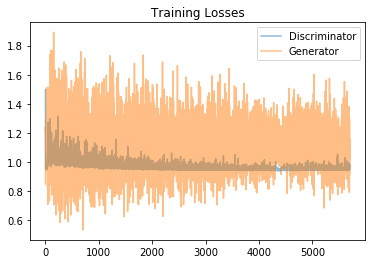

In [35]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [36]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [37]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

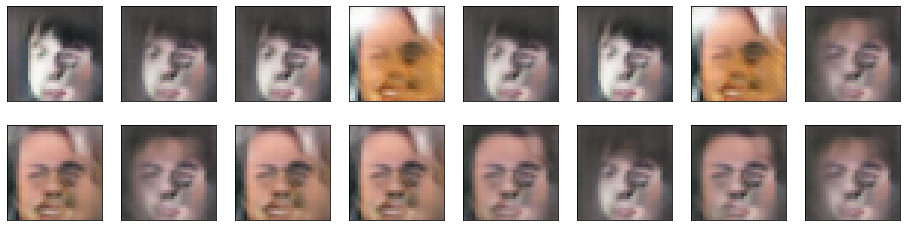

In [41]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)
first i started by using 3 conv layers but i found the generator loss deresasing but with a very rapid and sudden changing so i started to use smoothing in the real_loss function also added 4th conv layer to make the network to be able to lear more features 
also i noticed that the network couldn.t identify or had problems with sunglasses 
so my opinion to enhance the performance is:
1- add some Residual blocks to make the network learn more features without facing the vanishing gradients issue 
2- increase the number of epochs for more than 1000 which takes too much time and iam working on my local machine



### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.